<a href="https://colab.research.google.com/github/MWSteams/4590FSP/blob/Residuals/Residuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residuals

Authors: Madeline Keep, Izabella Kornak, Hannah Weinstein


In [0]:
!pip install aguaclara
!pip install molmass

     |████████████████████████████████| 92kB 2.9MB/s 
     |████████████████████████████████| 163kB 8.6MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.1-cp36-none-any.whl size=99466 sha256=98f31cd157d306a3f4b188b0a82c8f6d8503f75f91220ccdceb2113a95e9d178
  Stored in directory: /root/.cache/pip/wheels/7f/ff/4f/10d76e6a261d392aefbdf6ce8d3d5519e924dc334b102ca49b
  Created wheel for pint: filename=Pint-0.8.1-py2.py3-none-any.whl size=134156 sha256=727d2bd88f358947dca49406d18e8896f79bbc0e07b142947c145711b8a003bb
  Stored in directory: /root/.cache/pip/wheels/b4/56/36/7c4d6a4e3660e233b95e3b0482551915cb184abca0f93ee1dd
Successfully built aguaclara pint
     |████████████████████████████████| 71kB 2.1MB/s 


In [0]:
from aguaclara.core.units import unit_registry as u
import aguaclara as ac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import molmass as mol
!wget https://raw.githubusercontent.com/monroews/4590FSP/master/Fairmont.py
import Fairmont as fmt

--2020-05-05 19:04:44--  https://raw.githubusercontent.com/monroews/4590FSP/master/Fairmont.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3025 (3.0K) [text/plain]
Saving to: ‘Fairmont.py’

Fairmont.py         100%[===================>]   2.95K  --.-KB/s    in 0s      

2020-05-05 19:04:44 (68.2 MB/s) - ‘Fairmont.py’ saved [3025/3025]



#Task list


*   Contact manufactures to find max flow rate of centrifuges
*   Calculate how many centrifuges we need to accomodate our flow rate
*   Calculate mass of sludge after dewatering
*   Find out truck capacity and calculate how many trucks we will eed per day to transport our waste
*   Backup generators for a power outage? (p1686 in MWH)
*  **We still dont know what the percent solids for our sludge is**
*  transfer tables
*  calculate energy needed for centrifuges (Madeline)
* add vendors to list


# Task Definition

Our goal is to develop a complete analysis of the composition, management, and disposal of residuals from the proposed treatment process.
According to the Fairmont Treatment Plant’s Scope Of Work document, settled solids from the sedimentation process will be mechanically thickened in an on site facility. The preliminary evaluation suggests using equalization basins, rapid mixers, then settling tanks, and introducing coagulants to form and settle out thickened solids. The residual solids will then be further mechanically dewatered at a separate facility, then can be temporarily stored in a sludge hopper (with the capacity to store a minimum of a week’s worth of sludge) before they are transferred via truck to be disposed off-site. The leftover water will be recycled to the head of the Fairmont sedimentation plant. 

A preliminary evaluation has concluded that that centrifuges are most effective active dewatering technology. We will develop a design for the thickening facility and dewatering facility and evaluate their cost and effectiveness. Our thickening facility will take the collected sludge and thicken it, and also even out the flow before the sludge before it enters the dewatering facility. These are expected to be similar to the coagulation and flocculation tanks. The dewatering facility will be composed of centrifuges that will further dewater the sludge to create a sludge cake. There also must be a distribution mechanism for the sludge cake to be moved out of the facility.

We will also develop a more exact estimate of the expected residual output of the process, and determine a minimum capacity for our residual treatment train.


# Executive Summary 

Our main constraints will rely on the amount of sludge that needs to be treated. Those calculations will depend on the treatment specifications of the plant. This will determine the characteristics of the sludge, and allow us to analyze potential solutions with concrete estimations of the costs of management. Our design solution will develop as we calculate these values



#Preliminary Schematic and Process Descriptions
![image.png](https://github.com/MWSteams/4590FSP/blob/master/Images/Residuals/treatment_train_diagram.png)

Equalization Basins: are designed to provide consistent influent flow to downstream processes by retaining high flow fluctuations. Due to the additional retention time, aeration and mixing is required in these basins.

Rapid mixing: aims to efficiently spread coagulant to the water. This may be done mechanically, or through maze-like channels causing turbulence to water bodies. We are also in the process of determining the neccesity of having rapid miz/sedimentation in our plant.

Clarifier: used to remove solid particulates or suspended solids from liquid. Concentrated impurities discharged from the bottom of the tank are known as sludge, while the particles that float to the surface of the liquid are called scum.

Thickener/ Settling tank: used to increase the solids concentration and decrease the free water. This step minimizes the load on the downstream processes

Holding Tank: Holds the condensed sludge to maintain centrifugation loading rates.

Centrifuge: further thickens solids into a cake. we would need to use a decanter centrifuge because this decreases the water content of the sludge. Typical models usually have a treatment rate of between 100 and 200 gallons per minute. There is continuous recovery of the clarified
liquid (centrate) by overflow, and continuous gravity discharge of
the dewatered solids.

Throughout the process: Water is reintroduced to the head of the plant. This dewatered sludge is not expected to carry heavy contaiminants, as the main purpose of this plant is to treat arsenic laden waters, through the application of ferric chloride.  

We plan on disposing solid cakes off-site. The water treatment plant controllers we have contacted recommend getting solids concentrations to 20 - 30%, which can then be held off-site and applied to a landfill. 


# Constraints
*(Relevant regulations, client expectations, site and budget, process capabilities including process design equations, ease of use, operation requirements,maintainence requirements)*

* Amount of material that must be disposed of
* Transportation costs
* Disposal costs
* Discharge requirements/pollution standards
* Residuals management systems may limit overall plant capacity if not designed and operated properly
* Toxicity of residuals
* Specific resistance of sludge
* Amount of water used
  * (“The quantity of waste washwater for both granular and membrane filters will typically comprise from 2 to 5 percent of the total amount of water processed”-MWH)
* Capacity of washwater facility to to accept high, intermittent flows from backwashing 
* Unit filter rn volumes (UFRV)
* Unit backwash volume (UBMV)
* Effective filtration rate and recover or production efficiency of filter
  * (“Typically, waste washwater quantities are 8 m3/m2 (200 gal/ft2). To achieve a filter production efficiency of 95 percent, the UFRV would have to be at least 200 m3/m2 (5000 gal/ft2) a run. At a filtration rate of 12.2 m/h (5 gpm/ft2), a filter run would have to last at least 1000 min between backwash cycles.” -MWH)







# Physics


* At what steps we should treat/recycle residuals
* The TSS/turbidity ratio for most water sources will vary between 1 and 2, with a typical value being about 1.4. For turbidities less than 10 NTU the ratio is nearly equal to 1. -MWH
* Percentage of plant flow that each type of residual contributes to (Table 21-1 MWH)
* Table 21-3 (Physical, chemical, and biological properties used to characterize water treatment plant residuals)

#Physics: Sludge Composition

Our first step is determining the amount and composition of the sludge that is coming from the treatment. Using the total mass of sludge equation, (adapted fromm equation 21-13 in MWH), we can find the weight of the total dry sludge produced from the different parts of treatment:

$$W_s=D_{coagulant}*E_{coagulant}+(\Delta turbidity)*E_{turbidity}+TOC+X$$

$W_s=$ total dry sludge produced,  $kg/m^3$

$\Delta turbidity=$ influent turbidity - goal turbidity

$D_{coagulant}=$ coagulant dose, $kg/m^3$

$E_{coagulant/turbidity}=$ value used to estimate sludge quantities (from table 21-4 in MWH), kg sludge/kg coagulant or turbidity

TOC= total organic carbon $kg/m^3$

X= other coagulant aids

According to the Fairmont SOW, they are using ferric chloride as a coagulant with the addition of a cationic polymer (emulsion polymer), and are also removing turbidity and TOC. 
We are in the process of figuring out how to account for the TOC removed.

We then adapted equation Equation 21-3 from MWH to estimate the volume of sludge.

$$V=\frac{W_s}{\rho_{s1}*P_s}$$

$V =$ volume of wet sludge, $m^3$

$W_s=$ weight of total dry solids, kg



$\rho_{sl}=$ density of sludge, $kg/m^3$

$P_s$ = percent solids expressed as a decimal

To determine the specific gravity of sludge, we adapted Equation 21-1:

$$\frac{W_s}{S_s\rho_w}=\frac{W_f}{S_f\rho_w}+\frac{W_v}{S_v\rho_w}$$

$$\frac{W_s}{\rho_s}=\frac{W_f}{\rho_f}+\frac{W_v}{\rho_v}$$

$W_s=$ weight of total dry solids, kg

$\rho_s=$ density of total solids, $kg/m^3$

$W_f=$ weight of fixed solids(mineralmatter),kg

$\rho_f=$ density of fixed solids, $kg/m^3$

$W_v=$ weight of volatile solids, kg

$\rho_v=$ density of volatile solids, $kg/m^3$

With the assumption that the density of the dry volatile solids is about 1.0 and dry fixed solids about 2.5.(DEU) The weight of volatile solids will come from the calculated weight of removed TOC dry solids. We are currently using averages based on coagulant type from MWH table 21-5 which is laid out as the chemical/physical properties tables coded below.

Right now we don't have information on the percent of solids, so our code uses the average percent of solids based on the coagulant type from MWH table 21-5.  
From these equations, we created a sludge class to calculate the mass of dry sludge, and volume and mass of wet sludge.

From this information, we can determine the ideal treatment plan and the design and performance data.

More of Monroe's comments
Move the table into your github images folder (https://github.com/MWSteams/4590FSP/tree/master/Images/Residuals) and then link to the image to eliminate the long text string.
Nice work creating a sludge class! 
I would replace specific gravity values with densities. I think that is less convoluted approach. And it doesn't create the confusion of thinking that the density of the iron hydroxide changes if the temperature of the water changes!

Use the basis of design info in Fairmont.py for flow rates and coagulant dosages. https://github.com/MWSteams/4590FSP/blob/master/Fairmont.py


![image.png](https://github.com/MWSteams/4590FSP/tree/master/Images/Residuals/MWHTable21-4.png)


THIS IMAGE SHOULD BE TABLE 21.4, WHY DOESNT IT WORK 


In [0]:
class sludge:
  def __init__(self,flow):
    self.flow=flow
  def dry_sludge(self,coag_type='None',coag_dose=0*u.mg/u.L,percent_al=0,\
                     influent_turbidity=0*u.NTU,goal_turbidity=0*u.NTU,removal_ratio=1.4*u.g/(u.m**3*u.NTU),\
                     polymer_dose=0*u.mg/u.L):
    if coag_type =='Alum':
      est_val=.26
    elif coag_type =='Ferric sulfate':
      est_val=.53
    elif coag_type =='Ferric chloride':
      est_val=.66
    elif coag_type =='PACl':
      est_val=.0489*percent_al
    else: est_val=0
    self.coag_type=coag_type
    dry_sludge_coag=(self.flow*coag_dose*est_val).to(u.kg/u.day)
    dry_sludge_turbidity=(self.flow*(influent_turbidity-goal_turbidity)*removal_ratio).to(u.kg/u.day)
    dry_sludge_polymer=(self.flow*polymer_dose*1).to(u.kg/u.day)
  #HOW DO WE ACCOUNT FOR TOC
  #influent_TOC=0*u.mg/u.L,goal_TOC=0*u.mg/u.L
    drysludge=(dry_sludge_coag+dry_sludge_turbidity+dry_sludge_polymer).to(u.kg/u.day)
    self.drysludge=drysludge 
    self.coag=dry_sludge_coag
    self.turbidity=dry_sludge_turbidity
    self.polymer=dry_sludge_polymer
    return drysludge
  def sludge_volume_wet(self,temp=15*u.degC,percent_solids=0,rho_fixed=(2.5*1000)*u.kg/(u.m**3),rho_volatile=(1*1000)*u.kg/(u.m**3),volatile_solids=0*u.kg/u.day):
    #REPLACE THIS HERE WHEN WE FIND OUT WHAT THE PERCENT SOLIDS
    #REPLACE THIS WITH THE ASSUMPTION THAT THE VOLATILE SOLIDS WEIGHT = DRY WEIGHT OF TOC SLUDGE
    self.percent_solids=percent_solids
    if percent_solids == 0:
      if self.coag_type =='Alum':
        percent_solids=((15+40)/2)/100
      elif self.coag_type =='Ferric sulfate' or self.coag_type =='Ferric chloride':
        percent_solids=((4+21)/2)/100
      else: percent_solids= .15
    #Add in volatile
    self.volatile=volatile_solids
    if self.volatile==0 *u.kg/u.day:
      if self.coag_type =='Alum':
        self.volatile=(((10+25)/2)/100)*self.drysludge
      elif self.coag_type =='Ferric sulfate' or self.coag_type =='Ferric chloride':
        self.volatile=(((5+15)/2)/100)*self.drysludge
      else: self.volatile=.1*self.drysludge 
    else: self.volatile=volatile_solids
    rho_water=ac.density_water(temp)
    rho_solids=(self.drysludge/(((self.drysludge-self.volatile)/(rho_fixed))+(self.volatile/(rho_volatile))))
    rho_sludge_wet=(1/((percent_solids/rho_solids)+(1-percent_solids)/rho_water))
    self.density_sludge_wet=rho_sludge_wet
    wet_sludge_volume=self.drysludge/(self.density_sludge_wet*percent_solids)
    self.wet_sludge_volume=wet_sludge_volume
    return wet_sludge_volume
  def sludge_mass_wet(self):
    mass_wet_solids=self.wet_sludge_volume*self.density_sludge_wet
    self.mass_wet_sludge=mass_wet_solids
    return mass_wet_solids.to(u.kg/u.year)
  


#test=sludge(flow=.5*u.m**3/u.s)
#test.dry_sludge(coag_type='Alum',coag_dose=30*u.mg/u.L,influent_turbidity=25*u.NTU,polymer_dose=1*u.mg/u.L)

#print(test.drysludge)
#test.sludge_volume_wet(percent_solids=.05)
#print(ac.density_water(15*u.degC))
#test.sludge_volume_wet1(temperature=15*u.degC,percent_solids=.05,sg_fixed=2.5,sg_volatile=1
#volatile_solids=.06*test.drysludge)
#test.density_sludge_wet

In [0]:
yearly_emulsion_polymer=165*u.ton/u.year
avg_dose_emulsion_polymer=(yearly_emulsion_polymer/(fmt.q_ave)).to(u.mg/u.liter)

sludge_estimate=sludge(flow=fmt.q_ave)
dry_sludge=sludge_estimate.dry_sludge(coag_type='Ferric chloride',coag_dose=fmt.Fe_c_ave,influent_turbidity=fmt.turbidity_c_in_ave,goal_turbidity=fmt.turbidity_c_out_design,polymer_dose=fmt.emulsionpolymer_c_ave)
wet_sludge_volume=sludge_estimate.sludge_volume_wet()
wet_sludge_mass=sludge_estimate.sludge_mass_wet()

print('We estimate that the dry sludge mass produced will be', dry_sludge.to(u.ton/u.day))
print('We estimate that the wet sludge volume will be', wet_sludge_volume)
print('We estimate that the wet sludge mass will be', wet_sludge_mass.to(u.ton/u.day))


We estimate that the dry sludge mass produced will be 21.23 US_ton / day
We estimate that the wet sludge volume will be 143.8 meter ** 3 / day
We estimate that the wet sludge mass will be 169.8 US_ton / day


In [0]:
#residual production table 21.2
data_residuals={'Min':[(.08),(4),(2),(1.5),(.08),(.3),(2),(10)],'Max':[.3,8,5,10,.3,6,8,50],'Typical':[.1,'-', ('2 or 3'),(5-8),.1,4,6,(20-30)]}
rows_resid=['Alum','Direct filtration backwash water','Filter backwash water','Ion exchange brine','Iron coagulation sludge','Lime-softening sludge','Microfiltration backwash water','Reverse osmosis concentrate']
data_residproduction=pd.DataFrame(data=data_residuals,index=rows_resid)
#physical properties reference table from table 21-5 asumin max values
#alum, iron
data_physproperties={'Min Volume':[.05,.06],'Max Volume':[.15,.15],'Min Total Solids':[.1,.25], 'Max Total solids':[4,3.5],'Min Dry Density':[1200*u.kg/u.m**3,1200*u.kg/u.m**3],'Max Dry Density': [1500*u.kg/u.m**3,1800*u.kg/u.m**3],'Min Wet Density': [1025*u.kg/u.m**3,1050*u.kg/u.m**3], 'Max Wet Density': [1100*u.kg/u.m**3,1200*u.kg/u.m**3],'Min Spec Resistance':[10110*u.m/u.kg,40440*u.m/u.kg],'Max Spec Resistance':[50550*u.m/u.kg,151650*u.m/u.kg]}
rows=['Alum','Iron']
data_chemconstit={'Min Solids(Al/Fe)':[15,4],'Max Solids(Al/Fe)':[40,21],'Min Solids(Silicates and inert mats)':[35,35],'max Solids(Silicates and inert mats)':[70,70],'Min solids(organics/volatile)':[10,5],'Max solids(organics)':[25,15]}
physical_properties=pd.DataFrame(data=data_physproperties,index=rows)
chemical_constituents=pd.DataFrame(data=data_chemconstit,index=rows)


# Table listing potential strategies to meet the dewatering constraints and treatment objectives 


| strategy | advantages  | disadvantages |
|---|---|---|
| Centrifuge | high speed dewatering | high energy input | 
| | 25% and 35% solids by weight.| standby unit needed in some cases |
||works for all sludge types|very loud to run|
||cost less to operate than filter press||
| Plate and Frame Filter Press | stackable, cake-like solids | high potential for blockage and damage | 
| | 40% and 70% solids by weight | potential for leakage |
| |can operate on a continual basis | |
| Belt Filter Press | effective on high-volume waste streams  | difficult maintenance |  |
| | 18% and 25% solids by weight. | suitable for high sludge moisture content|
| | low energy and space taken up| |
||10 year service life||

#Table listing potential strategies to meet sludge handling constraints and objectives

| strategy | advantages  | disadvantages |
|---|---|---|
|Sludge Detention Ponds| can further thicken sludge | 280,000 sq ft of land required|
| | lowers volume of sludge in dumping site| high cost of $46000/day| 
|Sludge Processing Facility| converts hazardous waste into nonhazardous | high cost|
| | has potential to create new materials | still in research phase, not usable|
|Off-Site Dumping | lower cost | hazardous waste dumping | 
| | No extra land or equipment needed | highest volume of waste produced |


#Physics: Centrifuges
"
$$G=\frac{r\omega^2}{g}$$
$r=$ radius of centrifugal dewatering vessel

$g=$ gravitational acceleration

Using Darcy's law to predict the rate of drainage through the filter cake [1,12]:
$$Q=\frac{K\Delta P A}{\mu L}$$

$Q=$ flow rate

$K=$ permeability of cake

$\Delta P=$ pressure drop across the cake

$A=$ filtration area

$\mu=$ dynamic viscosity of water

$L=$ cake thickness

During filtration period, the pressure drop across the cake is determined by the following relationship:
$$\Delta P=\frac{1}{2}\rho\omega^2(r_s^2-r_0^2)$$

$\rho=$ density of the liquid

$r_0=$ radial distance from the rotation axis of the centerfuge to the free water

$r_s =$ radial distance from the rotation axis of the centerfuge to the cake surface

Centrifugal dewatering is largely used for separating excess water from sludge. The applied centrifugal force created by the angular velocity of the rotating basket allows for w lower moisture content of the product, which is the goal of our team, both to limit the amount of waste that is being dumped, and to best salvage water for reintroduction into the treatment process. 

Centrifugal treatment starts with a process called filtration, in which water flows outwards through the sludge while the sludge is covered in a layer of water. In time, as the water is increasingly removed from the sludge, drainage occurs in the centrifuge. The pressure drop becomes negative during this slower process, as the thickness of the solid cake is increased. 

To start to observe the physical characteristics that outline the process of centrifugal dewatering, we calculated...


From the top equations, we can deduce that the rate of filtration should increase with angular velocity and the thickness of the water
over a filter cake. 

We also see that the change in pressure approaches zero when the water over the cake decreases. As the water level in the cake decreases further, the pressure within the cake becomes lower than the ambient pressure.This may be the fundamental reason that centrifuges cannot produce as low cake moistures as vacuum or pressure filters for
the finer particles.

# Energy Requirements

From a stuy of Chinese WWTPs, the treatment of sludge amounts for 4.1-13.9% of the total energy consumption of a WWTP. The treatment processes examined were thickening, conditioning, and dewatering, which all serve to decrease the water composition of sludge. Gravity thickeners utilize electricty in order to rotate sludge scrapers at the bottom of the tank, while centifuges require electricty to run their electric motor. From this study, it was found that gravity thickening required 0.0019-0.0021 Kwh m^-3 for plants that serve over 50,000 people, while thickening centrigues required 0.015-0.035 kWh m^-3. At Beijung's Gaobeidian WWTP, sludge thickening accounts for 0.04% of the plant's energy consumption. Plate and frame filter presses utilize 100 kWh of electricty per dry ton of sludege while centrifugal dewatering utilizes 108 kWh of electricity per dry ton. 

Given that we do not yet know how many dry tons of sludge will be produced per day, to calculate the approximate energy requirements of a centrifuge we will utilize our wet sludge volume. To calculate daily energy required, Fairmont's daily wet sludge volume must be multiplied by the electricity requirement per m^-3. Once the dry sludge mass is calculated, we can determine the energy requirement given that centrifugal dewatering utilizes 108 kWh of electricity per day. To calculate the cost of this electricity requirement, we will make the assuption that the average cost of electricity is 13.19 cents/kWh. 

In [0]:
#daily energy requirement to run centrifuge
thickening_kWh_requirement=0.035*u.kilowatt_hour/u.meter**(3)
daily_electricity_requirement=thickening_kWh_requirement*wet_sludge_volume #use wet sludge volume until we know dry sludge volume
print(daily_electricity_requirement, 'of electricity will be required to run a centrifuge')

#daily electricty cost of running centrifuge
cost_per_kWh=0.1319*u.dollar/(u.kilowatt_hour)
daily_electricity_cost=cost_per_kWh*daily_electricity_requirement
print('It will cost',daily_electricity_cost,'to power a centrifuge')





5.032 kilowatt_hour / day of electricity will be required to run a centrifuge
It will cost 0.6637 dollar / day to run a centrifuge


#Centrifuge Capacity and Stats

Solid bowl centrifuges designed for large-scale municipal use are generally 25 feet long and 14 feet wide. These dimensions account for the rotating assembly, backdrive, and adjacent motor. Centrifuges used to dewater sludge can accomodate flow rates of 100-200 gallons per minute (gpm), while centrifuges used to thicken sludge can accomodate flow rates of 400-600 gpm. 

Solid bowl centrifuges come in two designs, a concurrent centrifuge and a countercurrent centrifuge. 

| Concurrent Centrifuge | Countercurrent Centrifuge  |
|---|---|
|Sludge feed introduced into rotating assembly though cylindrical end of bowl |Sludge feed introduced through conical end of bowl |
|Helix orientation draws settle solids in direction of sludge feed towards conical portion of centrifuge|Helix draws solids against direction of sludge feed toward sludge discharge| 


a) Solid bowl concurrent centrifuge


![alt text](http://web.deu.edu.tr/atiksu/ana52/sludisx-17.gif)

b) Solid bowl countercurrent centrifuge 


![alt text](http://web.deu.edu.tr/atiksu/ana52/sludisx-16.gif)

Solid bowl centrifuges can be either low-speed (operate at gravitational forces less than 1100 g) or high-speed (operate at gravitational forces greater than 1100 g). 

| strategy | advantages  | disadvantages |
|---|---|---|
| Low-speed centrifuge | Lower energy consumption | Lower performance | 
| | Less noisy | Lower capacity to dewater sludge |
||Lower maintenance costs|Need polymer conditioning|
| High-speed centrifuge | Increased performance | Higher energy consumption | 
| | Increased capacity to dewater sludge (speeds up process) | Higher maintenance costs |
| |Reduces need for polymer conditioning | |

Although high-speed centrifuges have a higher maintence cost, they are now being constructed from improved wear-resistant materials which has lowered the amount of maintenance these centrifuges require. As such, high-speed centrifuges have gained popularity in the realm of municipal residual dewatering.  






#Amount of sludge centrifuges can thicken/dewater in one day

In the following code, we calculate the gallons of residuals that a single centrifuge can either thicken or dewater in a single day by converting the flow rate from gallons per minute to gallons per day. Since the flow rates are given as a range (centrifuge can either thicken 400-600 gpm or dewater 100-200 gpm), we reported the daily flow rate as both a high and low estimate.
To calculate the number of centrifuges needed to either thicken or dewater Fairmont's residuals, we divide the maximum daily flowrate of the Fairmont WTP by the the maximum daily flowrate one centrifuge can handle.
It appears that one centrifuge will be adequate. 

In [0]:
#Thickening capacity (400-600 gpm)

thickening_capacity_min=400*(u.gallon/u.minute)
thickening_capacity_max=600*(u.gallon/u.minute)
print('An estimate for the amount of residuals that a centrifuge can thicken is', thickening_capacity_min.to(u.gallon/u.day), 'to', thickening_capacity_max.to(u.gallon/u.day))

#Dewatering capacity(100-200 gpm)

dewatering_capacity_min=100*(u.gallon/u.minute)
dewatering_capacity_max=200*(u.gallon/u.minute)
print('An estimate for the amount of residuals that a centrifuge can dewater is', dewatering_capacity_min.to(u.gallon/u.day), 'to', dewatering_capacity_max.to(u.gallon/u.day))

#Number of centrifuges for thickening 
min_centrifuges_thickening=(wet_sludge_volume/thickening_capacity_max).to_base_units()
max_centrifuges_thickening=(wet_sludge_volume/thickening_capacity_min).to_base_units()
print('The number of centrifuges needed to thicken residuals will range from', min_centrifuges_thickening,'to',max_centrifuges_thickening)
#Number of centrifuges for dewatering
min_centrifuges_dewatering=(wet_sludge_volume/dewatering_capacity_max).to_base_units()
max_centrifuges_dewatering=(wet_sludge_volume/dewatering_capacity_min).to_base_units()
print('The number of centrifuges needed to thicken residuals will range from', min_centrifuges_dewatering,'to',max_centrifuges_dewatering)



An estimate for the amount of residuals that a centrifuge can thicken is 5.76e+05 gallon / day to 8.64e+05 gallon / day
An estimate for the amount of residuals that a centrifuge can dewater is 1.44e+05 gallon / day to 2.88e+05 gallon / day
The number of centrifuges needed to thicken residuals will range from 0.04396 dimensionless to 0.06594 dimensionless
The number of centrifuges needed to thicken residuals will range from 0.1319 dimensionless to 0.2638 dimensionless


#Loading Trucks
Fairmont WTP will utilize 6,500 gallon tankers to transport dewatered residuals
to disposal sites. The code below calculates the number of trucks needed to transport residuals per day. 

In [0]:
truck_capacity=6500*u.gallon
trucks_per_day=(wet_sludge_volume/truck_capacity).to_base_units() #use wet sludge volume until we 'know dry sludge volume
print('The number of trucks required to haul dewatered residuals off site is',round(trucks_per_day.to(1/u.day))) 

The number of trucks required to haul dewatered residuals off site is 6 / day


#Dry Solids Estimates and Variables
 In addition to inorganic
chemicals including metal salts and polyelectrolites, a large variety of organic-based polymers are employed as coagulant aids either
independently or in concert with the inorganic coagulation aids. A large number of different 
formulations of polymer beads, polyacrylamide, polyamines, and polydimethylammonium
chloride are listed in ANSI/NSF Standard 60 and can be used to promote the removal of turbidity from
drinking water. Some of these chemicals are also referred to as filtration aids, but function the
same way as coagulants.
Residuals are generated as underflow discharges from the sedimentation tanks.
These residuals contain source water contaminants, as well as chemicals added to aid solid
removal and formulation impurities in the added treatment chemicals. 

Below is a chart formed from data aquired by field testing regarding polymer addition and solids cpncentration output as it relates to three different polymers. 

xAMWeh3XihR7FmJH0/luCzZOvj24jk1jw+FkoKjIEzDa8BuxEk0Xb3c51oOPt6I0xgWGEp4EFDsic+FenLnZIvlu75mOeA8ThZQUqME6ciQW7jyDT++0Cs6HD3F39zTEu5koOt+LfTBsbRMu3GuVp53JS0YdDikzsfVYI+Zl94aVXBQLILHPQO2uU7jBk6/3mucg3YdX0cgYI3baZhy+dBusOHxu3L2H+6xw7MZ1kglNpeTlzeNYmO8PW15jHYHQGkkVG7D3NFt12XnlpdAsBqUrtqHpBfKyad9yjIxkK39lUl0NrqnjUNjPl9eFnYFBQAGmL1iDzVtUIy9njUmBr7W+4nozmnCMGITBIydwXcbZTuNjx47FmDFjMGLECAwbNowLdkmIYnZpiKFDuWUiuMrLVnnJCszs7GxkZWUiIzUB4UG+cHe0gom+JiQi2fnKcpWBlqUH/EOi28nLUO4LJvZLpqBAf/h6u8HJzgomBjrQkIogbP/lASOFrpk1rO0dSF4q8aylTYgAESACRKDnCJC87DmWnY1E8rIzKvR/RIAIEAEi8EoJvBJ5GRsJP3t9aPCnCIuN4R7Wr/Nu4xnhcGvXbVzNJhApWYO73218aqu8rJiGkjhXGGsp5JXU0h7WOppQk625KDREQG4ZZs1fhMWvTF4ex6H5OfCx5FVsiZ2ROX8LDp6+0KZhz7WrH2LL4rmoqqrB4lUN+GDfUZy5fA2fPUdeiqzTUbfvDD7rEXn5EA+ub8SYUAfoy7phC/VgoCuFRP5vA0RO2YbjH7etEHz44BauXziBQ7u2YO3yOlTXrMa+89dwu91x3b16AHMH+cCCV9UoNEvE9r0fdSkcZWKt/eut/RVI8jDlTR0XgNFyQfrsbTh5/V5HaXf3NNaOioCDvqKqjK1IU/MYjBX7z7Ue632cXJCD3lZa8upDRj8Sk7Yew1WeVGSP5bONY7gp3UJZxR0rL9c9T14y0O0zEqsPXcSdzx/ixs5pSHDnSVJGC74lK3Dwwm3FsX+6EWPDnWAgrzAVwzVvKfae5b2Hk5MPcHn/OixZUI/F727AB3uP4szVz3D3fverLrlzeunKy89wYuVwRDjypJ5AALFDGqo2HcKZK1e7lpfmsZjQHXnZtB+rxsXCjSfQ1ezd4WSsDx0ZF6EJ+hZWYOHazdiiInlZNaMQka5m0JLdXwRCGPdKQk5Jabtu4+NQnNkfsVGRiO6XhP4DBiIrrxDFrfKyMD8XGQP6o19MJEL7BsA/NLblPVlZyMjIaF0vOA2JUb6wM9JUVJwKGEiNneDXNwKxsTGICAtBYJ/e8PJwhZODI1y9/eAXECSvmvdju437eMPF2giaUsU6ugKBCFrGVrCyI3n5Sh/atHMiQASIABEAyUvVJgHJS9XypdGJABEgAkRACQKvRl7GINrPDgYaYrno4Zr2WHgjrF8yBqTzGvZkDkCMlwV0+GsIMhqwC0lBduFQlJR0t9u4TF5WYPqIBHiaaisqoWQSqfVVaByI/PJZqFu0+JXKy4/2VCPDy7yN9DCNKMXKXcdwjtdt/NLO6Uh0NeGtGyiFe8FS7D11Hbe6qLwU2WRg4f6zuPnwC3zxxRf46quv8PXXX+Pbb7/Fo0ePuHjy5Alk8fTpU7Dx7NmzLuIbHKxkm/Mopqbzp5wKzVMw/9AVfP6Uv/1TXF9ZiD422oo8EFkhZd4BXPn8u3b7eYRjVf3haaoYX2SbiYMfftzuffzxu/j709vYWR4LF8O2MlIgMUavlLGo23IUl289xJcPbuB043JMSPKCGU92c+clNEW/2btx4f6T1v0/xtmFmfC1ap1Wz6WerjXxj05Ff3FJ1qUzlZUXFdEzM8IOlXjuJxO5DZIGQgomYXbfw1cvLkyfx0a65yOxtAW25tHueAGKr17ThNXgRGk9cwc1bqpWXP/74I3766Scufv75Z/z848d4J6/teoycKJK4o6ThHO798Bt+//33dvEjrq4qQIC1Fk/6veAc2euk4Ymh687h3rPOxmy/j87//fP9g6ge6ANTTf7U2BftWwgDvxFYc/Ienv7SdtxfH2zFmHBH6HX3WslEltACaQuP4dPHv7aw+etlLM3xg5W8Uk8Iq4xFOHbjCX6V8fvtEY7MSuYqURnZZ0OzN0ZvPIv7P7Yy+fUBdpXHwbV9halsvx1e2e7lw7H25C08+ukv8mv7ww8/cIJYdfKSgYZDEqasO4jTV6/j+vUelJdNB7Fpejp8LDvp9i22QczouVi6YStXdak6eVmFyooJyA51hslL5JrE0B3hKdkoGlrSsuZlQRpCXc2g00Y8vihfBRBqsYIzBJExLQ17IgI9YKmv8fyGWJ3khlTHBNb2TnBwpIY9SjxqaRMiQASIABHoQQIkL3sQZidDkbzsBAr9FxEgAkSAGXh9tRGuYIfVn1IaOF0CmNuPrlz+0qLtvJv1+/w7VdtSgOd4SBeheVkIwajL2SMHH9Sdx78vMfFpf8KtAf7p/F9iXlKEgMgru1EbTVxBBLNaBjbA23gDjklNbjgzP38OSn1urIriTpb49wft0ExLsZQV3GoFUIiXRdED9hHU7de4Tra4Yg0Fax1qfIMR/vfnQLT1np2E15+fvvP+LC4mz04a2zKRDbYdDiY7jxhHecz27i0JKRiHUzhkYn0ouRGsIjcSLWHr+Fb579BWwVrWrkJQOhWA1aBuaw9+yLhPyJqN/SjLNXPuHylc1ZVcjLA/s/QHWOP6/DOCv8JLBPKMW8lVuxddufIy8rKiowbdIo5Mb7w9FYE5J2MpUTmUJ16Nv4IDotD4VDh3HLYrDV5TJ5mZ+fj9zMFET1cYaZrlon94JWmclIoWVsC8+AcMT0S0BcHF9eRiEyMgJ9+3jC3lwfGmJh22UMeAKTEalBy9CCq7h0dnGBC8nLl3/I0hZEgAgQASLQ4wSo8rLHkbYZkORlGxz0DyJABIgAEXgdCHRHXtrb24MNZ2dn7pdXT09PeHl5ceHj4wNfX18uAgIC5B1rg4ODERISgoiICERGRnIRExMjr/6Jj49HQkKLvExJSQEbA1ISEBMWiN69PODp4QGvXr7wD45EcnomcnLzUFhYyIlLtgKprbwcgZEjR2LcuHEYP348FxMnTkRZWUszjClTpmCqvNt4BViJMHv2dAwOt4OhBk9eSmwRNaQMM+fVYVFn8nL5cqxcuRKrVq3C2rVrsW7dOi42bNiAhoYGLjZvbulavH37duzYsYOL3bt3o7GxkYt9+/Zh//79OHToEJqamrhobm7GkSNHuPjwww9x/PhxLk5ylZct8vLcuXM4d+4MTh7ahlX1M1E2ZjhKhpZgxNhJqF6yEftPXsCVa9fx6aefykWQovLyLu7du8fFgwcPwDZPYYNt1CMLZRr2dJg2/vPP+Otf/yqPX3/9FbLgi8J//dd/BRv/9m//Jo+//e1vaIlf8OjmKezf/A4WzJmJGdOmo2L2PCxe8z6OXH2IH377N/z9H//AP17z+Ldn93B2XwOW1VZj9pw6LN90GNe+/gm//61nj/3vf/87ZKFg+Df8+7//O8dWxpp9/e3HL/DxhzuxbvFczJw+FdMqqlH/bgvXxz/8zElLbvq/EvKSbfL0zTffcE2f2MZPX375pTy32G7kbL7dv39fnod37tzB7du3ufjss8/kOdtRXl7BpUuXcPHiRS7Onz8P9rNw+vRpnDp1iosTJ07IPzNHjx7lPkeHDx+Wf74OHNiJeQVBsOc1OBJInZA0oRartm7Hts7kZUMD1q9fz32+V69ezX3m2c/9ihUrsHz5ci6WLFkiX1qivr4edXV1mDdvHmpqariorq5GVVUVF5WVldx9Z9q0ady9aEr5WAzJTUdidDhC+gYhMCgE4bFJGJBThKHDWu5nw4Z1Li/z8vLARvagNCTGhKNvHx94urvB1dUVbp7e6OUXhPCYeMQnJHL3WPY+21FeRiI0NJS7R/cN8IOnmxPsbKxgaWkBM3NzmFtawdrOCS5uHvD08oKbmxt37yd5+To8tekYiAARIAJEgOSlanOA5KVq+dLoRIAIEAEioASB10lepqWlIT09nYvMzExkZWVxkZuby/2y3pPyclZ5Fvra6LeZii2xi0ZJ2UzMq3td5eU5XLhwQS5yLl++zHVkvnbtGjfVll0r8J9fXv5NLuNed0H5OhyfTFyyry+Sl//yL/8ir3797bffOLH8yy+/yGWzTFwqU3n5OsvL/VtnI6uPbZumUFKXFEysXY1t23e8EnnJfplSXl4u/4KF6zY+fjxGjx7NfRHDfhnzQnmZnS2/R2ZkZMjvnampqdyXQYmJ3ZOX7JdMQUFB8i+eZN3Gvb295V9SkbxU4uFKmxABIkAEiIDKCJC8VBlabmCSl6rlS6MTASJABIiAEgTeSnk5vRT5YY4w1OBNT2bU4BA3DOWzarkKqtez8pLk5esgDF+nYyB5eQrPrbw8+D5qC0PhYMBrzsWowy1tMuaveR/bd5C8JHmpxIOTNiECRIAIEIFXSoDkpWrxk7xULV8anQgQASJABJQg8HbIyzIUJoUgKMAfAQG+8LAxhIaEN12cbWyh44HU0VNRNb+O5OWjR2Ar6Z48eSKPp0+fgo1nz57JQzXTxjuvvPyP//gPyOI///M/wcZ//dd/yeO///u/IYv/+Z//wT9jyI6ff16yc2VfZefPvsoEKsnL9vLyIN6dNgQ56SlITU1EhI8tDDTEbdZ0ZPT8kD9zGd7bvpNb1uFVTBunykslHla0CREgAkSACBCBVgIkL1WbCiQvVcuXRicCRIAIEAElCLwd8rIc+eH2bde35DWlEDBqsIkoQFnlXE5csmvXUeUlycs/W4CSvOysYc/LrnnZhOUjIuFiJGkjLOVdvRkNOPWfgPq1H2DnTpKXbNUlVV4q8eCkTYgAESACROCVEiB5qVr8JC9Vy5dGJwJEgAgQASUIvB3ychKGJ3jAVFsCucSQy0sJDD0TMaSsAjXz55O8/PZbruqSKi///OpNkpc9IS+bsWlKMrwsNDvKS0YKU/8cTFu6Adt3N5K8bG3YQ/JSiQcnbUIEiAARIAKvlADJS9XiJ3mpWr40OhEgAkSACChB4O2Ql1MwMS8KnjZG0FKTQCSSQF3LAOYO3ghLLcLEitmYU1OD+SQv8e0bKi//93//F7L4v//7P7SP//f//h96KtqPLfu3bP9dVXSSvOwJeXkU+5aORZK/Awy11CCVqkNT1xT2XmEYMGI2lje8j12NjWhsJHkp6zZO8lKJBydtQgSIABEgAq+UAMlL1eInealavjQ6ESACRIAIKEHgbZGX7BpzM2bMQEVFBRezZ89GVVUVF3PnzkUNyUt8/fXXJC97QGLKZGX7V5KX93Hv3j0u7ty5g9u3b3Px2Wef4caNG1x88sknuH79Oq5evYorV65wcenSJVy8eJGL8+fP49y5czh95tGjOwAAIABJREFU+jROnTrFxXMb9jQ14cCBA9i/fz8Xe/bs4cQlyctIkLxU4oFJmxABIkAEiMBrQYDkpWovA8lL1fKl0YkAESACREAJAiQvq0Dy8gt89dVXJC97QFyy1ZvtpaXs3yQvSV5OmzYN7Bcp1LBHiYcVbUIEiAARIAJEoJUAyUvVpgLJS9XypdGJABEgAkRACQIkL0lefvEFycuemjJO8vJrToJ/+eWXYPOKjYcPH+Lzzz/H/fskL0leKvGQok2IABEgAkSACLQjQPKyHZAe/ifJyx4GSsMRASJABIjAHydA8pLkJcnL/+ux9S5JXpK8ZJegYKO6ulq+NEVlZSW3XAXJyz/+zKIRiAARIAJEgAiQvFRtDpC8VC1fGp0IEAEiQASUIEDykuTl2yAvu2qS8zr9PzXs6ZmGPUeOHMHhw4fR1NTEBa15mYC4uDjExsZyERUVhchIWvNSicclbUIEiAARIAKvCQGSl6q9ECQvVcuXRicCRIAIEAElCJC8JHlJ8vJ/8DpITJKXJC9Hjx6NkSNHcjFs2DCUlJRwUVxcjKKiIuTn5yMvL4+L7OxsZGVlcZGRkYH09HQuUlNTkZKSgsTERCQkJHBB8lKJhyNtQgSIABEgAq8tAZKXqr00JC9Vy5dGJwJEgAgQASUIkLwkeUnykuTlX//6V/z888/y+Mtf/oKffvqJix9++AHPnj3D999/j6dPn3Lx3Xff4cmTJ1w8fvwYjx49wjfffMOtd8l2re+RNS8vn8XRxk1YXjsTk0rHcEJv9PjJqJz/LjbtbsaxE9RtnOSlEg892oQIEAEiQAT+6QmQvFTtJSR5qVq+NDoRIAJEgAgoQYDk5auWl/tQl9cbtgZSiMXilw8NXwxdtQfHr17H9evX8emnn+LGjRtc3Lp1C7dv38bdu3dx7949Lh48eMA1T2EbqLDSUhbtu43faRiFYCcjSCUSSNjQDEZ541nc/u4ZJ7JYmfXjjz/KBZdMfLESTBa//vorZPH777/j5/MLMNDPGtrS1jE1XFG0/jzu//iv+Nvf/iaPv//972DjH//4B8U//oG/fbkN4yJdYaTWyk0ihUlSDY7ffIp/b2XF8pIz/PEIZvf3gYWG7P3sqxRavUdh89l7+PG33/Hbb79x1+aXX35puV7fHcasFF9YakhbrrdECr2wchw8ewc//PAIe6bFw9tcrfVn/HF5f5dKIVVTh6aWLgxNLGHv5ofw/vkYX7sJzZdu4Pa97jXs+fj0XrwzrQBR7mbQlgghEAg6BCM1gH3gAIxfuAmNhz/E8ePHuTh69Cho2jhVXirxKKRNiAARIAJE4J+IAMlL1V4skpeq5UujEwEiQASIgBIESF6+enlZm9MLljqdS5rOxE2b/xN7ofjdRhy/0rPy8tZ7wxFgqwtGJo4kgZiw68wfk5dn52OAlxnUZGOKHJC/5hzukbx8vqT914+xLNsPVuqMXOKJHPKx+uwD/OVvLaKXLy9/PVuHdB9zSGWcZa+awZjceAlf/LWjvPzx4lLk9LGGBiMThWK4F63BiU8fc/KycXI03IyUzFGBCHpuaZjRcAyXb7aI9Dt37nBinZXrn332Watwv4YPN1ZgkL8VdCSKc22T77JzaX1l1MzQJ3sGVu44iGPHj4PkZTpo2rgSD0LahAgQASJABP6pCJC8VO3lInmpWr40OhEgAkSACChBgOQlycvOpo2TvHydqj5/wfHZSfAyEcvlpUDaB6W7r+Kr39vLy3/BJ+/mw99GQyGeZcKPMULC3MO49s2v7Sovf8aDLWMQ6qSn2EZoibS6Q7j65Q89IC9ZIcpAwyUTNdtP4Nqde+goL6/hyLsjEelsAKlcoMpE6gteGV14DJyGd7cfwhGqvCR5qcRzkDYhAkSACBCBfy4CJC9Ve71IXqqWL41OBIgAESACShAgeUny8lXKy7zVp3Hn+9/ATiun6IrBb/hi2ziEOelBKBeRBuhX1cSJyDbcfr2N94b1hb1OZ5WLItjnvIMTN5/ilzbTxp/i8KxEeJkq5CijF4npu8/j/rOfekheCiBgNOBVuASNp2/gdrvKy4vbZyDF25xX+dkqLEWaMHHqjbB+KRiQmogoPyeYaksVHGQ81OyRNGkFNu87QtPGqWGPEk9C2oQIEAEiQAT+mQiQvFTt1SJ5qVq+NDoRIAJEgAgoQYDk5WsoL9V9MLh+LXY0HUZzczOOHTuGDz/8kIsTJ07go48+4uLUqVM4feYsLl/9GNeu9+y08UfffIkvH37OWx/zK3z75Am+f/YH1rzsZNo4ycuuhGXb///l+rsoCLCBprwqUQSHvJX46Nb3+I0nfn/7ejsmRDpDX9h5taLYewQ2nb2HH37lrXn542Usy/WHtaZCeKr1HoVNH93Edz92Li8ZzWCUbjyMy/c/B7uO6v3793GXFZK3buLG9Us4vnM5JvT3gpm2Qoiy07/Fzpmo3/kRrt/mTRv/eDcqU3vBnDctXiAQQte5H0Yv+ADNJ8/j4sWLXJw/fwaHN1Uht68t9KSK42UrO7V981G1ejsOHTmCw4cPo6mpiYsDBw5g//79XOzZsweNjY1c7Ny5Ezt27MC2bduwZcsWLjZu3IiGhgYu1q9fj3Xr1mH16tVYtWoVFytWrMDy5cu5WLJkCRYvXsxFfX096urqMG/ePNTU1HBRXV2NqqoqLiorK1FRUYFp06Zh6tSpXJSXl6OsrIyL0tJSjB8/HtRtXImHGG1CBIgAESACbx0BkpeqveQkL1XLl0YnAkSACBABJQiQvHwd5WVvFC/ZhP0nToIVlGfPnsW5c+e4uHDhglzkXL58GVeuXMG1a9e4Zj0dGvbcuIzjezbi3frZmD5pAkrHT0D5lErMXbgK25rO4cadB1027GG7R8u6SbOvsi7TbKOeF8U3149h27v1qKlbhvX7zuHWl4856fn4w2r09zRVrMUoskP2sqO49uX3ePb4Pi4e2oqV9XNQVV2LJWsbcfrGF3j09MX7UxzPt7hz4TDeX7MYNbMrMbO6FotWbcPhS3fw1ePvX3jcinF4+/zmE3z4/krUz6vD0vV7ce7ml906pqcPr+HYzvewdF4VqubW491tx3Dl3jd48j1v7G6wlB/To8OY3d8TphKFlJT6jcbmk5/hMW+cLxunINbNCGJZRSLDgBHwJJ9mX0x4/xRuPVEcx/e3N2J0qBP05MJTBMecZTh89atWWf0t2q95yWiFouyDj3Dj0RN01W384cebUBrtAkOx4pgFGoEYvf4AztyUyctbOPXuMIQ46EMkO2YBA03XDMxcfwCnLl3BpUuX5Dl//vx57nNwYnsVBvWxhraIN7aaK9IqVmDrwWaSlykpSExMREJCAhdxcXGIjY3lIioqCpGRkQgNDUVISAgXQUFBCAwM5MLPzw++vr7w9vaGl5cXF25ubnBxceHC0dER9vb2XFhbW8PS0hLGxsYwMDDgGjrJ1iiVSqXQ1dXlvnxR4tFEmxABIkAEiAAR6JIAycsu0fTID0he9ghGGoQIEAEiQAR6kgDJyzdQXn5yDrsXjkKClyk0u2p8wqjDtFcqJq8/iqu3PsdLdxt/fBxzB/jASru1O7WaI7KXHkLju+MQ42wANVmFIKMOq4RK7L54D18d60ReLt2D3etnIbuTJi1CLXtElCzBgWuf49HzpN/TBzi9eRbyQx1goC5SrNsok2EiLVgFZqFi00nc/PJJJxLzMU7UZKC3tXZrd3U1OGQuwv7d76K0nysM1WTyj4G6ZTwqdp7H3Ud3sHFUGFyMWs9fqoWQ8l04c+0qGucVIsReD2pyGcgKNgZqpj4YOPN9nLvzDZ7yhKNcUD7v/75/gA9KI+BsoGiawxjGYube87gnF7yPcKQqFd5m0lYGDHT9guBjZgRd2bEwRug3ey/O338q5/DtwUokeppCIuPFmCChai8uyN+jnLz84uFlrBzaF/a6Mn4CCMReKHp3L07eaJWXN09i8eBA2PIbVontkTpzA/adbpHzncnL06c/xHsT4+Fuqsadq1BdHxYufZE9YyW27CV5mULysicfkzQWESACRIAIvGYESF6q9oKQvFQtXxqdCBABIkAElCBA8vINk5efnMf70/rDw1Sj47qAMjnFexXqeKN42SFcvvMlvv76a3z77bdgqy5f2LDn8TFUJ3nAVNpa+Sa0QmJRGvzsTaAuE5fcfoSwHrgIzR9/gW/bV14KTdE71BtWRtqKSkHesbVUcElgGTUJm87exjedCMynD09j1fAIOOjJhB2vEq/9WFJLRJSux0c3v2onDx/jwznJ8DKTtjbEEcIyYTAG+DnCTIMn3gQCCK3TseDQFTz87jY2jAjiiTkJAkZUY1T/INjotJ0qLatE415FpoiZ9gHO3mmpRu2WuOSk5lNcW1WEAFtthZwVOSB7WTOuftVaVfrkLBZl+cFKfswaCBizAOOS+sBOvgamCHaZi9F05YvWqsr/z955gDdVtm+8SdNJW2hpoZSyyiqUvfcWEBQQAdl7l72RLUuWIorsoSwXIBsBAZGlfuL8ED/3p36K+JcpSqHe/+skTZOmSZuk5yTnvOfudZ0rTfKe532e+37blB/v+AHvLOuGGonhmXEN4fUxZtvb+Pi/1tmZXsLLy0ewUMrHbjl6QGgNDFmzO3Pm5cdnnseAekl2sz4DEFSuC+ZtehOnz503zyx2Di/fxrEdz2LOjJmYs2wdtu/ej0NHeNp4x448bdyLj0HeQgWoABWgAhpTgPBSWcMIL5XVl9GpABWgAlTACwUIL8WCl2c2j0LT0jEenNhsQETd0dh85AI+v3IFVzKu91/oj+rFojKBVoCpJoZtPoRz/85o89kbmNKqPOKs8DIgCCHBgTBaZ/hZwaExHg/PeQXH//UFPts9BQ+Vj7MtG7e2yfUxBKUem49XT36Iy3Y5XvnsBJ7rVxfFo3KAhY6xjdGoOfg57Hv3Y3yRGesz7J7aBhUKWeFlAIJCghFotM1ytABII+LbzsKOYx/g8uVzeK5fTRTPnFVoQESkNHPTZNPMse+M54FF22PuzuP412Wb3lbdc3r8fM8MtEspbJvVGhCCqoNexJtnPjf7dvnUMvSoWQwRVnhsSkaPFa9gw5MdUSXBdvq4qUJPPPPGKXzyxRVc+eICVg+sh1L5bbWakntihfV9s0afYEtqY5SNsbWR9rwcKe156bKGT3By7XA0L5N1LAYmPYb5O97Cexl7Xn64Y5J51qfthHEjEtpMwZrXT+Dc+ZzhpbSlgnRJ+8AePXrUfB3iaeM8bdyLz0HeQgWoABWgAtpSgPBSWb8IL5XVl9GpABWgAlTACwUIL1UIL6UZfkZjLpcJRdpMxaY9J3DRuuflxcN4upu0lNsGmYLi66Hv3PV48/Q5XDx/GkdfeQbDW5RBwTBbG2NsK8x85Tg+kGCW1/DS+YxHY6E2mLnLEtsVvDTFVUPnic/hlePv4uzbu/HCpEdRJT7Ctow5IACG8CoY+Pw+vPupNcfLOPlsH9QqFmm3V2IAQovURrfJq/DqsXdx9tQ+bJrbBw1LRSPUDqoawlPQZ8VevPPxFxn1ZoeXWWZLWiGksRBaP7kDb71/GVeywcuM+gMLILn1UCzYtA8nz7yNvS+OR/uUwshnvzdjYEk8tuhVvH3J2r+1plweL201H8ZTMDOWATHNJ+Olw+/h8pUvcOHFQahXynYieWDxDpi/6zguvjIlKyAMr4Vh6/bjrASiP9mFiS2TEZe5l2YgEh+Zg53H/mUHd7PDy4CgRNR+pBv6DRuO4cMzrmFDMXhQP/R6ohNa1y2H+GyngociufsS7Dr+r4zTxj/Gu88PRN2kAnbA14RKvZZh6/6z5lmX0p6urmZeEl52RZcuXcxXp06dIM265MxLLz4EeQsVoAJUgApoTgHCS2UtI7xUVl9GpwJUgApQAS8UILxUJ7x0Cs+sEM38aETh1lOw0R5ennsNy0b3RPtGNVExKQExBcqg01O7cPy9T/H555+bL+lk6A83DUP9knYHpATVxIgth3DeOqvyyhV4PvPSAu+CitRH/6e24ODJt3HgpSWYtmAT3nr3QzMIcwYvDfkqo+8ze3AmEyRKAO8j7JvTAZXibbMFAwKCUL7HM3jz9CcW4Pjxq5j8kP3MzwAEFm6K8esP4+Jn9hDwMs69NAYtyxa0m7FoREzTidh65CL+bYa1LuClqQjq9Z2LTQfextsHX8LS6Quw8cgZy4xJZ/DSEIry3Rbj1ZOX7GaIXsapZ3qhVvFI2zJ+QyQajt2KQxcuZ8JiKzTO8fGLs3iuXy2UyJztGYDAUp2x6NUT+OiLS3hpTFOUKxiYsfTdgLhWU/Hy0fdx+dIWjGpSBjFW6GmIQfPJL+Pwe5fx7yML8Xi1orZTzA0F0Hj8FofcnMDLLGPRObjOOoalQ3gex7ztb+G9Tz/Hp9LJ5J98hKOLu6NGMbul8IZw1Bq8CtsPWfa7JLwcgAEDBqBv377o06cPevToge7du5uvrl0JL734yOMtVIAKUAEqIIAChJfKmkh4qay+jE4FqAAVoAJeKEB4qX14ef7iRVx08zp3Yi/WT34UFQtH2GYsBlZAj+U7cOisLc7xpd1RpWikbUacqSr6P78Lh89ntHl3C8Y0LYOCmTP2AhBgLIyWk9djz9vnnebz7tYxaFY21m5GpRGFWkzCht0ncMEh//PHn0W/2sWR3wrcAgIQUqUf1u88bI59es0w84xK26na+VCt/wrsOHw2e9/nj2B571ooHmUFewEwRNTB0FWv4Og5qZ53sXVsc5SLtS0bDwiQcpuINW+cgFN9zx/BoieqIjHCtiemIV9NDF65C0fMMW1annt1OtpVjLfbCzQIVfutxI5DznVy7eVZvDK9HVLiQ22+hFRG7+XbcfDUZoxtUR5x1gOaDBGoPeQ57DxyHhcvHMXSXlL91tm2RhRtOw3rd7+No8t6o1aJKBtYDamMXsu24aDdWLh48QyeH1QPSXaHBWUFk7nByyDEVu6EKWt34/jZC3b+nMPu2Z1Qtahtv80AQz7UGryS8HLIEAwcONAMLgkvvfhg4y1UgApQASogtAKEl8raS3iprL6MTgWoABWgAl4oQHgpMrw8j9OHXsX65bMwdkBntKpdDoUjghFo3RPROnsusBy6L92Og+/agJs38NIY3wbTN+3FyQu2OPYgLhu8NESg3ogX8dpbTiDe+cNY2FVaAm+Dg8b41li7ZQ8uXjyLbRNaoXyc5aRpM0gLrYb+K3fhsAM4tPR/HseW90KN4naQzlgILSauxxsnJJjmBF4a49F6ynrsftsettnV5QReGkt2wNzNb+K0Q/0XDi1Ct6qJtr0oA0xI6bUc2w86Aa0OENdeP+n7MxtS0bRsQRsANsSg8egXsWP9VLRPsQOkIZXQa4kVQp7Hm3M7o0rRfJnQ01SuCxZsfQOrRzVDudigjNmaAZBqmL1xr0MN3sBLEyLiSqFq084YNm8ddh97xwkEPo99T3VBtURbXgHSPp59V+DlA1w2TnjpxQcab6ECVIAKUAFdKEB4qazNhJfK6svoVIAKUAEq4IUChJcqhJehVdFnyTq8eugwjhw5gmPHjuH48ePm6+2338bJkydx8uQpvHPmLM6dcwL+Tu3BizMHom2NEogOzf0AmYDAZPRYth2H8ggvg6sOwPOvHME5FwAuG7w0FsXDMzZj70lngPBdrB3WAEnRtsN4DFENsHbja7h48TSe7VcDxfPbgc2ENpi2aY9LcHp22wS0Kh9nt3Q8GFX7r8LOw5J+TuBlcBX0W7nDBQy9iItO4KUppRdWbD+Yrf4Lx5ehV/XiiMqExiak9PQOXl44vgJ9apWwO53biJIdZmLxiPZZ4GRg6U6Yt/lNvJMBUs/unIq2dnDTEFYd/ZcvxshHKiMh8zRwI+KajzcflpN1JqwTeGmKR5Xm7dH5ia54rH1z1EiKRb5g68xOaSamEZGlmmLwom04dMrJGM0YI28/OwB1SxWwzfwMMCKp4xxs2HOKB/Zw5qUXn2i8hQpQASpABfSgAOGlsi4TXiqrL6NTASpABaiAFwoQXqoQXoZURZ+n12PXgUOQTk/25Nq3ZS561C2OqGAb2Mt1iW9gWXSesxrb99n6enVmJ1QoYrcXYWBFPLFwDXZYc9q3EoPql0J05rJxI/LXGYRlG17FQRc571s5CA1KxdhmDRqL4qEJK7Fl90EnNe7DykENUCrGNivQkK8GlqxYh0OHXsOszilIsJ+VWawNJq7cij0HbTXY63Zg3Ri0LBdnt3Q7EOU6z8Xqbftx6NA+PDe4IZLs+4qqjQFL1uEVF/EOHdiBJzumoEg+m85BKU9g/os7cMCx/tfnoEvlRERmwkup79l4wdy383ztc8/y/YHNmPhwBcSH2foNqdAe7WuVREKkFR4aEd8sFcs3vm7zYu8KDGpYGjGZy8oLoE73zqhXJhGR1sOMDOGo1ms+Xtx5wMGPvVjYsyZK2J1Ibgirgh7zV9vGw94tmN+vEUrHhNiBSOmgpZJoMWwxNry6z5aLnT77XhiJFlmgsgER1XvhqRd3ZtfR7j5Jk31rJuCx5k3QtH0/TFy8Fjt278OBgwdx8OBB7N+/H/v27TNfe/bswe7du83Xa6+9hldffdV87dy5Ezt27MBLL72ELVu2mK+NGzdiw4YN5mvt2rVYs2YNXnjhBTz//PPm69lnn8UzzzxjvpYtW4alS5ear0WLFmHhwoV46qmnMG/ePPM1e/ZszJo1y3xNnz4d06ZNw+TJkzFp0iTzNW7cOIwdO9Z8jRo1CqmpqRg2bBiGDBlivjjz0osPNN5CBagAFaACulCA8FJZmwkvldWX0akAFaACVMALBQgvBYKX+9Zj3EPlEGd3krgZXBpDUKBoOdRo0h7dh07CvPGPoUpifmTuFxlYDp3nrcH2/TaQ5g28jG08Eis22QEzR9iUDV7GosnI5dj0ujN4+SaW9auLEgVsMy+NUXWx9JkNOHRoLxZI+01m7uEYAGPh5hjzzGa84QI27nt+GBqXLohg61L5gGBU6r4Aa3ZIoM4JvCzYCMOXbsRrLuI5g5chlXsoDy8P7cOqoU1QpmBw5hJwQ2RBFMwXipBMCFkAdQc9jXWv2Ov6Ohb2rIXi+a37fhoRV7IkCkbks40DUxl0nL4SL71pf580JtyAl5LX+7ZgVteaKBZl80waf4aI8ug4aSVecgap31iMPnVLoYDd3qaG6DoYsHAtXrGCcodxZIG5+7BuXGtUsO7/aTAhokhFtBu9HJte2U942b492rRpg9atW5uvli1bokWLFuaradOmaNKkCRo0aID69eubrzp16qB27drmq3r16qhatSoqVaqElJQU81W+fHmULVvWfCUlJaFkyZLmKzExEQkJCYiNjUV0dDSCgmz/2RAcHIyoqCgcPnzYi08m3kIFqAAVoAJUwLUChJeutZHjHcJLOVRkDCpABagAFZBVAcJLZeDl1q1b4d61AZMfTUbhCOusuQAEBFdA5+lP44XN7sawtNswswuqFo2ywaiAIBSq9giGzXoGazduycxnw4yu5naBVpAXWBrtJy7Ec5ts/a0e0wZlC9kdpBJYFo9OXoRV1pw2zsETNRKR32Q9rMWI2PoDMHv5WmxxUfvGOd1Rs5gdNA0IRrlHJ2LRqk2ZuWVqtvkFjG5dDoUzlzQHwBjfGE/OW4GtWzdhfu+6KBFtd8BOSHk8Oskuvyw5bMbqcQ8jOd5ub0VjQdTpOxNL10i6bMTc7rVQ3A6UGgrWQ7+Zy7Bmi02TzNyk2JtXIfWhsihkl19wcgdMWrgKm7P0vRVb14xDuwrxyGc38zKp7TjMX+mkbsd7nTxfN6WT+TClTP+sPmY8GkIroOOEhTavzDG2YNWYtqhgr4HDfcbCDTFg5jKszVbzBkzuWBlFM2d2BsAQUgEdJi5w6GMrtrwwFY/XLIb8mTNyLeMjuGhjDJixPHvsLS9iymPVUMzuMKUAQyhKtxmBuc9ucDmWtrwwDY/XLG43/qQDo+LRcMAMLF1nG+tZPHOipfS+ddal9MiZl7VBeCnrRyyDUQEqQAWogAIKEF4qIKpdSMJLOzH4LRWgAlSACqhDAcJLUeDlZiwd2AglY2yH2BgiquKJJ5ditRU4ZsCbtRPaoXxhO5AnwctJi/IML+MaDsKcFZ7ASwPypXTG5MXPY5MjWFo7FZ0qJyAyc0aeAaEpnTFz8fNm0Ll2SgdUSoi0LVE2hCG5o2sQOr59CorYAWJDvkroMnVxBiDODi+NcQ0wYJYzkJcBM/0IL7esTMVD5QojPBOGWgGy5dFUqg1Gz30WGx0g5JblQ9G8rP3Sefv7DIiq1g1TF692Agzdh5dbt27B6hndUKdEAQRlyS8ICY36Y8ay7ONj/bzeqF8qBsF27Q0hRVGvxyQ8vXpj9nw2Lsf4DtVQ1GGGZ1Cx5hg6awXWO9SdG8AkvKwPzrxUx+cxs6ACVIAKUAH3FCC8dE8nb1sRXnqrHO+jAlSAClABxRQgvBQFXm7Cgj51UdxuNqIhtDw6TlyM5+1mVG7dtBwjW5VHoXC7mZ6BpfDw+LzPvLTAy3XZYVMGmMw+8zIAAaY41O09DctetJ+FuAFPD5KWRodmLo2WTqEu034cFj630QwvN6+ehA6VitjBzQAYY6qh26TFeGGj/WzJzXjhyS7mGZ82mGZA/urdMW3J6oxZktqCl1s3LUL/hkko6HRfUyMSmg7B7OXrs/uwaQH6NiiFGKf3haDcI+Mx/zl7H6w6egIvt2LrljWY2b0OSkQH2fknzShORLNBs7DccWbkllWY/Fh1JDrAyABTJErUbINeY2bh6edexNoXn8XCqYPRoXZJRIdZl79nAFhDFKo8PgELn3eWv7UO54+El4SXin3AMjAVoAJUgAooogDhpSKyZgYlvMyUgt9QASpABaiAWhQgvMwdXloP5VDmcSGGtCiNWHuYGFQGbYZPwdwllsNA3Ov3aczu3QBATMjaAAAgAElEQVTFY+yBnxERJeqiw6CJmDlnJqaM7Ik21YuhQGhgVqhkLIIGvcdhxiJbf/P6NUaJgmG2dsaSaDFkImY/ndFm8Ri0rxSPSLtl4zE1u2L09AVYknGIiWPei8c8gkpFIu2WtVvAkyGkEFKad8XQSbMwd9ZkDO1cD0kxYVnaGfKVQ5vBkzHH2v/SRZjwWA0k5rft/RgQYEBQdFk06NAfY5+ci3mzJmNY16ZILhSRZRagIbQ4mvQZh5mZ9S7GGOnUbTt4ZoipgS6p0zDflQdPz0bvRqVQ0O7gnKCklhg8cTaedqz/qQFomhRnN1PSiGJN+mP8zMWZB744apXz80UY+XBFFIl0AHjSMnBDNKp2GoGpTy1xEnsRUttXQoL9Em3r0nFjEdTvORpPLnR+35BW5VHY7nAiQ0hptBo8AbNd6LNkXiraVymKKOsBQeZ+DAgp2hA9Rj+JhQ73LZmbikeqJSJ/lvb2M0Nz+t6AyHKt0G/8bCxyiJuzjrbxntd2PLCHe16q5TOdeVABKkAF9KAA4aWyLhNeKqsvo1MBKkAFqIAXChBeigIvl+LpGT1Rv0S03YnaOQEfu/eM+VGlUyqm2QEvX8BLQ1AIgk1GGO2WCzs9Gd0QimJNemPczIVZgdz8sehcqxjyh9hO3nZ6vxXQSY/GCJRu2RcTZi+yi6U1eLkEc/s3RZk4uz1JM2o05KuAh4dNcgm+5w9pZd4ywGiviXSoTnRVdBoxBU85hX+L4Cm8XLp0CeaNbIcqCfZ7sEpwNRQlmvbC2JkLs0HuxTOGon31YogKtpsV7JBndn8NCCtaF4+PnI6nMsG2fFDSXahJeEl46cXHL2+hAlSAClABLxUgvPRSODdvI7x0Uyg2owJUgApQAd8pQHgpDrxcunQhxj9eE8XyB9v2gswGf0yIqdAItcvEIioT+hlRuF5PjJthg4O+gJfG6Cpo2bwqSsaGZ5llmQVQGYIQW6U9hkyZi8WOMxqXLsXTs0eiY63iKBDiBvAyFUC5Fr0xfpbj7FCtwculeHraE6hbIgYhWcCvASFJLTFwwqzssz8ztFsyuy8al45DmMN94eXbYMjEOdmAogXeeQMvl2LpknkY8XBlJEQ6nD4eXgYt+43DrEXZZ3kumT8ZA9rXQonoUARmydEOtlvHtCkSxWq2w8BJs7PN5HQXOsrVjvCS8NJ3n9rsiQpQASpABQgvlR0DhJfK6svoVIAKUAEq4IUCeoCX48ePh3qv0Xi8TiIKhNrNHgwqjgZd+2P4OC/yHjccvVpXdwp/jCExSKr9MHoOGYn+D6WgcGQQrKDQGJ2CNj0HY1SGViM61EBCftvhPwHGBNR5vC+GWXMa0xNNSsciX+aBOkbkr9AaPQeNcqn1mJ5NUCYuH6ynZBuiktGye3/079YK1UvEIMxkp4E0GzAo2rznYfchqRibk4djh6Jnu/pITohCSGDWGOb6DEGIiE9G/Ud6Y+iosU7yG4OeTcoiLp9tGbYhfzIe6j4QqdZ6HfsfNwztqyegQIgNqpkS66Jz32EY59h2ZEfUKmY/I9aI+Jod0Xuos1zc9HxMLzQtVwgRmfpLeRhRuHp79BoyxkmNGXHHDUTbygnIn2XfSxPiaz6K3i7vG43H65XMskQ+IKgY6nXuYxsPjjVnPB83oisalomzGydSngbkK9kAnfoOd+nr6CE90aFFHaQkJaBgVBiCA40wGk0ICotATHwJlK/RBI/0GISRY8a5rtVFTmr5XTBu3DiMHTvWfI0aNQqpqakYNmwYhgwZYr4GDhyIAQMGmK++ffuiT58+6NGjB7p3726+unbtii5dupivTp06oWPHjubrkUceQfv27dGmTRu0bt3afLVs2RItWrQwX02bNkWTJk3QoEED1K9f33zxwB4vPjx5CxWgAlSACvhNAcJLZaUnvFRWX0anAlSAClABLxQgvHQTFqkchDgCmbHDB+CJDq3RrGF91G/QGM0f7ow+Q1MxxhWM83d941IxqEcntG3eCA0aNEazNp3Qc/BIjPYk33GjMLRvV3Ro0wyN6tdDvQaN0KxVezzedyhSNQy5HL3lczF+ZgkvvfjA4i1UgApQASpABQAQXio7DAgvldWX0akAFaACVMALBQgvxQAhBFr0kWNAW2OA8NKLDyzeQgWoABWgAlSA8FLxMUB4qbjE7IAKUAEqQAU8VUBL8LJnz57gRQ04BjgG9DoGuGzc0084tqcCVIAKUAERFeDMS2VdJbxUVl9L9Dv/xfsHt+LZedMwPnU4Ro6ehFlLN2Dve9/jVtoD/ONGDg9ufIV3XnsRi54cj9TUMZg0cxHWvHEW31y/hwfuBHCjDzahAlSACqhFAcJLgiC9giDWzbGvtTFAeKmWT07mQQWoABWgAv5UgPBSWfUJL5XUN+1nnFk1GI1KRCHY6Gyz/lAUbTAUa8//gj/vuyCQD37FmVUDUT8xAkFG2wb8lsMMDAhLbIQRGz/Ab3fvuwVBlSyXsakAFaACcingL3gpHSDBixpwDHAMcAwoPwash/VIjzywR65PT8ahAlSAClABfylAeKms8oSXSumb9hV2DqqOuPBAGAIcoaP9cwMCY5tg7omfcDvNAWCmX8XRyY1RNMKUYwyDqQhaLzqN/91OI8BUyk/GpQJUwKcKEF4qDw4IZ6gxxwDHgD/HAOGlTz9W2RkVoAJUgAoorADhpbICE14qou8DfL2+K0oXCIExR3BphZgGhFYejyM/3sQ9O355/cg41CyUD4FuxDCE18TU4z/jZpoiBTEoFaACVMCnChBeEqr4E6qwb44/jgHlxwDhpU8/VtkZFaACVIAKKKwA4aWyAhNeKqHvvYuY3SAeESYbnDTFN8CQJdtx+J0zOP7GKoxuUQKRIUZYln8HICAwHj1e/g5//JVBL9N/wpbupRETal1ubkB4UluMf+41vHXyKHYs7onqceEwGax9BKL4gNfw/R9/c/alEp4yJhWgAj5VIK/wslKlSuBFDTgGOAY4BsQaAykpKbBe5cuXR9myZc1XUlISSpYsab4SExORkJCA2NhYREdHIygoKPPv7eDgYERFReHw4cM+/UxjZ1SAClABKiC+AoSXynpMeKmAvmkfLUSzIpEwZcyYNJiSMeLNb3HDblpl+rX9SK0Wh/BAK3w0ofLEE7iaMXUy/doO9CkTg9AMOGmMaoaF53/F7fvWhP/Ge3ObICHSlPkHWVD9ubj46y1kNrE25SMVoAJUQGMKEF6KBRwIkOgnxwDHgBxjwAoupUfCS419sDNdKkAFqIDgChBeKmsw4aUC+v6xszdKRodm7lNpqjQOx36+iawrum/jjUFlUDDMOrPShLIjDuDXG/fMGaX/dgHblk7FsO7t0aRaGSR1WY0vfv8T6Zn5puO3l3qgRGY/BgQ1nI8Pf72NB5lt+A0VoAJUQJsK2MPLwMBAmEwm8+wZaQaNdIWEhGReoaGhkK6wsLDMKzw8HLyoAccAxwDHgFhjwP73vPV3v/Ro/5kgza6UPiekzw3p88NgsP6tHQDOvNTm3wTMmgpQASqgBQUIL5V1ifBSAX3T7/6OH65cwvm3D+L1beux+o0P8H93HQ/TuYFX+yfZloUbglB/znv47bab6DH9Z7w6KAWxYRlLzw0mJI86hJ8y4KcCZTEkFaACVMBnCty8eRP/+te/cPbsWfNVrly5zFnmmdttuLEfMNtaZ/fzkWOBY4BjgGOA8NJnH+PsiApQASqgOwUIL5W1nPBSWX1dR79+AKlVYm3Lxk3JGHP4J9y0TLx0cd89XPvuc1w8uh0Le9dGkfCgjNmdBgTGd8ALl37Dn26yTxcd8GUqQAWogCoVsJ+JSQBBAMExwDHAMcAx4M0YILxU5Uc8k6ICVIAKCKEA4aWyNhJeKquvi+i3cHF+SxSNssHHfPXn4N1fbue8X2XaBcxuWMTuICDpD1cDghJaYtahb3Drnm1RuYuO+TIVoAJUQJMKEF4SVHgDKngPxw3HAMeA/RggvNTknwBMmgpQASqgCQUIL5W1ifBSWX2dRL+LL7b2RdXYMARaD/QJTsaIPd/ixt8ZJ407ucv80u3dGFy2IMIyTxgPgDEiBb1XvYPvb6fZ7YfpKgBfpwJUgApoUwEJXkr7lznubWm//xm/t+35SS2oBccAxwDHQPYxIO2BGhERgUOHDmnzw5BZUwEqQAWogGoVILxU1hrCS2X1dYh+B59v7odqEri0AkhjBGpMOIjvbt5DLugS979ciXaJ+RFsvde635vBhEL1RmHHZ3/gL5mWjV++fBlPPvkkxowZ4/KaPHkyRo0a5fL9nO7le6511Zo20hgYMWIERo8ezbGQw8+L1nz1Jt/hw4cr9jshLi4ORqPRfAiDNHOGFzXgGOAY4BjgGPB0DFgP8nn00Uf5N4sf/mYZOXIkUlNT+TejH7T35u86pe6R/u0gjQX+O1Kcfw96O1ZmzJiBDz74AOnpYqwgJbx0wF8yPyW8lFlQl+HSr+P957qiYnRo5ozLAEMoyvbYgEvX7rp1QviDn9/DwYMnce7993Fm73MY1qgYIoIyDuwJMCKi1hQc/fEm7uVGQV0maXvj+++/x7p167By5UqXV/369dGnTx8sW7bMZZuc7ud7rrXVkjYStKxZsybmzp3LcZDDz4uWPPU21woVKkACmMuXL+dY0PFYmDJlCqSZslOnTuU40PE4kH6P1KtXz/x3wpIlSzgWdDwW5syZY/47Qfp7wdvPF94nxt+Mbdq0QZcuXbBgwQKOBR3/Thg3bhyaN29uhtj82RbjZ9tbH5944gnMnj0bEnsQ4YvwUlkXCS+V1dcSPf0qTj7VFklRwTBaZ0saI1Cx70Zc+t09cOkszfSr+zCyRiHboT/GAmj77Me4ekem6ZfOOrV7beDAgdi5cyfu3r1r9yq/1ZsC77zzDnr27Ikff/xRb6WzXgcF2rVrh2PHjuHevRxPHnO4i09FU+DTTz9Fjx49ID3yS98KDBkyxPx3wu3bt/UthM6r/+GHH9CrVy+cPn1a50qw/FmzZmH16tX47bffKIaOFbhw4QImTZqEM2fO6FgFli4pIP0+kP6Dk/CS48EdBQgv3VEpL20e/IK3prdA8Qjr4TwBMATGoM7Y13H5+t953Kfyb5ycUguF8wXCshm5EQU6rcd/fv8z1yXoeSnJei/hpVUJfT8SXurbf/vqCS/t1dDv94SX+vXesXLCS0dF9Pmc8FKfvjurmvDSmSr6e43wUn+eu6qY8NKVMnzdmQKEl85Ukeu19N9wcnZLlIi0A5emBLSefxw/3E7LETCm3fgJX3xwGgdf24IXls7D8j2Xcf2u44zKNHy0uAUSooIy4GUAghrOx79+ueXWMvS8lkl4mVcFxbif8FIMH+WogvBSDhW1H4PwUvseylUB4aVcSmo7DuGltv2TM3vCSznV1G4swkvteid35oSXcisqdjzCS8X8vYtPVj+OctEhmUvFDaYEtF16Bv+7cz9HcAk8wJcr2yMxfzAM5mXmBkS0WIJLV+84QMmbeHNYBcSFW/e9NCDsoRX4/Lc7eZzR6Z4ohJfu6SR6K8JL0R12vz7CS/e1Erkl4aXI7npWG+GlZ3qJ2prwUlRnPa+L8NJzzUS8g/BSRFe9q4nw0jvd9HoX4aVCzt86OwdNEyIRlHkyuBGxLabh5f1v4eSpUziV7TqNi19ew737lpO27r07HXXjIzIP9zEElcOgV67g+t+2k7j+/GgFHillf/q4CSnjjuHHG2kKVZU1LOFlVj30+ozwUq/OZ6+b8DK7Jnp8hfBSj647r5nw0rkuenuV8FJvjruul/DStTZ6eofwUk9u51wr4WXO+vDdrAoQXmbVQ55naZ9geZtERAUZMpdzW/akDMjhuQlJQ/filxsZB13c+wDzmxXNEsMYWR6PjFuCDdu3Ye38QWhcPBIhRltMQ1gtPHnqf7jpG3YJwkt5hovWoxBeat1B+fInvJRPSy1HIrzUsnvy5k54Ka+eWo1GeKlV5+TPm/BSfk21GJHwUouuKZMz4aUyuooalfBSAWdvHRmLarHhmbMmcweXEoB0gJdIx9UDo1GzcD734hjCUGnUXnx74+9clqTLVzDhpXxaajkS4aWW3ZM3d8JLefXUajTCS606J3/ehJfya6rFiISXWnRNmZwJL5XRVWtRCS+15phy+RJeKqetiJEJL2V39Q6OjK6E2Mx9KG0zI3OGmI7wUkrsBt575nFUiA7N3DfTaQxjBMp1fxHv/fYn7stej+uAhJeutdHTO4SXenI751oJL3PWRy/vEl7qxenc6yS8zF0jPbQgvNSDy+7VSHjpnk6ityK8FN1h9+sjvHRfK7YECC/lHgVpH2FR8yKIDHIXWlrbOYOXUnJ/45tDi9G7TlHkC7IezJNxj8GIsMQG6P/MMXx3655PDumxl4vw0l4N/X5PeKlf7x0rJ7x0VESfzwkv9em7s6oJL52por/XCC/157mrigkvXSmjr9cJL/Xld07VEl7mpA7fc1SA8NJREbU+f3AbP354BDvXr8TSRU9j+aoNeO3kv/Hr3fs+h5ZWiQgvrUro+5HwUt/+21dPeGmvhn6/J7zUr/eOlRNeOiqiz+eEl/r03VnVhJfOVNHfa4SX+vPcVcWEl66U4evOFCC8dKYKX3NLAcJLt2QSvhHhpfAWu10g4aXbUgndkPBSaHs9Ko7w0iO5hG1MeCmstR4XRnjpsWRC3kB4KaStXhVFeOmVbLq9ifBSt9bnvXDCy7xrKEIEwksRXJSnBsJLeXTUehTCS607KF/+hJfyaanlSISXWnZP3twJL+XVU6vRCC+16pz8eRNeyq+pyBEJL0V2V+HaCC8VFlgj4QkvNWKUD9IkvPSByBrogvBSAyb5KEXCSx8JrfJuCC9VbpAP0yO89KHYKu6K8FLF5vg4NcJLHwuu8e4ILzVuoD/TJ7z0p/rq6ZvwUj1e+DsTwkt/O6CO/gkv1eGDGrIgvFSDC/7PgfDS/x6oJQPCS7U44d88CC/9q7+aeie8VJMb6s+F8FL9Hqk2Q8JL1Vrj08QIL30qt6o7I7xUtT0+S47w0mdSq74jwkvVW+STBAkvfSKzJjohvNSETYonSXipuMSa6YDwUjNWqSJRwktV2KDNJAgvtemb3FkTXsqtqHbjEV5q1zs5Mye8lFNNbccivNS2f3JlT3gpl5Laj0N4qX0P5aiA8FIOFcWIQXgpho++qoLw0ldKC9gP4aWApnpREuGlF6IJegvhpaDGelgW4aWHggncnPBSYHM9KI3w0gOxBG9KeCm4wW6WR3jpplA6aEZ4qQOTZSyR8FJGMfUWivBSb447r5fw0rkuenyV8FKPrmevmfAyuyZ6fYXwUq/OZ62b8DKrHnp+RnipZ/dttRNe2rTQ+3eEl3ofAZ7VT3jpmV5sbacA4aWdGDr+lvBSx+Y7lE546SCITp8SXurUeCdlE146EUWHLxFe6tB0FyUTXroQRmcvE17qzPAcyiW8zEEcvpVNAcLLbJLwBXcVILx0Vymx2xFeiu2vJ9URXnqilrhtCS/F9dbTyggvPVVMzPaEl2L66k1VhJfeqCbePYSX4nnqbUWEl94qp8/7CC/16bssVRNeyiKj5oMQXmreQtkKILyUTUpNByK81LR9siZPeCmrnJoNRnipWetkT5zwUnZJNRmQ8FKTtimSNOGlIrIKG5TwUlhrlS+M8FJ5jbXQA+GlFlzyTY6El77RWe29EF6q3SHf5Ud46Tut1dwT4aWa3fFtboSXvtVbrb0RXqrVGd/nRXjpe8213CPhpZbd83PuhJd+NkAl3RNeqsQIFaRBeKkCE1SQAuGlCkxQSQqElyoxws9pEF762QAVdU94qSIz/JgK4aUfxVdZ14SXKjNE5ekQXqrcIDWnR3ipZnd8lxvhpe+0VntPhJdqd8g3+RFe+kZnLfRCeKkFl5TPkfBSeY210gPhpVacUjZPwktl9dVSdMJLLbnl/1wJL/3vgWYzILzUrHWyJk54Kaucmg5GeKlp+2RLnvBSNik1H4jwUvMWylIA4aUsMgoRhPBSCBvzXAThZZ4lFCYA4aUwVvqkEMJLn8gsZieEl2L66mlVhJeeKiZue8JLcb31pDLCS0/UErst4aXY/rpbHeGlu0qJ347wUnyP3amQ8NIdlfTRhvBSHz7LVSXhpVxK6jAO4aUOTXdSMuGlE1F0+hLhpU6Ndyib8NJBEB0/JbzUsfl2pRNe2omh828JL3U+ADLKJ7zkOLAqQHhpVYKP7ihAeOmOSmzjVAHCS6ey6O5FwkvdWe6yYMJLl9Lo6g3CS13ZnWOxhJc5yqObNwkvdWN1roUSXuYqkS4aEF7qwma3iiS8dEsmNspQgPCSQ8FrBQgvvZZOqBsJL4WyM0/FEF7mST5hbia8FMbKPBdCeJlnCYUIQHgphI2yFEF4KYuMmg9CeKl5C2UrgPBSNil1EYjw0hc23/kv3j+4Fc/Om4bxqcMxcvQkzFq6AXvf+x630h7gH3dyuPNffJAtxnpzjJvuxnCnHw/aEF56IJbATQkvBTbXw9IILz0UTNDmhJeCGutFWYSXXogm4C2ElwKa6mVJhJdeCifYbYSXzg395x9AuvT0RXipJ7fzXivhZd41dB0h7WecWTUYjUpEIdhoQEBAQNbLEIqiDYZi7flf8Od9F7+pzDGGoHGOMYZgzbn/4c80FzFcZ5indwgv8ySfMDcTXgpjZZ4LIbzMs4RCBCC8FMJGWYogvJRFRs0HIbzUvIWyFUB4KZuUmg5EeJnVvj//BHr1AgICgPXrgfT0rO+L/IzwUmR35a+N8FJ+TS0R077CzkHVERceCIMjtMzy3IDA2CaYe+In3HaEj2lfY+fgGijkZow5x3/ELccYStUHgPBSQXE1FJrwUkNmKZwq4aXCAmskPOGlRozyQZqElz4QWQNdEF5qwCQfpUh46SOhVd4N4aXNIAlcTpsGxMRY4GXVqsCRI/oBmISXtrHA73JXgPAyd428aPEAX6/vitIFQmDMAiodZl5mvmdAaOXxOPLjTdzLnDz5AF9v6Iay0Z7FOPzjDbsYXqTuwS2Elx6IJXBTwkuBzfWwNMJLDwUTtDnhpaDGelEW4aUXogl4C+GlgKZ6WRLhpZfCCXYb4aXF0Dt3LOCyYEELuJRmXkqXngAm4aVgP9wKl0N4qYTA9y5idoN4RJissNIAU3wDDFmyHYffOYPjb6zC6BYlEBlitC0jD4xHj5e/wx9/ZdDLexcxp1ERRDrGeHqbXYySTmJ8i/+7m0lAlaguMybhZaYUuv6G8FLX9mcpnvAyixy6fUJ4qVvrsxVOeJlNEl2+QHipS9udFk146VQW3b1IeAlI4HLqVMARXOoNYBJe6u7HP08FE17mST7nN6d9tBDNikTClDGz0mBKxog3v8UN27RKpF/bj9RqcQgPtAJOEypPPIGrN9PMQdM+WoTmCZEIso+x9xtc/9sGJtOvHcCo6oWyxphwAr/csMRwnp18rxJeyqelliMRXmrZPXlzJ7yUV0+tRiO81Kpz8udNeCm/plqMSHipRdeUyZnwUhldtRZV7/DSCi6tS8WtwNLxUQ8zMAkvtfbT6998CS8V0P+Pnb1RMjo0c69LU6VxOPbzTWRFirfxxqAyKBhmPcjHhLIjDuDXG/fMGf2xsy+SYuxipIzDWz/dyBZj9+CyWWKUGbEf/7tuiaFAaVlCEl5mkUO3TwgvdWt9tsIJL7NJossXCC91abvTogkvncqiuxcJL3VnucuCCS9dSqOrN/QEL+/dA/74A/j1V+DDD4Hdu4HHHgMiIrIuFXcEl9bnogNMwktd/ejnuVjCyzxLmD1A+t3f8cOVSzj/9kG8vm09Vr/xAf7vbhpscyale27g1f5JiAnNgJeGINSf8x5+u/3AHFCK8d8vP7KL8b6LGKVt8NIc4yKu3rqfPSkFXiG8VEBUDYYkvNSgaQqlTHipkLAaC0t4qTHDFEyX8FJBcTUUmvBSQ2YpnCrhpcICayS81uHlP/8A168DP/0EfPUVcPw4sGkTMHMmMHIkMGAA0Lw5UKECEBXlHqS0wkpnjyIDTMJLjfzQqiRNwkt/GXH9AFKrxNqWfJuSMebwT7jpyaTJ6wcxqqrd0nNTMkYf+gkZkzcVr4zwUnGJNdEB4aUmbPJJkoSXPpFZ9Z0QXqreIp8lSHjpM6lV3RHhpart8WlyhJc+lVu1nakVXt69C/z3v8CXXwIXLgCvvAIsWwaMGgV07Gg5SKdUKaBQISA4OO9Q0hmodPWaqACT8FK1P6aqTIzw0i+23MLF+S1RNCooY2m5Afnqz8G7v9yG+3Mmb+HiglZIzBJjNs78csuDGHkrnvAyb/qJcjfhpShO5r0Owsu8ayhCBMJLEVyUpwbCS3l01HoUwkutOyhf/oSX8mmp5Uj+gJf/93/A558D+/YBa9YA06cDffoAXboAjRsDJUsC4eGAweBbKOkKVrp6XZrhKdIX4aVIbipfC+Gl8ho79HAXX2zti6qxYQi0HsYTnIwRe77FDbvDeBxucngqxeiHatliZD3Qx+Em2Z8SXsouqSYDEl5q0jZFkia8VERWzQUlvNScZYolTHipmLSaCkx4qSm7FE2W8FJReTUTXC54mZYGfP01cPEicOYMsG0bsGgRMGgQ0L49kJICREcD+fIBJpN/oGRkJCAdzBMa6j0YtQLVOnWAU6c0Y7NbiRJeuiUTG2UoQHjp06FwB59vzoCOhoxTxo0RqDHhIL67ec9hT0xXiUkx+qNaXDgCs8Q44EEMV7Ftr3/55ZeYP38+pk2b5vKqXr06OnTogEmTJrlsk9P9fM+1tlrSpmfPnqhYsSJSU1M5DnL4edGSp97mmpSUhCeeeAKTJ0/mWNDxWJD+Y6tChQoYNGgQx4GOx4H0e6Rq1ap49NFHMWHCBI4FHY+FkSNHIiUlBdLfC95+vvA+Mf5mbNiwIVq3bo0xY8ZwLOj4d0KfPn1Qp0MpEFAAACAASURBVE4d9OrVy+k4mDJlOsaMmYcuXTbjsce2ma+WLQ+gXr3TSE7+FAkJPyAs7DYMhnS4mqGoxOsGwz8wGh/AZEpDdPQ1FCv2LUqW/A8qVfoXGjR4G+3avYZu3TahZ891GDJkOSZOnJ2lvscffxmFC//sYc7/ICAgHdWqvYfhw5dmiSfC70Vp4sOMGTPw/fff20CEhr/btWuXmaF8Lk3z5ZfsChBeyi6pi4Dp1/H+c11RMTo0c8ZlgCEUZXtswKVrd2E5psfFvdaXpRiruqJiTNYYZXqsx4fuxrDGyuXxm2++wcqVK7Fo0SKXV+3atc2gYt68eS7b5HQ/33OtrZa0kWbWSP9AnTp1KsdBDj8vWvLU21zLly8PCVxJ//HhbQzep/3fC9I/SqtUqWL+xyn91L6fefHQ+nfCnDlz+DtBx58PU6ZMMf+dIP29kJfxxHu1//ukefPm5okPEqygn9r30xsPFy5chMGDx6BWrV5o23Y5unTZj1at3kGNGp8gKek7xMZeQ3DwPQ8BX95nVZpM9xERcRvFi/+I8uX/g5SUL9Co0QW0b38MvXu/hpEjt2DGjGexcOHiPI3d3r1fR5Eiv7pZ3z+QgGnt2pcwadKLeerXG698cU/nzp0hzcgmvMwFzvBtswKEl74YCOlXcfKptkiKCoYxY6l4gDECFftuxKXf3QWXV3Fy/sMond8hRp+NsoNLdyXhsnF3lRK7HZeNi+2vJ9Vx2bgnaonblsvGxfXW08q4bNxTxcRsz2XjYvrqTVVcNu6Natq659494OpVy1LuN94AVqwAxo8HOnUCatcGEhKAoKC8w0Z3ZlYajZZl41Kf5csDbdoAQ4cCixcDW7cCp08Dn34KfPcdIB3W46uvN98EqlXLWQNpqbiUv5SvtDRe1C8uGxfVWWXqIrxURldb1Ae/4K3pLVA8wno4TwAMgTGoM/Z1XL7+N9JtLV1/J8V4siVKRDrEGPMaLv/hZgzX0b1+h/DSa+mEupHwUig781QM4WWe5BPmZsJLYazMcyGEl3mWUIgAhJdC2ChLEYSXssjotyD//ANcu2Y5jfvoUWDjRsvBN/37A82aAWXLAhER3u/t6A6QtLaR9pIsUQJo1Ajo3h0YOBCYPBlYvRo4fBj47DNLrvfdPw3Xp7rmBDD1Ai4lwQkvfTrsNN8Z4aWSFqb/hpOzHaCjKQGt5x/HD7fT3NvjMv0aTs5ulRVcmhLw0FPH8P1td/fJVKZIwktldNVaVMJLrTmmXL6El8ppq6XIhJdackvZXAkvldVXK9EJL7XilPJ5El4qr3FeepAOwJG2HpQOwNm1C1i+HBgxAujcGaheHYiL882syUKFgORky4E70mzJYcMsuezcCZw9C/zwA/DXX3mpVB33SgBT0tUKZKVHPYFLyQXCS3WMRa1kQXipmFN38cnqx1EuOiRzqbjBlIC2S8/gf3fuuwcucRefru6K8o4xlryDn++4CT8Vq0/6H66B2LlzJ+76cp69gvUwtHcKEF56p5uIdxFeiuiq5zURXnqumah3EF6K6qxndRFeeqaXyK0JL/3r7s2bgHSOyFtvAevWAbNmAb17W2ZNliwJhIdblirbwzS5v5dO/Y6Pv4OiRb/CY4/9gSefBDZsAI4cAb76Crh1C3jg1mEQ/tVSrt737bMBTL2BS0lDwku5RpI+4hBeKuTzrbNz0DQhEkHWE8EDjIhtMQ0v738LJ0+dwqls12lc/PIa7t23LSS/dXYumiVGZYvxkgcxFCrPHJbwUkl1tROb8FI7XimdKeGl0gprIz7hpTZ88kWWhJe+UFn9fRBeqt8jX2VIeKms0hL0u3IF2LsX2LzZsoz60UctMxijopQHk4GBltmZtWpZ9riU9rp85hlgzx7LbE5pL0wpxwsXLmDSpEk4c+aMsoJoJLo9wBwyROw9Lh0tIbx0VITPc1KA8DIndbx9L+0TLG+TiKggAwKsB/Tk+mhC0tC9+OXGPUuvaZ9ixcPFkD/YwxhD9uB/f/ztbeYe3Ud46ZFcwjYmvBTWWo8LI7z0WDIhbyC8FNJWr4oivPRKNuFuIrwUzlKvCyK89Fo6840S+JNmJn74IbBmjWW/yZ49gcaNLQfhSLMa5Z4paY0nzQrMl8+ynLtVK0Da53LOHMvBNydPWqDpnTvu1Ud4mV2nmTOB1q2BU6eyvyfyK4SXIrsrf22El/JriltHxqJabDgCcwWWAXZwMyu8vHVkHKrH5fM8BuGlAo4yZE4KEF7mpI6+3iO81JffrqolvHSljP5eJ7zUn+fOKia8dKaKPl8jvMzd9+vXLfs67tgBzJsHjBwJPPwwULUqEBOj3OzJ0FCgcGGgXj2ga1fLrM1nnwWkfRk/+AD43/8AaU9MOb4IL+VQUYwYhJdi+OirKggvZVf6Do6MroTYcKMdmLSHlK6+t4eXd3BkTBXEeROD8FJ2RxkwZwUIL3PWR0/vEl7qyW3XtRJeutZGb+8QXurNcef1El4610WPrxJeAtYTu6XTsKVDcaZOtew7Wb++5fTssDD5Z09KsyZjY4Fy5YC2bYHBg4EFC4BNm4DTpy3LlN2dNSnHuCW8lENFMWIQXorho6+qILyUW+m0j7CoeRFEBrmClK5et4OXaR9hcYsERHkTg/BSbkcZLxcFCC9zEUhHbxNe6sjsHEolvMxBHJ29RXipM8NdlEt46UIYHb6sF3gpnWX67bfAO+8Aq1YBQ4cC7dsDFSsCBQoA0t6Q1uXYcj0GB1vgpwQopVma/fpZDuWRlphfuybfrEk5hi3hpRwqihGD8FIMH31VBeGlr5QWsB/ueSmgqV6URHjphWiC3kJ4KaixHpZFeOmhYAI3J7wU2FwPSiO89EAswZuKBC//7/+ATz6xHI7z/POWGZQtW1r2npRAolxQ0j6OdOhOSoplb0Rpxqa0tFzab/K774C//rLM6tTCECK81IJLvsmR8NI3OovSC+GlKE76oQ7CSz+IrsIuCS9VaIqfUiK89JPwKuuW8FJlhvgxHcJLP4qvoq4JL1VkRg6pSIfBSEDswAHgXsb5oTk09+otrcFLaY/Hr7+2zKDcuhUYNcqy/6Q0gzI8XH5AKR24U7w40LEjMGWK5VCegweBjz4C/vgDSE/3SnbV3UR4qTpL/JYQ4aXfpNdkx4SXmrRNHUkTXqrDB39nQXjpbwfU0z/hpXq88GcmhJf+VF9dfRNeqssPf2VDeOkv5d3vV9qHUTo5Oi4OCAoCXnkFkGCm3F9qhJf37wM3bgASJJw7F5gwwQIPJYgo9+ndUrz8+S3LuqVDeCQYKkHRM2eA779XDhrL7WNe4xFe5lVBce4nvBTHS19UQnjpC5UF7YPwUlBjPSyL8NJDwQRuTngpsLkelEZ46YFYgjclvBTcYDfLI7x0Uyg/NZPApXSqtATrrEuUpaXJx47JDzD9CS9//dVyOI201HraNKBVK6BSJQtMlA60sdae18eICIuWzZoB3btbgKgERj/+GJCWmosyezIvw5XwMi/qiXUv4aVYfipdDeGl0goLHJ/wUmBzPSiN8NIDsQRvSngpuMFulkd46aZQOmhGeKkDk90okfDSDZH81MQKLosVyw7vlACYSsNLCQx+8w2wb5/loBzpVO06dYDERCAkJHuN3oJKCXZKMdu1A4YPB5YtA15+GXj/feD2bT+ZqaFuCS81ZJbCqRJeKiywYOEJLwUz1JflEF76Um319kV4qV5vfJ0Z4aWvFVdnf4SX6vTFH1kRXvpDdfX1SXipPk+kjHICl1aoJzfAlAte/vkn8N57liXXixcD3boBycmWWZRyneQdGgqULAk0agT07g1Mnw5s3w589pll/0klltWrc6TInxXhpfyaajUi4aVWnfNP3oSX/tFdiF4JL4WwMc9FEF7mWUJhAhBeCmNlngohvMyTfELdTHgplJ1eF0N46bV0it3oDrhUAmB6Ci9/+QU4ehRYvRqYOBFo3BgoUsQyi1Kupd4FCgDSATw1awKPPgq88AJw7pxlibekE7/kV4DwUn5NtRqR8FKrzvknb8JL/+guRK+El0LYmOciCC/zLKEwAQgvhbEyT4UQXuZJPqFuJrwUyk6viyG89Fo6RW70BFzKDTCdwUvpRO+vvgJ27QIWLQKGDgVq1ACiogCjUZ6l3tJBOaVLA088Ydnvcu1aywnet25xD0pFBlkuQQkvcxFIR28TXurIbBlKJbyUQUS9hiC81KvzWesmvMyqh56fEV7q2X1b7YSXNi30/h3hpd5HgKV+wkv1jANvwKVcAPPuXWD06JfRseMJjB59B48/Dkh7bcq1zFs6JV2aRSmBTwmASiB0zx7ghx8A6URxfqlHAcJL9Xjh70wIL/3tgLb6J7zUll+qypbwUlV2+C0Zwku/Sa+6jgkvVWeJXxIivPSL7KrslPBSlbb4PCnCS59L7rRDCeD17Zv3g2s2bQL+/ttpF+YXpaXeJ09aZlLOnAm0aWM51VuaSSnHUu/ISMthOS1bWvahfP55y9Lya9cs+3i6zozvqEUBwku1OOH/PAgv/e+BljIgvNSSWyrLlfBSZYb4KR3CSz8Jr8JuCS9VaIofUiK89IPoKu2S8FKlxvg4LcJLHwvuojtp78hq1fK+DLthQ+DsWeDXXy2H5syda1mOXa8eUKIEIB10Y52t6e2jBDljYy3Qs2dPYOlSYNs2y1Jv6bAefmlbAcJLbfsnZ/aEl3KqKX4swkvxPVasQsJLxaTVVGDCS03ZpWiyhJeKyquZ4ISXmrFK8UQJLxWXWBMdEF6qxyZpX0npVG5voaIEJ6XTtxMT5VnuHRJiOdFbOohnxAhgzRrg4EHg66+Be/fUoxszkVcBwkt59dRyNMJLLbvn+9wJL32vuTA9El4KY2WeCiG8zJN8Qt1MeCmUnV4XQ3jptXTC3Uh4KZylXhVEeOmVbIrdJMHBKlW8B5jegs+CBYHChf+NTp0+wfr1t3H6NPDbb1zqrZjRKg5MeKlic3ycGuGljwXXeHeElxo30J/pE176U3319E14qR4v/J0J4aW/HVBH/4SX6vBBDVkQXqrBBf/nQHjpfw/sM5AO7XnpJaBsWfkBpnQ6uDQ7s1s3YOpUYPVq4P33gRs3LKd6Oztt3D43fq8PBQgv9eGzO1USXrqjEttYFSC8tCrBR48VILz0WDIhbyC8FNJWr4oivPRKNuFuIrwUzlKvCyK89Fo6oW4kvPSPnQ8eALdvAx9/DLz4ItCrF9C0KVC8OCCdzO3tDErpPmm5tzR7s0ULoFUrYPFi4MoVIC0t51oJL3PWRy/vEl7qxenc6yS8zF0jtrApQHhp04LfeagA4aWHggnanPBSUGO9KIvw0gvRBLyF8FJAU70sifDSS+EEu43wUnlDr18Hzp0DXnsNWLAAaNfOcuBNXk/3NpmAQoUskFKaSfncc8Dhw94v9ya8VH4saKEHwkstuOSbHAkvfaOzKL0QXoripB/qILz0g+gq7JLwUoWm+Cklwks/Ca+ybgkvVWaIH9MhvPSj+CrqmvBSPjOkJd/ff28BiBs2AKNGAdWrA+HheZtJ6WwWZvPmwAcfyJe7FInwUl49tRqN8FKrzsmfN+Gl/JqKHJHwUmR3Fa6N8FJhgTUSnvBSI0b5IE3CSx+IrIEuCC81YJKPUiS89JHQKu+G8NI7g6Ql2J98AqxbZ4GUjz0GJCXlfcl3YKDlxPHBgy3LyXfvBp5/HkhJsQFQaeamtNxc7i/CS7kV1WY8wktt+qZE1oSXSqgqbkzCS3G9VbwywkvFJdZEB4SXmrDJJ0kSXvpEZtV3Qnipeot8liDhpc+kVnVHhJe52yPtTSkt+5b2juzTB5BmPcbHAxJodDYr0p3XoqKAihWBtm2BKVOA/fuB774D7tyxHJ7jmNX27UD58kDJksCJE47vyvOc8FIeHbUehfBS6w7Klz/hpXxa6iES4aUeXFaoRsJLhYTVWFjCS40ZpmC6hJcKiquh0ISXGjJL4VQJLxUWWCPhCS+zGvXjj5bZlJ07Ay1bWg6+yZfPe0gp7WuZmAh07AhMnAisWgWcOQPcvJm1X3eevfuuZVm6tDxdiS/CSyVU1V5MwkvteaZUxoSXSikrZlzCS1/4eue/eP/gVjw7bxrGpw7HyNGTMGvpBux973vcSnsAT/8+uHvpZcwcOwKDBw3CoKGzsOvzP3D3gS8KydoH4WVWPfT6jPBSr85nr5vwMrsmenyF8FKPrjuvmfDSuS56e1Wv8DI9HfjPf4DNm4EBAyyH3pQpYzmp252Zk87aSAfoSMu7Bw4E5s0DXn4Z+PJL4N49bYwqwktt+KR0loSXSiusnfiEl9rxSg2ZEl4q6ULazzizajAalYhCsNGAgICArJchFEUbDMXa87/gz/tuIswHP2J7n2QUDDVaYpkqYuzRn3AjTclCnMcmvHSui95eJbzUm+Ou6yW8dK2Nnt4hvNST2znXSniZsz56eVcP8PLWLUCatbh8OdClC1C3LlC4cN6WfUuH8EhxJk8GpH0p33/fcsr3Az9MWJBrrBJeyqWktuMQXmrbPzmzJ7yUU03xYxFeKuVx2lfYOag64sIDYXCEllmeGxAY2wRzT/yE22m5Acz7+G7nQFSJDUOgNQbhpVIOMq6bChBeuimUDpoRXurAZDdKJLx0QySdNCG81InRuZQpGrz87Tfg0CFg9mxg6FCgSRMgf37vl31LMyyLFAEefhiYPx84ftwym1Lam1K0L8JL0Rz1rh7CS+90E/EuwksRXVWuJsJLRbR9gK/Xd0XpAiEwWiFjjo8GhFYejyM/3sQ9l/wyDT/sn4QmiREIMtjN4CS8VMRBBnVfAcJL97USvSXhpegOu1cf4aV7OumhFeGlHlzOvUYrvDx16lTujVXUQprhKC3JlmY9vvACMHw4UKMGIM2IdLak253XpP0pS5e2zM4cNw44ehT4+WftLPvOqz2El3lVUIz7CS/F8FGOKggv5VBRPzEIL5Xw+t5FzG4QjwiTFTIaYIpvgCFLtuPwO2dw/I1VGN2iBCJDMpZ+S2AzMB49Xv4Of/zlhF7+/Q0OPdUJFaJDEWgPLqX7CC+VcJAxPVCA8NIDsQRvSngpuMFulkd46aZQOmhGeKkDk90oUQvw8q+/gK++shx08+KLQPfulkNw8nLad1gYUK0akJoKvPYa8PXXlkN0tLzs2w27c2xCeJmjPLp5k/BSN1bnWijhZa4SsYGdAoSXdmLI9W3aRwvRrEgkTBmzLQ2mZIx481vcsJtWmX5tP1KrxSE80Ao4Tag88QSu3rTbvPL+NXy8+2n0r5+IiGA70Gk/i5PwUi7bGMdLBQgvvRROwNsILwU01YuSCC+9EE3QWwgvBTXWw7LUCC9v3ABOnACeesqyXDs2FpBmRboze9JZm4IFgTZtgAULLMu+f/kFuH/fQ6F00JzwUgcmu1Ei4aUbIumkCeGlToyWqUzCS5mEtA/zx87eKBkdmrnXpanSOBz7+SbssCSA23hjUBkUDLMe5GNC2REH8OsN23GBfx8ahYpx4VmWnhtMIQgONGbG5sxLe+X5vT8UILz0h+rq7JPwUp2++DorwktfK67e/ggv1euNLzPzJ7z85x/gxx+BPXsAaZl227ZApUpAvnzegUoJcCYmWpZ9S0vJ33oL+Pxz4M8/famodvsivNSud3JmTngpp5rajkV4qW3/fJ094aUCiqff/R0/XLmE828fxOvb1mP1Gx/g/+6mIeuC8Bt4tX8SYkIz4KUhCPXnvIffbtuOELwrwctYG7w0RFRArxcWolvJaIQbM2ZscualAg4ypCcKEF56opbYbQkvxfbX3eoIL91VSvx2hJfie+xOhb6Cl2lpFpAoHaazejXQrx+QlAQEBXkHKkNCLHtcjhwJLFkCvP468O23gNQPv7xTgPDSO91Eu4vwUjRHva+H8NJ77fR4J+Glv1y/fgCpVWJty8ZNyRhz+CfctE28RCa8NBgRUe4xLH7rW9y8sR8jK8YSXvrLN/abTQHCy2yS6PYFwkvdWp+lcMLLLHLo+gnhpa7tzyxeKXh5+zbw7rvAwoXAo48C8fGA0egdqIyMBBo0AHr0AGbNAvbvB6RTxdPTM8vgNzIoQHgpg4gChCC8FMBEmUogvJRJSJ2EIbz0i9G3cHF+SxSNCspY/m1Avvpz8O4vt2G/PY4EL6tVrI8uM3bho9/+wn1p6ubdg4SXfvGMnbpSgPDSlTL6e53wUn+eO6uY8NKZKvp8jfBSn747Vp1XeGld+n34MPDkk0C3bkC9ekD+/N7tUykt/S5SBOjQAVi+HDh3Drh1yzFrPldCAcJLJVTVXkzCS+15plTGhJdKKStmXMJLn/t6F19s7YuqsWEItB7oE5yMEXu+xY2/sy4sT79+FVfvPsAD+5cJL33uGDvMWQHCy5z10dO7hJd6ctt1rYSXrrXR2zuEl3pz3Hm9nsJL6aCbK1eAbduAYcOA5GQgONi7GZUmE1CxItC/P7B+PfDZZ8Aff/AwHedOKf8q4aXyGmuhB8JLLbjkmxwJL32jsyi9EF761Mk7+HxzP1STwKUhY89KYwRqTDiI727ec9gT00ViPoKXX3/9NZYvX46nnnrK5VWrVi106dIF0h8iObXje641FEGbgQMHokqVKpg4cSLHQQ4/LyJ4nVsNZcuWRd++fTFnzhyOBR2PhdTUVFSuXBnSY25jhu+L/flQs2ZN898JM2fO5FjQ8e+ECRMmmP9OGDBgQLZxMGvWIgwdugEdOhxAixanUKnSvxEVdRMGQ7rHJ3+bTGlITPwJtWv/Cy1bvo3u3V/FpEnPYO7c+dn65e8e//zuadq0Kdq3b4+pU6fSEx3/TpD+Y6thw4YYNGgQx4GOx4H0e7hTp05mlvD999+7gB/aennXrl2YP38+PpdOcuOX7AoQXsouqYuA6dfx/nNdUTE6NHPGZYAhFGV7bMCla3dhO6bHxf3Wl30EL//zn/9g8eLFkP7B4eqqUaOG+ReO9AeIqzZ83bV+omgjwaqUlBSMGTOG4yCHnxdR/M6pjjJlyqBnz56YPn06x4KOx8LQoUNRsWJFSI85jRe+J/7nQ/Xq1c1/J0yZMoVjQce/E0aPHo1KlSqhT58+mDRpAXr12oxGjU6hRIlvEBLyJwIC/vEYVAYEAKGhd1Gq1Fdo1uwY+vZdj8mT53OcqXycNW7cGG3btoUEtPkZIP5ngCuPpf/IqFevnvk/vF214ev6GB+PPPKI+XcB4aUV9vAxJwUIL3NSR6730q/i5FNtkRQVDGPGUvEAYwQq9t2IS797AC6lfHwEL90pXZpxt3PnTty9e9ed5mwjqAJcNi6osV6UxWXjXogm4C1cNi6gqV6WxGXjXgonyG3SXpXSZJp16/4PVaueQdGivyI83PPl39IhPGXLAr17AwMHWva9vHAB+OsvQYTSURlcNq4js3MolcvGcxBHZ29x2bjODM9juYSXeRQw19sf/IK3prdA8Qjr4TwBMATGoM7Y13H5+t/w+BBDwstcJWcD3ypAeOlbvdXcG+Glmt3xXW6El77TWu09EV7K71D37pb9HzdsAO7ckT++txHv3QM++ghYuxbo2xeoUwcoXBiQ9pyUZkl6coWEADVrAqNGAdu3A999xz0qvfVFbfcRXqrNEf/kQ3jpH93V2CvhpRpdUW9OhJdKepP+G07ObokSkXbg0pSA1vOP44fbae7tcemYH+GloyJ87mcFCC/9bICKuie8VJEZfkyF8NKP4qusa8JLeQ3ZsgVISrKAwAIFgJde8h/AlE7nfucdYOlSoGNHC6iUZkh6AimltlIdzZoBM2cCEpA9dgy4ehVI9/h/9+XVmtGUUYDwUhldtRaV8FJrjimXL+GlctqKGJnwUjFX7+KT1Y+jXHRI5lJxgykBbZeewf/u3PcOXEq5El4q5hgDe6cA4aV3uol4F+GliK56XhPhpeeaiXoH4aV8ztqDSwn6GQwW8OcrgPnrr8C+fcDEiUDDhkBkpOegUso5IQHo0AFYsQL48EOAOw/JN0a0EInwUgsuKZ8j4aXyGmulB8JLrTiljjwJLxXy4dbZOWiaEIkg66niAUbEtpiGl/e/hZOnTuFUtus0Ln55Dffu5/JfzYSXCjnGsN4qQHjprXLi3Ud4KZ6n3lREeOmNamLeQ3gpj6+O4NI6u1EpgCntVfnNN8DLLwODBwOVKkmH43gOK4ODgcqVgW7dbqFateewd+9nSEuTRxNG0aYChJfa9E3urAkv5VZUu/EIL7XrnT8yVy28XLp0KcaPHw/pNLJ+/fr57Ro0aBCGDx+O69evu+9P2idY3iYRUUEGBFgP6Mn10YSkoXvxy417OfdDeJmzPnzX5woQXvpcctV2SHipWmt8mhjhpU/lVnVnhJd5t8cVuJQLYEr7Zl68CKxaBXTtChQrZtlTUwKj1j7ceZQO4qlfH5g2DXjzTeCnn2z7VP7www/o1auX+T/u864II2hZAcJLLbsnX+6El/JpqfVIhJdad9C3+asWXk6cOBEdO3ZEzZo1Ua1aNb9dTZo0wSOPPILff//dbWduHRmLarHhCMwVWAbYwU3CS7cFZkNVKUB4qSo7/JoM4aVf5VdN54SXqrHC74kQXubNgtzApRUqejIDU/pz9vhxYP58oHVrIDrasgTdGsvdx9hY4OGHgUWLgJMnAen/+KUZm86+CC+dqaLP1wgv9em7Y9WEl46K6Pc54aV+vfemctXCyx49eiAlJQUmk8kO8NnDPt98Hx8fjypVquCqtHu4W193cGR0JcSGGz3Mm/DSLXnZSHUKEF6qzhK/JUR46TfpVdUx4aWq7PBrMoSX3svvLri0wkZXAPOHH4BnngGaNrUc9hMW5tmMSim+FLtECUA66XzNGuDf/wb+/tv92ggv3ddK9JaEl6I77F59hJfu6aSHVoSXenBZvhoJL3OZHekxvEz7CIuaF0FkkKdwlfBSvmHNSL5UgPDSl2qruy/CS3X746vsiaRkJgAAIABJREFUCC99pbT6+yG89M4jT8GlPcCMiJD2mLSAxnLlLEvAre+78yjtbSktHa9dGxg2DNi5E/jvf4EHD7yrRbqL8NJ77US7k/BSNEe9q4fw0jvdRLyL8FJEV5WrSTXw8t///jdiY2M9nK3oKSD0vL3H8FI5r1QXeeDAgdi5cyfu8qhI1Xnjy4QIL32ptrr7IrxUtz++yo7w0ldKq78fwkvPPUpNBaKiPJ8d6Q6YdNamQAGgZUtg9mzg8GHg2jXXy789r8ZyB+Glt8qJdx/hpXieelMR4aU3qol5D+GlmL4qVZVq4OW2bdtQsGDBTHhZoEABxMTE+PxyXKZOeOl66BFeutZGT+8QXurJ7ZxrJbzMWR+9vEt4qRenc6+T8DJ3jRxbSIfdVKhgWart6aE5zuCk42sJCUDnzsCKFcC5c8Dt244ZyP+c8FJ+TbUakfBSq87Jmzfhpbx6ajka4aWW3fN97qqCl4UKFYLBYDmhu3DhwihSpIjPr5CQkMwcpJPCCS9dD0rCS9fa6Okdwks9uZ1zrYSXOeujl3cJL/XidO51El7mrpGzFl98Ydmj0mTK2wxMoxGQlo736wcsWABcugTcu+esR2VfI7xUVl8tRSe81JJbyuVKeKmctlqLTHipNcf8m6+q4GVCQkImOCxRogSSkpJ8foWHh2fmQHiZ8+AkvMxZH728S3ipF6dzr5PwMneN9NCC8FIPLrtXI+GlezpJrf76C/jgA2D1aqBnTyAxEQgM9AxeSrCyalVg3Dhg3z7gl1/ytlel+9nn3JLwMmd99PQu4aWe3HZdK+Gla2309g7hpd4cz1u9hJcOgJTw0v0BRXjpvlYityS8FNldz2ojvPRML1FbE16K6qzndRFeutbs+nXg5Elg0SKgXTsgNtayVNxxmbe7z6tVsywDT0933ae/3iG89Jfy6uuX8FJ9nvgjI8JLf6iuzj4JL9Xpi1qzUhW8LF68OIxGo3nfy/LlyyMlJcXnV0REBGdeujlaCS/dFErwZoSXghvsQXmElx6IJXBTwkuBzfWwNMJLm2A//wy88QYwdixQty6QL59nsypzgpgNG1pmbf7zj60/NX1HeKkmN/ybC+Glf/VXS++El2pxwv95EF763wMtZUB46QBICS/dH76El+5rJXJLwkuR3fWsNsJLz/QStTXhpajOel6XXuGlNPvxyy+BTZuA/v0tB/CEhHgGK4ODLUvABw+27FdZpQog7YHpeIiP2sGlNGoILz3/2RH1DsJLUZ31rC7CS8/0Erk14aXI7spfG+El4aXXo4rw0mvphLqR8FIoO/NUDOFlnuQT5mbCS2GszHMheoGXd+9aZj4+8wzw2GOW/So9PWwnMtJySM+MGcCBA8DVq4D9EnDpEJ9mzYCgIBvA1AK4lAYR4WWef5SECUB4KYyVeSqE8DJP8gl1M+GlUHYqXoyq4GXJkiUzl41XrlwZNWrUcO+qVhkVypREYpFCiCsYjQJRkZBmUEZG5Ud0wVgUTiiGkmWSUalqdVTPJWb+/Pm5bNzNYUd46aZQgjcjvBTcYA/KI7z0QCyBmxJeCmyuh6WJDC//+ANYvx5o2RKQwGNOy7qdvVeoEPDoo8CSJcCZM8DNm7mLKwHMevUsfTVooO6l4vbVEF7aq6Hv7wkv9e2/tXrCS6sSfCS85BjwRAHtwsvqVVGxTDEUKpAPwUaDeZ9M6XTwHC9jEMLzxyKhVDIqV6vuFIwSXro/fAgv3ddK5JaElyK761lthJee6SVqa8JLUZ31vC6R4KV1z8pRo4AaNYCwMPeBpbTUOykJ6N0b2LgRuHIFuHfPcz2lO/bvBypWBA4eBNS6x6VjZYSXjoro9znhpX69t6+c8NJeDX1/T3ipb/89rV6D8LIqKiYVQUx4EAyGXGBlDjAzMCQKhYqXywYxCS/dH0KEl+5rJXJLwkuR3fWsNsJLz/QStTXhpajOel6XVuGlBBY//xyYPh2oUwcoUsSyXNvZDEpnr0n7W1atCkigUzqkRwKfDx54rp8odxBeiuJk3usgvMy7hiJEILwUwUV5aiC8lEdHvURRFbxMSkrKXDZeu3ZtNGjQIMtVt3oyihcMh8lxpqUhEEFhEchfMA6FiySgaGJxlChRAsUSiyKhSGEUio1B/ojQ7PcFGBAUWRilK9dCvfqWvmJiYrhs3M3RT3jpplCCNyO8FNxgD8ojvPRALIGbEl4KbK6HpWkFXt66BVy4AKxYYVnKHRcHGI3uz6yMjQVatQJmzQKOHweuX9fOrEgPLfWqOeGlV7IJeRPhpZC2elwU4aXHkgl7A+GlsNYqUpiG4GU9VCwigUvLbEtDUBjyxxZFqfKVUaNufdR3AJ2O4FN6Xr9ubVRLKYdSReOQP8yUOXMzuFB51K5bzwxKCS/dH2eEl+5rJXJLwkuR3fWsNsJLz/QStTXhpajOel6XWuGldMDO0aOWmZWNG3u+Z6W0DDwhAejYEXj5ZeD33z3XRk93EF7qye2cayW8zFkfvbxLeKkXp3Ovk/Ayd43YwqaAtuBlQgTC88ehaOkU1KjjHrB0BjHNr9Wvg+oVk5AQE4588YSXtiHh/neEl+5rJXJLwkuR3fWsNsJLz/QStTXhpajOel6XWuCldGr3f/4D7NplWcpdrpxny8AlWFm2LNC3r2XPyq++AtLSPNdDr3cQXurV+ex1E15m10SPrxBe6tF15zUTXjrXha86V0BV8LJs2bKZy8YbNmyI5s2b213N0LhRIzTN8pr9+95+3wxNGjfJ7Cc2NjYzB+nwn/j4eFSpUgVXr151rqCOXyW81LH5dqUTXtqJofNvCS91PgAyyie85DiwKuAvePn338ClS8C6dZZDcooXB0wm95eBR0QADRtaQOezzwJffw1IAJRf3ilAeOmdbiLeRXgpoque10R46blmot5BeCmqs8rUpSF46S2c9Ow+wkv3BxrhpftaidyS8FJkdz2rjfDSM71EbU14KaqzntflS3h5+TKwZAnQrh0g7UHp6Z6VDz8MzJsHnDgB3LjBPSs9d9v1HYSXrrXR2zuEl3pz3Hm9hJfOddHjq4SXenTd+5pVBS+Tk5MRGBgIacajNOuybdu2rq/WLdG4Xi3UqNsYD7VuY2v3UFPUTklC0dhoREZEICo6DgmlKqFOk1Zo3SaHeBl9FSpUiDMv3RxPhJduCiV4M8JLwQ32oDzCSw/EErgp4aXA5npYmpLwUjrB+803LftWSrMk8+Vzf2altAw8ORmYPx/48ENA2gOTX8opQHipnLZai0x4qTXHlMmX8FIZXbUYlfBSi675L2ftwcs2LVE/pThiwgLNB+4ExlVE05YPmeFlm5Z1/5+9s4CO4urieFaiREkCBHf3UooXCVICCS5FCkWKu5cWEgjuUFyKS3EnaIsUp3zQFgiQBoIGiRGi/L/zdrNhI7s7m52Vmb17zpzdnXnz5t3/fWu/ve9elPZyhEyiLOrDIKhqk9i6oWjV+miiDjqzgaMEL7lPRoKX3LUSc0uCl2L2rn62EbzUTy+xtiZ4KVbP6m8XX/CSLdm+fx/YuBEYNAioWBGwt+cOK9mS8cqVgYEDgV9/VS4Dp5yV+vszp2cQvMypcuI7j+Cl+HyaE4sIXuZENXGeQ/BSnH41llXCgpfNm+DLErnhIJOkQ8l0eNm8MaoXcoGt9PMxFbhMv7fLg3J1GqOplghMgpfcpxrBS+5aibklwUsxe1c/2whe6qeXWFsTvBSrZ/W3yxB4+fEjcPkyMHo0UKKEfjkrWRRmvXrAhAnAvn3AixeUs1J/7/F3BsFL/rQUek8EL83nwW7duqX/fk7/bawW6MNln7+/P27dumWwEQQvDZZQNB0QvBSNK01iiEXBy/Lly6cvG2/evDnYGyTb2rRpo9ha1S8ND3sZJGpvtLK8ldHUrzUCfCsjr4McUtUxuRM8vL3hkcsO0vRITAlcStRBi1af+1T1rboWK9AjlUrT39ypYI/meUjwUrM21nSE4KU1eVu7rQQvtetjLUcJXlqLp3XbqQ+8fP8eOHkSCAoCWP5JT0+ALe+2seG25ckDdOsGnDgBxMRQzkrd3jFdC4KXptPa0q9E8NJ8HuIDXrLiusePHzfYCIKXBksomg4IXorGlSYxREDwshVqF3eBrSrqUuaEvCUqo1ajFmgd4I8mFfPAXp4GHSW5UORLX7TyD0CbVo1RtYAz5GkRmRLXUqj3TSsEpAFRk8DLuCe4evhXLAycgJGDB2DQ0DH4ac4a7LvyH2KSUvCJi6uTInH3xCYsnDoWQwcOwtAxP2PBxlP4JzIByZw64HIR/doQvNRPL7G2JngpVs/qbxfBS/01E+MZBC/F6NWc2aQLXoaGAlOmADVrAk5O3CAlg5kMahYvDvToAaxYAbBAIMpbmTMfmeIsgpemUFkY1yB4aT4/Ebw0n/Z0Zc0KELzUrA0dyaqAcOClf0OU87SHXBFFKUfucg3wTesAZVRmQDNU9XGEXKrMcSlxL436aoDSv2E5eNrLlRGbch9Ua+aH1qaAl0nP8MeSvqhXxBV22S1nlzigQJ3+WHnpBT5oJJCpiLy0FL1q5kcu28xL4iWwzVsTfVb9iZcfkrlB0KxzIMd7CF7mWDpRnUjwUlTuNMgYgpcGySeakwleisaVBhuiDi9Z3kpWEXzNGqBvX6BcOe55K1nlcJazcsgQYNs24NEjgHJWGuwek3VA8NJkUlv8hQhems9FBC/Npz1dWbMCBC81a0NHsiogCHjZqVMndO7QACVd7ZTFeCS5Ud43AO07dUbnzp3RuV0dFHO2hUyxZFwC19Jfw799R+Uxdrx9HRTLZac8Ls2Dqt+0RQfVuex4584ICAhQLFHnbdl4Uii29akGb6eMy9yz5hORQObVAFNPRSA2KWsIZczlmWhRzBV26UvfPxchUvUlkRdA6yVX8OpDclYPG3EPwUsjiiugrgleCshZRh4qwUsjCyyQ7gleCsRRJhhmr17j0LnzaQQEJKJgQUAm4x5d6ewMfP21MjLz5k0gIcEEA6ZLGEUBgpdGkVWQnRK8NJ/bCF6aT3u6smYFCF5q1oaOZFVAOPCyfX2UdFEBSG9Ubt4mHV62b1ga7qpcmBIHFK3dGu06poFNFdxUg5dVvmmbfq4CfvIOL1PwcHVHlHC3/5yDU5WLM9t7CRwqjcSxp9FIVOeX8VcxrWEBuGaJuMwKMKWeLbDgxmvEpWR1srH2ELw0lrLC6pfgpbD8ZczRErw0prrC6ZvgpXB8xfdI370D9uwBWrcGypYFHB1TYGPziVPeynz5AH9/YP584OJFylvJt2/M2R/BS3Oqb1nXJnhpOn/ExsYiJCQEkyZNQpMmTeDh4ZFe00EVAKPvPeW8NJ3/rOVKBC+txdP82CkIeNm9e3f07NYMFTwdlMvGJS4o06g9unbviZ49v0XzCp5wkKctqbYtiK/adEG3HuyYcuvWvCK8HNKWjdsVRu12XdAt7ZiqDct9yYr28BJ5mXgZP9fJB2e5CjJKIM9XB/1mb8HR3//Ayd1LMLRxEbjYfy4MZCPLh66bwvDuo4pepiLyt74o6+WYDkAlMm/U6j8fO48ex655PfCFt1PaMnob2EjkKDfsCCKiEvmZGRx6IXjJQSQraELw0gqczNFEgpcchRJ5M4KXIndwJvPOnAEqVAB8fBis5B5ZyfJWliwJ9O4NnDtHOSszySqqpwQvReVOg4wheGmQfFpPjo+PByuEM3nyZNSuXRtubm6QSDKnHFP9Ns3ZPcFLrS6ggzlQgOBlDkSz4lOEAy97dESdIk6wVeS1lMCp8Fdo1akbvg2ojSIutukVxW19aqB152/RIw1O9ujSEl8UcIatqmCPZyW06Pj5uDHgZdKtYDT0cYE8LcpSIi+LgfsfI0otrDI18iAGV/WGk0z14SFHpdGn8Co6STkdUyOxvVdpeDqqPnSk8PRbituvPyBV0SIeVwK/Rn4X2/R/0eSlB+HQk6iM0ZtGnNwEL40oroC6JngpIGcZeagEL40ssEC6J3gpEEflYJgpKcDdu8Dq1UCfPkCpUoCtLTdgydpVqwYMH66Mznz6FEg2bbabHFhMp/ChAMFLPlQURx8EL/nz46tXr8C+g0+ZMgW1atWCi4sL77Ayc2QmwUv+/Ec9KRUgeEkzQR8FhAMve3ZHu9qF4WyrilaUwNbBURFxKUlfiu2AwrUD0KVbD3Tv0AL1viiD/G526WDTxkaK3BWboWPX7ulRmcaAl++2dUdRDwdlgSAbG8grjkDIs2ikYck0/8Rid5+SanBSjlIDD+GlKnIy/gRGVM6DXGlFiGykHghY+QBvPqgiM4Hk/81B04KusFXlw5TXwI8XnyPaRD8GCF7q81ITb1uCl+L1rb6WEbzUVzFxtid4KS6/fvgAXLgAjBkDFCumX95KieQDvvzyPTZtSkZkJMCK9tDN+hQgeGl9PtdkMcFLTcro3h8dHY1r165h8eLF8PX1VcDKzHDR2M8JXur2E7XQTwGCl/rpZe2tBQEv+/bti/79+6N/7wB8oVZVPPMbtF2+GvDv8T369u+P7/0qfa4wngY3pS4l0ajTd+jTr7+yP9Zn2sbnsvHU+DcIv3cTl04fxm+bV+OX3dfwNj4pUzXwKOzsVRy5HdIiKyW2qD3lCl7HKpNWJt9fhJYF3T4X6pFXx4RzmcBk/BEMqeANp3TAmRvt1z7Cm/jPgNOYE5zgpTHVFU7fBC+F4ytjj5TgpbEVFkb/BC+F4SdNo4yJAY4fB378EWjSBHB3B9gSbxsbbpuLi3Ip+LFjQOfO/bBt2zaw3Gt0s14FCF5ar+8zW07wMrMimp8zWHnlyhUsWbIErVu3hqenp16Rlc7Ozqhfvz5mzZqFc+fOgX1Hy/zbWd/nBC81+4uO5EwBgpc5081azxIWvOzfH326NEOV/K6wS1sGrnzTlSFX/qpo3qUX+qaByb4dv0IBJ9v0fJHSXAVRw+9bfN+3XzqwVIFLds8nvOQ0md4fwuDKXp+XjcvLYtjRCESnpaxMODUG1fPkSqugbgOJQ3MsuheJOHUumXQNQQ3ywyU9t6Yt6ky9glcxpqnaQ/CSk6dF34jgpehdzNlAgpecpRJ1Q4KXwnLvp09AWBiwZQswaBBQtKh+0ZWZoSYDncWLAydPAr16EbwU1mwwzmgJXhpHVyH2SvBSs9eSkpJw+fJlzJ49G+3atVPUYdAnZ6Wrqyvq1auHn3/+GVevXgXLgal+o2rj6mrQY0tRgOClpXhCGOMQHLxUAMd+vdG5VWPUrVkd1WvUwtctO6Jnn0xQ8rtGKOnsAEeXPChauT5ade2dDjbVoaXqsWnhZQwuT2uCAq62aUvLJchVewrOv4iFasV37O7vUcLTMX3puTR3e6x99BYZgiqT/8WCbwrC1U6VF1OO8sOO4YVq6bmR5yDBSyMLLJDuCV4KxFEmGCbBSxOILIBLELy0fCexpeA7dwLffQeUKME9byUDk05OuuGmCmBWqDAcW7fupMhLy58SRh0hwUujyiuozglefnYXg5UMMrLISFactmTJkpDL5ZyjI/PkyYNmzZqBaXrp0iV8YG/sWm4EL7WIQ4fMpgDBS7NJL8gLCwJeDhkyBMOHD9dzG4SBAwZj6DBu57Vt25a/auNap0I8/v21J6p4OX6OqrQri4F7HyMqQRVWmYrXG7uiiFreTFm+rtgU9hbpxcjZNVIeYlnrQnBTg5fF+uzGs3cJWkfA10GCl3wpKex+CF4K2398jp7gJZ9qCrcvgpeW5zv2m/b8eWDuXKBtWyBvXkAq5bYMnC0b9/UFfvoJaNYMYMvCM0dbZvecAUw7uydYvPgu3r+nZeOWNytMNyKCl6bT2tKvZO3w8tGjR9i1axdGjhyJcuXKwdb2c+FVXUu4WWRlgwYNFL+HDxw4gLdv3+rlboKXeslFjU2kAMFLEwktkssICF4Ow8De36Jr507o1KkzuvcZxBlMcgGfpoGXcbi7/jtUZeBSVWRH6ozqow4jLDpRLSdmKl6s74QiHvbpkZey/N2wNexdJngZhuVtCsHdXhV5KUOhXrvw7N1Hg6fn48ePwd5M5s2bp3Fjle3YB+HMmTM1ttF2Ph3TrK2QtBk4cCCqVauGyZMn0zzQ8noRkk9zOlb2RZxFs7MlTzntg84T/vvC6NGjUbVqVbB78qf5/DllynL07r0XX399FR4eUZBIPnGCjgxE+vi8QsuW5zB8+CbMmLFIsdWq9Rfs7RM496EEmp/g5haJfv12YvbsBTQfrPQz4scff0T16tXBvi/Qe4L53hMsQfumTZsqlkQHBgZaxVyYMGECvv32W0WBnaJFi8LOzo5zZCUDm+wclreyV69eMFQz9hrUBUh1Hffy8kK/fv0M9t3QoUPx9ddfY9CgQQb3ZQnzmsaQ8/e1jh07KqKH//vvP4P5hSV0sH37dkybNg137961hOGIbgwCgpeD0aaqp6K6OKsa7lOrK/oPGqZnNKbmKEyjw8vU97i6uCPKezikR1zaSBxQqusa3IyMR8YslamI3NQ1Q8VyFnm5OZvIy6WZIy/77uEl8vLff/9V5EwZNWoUNG2VK1dWJH8eNmyYxjaazqX9mnUVmjadOnVC2bJlFV9mhDZ2Gi+/85B9yW7fvr3ifZm05VdbIenZs2dPlClTBuxeSOMW+lhHjhyNnj1no1atE8iT5wlksiROoJFBTQ+Pl6hU6U98880W9OkTjBEjxqb7bsCAKcifP4xTX9lFYKr2NW++HUOHTkjvV+h60/i5v8cx2MH+3GI/Ukk37rqJUSsW+NC4cWMMGDBAlHOBAfqAgAAwO/PlyweZTMYZGLL8lgwOfvnll4o+2J/BLEKTr3nAXoO64KSu4+7u7gr4bOiYunbtii+++ALsN4ShfdH5wn5Pad68OdgfXAQvRccZjWKQIOAle1MaN24UOlb3SoeXBer1xNCRYzFu3DheNpYY2d/fX/FBI5VK09/c2QcPg3SvXr3KuQNSX+FMUAsUd7VLLyBkI3VG+Z5rcfNNZnCpvEzc7j4oqZ7z0jO7nJd/Y36LjDkvK4w4Tjkvc+4pOjMHCtCy8RyIJtJTaNm4SB2rp1m0bFxPwXLYnBXauXMHWLMG6NkTKFYMkMu5Lel2dARq1waWLgWePAFSMv6DmmFE+/YBpUtz61cFKjPeKyM+v/9eWRgoQ+f0xCoUoGXjVuFmTkaKbdn4x48fwT7zNmzYgM6dO8Pb2zv9N6QuEMhgZfny5RW/Y/fv3w+2pDwhwXipv2jZOKcpSo1MrAAtGzex4AK/HMHLNPhpNHiZ8gInJjZGYWdVcR4bSGS5UXP4b/jnfQJSNUygLNXGHZtj8f1IfFClxWTnJV3GlHo+GaqN1w26TtXGNWhKu42jAMFL4+gqxF4JXgrRa/yPmeAl/5qqeoyOBs6dA2bPBho0UBbPyQgKNUPGqlWBKVOAU6eA9+8BBj+53tg5FSsCLI8l1+sp2zFw+QmjRwPPnnG9GrUTmwIEL8Xm0ZzbI3R4mZqaipcvX2LPnj2KNDnFihXTK7oyf/78imXkixcvxq1bt8Dgp6luBC9NpTRdRx8FCF7qoxa1FQS8nDhxIn76aSK+remdHnlZ8Os+GD1hsiJHAvsgNHRjSx15j7xMfY0zPzdBERc1cCnPj2bTTiI8Nkktx2XWiZj87wK0LOgKO1VuTPkXmPj7c8SoypGzU+IO4IeyXnCS2ij/5ZN6o/Ovj/E2Q0nyrH3ztYcK9vClpLD7IXgpbP/xOXqCl3yqKdy+CF7y67uXL4Ht24EWLQBnZ+7wsHBhoEsXYPly4NYtID7esHHlDGB+Qs+er/D4sel+oBtmJZ1tDAUIXhpDVWH2KUR4yaIhL1y4oFjerG9FcGdnZ0UalREjRuDUqVOIiooym+POnTsHVgS3TZs2Od5YZfSwsDCDbfjzzz8xZswY/PHHHwb3RR0IWwGCl8L2n6lHL1h46VP7W/QbOBQs36Je26jx+HFyVujJP7yMx+1f2qO0h336UnGJPD9azPkDz+OStYJLxSSIP4phlbzVwKQ7/Jb+jTcfPsdqJt2cgUb5XWBro4SXErs6CLzyEjFaln/xOcEIXvKppnD7IngpXN/xPXKCl3wrKsz+CF4a5rfUVODiRWDUKGW0o709N2DJloyz6MihQ4FLlwBjBPToCzC9vX/Fxo0nERtL1cYNmxXCPpvgpbD9x+fohQAvP336BJb7f86cOYr8nCwPpXpKMW3LwRmsbNasmaJw4dmzZ/GehbkL5BZ4LhCjT4zGvch7Rh8xwUujSyyYCxC8FIyrLGKgAoWXaZGGadBO24dI5mOy4s0xcsyELJGafMPLmAtT8DUDi6rISRspvBpPwKaDJ3Dm7FmwD7SM2zlcvh+JxOQ0OJn6Clu6l0RuB1UlcSlcvg7Gny9ioQy+jMEfk+rCx1menltFXnEkTkZEIclEU4vgpYmEtvDLELy0cAeZcHgEL00otgVfiuCl/s5hS6rZUnC2tNvVFZBKuQFLDw+gb19g927g+XPtuSv1H1X2Z3AFmGPGAH5+/bBt2zaCl9lLaTV7CV5ajat1GmqJ8JLByvv374Mt5e7SpQtKlCgBVuk782/I7J7L5XJUq1ZNsYR848aNiIiIAOtPaLeXsS/hv90fNlNtsOX2FqMPn+Cl0SUWzAUIXgrGVRYxUEHAy6lTpyI4eCp61c4DJ1sVzMsZwJSV8sOEyay/4Axbhw4d+Fs2nnQb85oXhKteY5WjeP99asV2UvFy23com9shPXLTRuqC8m3HYuHadVg4xg9lWeVyFRyV2KP6+DN4Hm0qdAkQvLSI17DZB0Hw0uwusJgBELy0GFeYdSAEL3XLHxcH/PmnEliy5eAMWHLJJenpCbRsCcyYAZw5A7AViOb4nXzypPYcmGPHKnNcsirTBC91zwextyB4KXYPc7fPUuDl27dvwQDa7NmzUadOHTg5OXGClax6ePHixdG2bVusWLECjx8/RnJWhf1vAAAgAElEQVSyek4v7lpYUstV11ah+OLiCng57NgwhEeFG3V4BC+NKq+gOid4KSh3mX2wBC/TICaf8DLm2HBU9XKCTK/I0MzwEsCHK5jeuAAnCCrzaY81dyMR/3lVudEnF8FLo0ssiAsQvBSEm0wySIKXJpHZ4i9C8DJ7F7HclYcOAe3bA25u3GAlK5DDqoiz3JUrViijK80BK7OzSBPAZOCSRYGyG8HL7JSzvn0EL63P55osNie8DA0NxfLly9GqVSt4eHhwgpUs2tLe3h5ffPEFWDAN+3xLTEzUZJ4g97+Ke4U2O9pAMlUCSaAEBRcUxKH7h4xqC8FLo8orqM4JXgrKXWYfrEDhpRS5y3+N5n6tFdGSrNAO1y2g+1BMDZyWIeqSRWHyBy/jcGxoRXg5STl/KCqXIWQDLwHE/70ePap4wVGmOdJU4lAaPX+9gzfxJkp2mTZtCV6a/fVrEQMgeGkRbrCIQRC8tAg3mH0QBC8/uyA0FPj5Z6B8ecDOjjuwrFABmDQJuHsXSDLdgorPA+f4iAFMZpsqalQdXLIuCF5yFFLkzQheitzBephnSngZGRmJnTt3omfPnihXrhwcHR05/TZj+S3Lli2LwYMH4/Tp04iJidHDQuE1XX19NUosLqGIumTLxtk24tgIPIl6YjRjCF4aTVrBdUzwUnAuM+uABQUv+9XLm7ZsXIaizUdg6ow5mDdvXo63GTNmpENM3uBl0i3MaOQDF1vNsDG7nCk2NtnDSzY74h8eQXDnqsjj9LlquaIPiQyupVpi4p5/EJVgWnDJxkXw0qyvXYu5OMFLi3GF2QdC8NLsLrCIAVgzvPzwAdi2DejcGShUCGBFdFRgT9s9WzYeEKCsDB4ebprclXxNls2bgeLFgXbtgAcPMvZK8DKjHtb6jOCltXo+q93GhJfx8fHYu3cvAgMDFUEtuXPn5gQr2W+qQoUKoW/fvti3bx/YfE2y5H+Nssqa4z2vP7xG2+1tFVGXKnDJoi8LLSxk1OhLgpc5dpnoTiR4KTqXGtUggpdGWDZuHI+lIOrhBezfuBzzZwRj5oKV2HHqb7yMT4YJV4pnMI3gZQY5rPYJwUurdX0WwwleZpHEKndYE7xkS7ivXVPmoGzVCsibl1uxHWdnoGlTICgIOHcOEHox7jdvgISErNOd4GVWTaxxD8FLa/R69jbzDS9Z7srdu3eja9eu8Pb25gwr3dzc0KhRI4wdOxYhISGIjo7OfsAi2xv5IRInHp7AvIvz0Pm3zii0oBBkgbIMUZcqiDny+Eg8iTZO9CXBS5FNLAPMIXhpgHhWeKqg4OXABnmRS1EER4ZifuMwY/5iLF26NMebUSIvrWgSEby0ImdrMZXgpRZxrOwQwUsrc7gGc8UOL1lATkgIwKppf/kl4OioO7qS5a4sVQro2hVYuhR4/FhY0ZUaXK1zN8FLnRJZRQOCl1bhZk5GGgovExISwL53Tpo0Cb6+vtAnurJAgQLo3bs3Dh48CAY9hVgVnJPIaY1SUlPwNOopTj06hUmnJqHqiqpwmO6QLahUAUvVPYu+LLywMA4/OKzPJTm3JXjJWSrRNyR4KXoX82ogwUvBRF7y6ndeOiN4yYuMgu+E4KXgXcibAQQveZNS0B2JEV4+egRs2gQMGgSUK8ctfyXLcVmxItC/v7IyOFtSbm03gpfW5vHs7SV4mb0u1rg3J/AyKipKER05dOhQFCtWDKzid/YpuDKm7HJxcQH7XrJ+/XqEhYVZxVLwsPdhWHltJb7d/S1KLi4Ju2l2nGClClpmvmfRl0+jn/I+VQle8i6pYDskeClY15ll4AKCl0GY3L8dWn3THM2atUDnYdMxf9GSHEddsohNirw0bM4RvDRMP7GcTfBSLJ403A6Cl4ZrKIYexAAvWTHZ69eBRYsAPz+A5aTUlrNSdczBAahVC1i2DHjxArCUyuDmmlcEL82lvGVdl+ClZfnDnKPhAi9ZdOWFCxcwatQoReEcOzs7TrDSyckJxYsXV+S7XLt2LZ49eybq6Mr3H9/j6IOjmHJ2Cpr82gTuM90z5K7MDCL1fc6iL4ssLGKU6EuCl+Z8FVrWtQleWpY/LH00AoKXwVi1ahXWrFnDcVuFJXOCMHnCWIydMBnT5i3FqtWrM5w7c+ZM/gv2WLrHeRwfwUsexRRwVwQvBew8nodO8JJnQQXanVDhZVQUcPYsMH48UKQIt9yVDFrmyaOMyBRD7kq+pxzBS74VFWZ/BC+F6TdjjFoTvGQVvc+dO6cAliVLloRcLucELJ2dndG8eXOsXr0aERERooWVbIk7y1d58P5BDD06FHXX1YXHLA+9YSWLxMw/Lz+qrKgCz9menKIyR58YjYjoCF6nA8FLXuUUdGcELwXtPpMPXoTwchUWTPgW9Ut5wkEm+fzBJ7FD7pL10WPiAixfqYSYBC8Nm28ELw3TTyxnE7wUiycNt4PgpeEaiqEHIcFLFh157BjQpw/g6cktupIByxIlgKlTgf/9L/tCNWLwIx82ELzkQ0Xh90HwUvg+5MsCFbxkUZEMYE2ePBlffPEFHB0dP/9ms8m4/Ft9iThbMs7aT5s2DX/88QfevXsnSmDJ8lXei7yH3X/vxqjjo1BuaTnYBtlygo2qCEvJVAlKLC6BdjvaYcYfM3D92XXEJ8fjbfxbtN/ZHiyyUtVW0z1rU3RRURx5cISvKaDoh+Alr3IKujOCl4J2n8kHLzp4uWrW9/gqjxPkkuw/+GR56mPAzCVYsXoNCF4aNt8IXhqmn1jOJngpFk8abgfBS8M1FEMPlgwvU1OBBw+AuXOBatW45a5ksJIV5encGdiyBWD5L1nRHrrpVoDgpW6NrKEFwUtr8LJuG5OSksDyVtatWxeFCxfmFF0plUrh4+MDPz8/zJ8/H//8849oc1c+evcIK66tQO99vVF6SWm9YaXzDGeUXloavfb1wq6/d+G/9/8hMSUxi2N+vfUryiwtoxNcqgPNMSFjEBHDX/QlwcssbrHaHQQvrdb1OTJcUPByw4YN2LRpk5btV8ztXhnuDjLI3Uvgq6b+6NClG7p16YQA3xoo4mYHmTQXavSZhxXrNmLWrFm0bDxH00Z5EsFLA8QT0akEL0XkTANNIXhpoIAiOd3S4CUDjSxCctw4oGhRQCbjFmFZowYwcSJw/DgQGQkw8Ek3/RQgeKmfXmJtTfBSrJ7Vbhdb6nz//n0FdGzUqJGiMjiDkeqRlNk9ZtGV1apVw9SpU8E+TxJZEmKR3WITYnH7xW0svbIU/tv8UWhBIb1hpVOwkyLX5czzM3H68Wm8i3+nUyXWpsPODpAGSjnDSxZ9WWxRMUV+TZ0X4NiA4CVHoaygGcFLK3AyjyYKB15OG4fg6YuxbsNGLfByHSb5FYWznT0qdZuDFWvV267HtPZl4OZgi1Ltg7B8za8ELw2cSAQvDRRQJKcTvBSJI3kwg+AlDyKKoAtLgJdxcQDLQdmrF+DtDUgkuoGlXA40bQrMmgX8+SdgjdXB+Z5+BC/5VlSY/YkBXj58+BBff/21TvCWHYxT37du3Tp8/PhRmI7kMGoWXXnlyhVMnDgR5cuXB9diO3nz5kXDhg0RFBQkSmAZ9TEKZx6fwfxL8xVLtr3neHOGhywCksFGVjyn1bZWWHJlCf5+/Tc+Juk/jzb+tVHvqEtVBObYkLF4FvOMwyzQ3YTgpW6NrKUFwUtr8TQ/dgoHXk7thgbeuVGwoi96jJuHVevVwaQqGnMDZnapAHcHOZyK1Eab7wZi5LjxmDBuFAb3boMvCzrBVuaIar3mKsAmRV4aNokIXhqmn1jOJngpFk8abgfBS8M1FEMP5oKXz58D8+YB9esDLi7cgGWxYkDXrsDixcDffwMiDPAx65QieGlW+S3m4mKAl+fPn0eNGjUMhpcsV2MkC+UW0e3Jkyc4duwYxo0bh3LlysHW1lanTiwCs3LlymA5MK9fv474+HgRKQIkJCco8lWy3JLVV1XXu7gOy1dZblk59D3YF4suL8LNFzfxMVl/WKkuKqtO3mlXJ72iLlXgkkVfsvyZR0OPqneZ48cEL3MsnehOJHgpOpca1SBBwcuG3g6wZbksJQ7IW6Epek5chPVbtmHHjh3p29b536Gal4PGnJcS91r4YcE6bN6+A7Nnz6Zl4wZML4KXBognolMJXorImQaaQvDSQAFFcrqp4OWnT8D160CrVkDu3NyWg0ulylyXgwYBBw4A0dEiEd1CzSB4aaGOMfGwCF5+zsMvBniZmpqKe/fuYfTo0YrclWyZt3p0qabHrCiPm5sb2rdvDwaDExISTDwTjXe5uMQ4XHxyERNOTlBU8naY7qBXZCWrAl50YVFFvsptd7bhwZsHCgDK54h/OvMT5wrjKmiZ+b7n3p6KQkKGjovgpaEKiud8gpfi8aUpLBEOvAwOwi+BA9GuVjG42UkhYZXoJPbwLt8E3ccvUIOYW7BkjD+q5HPMBDAlsM9TFe3GLcH6LdsVsJPgpWFTjOClYfqJ5WyCl2LxpOF2ELw0XEMx9GBMeMkiIy9fBkaMUFb8Zku9WUEdbZu9PVC7NjBmDHD+PCCyAB+LnjIELy3aPSYbHMFL4cPLlJQURYQkqw5eoUIFTsvBJRIJypYti0GDBiEkJAQxMTGKSEsGK16/fm2y+WeMC4W9D1NU4J7++3TUW1cPuYJz6QUrWfuv1nyFwUcG48C9A4oK4MYYp3qf3fZ002uMmcGl6vnm25vVu83RY4KXOZJNlCcRvBSlW41mlIDgZTB+++037Nu3G7/OHYlOdYrD3V72GWJW8EXPH5di8297sG/fPuzbtQFLZkzG2BHDMHTEGPw4Yxl+3bEHe9mxtI3gpWHziuClYfqJ5WyCl2LxpOF2ELw0XEMx9MA3vIyKAo4cAbp1U+avZNGT2mAlO+bpCTRrBgQHA3fvUnVwc80rgpfmUt6yrkvwUpjwMiwsDHv27MGYMWP0ApYVK1ZU5Ly8ceNGlvyebJm4EOFl5IdIhDwMAYOV9dfX1xtWsuI6jTc2xrTfp2Hfv/sQER2B1E+mrQL3LPoZ7ry6g9svb+douxpxFeHvw5GUkmTwGwzBS4MlFE0HBC9F40qTGCJAeKmCj9lATBtbeJZrjO4TF2PTbxlBpQpYqt8TvDRsjhG8NEw/sZxN8FIsnjTcDoKXhmsohh74gJcsf+VvvwEtWwLOzrphJQOWXl5Ax47K5eAxMWJQUvg2ELwUvg/5sIDgpTDgJYuuvHXrFubOnYv69esjV65cnJeDN23aVJGKKztgqT6HhAIv38a/xfHQ4wj+PRgtt7RE7lm5OUctsnyV+eflR521dRTLwA/eO4j38e/Bqq/TTakAwUuaCSoFCF6qlKB7LgoIGF6qQcx5I9Gprlokpo0tcpdpiG/HL8LGXZohJsFLLlNEcxuCl5q1saYjBC+tydvabSV4qV0fazmaE3jJftP99x+wejVQsybAlnrriq5kEZgVKgAsf+Xvv9NycEucXwQvLdErph8TwUvLhZcMWN68eRNTpkxBpUqV9F4OfuTIEbx//57zpLJUeKmqBr7g0gK029kO+lYDzzMnjyIi8+czP+Pm85u856vkLLBAGhK8FIijTDBMgpcmEFlElxAUvNy/fz/Yh2T220FsWzwO3zYoAQ/VcnIbW3iUaYjuE5dh2/6DOJzp3Dlz5lDBHgMmM8FLA8QT0akEL0XkTANNIXhpoIAiOZ0rvGT5K2/fBqZPB0qXBrjkr3RwAOrWBX76SXkuVQe37ElD8NKy/WOq0RG8tCx4mVNgySqJs4riV69ezbIcnOtcshR4mZiSiEtPLoHByg67OiDv3LxgEZOqvI667llkZcddHRF0LginHp9CdAJVf+M6B1g7gpf6qCXutgQvxe1fvq0THrzc+yvmTfgB3dp+g2ZNmqBZy3boMXgKftm6HwcPM7CphJjdMkBMOTxKNUDXcYuxRQ1iErw0bDoRvDRMP7GcTfBSLJ403A6Cl4ZrKIYetMHLDx+URXOGDAHy5QMkEt0Rlu7ugJ8fsGiRMjozJUUMKlmHDQQvrcPPuqwkeGleeMmqg//111+YNWsW/P39UaRIEdja2upcEu7j44MuXbpg/vz50LUcXNccUB03F7xkeRovP72sgJW99/dGicUlIA+Sc4aVbjPd0GJzC0w5OwUnH50Ei9SkW84VIHiZc+3EdibBS7F51Lj2CApe7l07AW3Le8JeJsnygWub5yv0nbsVew+qIjNVELOkWiSmHO4l6uP76Rux58BhELw0bHIRvDRMP7GcTfBSLJ403A6Cl4ZrKIYeMsPLV6+AgweB3r2VBXe4AMuCBYFvvwVWrAAiIoBU09Y1EIMbLMIGgpcW4QazD4LgpenhpQpYBgUFoUqVKrC3t8/y28nG5vO42GNWHbxMmTIYNWoUTp8+jeho/qMJTQUvU1JTcC/yHvb8swejjo9CmaVl9IKVrBp4001NFZGVrFDPu/h3Zn8diWkABC/F5E3DbCF4aZh+1na2gODlZExunh8udlINH74SOFXth+V7jiDk1CmcSt9OYM/KyfiucWl4OrDq5DKU7b4Yuw8cI3hp4GwneGmggCI5neClSBzJgxkEL3kQUQRdMHjZvv1ABAb+qyig4+amO7qS5bcsVw7o0wfYtg14+1YEQpAJIHhJk4ApQPDyMyScNm0aIiMjjTIxDAGWo0ePVizljY+PN8rYVJ0aE17efX0XO+7sUMDKcsvKwTbIlnNkZXo18HPKauCsMrepq4GrNLKGe4KX1uBlbjYSvOSmE7VSKiAceBnYBwGFc8HeNj++HhCMVdv349jxEzi8fztWBnZFVU8HyB2/wvBN+3H0pDq8VD1Og5iNyqNun2XYc5DgpaEvAoKXhioojvMJXorDj3xYQfCSDxWF20doKLByJeDvHw03twTY2HzSWnSHFdypVQsYOxYICQFiY4VrO408ewUIXmavi7XtJXhpPHj58eNHnDt3Dgw+VqhQQa8IS1MBS/X5zie8jPwQifPh5zHjjxmo+EtFyIJknGGlLFCGqiuqYnzIeEV0ZkR0BMFKdUcZ+THBSyMLLKDuCV4KyFkWMFThwMupPfFNPifY56qBAat3I+Tc7/jjjz+U29G56FDSDfb2X2LI1iM4+XvaftVxtfuTJ0/g2LHjCAkJMUvkZfz19Rg34Hv06N4d3b8bh41/vUN8sq6ZkIroR5ewd+UMTBoxAP1+GIIxP83H5jP38CYxBZ90nW6k4wQvjSSswLoleCkwhxlxuAQvjSiuhXb977/AwoVAy5aAi4vuCEtbW6BhQyA4GLh5E0hIsFDDaFi8KEDwkhcZBd8JwUt+4aUKWA4bNgxFixaFTCbTsCrt83VLliyJ4cOH4+zZs4rIT1a0xxw3Q+Hl43eP8cvVX9BwQ0M4z3DmDCulgVJUWl4J406OU8DKsPdhSEpNMocEdE0q2ENzQE0BgpdqYtBDnQoIB15OG40farjDSW4DW7fCqPRVfTT29UWj+l+inI8zbKUSyIp0wLx9x3FGDVamA860fSdPnlSAS7PAy5Qn2NyjLHI7pC19l5fBkMMRiErU7KfUqBvYMMwXxd3sIZV8/hKiyFMjkcO7xndYfC4ccUmmTwhG8FKz36zpCMFLa/K2dlsJXmrXRyxHX7wAFi8G6tUDHB11A0t7exaNCSxfDjx8CCTr/MNOLEqRHQQvaQ4wBQhefv7+ntNl4wxYbt68GX5+fsiTJ49ewPLChQv4wKqlWcBNX3gZHhWOVddXofue7qi8vDJYLkpdlcDZcVY5vPyy8uh7oC8WXV6Ev178hYRk+rfMAqaAYggUeWkpnjD/OAhemt8HQhqBcOBl8DTsmN4OFTwcIMuUYFoB8mReqD96PQ6fPPc5IjMbiGk+eJmEh5u/QyVPtfHrgJepr0/h56ZF4WqbtUDR5yTbEshy18aYA6GITjAtwCR4KaSXuvHGSvDSeNoKrWeCl0LzGPfxsiXhkycD5csDdna6gaVEkoIGDT5h1SogLIyAJXelxdWS4KW4/JlTawhe6g8vExMTwfIHb9q0SZE7tlChQpBKNeX9V/bPCu6UKlUKI0aMgCUBS/V5owteRsRE4Le/f8Ok05PQYEMDuMxw4QQrGbB0nO6ImqtrYurZqbj5/CY+Jn9UvzQ9tiAFCF5akDPMPBSCl2Z2gMAuLyB4GYwjRw5i1+LR6NKkKkr65IZrLme4ehVA6Zot0W/mVoT8cVGRbJq9IWrazAMvExG2byTq5c8FuXr0pDZ4mfoSe3+oAm8n3UtBbGwkkBdoj1W3IxFvwlUgBC8F9mo30nAJXhpJWAF2S/BSgE7TMGQWHXnlCjBgAFCsGCCX6waWzs5Ahw7AnDmP4Of3PW7fvquhd9ptLQoQvLQWT2u3k+AlN3jJgOX58+cxcuRIlChRglN0JVsyXqNGDUyfPh13794F68OSb5nhZVJKEh6+e4jV11ej2aZmcJ3pyhlW5p2bF74bfTH59GScDTuLmIQYSzadxqamAMFLNTGs/CHBSyufAHqaLzB4eSR9yfelS5c0AkpN4JLtNzm8/PAAB37yQ2l3e0gzR4xqgZfJf82GbwE32Kpgp9QVFTpOwa/HL+D8iR2Y0/sr5He2hUTVp0SO0oMO4klUoslyYBK81PPVJtLmBC9F6tgcmEXwMgeiWdApcXHAH38AM2YoK39zAZZ58wLffw8cPw5ERwOfPkERLdS1a1fFvQWZR0MxgwIEL80gugVeUgzwkkUyMkj4eeXTZyCpzz4GGdWrjSckJCiA5ahRozgDSxZhWb16dQWw/Oeff5CUJJzcjQxeBi4MxMIzC9FpVycwAMmWeHNZCs7aFJhfAD339cTBewfx/uN7C5ztNCQuChC85KKSdbQheGkdfubLSgHBy2nYs3MXjp44oQCY/MHLaZg6ZSrat28Pf39/5MuXL8OyDPa8cuXKePXqlX6aJ73E1W2B6FbDB05yDcs8NMLLZNyd3xwFXVVwUgKXhjNw+WUs0lOFpb7H2Yn14eMiTweYsgI9sD3sHT6aqIIPwUv9poRYWxO8FKtn9beL4KX+mpn7DFYwh4HHUaOAAgUAVgHcxkbzJpEAJUsCXboAv/2mBJaZbWBLHQleZlbFOp8TvLROv2e2WgzwkuWMXLhwIb777jv06NEjR9vgwYNx9epVvHnzBgcOHFD0kT9//gy/OzSBUBZhWaVKFfTu3VuxJNzSIyzV5wCLiGSRkXMvzkXVeVUhnyznDCvzzM2Db3d/i113d4EV2UlMsezIUnW76bFmBQheatbG2o4QvLQ2jxtmr4Dg5VQEtiqG4lUao+uoOdh39k9cu34DN27ot506dUoZvXlsL8b1a4965fKhwFfd8E2rNrzCy4TDg1HW0zFDtKXEzhEOMmk6bLTRCC8/YH//MvByVOW6tEWtKZfxIibjmvCU0CVoVcgNdqroTHlJDDwYjveJpqGXBC8Ne/GJ5WyCl2LxpOF2ELw0XENT9BAfD+zeDTRpAuTOrRtYsgrhFSoA/foBZ88C7HxtN4KX2tSxrmMEL63L35qsFQO81GQb1/1RUVHpwDJv3rxg0ZOaQCXbz2Bl1apVFfkuN2zYgMePHyNZQNXOXsS+wObbmxGwPQAeszw4w0qv2V6KiMwV11bgj/A/KLqS6wQTWDuClwJzmBGHS/DSiOKKsGthwUu/AnCxV0Yx2roVRc1WvTF+3kYc+v0KJ5B57WII1s6bhP4dGqNKQRdFhXKWL9Ktele04BlexmeCl1KXSvh+9Wx0KeYBR2naUhON8PINtnQvBg8H1RcbOzSZ9w8i4zIV5Infj/6lveCogpcSezSYcQuvYjNCTmPNW4KXxlJWWP0SvBSWv4w5WoKXxlTXsL5TU4GLF4H+/ZURljKZ5uhKVeRlqVLA6NFsGTigz6pEgpeG+UpMZxO8FJM3c26LtcLLnADLatWqITAwEHfu3LH4/JXqMyLyQ6RiKffQo0NRe21tzrkrWZGdir9URO/9vbH77914G/9WvVt6LFIFCF6K1LE5MIvgZQ5Es+JTBAQvg7FnxQR0rVkgyzJsia0L8harhNq+rdGha098328ghg4fjiGDfkDf77ogoHkDfFm+EDwcZJ+jHhW5IuVwL14b7QZMQEBbfpeNp8NLiRQuZTti7ukniIs+iIHlPOGkE17GYW+/UvBMj7yUo9KoU4iIzpjTJvXFenQq4gF7Fby0kaPEgP14/j7BJFOa4KVJZLb4ixC8tHgXmWyABC9NJjWnC7EIyQMHgI4dgXz5AC7AsmZNIChIGWEZG8vpMlkaEbzMIonV7iB4abWuz2C4NcHLZ8+eYf369YrVXJ6enjojLB0dHVGrVi0EBQUJDli+inuFbf/bhrY72sJjNvfoSpfpLmi7vS2239kO1scnliyZblalAMFLq3K3VmMJXmqVhw5mUkBQ8PLIkSMIOb4HKyf3QNMyueEgU0Um6ps0Ww7XIrVQv+MQTAychunBwejQoQOvy8YZvKxavh66TNmN/735iBT2uRx/iCO8TMbt2b4ooJbzUl6iN3bce4eE9ODLBNxd2BpF3ezUgKwUXh3XI+KNjjV9mSZBTp8SvMypcuI6j+CluPxpiDUELw1Rj59z37wBjh5VRliyYjosR6UqklLTPct1GRgI3LoFfPxo+DgIXhquoVh6IHgpFk8aZofY4aUKWLZo0QKurq5al4OzJeEMWDZp0gTsRzvTJiXFNCumDPMiwKIrWe5JloOy4PyCkAdxy13pNtMNTTc1xU9nfoL/WH8sWr0Ir1+/NnQ4dL6AFSB4KWDn8Tx0gpc8Cyry7oQHL0NCFDkr/7p+FnuWjEN334rI5yTPkFtSUw4ZubMPyjboiCHB67D7yHHMmTMHwcHBio1veJka9RqRH1ORqv5nImd4CSRdD0bD/C6wTa8mLoVr2VYYPms1tmxdg5mDmqCEmz1kquOKewmc/X7B08gPJpm2BC9NIrPFX8cX4qkAACAASURBVITgpcW7yGQDJHhpMqkzXCgyUpnDsmtXwM1NN6xkOSxZhCWrKn7jBj/AUn1ABC/V1bDuxwQvrdv/KuvFCC8jIiKwbt066AMsGzduLEhgufPuTnTY2QGesz055650n+mONtvbYOv/tiqjK6H8QcSqjTNYQfBS9eqwznuCl9bp9+ysJniZnSq0T5MCgoWXd+/exb///qvY7lw5gR3LZ2DcoO/Q0c8XDep8hZpffoV6jZuhdbuu6DPsZyzcdBgXb93FqdOnlQV7QkKMCi+zFVwPeInUCOzsUxFejhoqlWeAlqrIUwkcWyzBk8i4bC+vz072RZMlCF++fLnGrW7duoqqh4sWLdLYRtv5dEyztkLSZtSoUahRo4biTwAhjZvGyv/8q1ChAoYOHYolS5bQe4KW904+5t6SJSsxePBh1K37N1xcPkAi+aQ1wtLWNhmFCr1G06Y38fPP27Bs2Uqj+ejHH39UvCewez5spT74f62aSlPV9wRWpdlU16TrWN58mT59OmrWrImRI0cKdh6wH9gMvLVp0wbFihWDnZ2dzghLBwcHlClTBp07dwbTYNmyZRZv/9xlc9FvQT80nt0YZYLLwCnQiROwdAh0QMUZFdFlXhdMXDwRC5dl/5r/5ptvFHqwABJ6rVrea9VUPhk7dix8fX3BfkOY6pp0Hcucb926dcOUKVPw33//6YMqLLbt9u3bMW3aNDBWRTf+FRAFvFRBTC73p4UCLwGkvjyBiY2KwMVWw/J4iT1ysajT9JyXErj6r+Al8vLvv//GmDFjMGDAAI0bAxXsg6dv374a22g7n45p1lZI2gQEBKBkyZLo3r07zQMtrxch+TSnYy1cuDD8/PwU1VFz2gedp/l9oW/fofD1XY1ixW7AwSFWJ7CUSlPh4/MAtWrtRo8e4/HDDwNN8hrt2LGj4j2hU6dOJrkezRnNc8bc2pQrV06xPLZPnz40F6z484H9OC1VqpQiPZO556S+12erjBo0aIA8efIoKoBrWt2l2s+AZfHixRXfj7/77jtBzPteA3uh2fBmKDG+BBx+cuAEK22m2kAyRQKfST5oOLIheg7qiR8G/KDT3i+++AL169eHULTRd75Qe26fR23btkWVKlXAfkOQZtw0E6tOjRo1wqRJkwhe8s/5RNkjwUsjLRvPdrboE3mZ1kFq5GWsHFAfhV3sMiyNl9gXQP0RaxDYJj/c06uSy+DTbSsi3vKQtCxbAzLupGXjGfWw1me0bNxaPZ/Vblo2nlUTQ/ewojnHjyuL7ri7685hyZaE+/kBS5YA9+/rVyXc0LGqzqdl4yol6J6WjdMcYAoIbdl4YmIiTp48CfaZ5ubmBqlU+yooVpiH/Wmza9cuvGGJhy38Fp0QjWvPrmHx5cXw3egLlxkunIAla9dya0usu7kOj949QlJKxkKiXMymZeNcVBJ/G1o2Ln4fc7WQlo1zVYraMQUIXlo4vFRO0xREP7qEfesXY9a0YMxdvh1nH7xFYsI9LGpZEG52qshMZVXyF1H6f5nIycuB4GVOVBPfOQQvxefTnFpE8DKnymU8j9VuOHECGDkSKFxYd5VwqRSoVw9YsQJ49AhITs7Yn6mfEbw0teKWez2Cl5brG1OOTAjwMioqCgcPHsTAgQMVy8JlMpnWZeEFCxZE165dBQMsI6IjFNW9u+7uijxz8kAyVcIJWLrOdIXfVj+sv7kez2OeG1wZnOClKV95lnstgpeW6xtTj4zgpakVF/b1BAsv7927h9DQUL03IS0b1zm14g5hUHlvOEnTcl5KXNF6+X1EflCvEqSzlxw3IHiZY+lEdSLBS1G50yBjCF7mXL64OGDbNqB3b6BkSYBFUGqqDs72OzoCdesCc+YAYWGAJRWrJXiZ83kgtjMJXorNozmzx1LhJQOWBw4cQI8ePRTLwiUSVTCAKpd8xvuiRYsq4OaZM2cQy8LiLfz2JPoJ1txYg2abmoFBSLbUW9eWKzgXmm9ujuVXlyuiM2MSYni1kuAlr3IKtjOCl4J1He8DJ3jJu6Si7pDgpYVGXqa+uYc/Du/A+mVzEDhxOAZN24PQ9x+RqjYd48+Ow5d5c6VXHJfY1cLPl14gxkRRNwQv1ZxhxQ8JXlqx8zOZTvAykyA6nsbHAxcvAv36AT4+AIug1AYsc+UCGjcGFi0CXrwAPpnmfyodVmQ9TPAyqybWuofgpbV6PqPdlgQvVcCS5elmeSx1AUuWy7JEiRKYN28eXr58mdEwC3sWmxiLm89vYsmVJWi6qSlnYOk9xxsB2wOw9sZasAjN1E/qvzb4NZLgJb96CrU3gpdC9Rz/4yZ4yb+mYu5RsPCSRV2GhYXpvbF/S0NCQhQbq3QXbKHwMvl/c9G0oCts04rxSF2bYPbVV4hLSZuOifewslMp5LZX5eGRwL7GJJx7HgPTLBoHCF6K+a2Bu20EL7lrJfaWBC91e5gBx8uXgQkTgIIFdQNLBjMrVwZmzgQePjT/knDdFgIEL7moZB1tCF5ah591WWluePns2TNs2LABHTp0gLe3t05gyZaMV69eHT///DOuXr2KePZPk4XensU8w/pb6/HNlm/gNtNNZ2Qli7x0CnZCvXX1MPzYcBy4dwDv4t+ZzDqClyaT2qIvRPDSot1j0sERvDSp3IK/GMFLC4WXSLyMKfV84CJXLVmRwrVcAEbNWY1fV8/GkOal4O4gg8Qm7bg0N1osvInX6XTT+HOT4KXxNRbCFQheCsFLphkjwUvNOt+7B0yeDHzxBeDgoD3CkkVgli0LTJ3KQCCQmKi5X0s8QvDSEr1injERvDSP7pZ2VXPAy4iICKxfvx4tWrSAq6ur1vyVLLrS0dERTZo0wbJly/Dw4UMkJZkqFEA/b3369An/vP4Hcy/ORaNfG3GOrvSa44VOv3XCxr82Gj26UptFBC+1qWM9xwheWo+vdVlK8FKXQnRcXQGCl5YKL5GMf5f5o5i73WdAqQKVWe6l8GgwDb8/jzVZ1CWbRAQv1V9K1vuY4KX1+j6z5QQvPyuSmqpcEj5ggBJE2tlpB5bseK1ayqI7T59aVg7Lz1Zxe0TwkptO1tCK4KU1eFm3jaaClwzs3bp1Cz179oS7uztnYMl+PLMxprI3bgu8qYDlnAtzUHN1TThOd+QUYcmAZeffOmP337vx5oNlVEEneGmBE8wMQyJ4aQbRLfSSBC8t1DEWOizBwstHjx4pvmiwLxtPnz7VubF2bBPKsnHFfPlwC4vbloJH+tJwVRSm+r0U7l+OwJ7775Fg4u9cBC8t9FVt4mERvDSx4BZ8OWuHl6xozrVrQHAwUKYMIJdrB5ZsSXjNmsCkScoISwsN9NF7xhG81Fsy0Z5A8FK0rtXLMPb9u1u3bjh79qxe53FpnJiYiCtXriAoKEix1NvBwUErtHRyclJEWFo6sExKScKfT/7EkCNDUGB+AUgCdVcHd5/ljtpramPk8ZE48uCISZeDc/EVa0PwkqtS4m5H8FLc/tXHOoKX+qhFbcUNL0Nv4fzpUzhz+S5Cw/4THrwEkPr+BtYPaYRibnaQpuW/ZMtbbGwkkLuWRLORG3DlRTySzVC4geAlvYEwBQhe0jxQKWCt8DI0FJg7F6hRA7C31w0s8+UDhg9X5r78+FGlnnjuCV6Kx5eGWkLw0lAFxXE+3/CSAcvz589j1KhRKF68OFiOSuV3Y/U/9z8/9vT0RMeOHbFz505ERkaCRTJa2i3lU4piOfj8S/Pht9UP+eflhzxIrjPCkkVXdtjZATvu7EDkh0hLMyvLeAheZpHEKncQvLRKt2drNMHLbGWhnRoUEDy8/OdwEFqVdIOdVI4KQ/bhfw+f4uHuwajq6ZhehVv1hUaeryVGrNqLw8fNVLBHgxN0705F7NPrOLZ1JRbMmoHZi1bg130X8Oh9IlLM+P2L4KVuz1lDC4KX1uBlbjZaE7x8/RpYuRKoU4dbDssSJViqDeVScjECS/UZQvBSXQ3rfkzw0rr9r7JeX3j5Ku4V/Lf54+iDo+mgUR1YsurfcrlcK7BkEZht2rRRAMs3byxjybRKD9V9cmoyrkZcxcSTE1F2aVnYBtnqhJWs4E6RhUUw4NAAnHp8CjGJMaruBHFP8FIQbjL6IAleGl1iwVyA4KVgXGURAxU2vAw9hDFfecNJUdRGirwdVuLGvetY1r4IXO0l2XypkcHHLxBb9x/FiZAQmLzauEW4nL9BELzkT0sh90TwUsje43fsYoeXDFiyqt8VKgC2trojLFnRnTFjgH//FUaVcL5mA8FLvpQUfj8EL4XvQz4s0BdejjkxBh6zPNBzb0/s+30fxo8fDy7AkgUrsEjMIUOG4PLly/hogf8UfUj6gAvhFzDh5ASUW1qOM7B0mO6QDnRjE2P5cItZ+iB4aRbZLe6iBC8tziVmGxDBS7NJL8gLCxpehu4Zgiq5lRGWErcK6DTnCO7eWIJ2hV1hz5ZYS1xQY/A67Fo9HPV8csFWYgNZoQAE79iPowQvDZ6wBC8NllAUHRC8FIUbeTFCjPAyIQE4cgTo3Rvw9gYkEu3Q0scHGDkSCAkBYoX7+9Kg+UDw0iD5RHUywUtRuTPHxugDL6MTotFyeUtI/aWQl5RDkm0wwucl4WzJeLVq1TB58mRcvHgRcXFxOR6nsU6MS4zD8dDj6HegnyJ/pTRQqjPCkrWpvLwyJp+ejFsvbiEhJcFYwzNpvwQvTSq3xV6M4KXFusbkAyN4aXLJBX1BAcPLUFyb/Q3yOdvBxsYJdX86g3vhL/Hftj4o4+4AKcsL6dQQ0y48QPjLB1javpAyGtO+JoZu3INDJyjy0tCZS/DSUAXFcT7BS3H4kQ8rxAIvGXRkdSX69wfy5tUNLPPnB3r1Ak6eBCzwdzMfrtWrD4KXeskl6sYEL0XtXs7GcYGXDx48wOjRo1GiXAnYOthms3oqK7CcOnUq7ty5A7ak3NJuLP/kwXsH0fdAX07AUjJVggq/VMDQo0MVoJNVB0/9ZOJKnCYQkeClCUQWwCUIXgrASSYaIsFLEwktkssIGF4+wNmfGiBPLjlsZEXRa8ttPHoWgeNjv4SXkzJxt7zqSBz5JwwvXj/F1j5l4eEohY28Kvqv3U3wkocJTPCSBxFF0AXBSxE4kScThA4vr1wBxo8HChUCpFLtEZbseMuWwKZNwPv3PAkokm4IXorEkTyYQfCSBxFF0IUmeBkREYE1a9bA19cXzs7OggeWLFfn1v9tRZvtbcAqf7P8lNo2FbCceGoibjy/gY/JIqzglmn+ErzMJIiVPiV4aaWOz8ZsgpfZiEK7NCogaHh5IcgXeZxtYSPNh85rbuHRfxcQ2DAPnBU5MGUo2nsrbj9+hlcv/4d5rQrAxU4CG4daGEaRlxonhD4HCF7qo5Z42xK8FK9v9bVMiPDy/n1g4kSgUiXAzk47sJTLgQYNgDlzgPBwIFV8QTH6ujzb9gQvs5XFKncSvLRKt2cxWh1eJiQk4Ny5cxg4cCDy5cunFVgqCm462eDLFl/i+NnjYOda2u3Ru0dYf3M9ArYHKPJ0aoOV7JjdNDvUXVcXQeeCcPP5TasAluo+I3iprob1PiZ4ab2+z2w5wcvMitBzbQoIGF4+wr9rv0VxV3tIbGQo2mEh9qz5AV96OkLOloxLfdBl3f8Q9iIcV9b2RhVPB0X1cVmRdphFOS+1zQnOxwhecpZK1A0JXoravXoZJxR4+c8/wIoVQK1agL29dmApkwH16gHz5xOw5DoZCF5yVUr87Qheit/HXCwMDQ1FQECAIsKyaNGiYHkqFWCSfV/PbnOwgU0FG9h0soFkvAQ+83xw8tHJ9MrjXK5pzDYP3z7E4j8Xo966enAKdtIaXakClqzt/Evzwc5NSU0x5vAsum+ClxbtHpMNjuClyaS2+AsRvLR4F1nUAAUNL8OuL0G7Ii7K4jyZvvzICvfApjuPcWtxAAq62EGiOC5HkXYzsWP/UYRQwR6DJyLBS4MlFEUHBC9F4UZejLBkePnmDbBmDdCiBZArl3ZgaWMDfPEFEBQE3L4NWGA6NV78ZaxOCF4aS1nh9UvwUng+42vEqampOH/+PIYNG4YiRYpAKpVmDyrTvr87ujpCXkwOm2Y2sBmVdbn16BOjEREdwdfw9OqHwUYWJTn7wmxF1CQXYOk20w2tt7bG8qvLwaIzrRlYqotN8FJdDet9TPDSen2f2XKCl5kVoefaFBA0vAwPv4+jkxuhsLNtGpxM+wdX6oUmwWfw6MVbvNjeCyXcHRTHbQu3w/j1+3DkRAjBS22zguMxgpcchRJ5M4KXInewHuZZGryMigL27wf8/ABnZ+3AklURL1oUGDoUuH6dgKUebs/SlOBlFkmsdgfBS+tz/X///YeVK1eiYcOGyJUrl1ZgKZfL0axZM6zfvB4NljeALFCWbRSjJFCC/PPz49TjU/iETyYRlcHGa8+uKap9V1hWAXZBdtmOTX2ZOAOW/tv8sen2JryKfWUxkaImEYzjRQhechRK5M0IXorcwXqYR/BSD7GoKQQOL8MRHvYXTi8ZiBaV8sM9lwu8StRBt5mH8PeLSLyPikLk6Qmo6e0KrwodMWP/DRw9eVoBLiny0vDZT/DScA3F0APBSzF4kR8bLAFespRoDFj27g14eemuFM6qiffpA5w/D3wUf60EfhytoxeClzoEsqLDBC+tw9kMWK5YsQKNGjXSWXiHAcsaNWpg+vTp+Oeff5CUlIQtt7eg1JJSOuHgmBNjjBp9+SHpgyJ/Zfud7VF0UVHYBtnqHFP+efnRa18v7Lq7C6xgz6dPpoGrQp1ZBC+F6jl+x03wkl89hdwbwUshe8/0Yxc+vAwPx/v37xEVFZXt9u7JJRw5chk3H4QhLDwcZ86cIXjJ0zwjeMmTkALvhuClwB3I4/C1wcuzZ4EpU4AII636+/13JbAsXBhghXXY0m9NG1s23r07sHs38PYtQL81eZwEAAhe8qunkHsjeClk72kfe0pKCvbv34/mzZvrBJYsx6WjoyNGjRqVDixVvcclxiFgRwDkQXKtoJBFXxaYX4D36EsGLFk+zR8O/QAGIlkFcPVoyuwes3a99/fGsdBjiE6IVplC9xwUIHjJQSQraELw0gqczNFEgpcchaJmCgVEAS+jo6MRGxurdXv69ClYtUOCl/zNfIKX/Gkp5J4IXgrZe/yOXRO8DAsDypVTwkSWR5IBQz5uz58DK1cCjRsDTk6aYSWDmO7ugL8/sHMn8O4dAUs+9NfUB8FLTcpY336Cl+LyeXx8vCKP5Y8//ohKlSrBzs5O67JwV1dX9O3bF4cOHULnzp1xlv2Llem27X/bUHppaZ3AUAURx4aMxbOYZ5l60e9p5IdIRaRkr/29UHB+QUgDpVqvz4BmuWXlwCI/z4adRUxijH4XpNbpChC8TJfCqh8QvLRq92cwnuBlBjnoiQ4FRA0vo18+xM1LF3D5zn8I/S+c4KWOyaDvYYKX+iomzvYEL8Xp15xYlR28ZOCydm3A1lYJF1luSUMAZnQ0sGMH0Ly57jyWLAKzSRNg0SJlxGdqak6sonP0VYDgpb6Kibc9wUvh+zY5OVkBHQcNGoRChQrpLLyTJ08edOvWTRGV+Y79UwQovn+zfZnhJYu6bLOjjc6oSxW4ZNGXhRYUwpnHZ/QWlgHLHXd2gC0Jzz07t1ZYqboeA5bjQsbhasRVfEymvCJ6i57NCQQvsxHFCncRvLRCp2swmeClBmFod7YKiAJevnt4Bmt+7Iufdj7AizcxiI19ht8XdUf1vA6QSVgRHzt4VemI4L03cDSEcl5mOxNysJPgZQ5EE+EpBC9F6NQcmpQZXmYGlywCksFLfQFmTAywd69yqXfu3NrzWDJgWakSMH8+wK6fkpJDY+i0HCtA8DLH0onuRIKXwnVpZGQktm/fDl9fX52Fd7y9vdOBJUvllPnGVj5lBy+339mOMkvLcAKJKqDI7sefHM8p+pJV+f7l6i/w2+oHj1keOq/DivJUWV4Fffb3wYXwC0hITshsCj03UAGClwYKKJLTCV6KxJE8mEHwkgcRragLwcPLfw4HIaC0G+ykclQeHYKwV9F4dWwkang5QWaTVn087V6eryVGrNqLw8ep2jgfc5zgJR8qCr8PgpfC9yFfFqjDy+zApSoHJReAyaIkjxxR5rEsUACQybQvC3d1BYYMAUJDCVjy5c+c9kPwMqfKie88gpfC8umTJ0+wZcsWtG/fHh4eHlqXhNvY2KB06dKYOHEiHj16pLVQTXbwkuWabLuzLeeoSxW81BV9mZyarKgS3vdgX3jN8eIELGuvrY05F+bgwZsHYOfTzXgKELw0nrZC6pngpZC8ZdyxErw0rr5i613Y8DL0EMZ85Q0nOYOUUuTrshH3n93Dui7F4GovyeZLlww+foHYuv8oToSEYM6cOQgODlZsHTp0gL+/P/Lly5dhSQx7XrlyZbx69UpsvjfYHoKXBksoig4IXorCjbwYoYKX9+8nZlgqroKW6veaAGZ4OLBiBVCrFmBvrx1YsijMtm2BPXsojyUvDuSpE4KXPAkpgm4IXlq+E1nhnfPnzyMgIEBn4R1WKfyrr77CtGnTcO3aNbAcmFxu2cHLnXd25ijqUgUxJ5ycgOcxzxWXZyD01KNTGBMyRpGbUleVcJcZLopozPU31+NJ9BOkpFKIPhc/8tGG4CUfKgq/D4KXwvchXxYQvORLSevoR9DwMnTPEFTJ7aiIsJS4V0G3pb/jaeg6dC3qBnu2XFziilqjt+PIlrGonz8XbCU2kBUKQPCO/ThK8NLgGU7w0mAJRdEBwUtRuJEXIxi8XL/+DGrUSErPcakOLDM/VgHMiROBefOApk0BVgk8czv153Z2QLNmwLJlAPtPiSqF8+I6XjsheMmrnILujOClZbqPAcujR4+iU6dOKFiwIGxtbbP5w//z6iU3NzcMGTIEd+/eRVJSkt5GZYaXMQkxaLa5mc6oSBWo1HQ/8vhIRZXwggt0F91RAcsNtzbgRewLrZGiehtIJ3BWgOAlZ6lE3ZDgpajdq5dxBC/1ksvqGwsYXobi2uxvkM+ZVTp0Qv1pf+Lpm1i83T8A5TwcIWVLxXP5Ys7NZ3gb9wzLOhRWRmPa18TQjXtw6ARFXho6+wleGqqgOM4neCkOP/JhRbNm/eHldQ+2tp+0Akh1GMnlsVQKVKsGLFnCCj/QsnA+fGXMPgheGlNdYfVN8NKy/BUXF4c9e/agZs2aOoGli4sLWrVqhQ0bNuDly5cGwb7M8PLH0z9yWtKtCVpy3S8LlKH1ttbY++9evIt/h0/4ZFkOscLRELy0QqdnYzLBy2xEsdJdBC+t1PE5NFvA8PIBzv7UAHlyyWEjK4a+ex7iVXQUzv9YC95sn40N5NXH42x4JGLj32Nb33LwcJTCRl4V/dfuJniZwwmjfhrBS3U1rPcxwUvr9b265ZcuASVKAFIpf+DS2xuYNIkK76jrLITHBC+F4CXTjJHgpWl01nYVlvZo69atioI5Pj4+GVIjse/K6huLsOzcubMi76WhwFJ9TJnhZeqnVFx8clFRNZzda9tOPDyBaeemoeGvDeEy00VntKZkqkSxdJxVCb8WcY2qhKs7wgIeE7y0ACdYwBAIXlqAEyxkCAQvLcQRAhmGoOHlhSBf5HG2hY3UB922PMDLN7cw2zcvnG3ZlzEZivfbg4evovEh7hHmty4IFzsJbBxqYRhFXvIyPQle8iKj4DsheCl4F/JiAIuM5BJFqauNhwfQuTOwbx/AitbSsnBe3GPSTghemlRui74YwUvzuefmzZvo2bMn3N3dMwBKdVipeswK74wdOxZ37tzJ0bJwXVZmhpe62qd8SsGN5zcw+/xsVPylos6iPizHparozp1Xd6hKuC6BzXic4KUZxbegSxO8tCBnmHkoBC/N7ACBXV7A8PIR/l37LYq72kNiI0PRLstwaONg1PRygpz9kywtgO5bQvEy6jVub+qLqp7K3JiyIu0wy4w5L+NvbsTk4QPRt08f9On/E3bcfYd4DnnCE178heObF2P6hBEYNGAghoychOBl23H23hskJptnGQzBS4G92o00XIKXRhJWYN2+eQNUqfIUUunHHEFMtjS8b1/g2TOBGU7DzaIAwcsskljtDoKXpnX9/fv3MX/+fNSqVQuOjo5aoSUrSNm2bVtF7svY2FijDpQLvGTA8vqz65h8ejLKLysPXUV3FMByjbJKeOibUKoSblQP8tc5wUv+tBRyTwQvhew9fsdO8JJfPcXem6DhZdj1JWhXxEVZnCfT0hdZ0d7YEfoC/65oh0KudpAojstRpN1M7Nh/FCHmKNiT8gSbe5RFbgep8gulvDyGn3iGaG25z+NDsW+yPyp4OkDGihBlslMi90LVrvNw5kkckkzMMAleiv3tgZt9BC+56WQNrVq06IiyZW/D0ZH70nFWtMfREdi8GYiLswaVxG8jwUvx+5irhQQvuSqV83YMPB44cAC+vr5wcnLK8j1R/XujnZ0d6tWrhwULFoABxdTU1JxfWI8zNcHL9x/fY/ffuzH86HCqEq6HnkJuSvBSyN7jb+wEL/nTUug9EbwUugdNO35Bw8vw8Ps4OrkRCjvbpsHJNLgn9UbTOZfw9G0s3v72PUq6OyiO2xZuh/Hr9+HIiRAzwMtkhG3rjUpeyghQxZdJXfAy+RG29akGbyeZ1i+jNjZSeNT5ESFPYkwKMAlemvbFaqlXI3hpqZ4x/bhYtfF9+06hTZtEODnpXkbOoi1ZOwKXpveVMa9I8NKY6gqrb4KXxvEXK7xz+PBh9OrVCyyCUiKRaPyeyIBm69atsWnTJjx//txkwFLd8szw8tHbRxh2dBjnoj3FFhXDvIvz8DzmuUGFg9THRI/NowDBS/PobmlXJXhpaR4x33gIXppPeyFeWeDwMhzhYX/h918Go2XlAnDP5QLvUvXw3byTeBz1AR/i4xF9fhJqebvCq0JHzNh/5NqAvwAAIABJREFUA0dPnlaAS9NGXiYh/OBoNCjgDFv16Emt8DIVL3f2QXmvtMrpiohLCRy8S6NG3XqoUdITDrZpEZzsmMQJNX88i+cx2sI4+Z2iBC/51VOovRG8FKrn+B83g5fsvfXNm0R07KgEk5pyXBK45F9/S+mR4KWleML84yB4ya8PIiIisHbtWlSrVk1ntfBChQqB6X/58mUkJCTwOxA9e2PwstMPnTBozSAEbA+A+yx3rYV3VEV3xoaMxdmws4hJiNHzitTcUhUgeGmpnjHtuAhemlZvS74awUtL9o7ljU348DI8HOwf6Pj4eMWWlJSkSDbO7tm+uBfXceLEDdwKDUNYeDjOnDljWniZ8AhHAgNQ1iObZd/a4GXqS2zsWhy5HdL+TZfIUaDVfJx/FgdFisuUlzj9ky8KunyOOpVXGomTEdEwFb4keGl5L2hzjIjgpTlUt8xrquBlYmIiYmKgEWASuLRM//E1KoKXfCkp/H4IXhruQ1YtfMOGDWjRogVcXFw0RliyFT2enp7o3bu34ntuDHsTNvMt9G0oFv25CF+t+goO0xy0AkubqTbpVcKvPrtKVcLN7DtjXZ7gpbGUFVa/BC+F5S9jjpbgpTHVFV/f4oKXsa8RduscDu38FauW/4Kt58PxJjICz17HIPzJU0V+H5PBy+RI/LV7JnrVLghnO7UISfWcldrgZdKf+LlOPjjL05bCy6tjwrnniE5Wm4Tv96BfGU84SpVtJK7+WBn6Bv9n7yygo7i6OL4WNwgEggQJTtACBYq7Q/HSoqV4i39FCxECJLi7Q3B3d6eUIsUJDiFAAhFC7P+dt7FN2N2sTnZm7p4zJ7sj7937v283s7+9790ojta+JHipEgsRPyV4KeLgZ3BdFV6yQ+oAJoHLDKIJ8CXBSwEG1UCXCF4aJhz7Aejs2bMYMWIEChQoAJlMw32kRAIbGxvUqVMHAQEBePjwIeLjdagCaZhZOl31IfoDllxbghorasDe314rsJT7yOE+3R0D9w3ElZdXqEq4Tgrz+ySCl/yOn6msJ3hpKiX53w7BS/7HkEsPBAEvP7++gg3ju6B6QWcoZCnr/ihQeexpPD76F2oX9kKdXtOx7/oDHD3OTeZlzP5BKJluyrcEUoUNrOWytPU5tcLLq/CtnRdOyfBSat0A0/8LRaTq2upfT+DPyrnhIE+Cl7Ls7bDs8QdEE7zk8j0k+r4IXop+CKQKkBFesgMpAJMV5WFTyGmNy1S5BPuE4KVgQ6u3YwQv9ZPs8ePHGDduHDw9PSGXa1/vPF++fPD19UVwcHCWA8vIr5E4+PAgftv9G/JOzwuZj0wrtHSe7IzWG1vj8KPDiIylSm36jRJ+n03wkt/xM5X1BC9NpST/2yF4yf8YcukB7+Fl8NU1GPpDHtgrUqBlcqaiJAlePlj/G0pkZ+tGypGj+khM37QPBzko2BO9bxBK5khbr1LqWApd5/ujU8HsqZmSEm3wEuHY1a803OyTf22X58VPq+7hQ3Qavfz6byAa53NJXkdTCtsfvHHxzWeoJmeaczBR5qU51eVP2wQv+RMrc1uqDl6yPhnALFcuCV6uWUNVxc0dh6xun+BlVkfAcvoneJl5LMLCwrBjxw78/PPPcHNz01p8x9XVFR07dsSWLVvw/v37LC1ewzIs997fi967e+sELBWjFOgc1Blb7mzBu8h3WWp75lGhM8ylAMFLcynLr3YJXvIrXua0luClOdUVXtv8hpdPLmJOO08426RNp5FaOcLFwRoyaRK8vDy9FfI6WydnO9qjZNcZ2Lz7oHI9oMDAQPj7+yu3Dh06oHXr1sqqjarTc1gVx3LlyoGtOaTPIxVeSmVwLN4WUw4H43P4HgwolQP2ydO8tcNLIOqSH+rnd06Fkwr3mhg4eztOXbmMU9sC0a1y7lRoK1XkQ4dltxCqAjf1sdeQcwleGqKa8K4heCm8mBrqkSZ4ydp7/Rq4cAGIiDC0dbqOLwoQvORLpMxvJ8FL9RonJibi1q1bGDZsGPLkyaMVWLK1LMuWLYtly5ZlObBk3tx/fx/+Z/zhOdsTrLAOW6tS05Z3Rl702tULK8+sxI+df8TJkyfVC0J7RaMAwUvRhFqrowQvtcojqoMEL0UVbqOd5TW8fHx4NH5wc4BCIoHUuTy6z9iDu+8jcGtaI7g72qIKmzZ+9xI2/9UCRZysIZNIIC/YDlM37cKBI0dgbnhZrlR1dBi3CTdCvyQV2Yneqxe8BKJxf+PvqJHfIX2VctV1M5nvVu6oM2YPHn2OQVpeptFjI9MGCF5mKpEoTiB4KYow6+SkNnipUwN0kiAUIHgpiDCaxAmCl+llZFW3p06divLlyyvXqmRgUt3GfkRnFcV9fHxw48aNLK0WnpCYgP9C/8P089NRbVk12E2y0wgrGcS09rNGrZW1sO7fdfgY/VEpAPP7l19+IXiZfjiI8hXBS1GG/RunCV5+I4lodxC8FG3oDXKcx/DyIa4FNoe7kzUkEkfUnnQBL95HID7+K/6bngYvn4VGIDoyGLPbFICTtRQSmyoYtHo79h42L7xMCAtBSHQ84lXXn9QbXrKYRuLOml9R0c0ecqmam1yZI7x6rcT10GhwvUQ7wUuD3nOCu4jgpeBCarBDBC8Nlk5QFxK8FFQ4jXKG4CXw5csXHD58GI0aNYK9vb1aWJkCMO3s7NC4cWMcOHAAkZFZuxbkp5hPmHNxDrwWeMHK10o7sPS1Rs0VNTHzwkw8/vgYcQnpFzAieGnU20hQFxO8FFQ4DXaG4KXB0gnuQoKXggupWR3iMbx8gBPjayOXgwISeUH02vwIb8Oj1MPL6A9Y3aMYstnKIFFUQN/l28wOL9VGTV94Gfcce/+sh0JOVsqs0ZSb22/+ShXI8f1gbLrzEV9MRDBfvXqFTZs2YfXq1Rq32rVro1+/fli6dKnGc7RdT8c0a8snbcaMGYNq1aph5syZNA60vF/4FFNDbWVLbIwcORLLly+nsSDiseDn54eqVati0qRJNA5EPA7Y5wirgs3uExYvXiy6sTB37ly0bdsWOXPmzHRaeIkSJdC9e3fl/9FVq1ZlmVaLVi7CsIXDUGt6Lbj4uWQ6Ldxjsgc6z+mMacumYeWqlRrtnjFjBqpXr47Ro0drPMfQ/zt0Hb/uJdkSXd26dcO8efNoLIj4/8P48ePRtGlTsO8Q9B7m13vY1PHq2bMnJk6ciKdPn6rFJ3zbuXHjRrD74Nu3b/PNdF7Yy2N4+RDXprVAHie2nqUCnj024ObbcMSpybyMfLoFPbxcYStj08vrYOS6Hdhn5sxLtdHXC15+xe05reCZLWW9TinYmpf9Z2zGiUuXcXrHbPStkR+OVinrfcrgWtcf595GmKRgz7///otBgwYpb6bZDbW6rWTJkqhVq5ZykXl1x2mfet2EpkuTJk1QqFAhtG/fXu04EZq/5I/mcc2q3zZs2BBdu3alsaDhc1MM46dVq1YoXLgw2F8x+Es+av5MKFq0KGrWrIkuXbqIYiywYjrsxzz2WWhtzWYGqZkxk7zPyckJDFqyjMys1Kdb926o178eCvyvAKz/staaYcmmhduPt0ex4cXQsF9DdOmhW1zZ/QH7TGD3C/R+0fx+EYM27EfO77//Hp06daKxIOL7hGbNmsHLy4s+E0Q8BlI+79g9AoPYBC/V0iPamUEBHsPLx3h84i/Uzp205qVE6oRiTQcicNV2rBz0PVztbVG2zxKsX+qHHlXTqpHbfdcXS7buxSEzr3mZQeekl/rAy7DdGFDWLbW4j1RRHP22P0ZYTNo89ISQvfj9u1ywlyffHMvzosvaR/gQnXaOWjtMtJOmjZtISJ43Q9PGeR5AE5pP08ZNKCaPm6Jp4zwOnolNF8O08fj4eFy9ehUsk4j9kKda9FEdvCxSpAiCgoIQkYXVy1jBoLuhdxF4LhBVllaB7SRbrdCy1PxS+P3A7zj6+Cg+f/2s9yihaeN6SybYC2jauGBDq5djNG1cL7kEfTJNGxd0eE3uHK/h5bPg61jZszSys+ngWn7dTj2m8EDjsauxc/9hs1cbVxspPeBl1IHBKONmnzpdXFFpDM6+/pwhqzIWFyfUQB5HRbL/cnj03ILgj1/ABb4keKk2yqLbSfBSdCHX6DDBS43SiOoAwUtRhVurs0KGl1FRUcrldapUqaI1y1IqlYKdM2XKFNy9exexsbFaNTPnwX/f/Itxx8ah/KLymQJLGz8b1FlVB8uvL0doVKhRZhG8NEo+QV1M8FJQ4TTYGYKXBksnuAsJXgoupGZ1iN/w8tkzPLu1B4Gti8PFOhOAqciJ739fjfV7D+PwkSMWDi/j8WxxO3hks4FUCWWlcGq1CA/fR2WAkvF4vqQ9CqicZ9d0Lu6HRmY4zzxjiOCleXTlW6sEL/kWMfPZS/DSfNryqWWCl3yKlnltFRq8TEhIUFbM7tu3L/LkyaM1y9LZ2RktWrTAli1bEBYWZl6htbTOCu/svrcb9VfXz7RSuPNkZzRc0xBzL81FcFgw4hNNs5A6wUstARLZIYKXIgu4BncJXmoQRoS7CV6KMOhGuMx/ePnsGSLDHuL4gqFoUyk/nKzkycAvaSq11CoHStbribFrT+H2o2CcOHFCCS6PWPS08QS8WNoBBVWgpHVNf1x/G5Ghongc/g1siHzOVukg54PQjJDTiBGi5VKCl1rEEdEhgpciCnYmrhK8zEQgkRwmeCmSQOvgplDg5f3798GKzrBCVLa2thpn+7AsywoVKmDNmjX4+PEj2PTsrHh8ifuCbXe2ocu2LsgVmCvTwjsFZxXEiMMj8OjDI7PYTPAyK0aBZfZJ8NIy48K1VQQvuVbccvsjeGm5sbFEy4QBLyMjER0djejoSESFPMLNy2dw6tRZnLzwL568i0BkVDRevHgBdvPED3gJRB8einK5HFKnjcuc62HK5RBEqP4IHncXs1sUQDZrafKNtAJeQw/jRfhXTsYawUtOZLb4TgheWnyIODOQ4CVnUlt0RwQvLTo8nBrHZ3gZFxeH8+fPo0OHDmDFdVKXIFKzTFGBAgUwfPhwXLlyBV++fOFU45TOGCi9E3IHU85MQcVFFcGmfbMCO5q2wrMLY8C+ATj+5DgivkakNGOWvwQvzSIrLxsleMnLsJncaIKXJpeUtw0SvORt6LLEcIHBy+h0vxizG8gkqMk/eInwvRhULq1gj0Qig2u1P7Dhn3f4Ep8IxDzDwQlNUNjZOhVwShUlMGjfS4Rxwy5B8DJL3rMW1ynBS4sLSZYZRPAyy6S3qI4JXlpUOLLUGD7CS1bxdOLEiShWrBgUipQ1xb+tGs6qibMqqbNmzVL+QJ5VWZZsWviGmxvww4ofMl3HUuojRbG5xbDn3h6w7EyuHgQvuVLa8vsheGn5MeLCQoKXXKjMjz4IXvIjTpZipbDgZUQ4IiM+Izw8TLm+0Js3b/D69Wvldvv2bbAvVHv3HcHhw5a+5iUbHrG4M/9HFEmdOp48DV7hjLyeRZDf1Q4KWUrGJTsmR64Wc3H9XVSGqeXmG2oEL82nLZ9aJnjJp2iZ11aCl+bVly+tE7zkS6TMbydf4GV4eDg2b96Mn3/+Gbly5QKb/q0p0zJ//vwYMWKEsvgOy87MikfYlzDsuLsDP2/7GW6BblqnhdtNslOud7ngygI8C39msnUs9fGb4KU+agn7XIKXwo6vrt4RvNRVKeGfR/BS+DE2pYf8h5d3T2DDuC6oXTwX7K1k6da7VHfjqag0EJu277Xwgj3JIY57jt3DayG/Y8qalt/+8q/0USqDc4WB2PTfR3xJMOXw0N4WwUvt+ojlKMFLsUQ6cz8JXmaukRjOIHgphijr5qMlw0uWKcl+2J48eTJKly4NKysrjcCSrXPZtWtX5b1jRIR5p1hrU/bJxyf488ifyDM9j1ZgyaaKs2nhE05MUBbeSUjk8OZQjQMEL9WIItJdBC9FGvgMbhO8zCCIiF8SvBRx8A1wnd/w8slFzOtUHC42mVQaV1mfiFfwkgU0IRy3N41Hh+/yKOFseiArhcyhIGr3nY8zL6MQy/G68AQvDXjHCfASgpcCDKqBLhG8NFA4gV1G8FJgATXCHUuElzExMTh8+DAaNGgAOzs7jcCSZV+WK1cO48ePV87c+fqVozV5Muh9K+QW/E77ocLiCpmuY5l/Zn7lOpannp5CZGxkhpay7iXBy6zT3tJ6JnhpaRHJGnsIXmaN7pbYK8FLS4yK5drEa3j5aPcQVMppD7kKnEwP977NVMxSeGnMOEiIwIvrR7Fl+VxMm+yPKTPmYcW2U7gbEo24LPpBneClMQEVzrUEL4UTS2M9IXhprILCuJ7gpTDiaAovLAlehoSEwMfHB56enpDL5RqhJcvALFOmDEaNGoW1a9diy5Ytem27d+/Gu3fvjJKPrUd54skJdNvRDa4BrhqL7rAMSzYtvMHqBph5YaZyWnhWrb2pzWGCl9rUEdcxgpfiircmbwlealJGfPsJXoov5sZ4zGN4+QDn/Roht2PSNB+pc2m0GTIZyzfuxN4Dh5RTe/bv3499+/Ypt40bN2LDhg2YvngT9icfDwwMhL+/v3Jj1SRbt24Nd3d3yGRpmZzsNfvlnd300iO9AgQv0+sh1lcEL8Ua+W/9Jnj5rSZi3EPwUoxRV+9zVsNLtu750qVL0aRJE7i4uGhdy7Jo0aJg9hYuXFgj2MzsB/KU46yIT1hYmHpRtOy98+4OBu4bqJwWLvORaYSWUm8p6qyqg0VXFuHFpxfI6mnhWlxSHiJ4mZlC4jlO8FI8sdbmKcFLbeqI6xjBS3HF21hveQ0vT02si1wOVpBInVF/yiW8+BCB+Ph4JCQkKDeLqzZubLQs7HqClxYWkCwyh+BlFglvgd0SvLTAoGSBSQQvs0B0C+0yK+Alyzy8dOkSOnbsmCmwzJEjB/r16wf2fywyMhLnzp1DhQoVjIaX7Ifx0NBQnaIS/DEY8y/PV8JIB38HjcCSZVl6zvHEr7t+xYEHB/A55rNO7VvCSQQvLSEKlmEDwUvLiENWW0HwMqsjYDn9E7y0nFjwwRIew8vHuLe2F0pks4VMXgi9Nj9CSHgUwUsORx3BSw7FtuCuCF5acHA4No3gJceCW2h3BC8tNDBZYBaX8DI6Olo566ZFixZwcHDQCCDZWpaVKlWCn58fHjx4ANWK4VzBy+i4aBx/chzdd3TPdFq4wkeBDps7KM+Pio3Kgiga3yXBS+M1FEoLBC+FEknj/CB4aZx+Qrqa4KWQoml+X3gNL5892IORVd1gr7CC1x978ejdJ+VNKMu+ZBtlXpp3ABG8NK++fGmd4CVfImV+Owleml9jPvRA8JIPUeLGRi7g5du3bxEQEKBcy1J12Z+UKdwpf11dXcHAJlvDMjw8XK0A5oaXDz88xMjDI+ExwwPapoUzYFltWTVMOTMFd0PvIjY+Vq29fNlJ8JIvkTK/nQQvza8xH3ogeMmHKHFjI8FLbnQWSi/8hpfPnuHewUn4sZgLrG3yo/7gudh35SFef4xEzNc4REd/Afslnm0vXrwAu3k6ceKE8pf5I0eOgNa8NG4YE7w0Tj+hXE3wUiiRNN4PgpfGayiEFgheCiGKpvHBXPCSZUtu3rwZ9erVg729vcYsSwYuWYGe5cuX67QGpTng5bPwZ1j9z2q02dgG2aZk0zot3H2auzIb8+yzs2BFe4TyIHgplEga7wfBS+M1FEILBC+FEEXT+EDw0jQ6iqUVXsPL4CsL8Vv9aqhUODus5FKtN68pv7zzttq4BY5IgpcWGJQsMIngZRaIbqFdEry00MBwbBbBS44Ft+DuTA0v2TTvCRMmoESJEmBVwVPu7TL+ZUCza9eu2Lt3r8YsS3WymQpe+k7yxZIzS9BjZw+4TXPTCizlPnK0CmqFnXd3IjxGfUaoOlv5tI/gJZ+iZV5bCV6aV1++tE7wki+RMr+dBC/Nr7GQeuA1vHxyzhcNcjnCSiLReAOb8YaW4KXphi/BS9NpyeeWCF7yOXqmtZ3gpWn15GtrBC/5GjnT220KeBkTE4ODBw+iV69eyJUrl9aK4RUrVsTUqVPx8OHDdGtZ6uqZ0fDSRgLJ9xIohinAKoKzIjvqNjYtvPqy6gg4G4Cbb28iJi5GVxN5eR7BS16GzSxGE7w0i6y8a5TgJe9CZjaDCV6aTVpBNkzw0t8frCpkhw4d0Lp1a7i7u0N1zST2uly5cggJCRHkADDGKYKXxqgnnGsJXgonlsZ6QvDSWAWFcT3BS2HE0RReGAMv7969i4ULF+KHH36Ara2txh+p2X0aqyy+adMmfPz40SizDYKXthJIykog+UkCySgJJBPVA0sGMZ2nOCunjx99fBR8Lb5jiMAELw1RTZjXELwUZlz19Yrgpb6KCfd8gpfCja05POM1vHx27zS2r1iK9evWYf369cpt48aNSNlS9rG/ixYtUt4Ee89ei30HDinXvaQ1L40bUgQvjdNPKFcTvBRKJI33g+Cl8RoKoQWCl0KIoml80BdexsbGggHEzp07w8XFRSOwZBXDy5QpA29vbzx//hyJiYkmMVgveJlTAskPEkgGSiCZoBlYMmhZe2Vt5bqX7yLfmcxWkzjMUSMELzkSmgfdELzkQZA4MJHgJQci86QLgpc8CZSFmMlvePnsmbIIT2RkZGphHnbjm7KlFOuhgj3mGW0EL82jK99aJXjJt4iZz16Cl+bTlk8tE7zkU7TMa6uu8JJV/168eDG8vLygUCg0QksbGxs0aNAAhw4dQlRUlMmNzxResmnhpSWQ9JRAMk47sHSf7q5cy/Lkk5OCnxaeWSAIXmamkHiOE7wUT6y1eUrwUps64jpG8FJc8TbWW17DyycXpqNrox/xu99qnLwXgs+RUangkgFMgpfGDg/t1xO81K6PWI4SvBRLpDP3k+Bl5hqJ4QyCl2KIsm4+ZgYvb9y4AXZOzpw5ta5lyY6PGTMGjx49Qnx8vG6dG3CWRnjpJoGkhQSSkdqnhUvGSCDpJkG32d3w6M0jAywQ5iUEL4UZV0O8InhpiGrCu4bgpfBiaqhHBC8NVU6c1/EbXqoW7LHKgVL1f8GYhXvxz6twRH2JIXhp5jFN8NLMAvOkeYKXPAkUB2YSvORAZB50QfCSB0HiyER18PLly5eYPXs26tSpA0dHR41ZlqyaeJcuXbB7927lWpammhquzfV08NJVAknlJBiphJIaiu8oC/IMlkBSVQKJQ1IBSbaWemhoqLauRHWM4KWowq3VWYKXWuURzUGCl6IJdaaOErzMVCI6QUUB4cBLlYrjcqdCqNruD0wNOotH7z8jMjoaL168UE4xP3HihHK9yyNHjoDWvFQZCQY8JXhpgGgCvITgpQCDaqBLBC8NFE5glxG8FFhAjXBHFV6yLMthw4YhX7586QojSlTu39jzkiVLYvz48bh9+za+fv1qRO/6X3ry7EmUa1UOklYSSP7UPi1cMkICSUsJJIUkkFgnQcsUXwheptee4GV6PcT8iuClmKOf5jvByzQtxP6M4KXYR4B+/vMaXgbf2gHfX+rBy80Ocmn6G8ekG0gpbHKXQeOef2HGpjO4+SgYxwle6jdCtJxN8FKLOCI6RPBSRMHOxFWCl5kIJJLDBC9FEmgd3GT3Cb1790bLli2RLVs2jVmWrJp4w4YNsXTpUrx7906Hlk17yofoD9jw7waUW1AOch85lNmU6jItx0sg6S6BpIoEEkd1952UeakuMgQv1akizn0EL8UZ94xeE7zMqIh4XxO8FG/sDfGc1/CS3QyxLfLjY1zetQgTfmuO7zycoJBJ1dwgK+BUsArqdhwE7wUbsefgYcq8NGTEqFxD8FJFDBE/JXgp4uBncJ3gZQZBRPqS4KVIA6/i9qtXrzB//nx4enpqXcvSzc0NXbt2BfsiGxMTo9KC+Z8mJCbg3LNz6LilI5ynOGsGlgxisizM9hJICkggUWiGlpR5qT5uBC/V6yLGvQQvxRj1b30mePmtJmLdQ/BSrJE3zG9hwEuVauNfIt7g1tHVmPx7B/zgmR02cjUgU2qN7EWqoUabPhg5wReT/P3RoUMHtG7dGu7u7ummM7HX5cqVQ0hIiGEKC/gqgpcCDq4erhG81EMsgZ9K8FLgAdbRPYKXOgolsNNYkURWBbxfv37IkyePRmgpl8tRrVo1rF+/HqzKONeP++/vw++0H8ouLAtrP2vN0HKCBJKuydXFbTMHlingkv2laePpo0rwMr0eYn5F8FLM0U/zneBlmhZif0bwUuwjQD//hQcvv3zBF+UWjuALQRjfuhSyW8shzbCmUtJNphxORRuh958T0bY9wUv9hg5A8FJfxYR5PsFLYcbVEK8IXhqimvCuIXgpvJhq84hN8540aRIKFCiQ7sdfVZjHnrPiPG3atMH58+c5X8vyY/RHbL2zFb129UKuwFyagSXLshwmgaS+BBJWYVyuH7RM8XnGjBnKIkPadBPTMYKXYoq2dl8JXmrXRyxHCV6KJdKZ+0nwMnON6Iw0BQQBLyMiIhAVFYWoqPd4dG4LZv/ZFQ1K5YKduqzLbyCmAvnq/IZmrdpS5mXauNDpGcFLnWQS/EkELwUfYp0dJHips1SCPpHgpaDDm+rcvXv3MHnyZBQqVEhjliWDebly5VJmIrIq4wkJCanXc/Hk0YdHmHlhJorPKw6Zj0wjtLSbZIdm65th2d/LcPTiURw7fgxHjx41aLt06RI+ffrEhXu86YPgJW9CZXZDCV6aXWJedEDwkhdh4sRIgpecyCyYTgQAL+/h3ukgzBzRBXVLuMFWLbCUwtqtFOr9/CfGBM6C75DOqFbQCVbJa2PK8tZB42atCF7qOawJXuopmEBPJ3gp0MAa4BbBSwNEE+AlBC8FGNRkl2JjY3H27Fnl/ZKDg4Oa9cWTMhVlMhkqVaqEMmXKYN26dWA/MnP1+BL3Beefn0enLZ0yXcuy+NziGH5oOP59+y9i42OVJs4nw7qLAAAgAElEQVS+OBtTzk7Bs/BnXJks+H4IXgo+xDo7SPBSZ6kEfSLBS0GHVy/nCF7qJZfoT+Y1vAy+thg9y7vDXi2wlEBqmxvlm/WF35pTuHwvGMHPnuFEcrXxgxtGo2oeRyikEkidKqJx05acwMvo62swfsgA/Na7N3r3/Qubbn9EdPy34zA+4h2eBT/B48eP9dqevP6Er/GJ3zZohj0EL80gKg+bJHjJw6CZyWSCl2YSlmfNErzkWcB0MJdlTS5atAjly5eHlZWVRmjJjg0ZMgQsKzMuLg59+vRBUFAQJ/DybcRbLLq6CKXnl9ZaMVzho0D91fVx6OEhRMVGpfM+/Es46q6uq8zQPPjwIBITubmfSmeEAF8QvBRgUA10ieClgcIJ7DKClwILqBHuELw0QjwRXsprePnknC8a5HKElepUcJk98n7XAv391+L0/RCEfYpQ3jS/ePFCWZk8BV4eORSEThVywFYugdTlO27gZfxzrOtWEq62sqQbf0VpDDn8Cp+SfuxXGX4JCFn9Ewpmt9WwVqfmNZis6wXg1rsIcDExi+ClSshE/JTgpYiDn8F1gpcZBBHpS4KXwgg8A3eXL19Gp06d4OTkpBFYsqnhrLDhkiVLlMUNVYEfF/Dy7LOzqLGiBqx8rTROC5d4S8CyLFlW5bOwZ4hLiFMbpOXXl6Pw7MLKdv48+idef36t9jzaqZ8CBC/100vIZxO8FHJ0dfeN4KXuWgn9TIKXQo+waf0TCLyUwSF/FbQeNAUbzj7Eu7BPSmDJpimlbN/Ay4Mr8GPZ3HDJlh25y7ZEsxZtzJx5GYfgoF4om9MO8hTYSvDStKOZWssSBQheZonsFtkpwUuLDAvnRhG85Fxyk3YYExODXbt2oUaNGrCxsdEILe3t7dGjRw8cP34ckZGRam0wF7x8E/FGObW74uKKsJ1kqxFa2vjZ4KetP2H/g/34HPNZrY0pOz/FfEKTdU2Ua2NKfaTINyMfzjw9g0RQ9mWKRob+JXhpqHLCu47gpfBiaohHBC8NUU2Y1xC8FGZczeUVr+Fl8OnxaFm1Jjr8uRLngkPwISwc4eHqt2/g5ZEjCAgMVC4i7+/vjw4dzFltPBbP9oxA7XyOsJKqZE0SvDTXuKZ2OVSA4CWHYlt4VwQvLTxAHJlH8JIjoU3cTWhoKObNm4fixYtDLpdrhJZFixbFuHHj8N9//4GtgantYUp4mZCYgCOPjqDHzh7IPS03GGBkGZXqNs85nhh1dBRuvLmBr/FftZmYemzF9RWpWZcpbY4+NhqvIyj7MlUkA58QvDRQOAFeRvBSgEE1wCWClwaIJtBLCF4KNLBmcovX8PL28l/g6WKjnFptlb08Bgbdwct3YWoBpjp4GcgFvIx5jP0+bVAyuy3kquCSZV+aGF5K5W6oN+kkXkdo/zJhqrFE08ZNpSS/2yF4ye/4mdJ6gpemVJO/bRG85E/sWPXvq1evokuXLnB2dtYILB0dHZU/8m7btg1hYWE6O2gKeBkeE441N9Yo16l08HdQCysZbJR6S1F1WVWsvL4S76Pe62wjO5FlZbKsS7mPPLV9yr7US0KtJxO81CqPqA4SvBRVuDU6S/BSozSiO0DwUnQhN8phHsPLBzg5oTZyOSiSbradGmP6tad4qyH7knN4GReKG9umoGf1/HC0Tl7jMmW6eMpfjfASyLxgz0Ocn9MexbPbQMbak9rDa8BW3A+L4WS9SzbqCF4a9d4TzMUELwUTSqMdIXhptISCaIDgpeWHMSoqSlmAh61Vqa0AT548eTBo0CBcv34dX7/qlsGo6r2h8JJlWbK1LIceHIpCswqlg4opWZEpf9nx/nv749KLS4iJi1HtXufnq/5Z9U3WZUr7Y46NAZumTg/DFSB4abh2QruS4KXQImqYPwQvDdNNiFcRvBRiVM3nE4/h5WPc3fAbvLLbJsE7+1rwPfsQL0M/4MOHb7fnz5+nL9hz5AjMmXkZs38QSua0S7ItGVZKFTawlsvSivBogZeZhTz23jJ0LukKGxmbhi6Dc/XxOP7yM2I5XJqJ4GVmURLHcYKX4oizLl4SvNRFJeGfQ/DScmP8+vVr5ZRvDw8PyGQafliVSODl5YVJkybh6dOnYNmZhj70hZes+veO/3ag+frmcJzsmJoFmQISU/6ytSxZxfAtt7eAZWYa84iIiUDTdU3VAlKWfekx0wNnntHal8ZoTPDSGPWEdS3BS2HF01BvCF4aqpzwriN4KbyYmtMjXsPLZ8E3sG1MI3g6WUEmkSPX970wOegkbj97i9D36QEm1/Ayet8glMyRBi+ljqXQdb4/OhXMDjslcNQ2bTyTkMfdx6L2RZHdJumLh8z5B0w89RqfuZktnmocwctUKUT9hOClqMOfznmCl+nkEO0LgpeWFfq4uDiwL4pdu3ZFtmzZNE4Nt7a2BnsPr1mzBu/f6zftWpPHusBLVp38nzf/wPe0L7wWeGmtGu4a4IpB+wbhXug9xCfGa+pWr/2rb6wGWyMzBYyq+zvu+DjKvtRL1fQnE7xMr4eYXxG8FHP003wneJmmhdifEbwU+wjQz39ew8vgv9didJc2qF00G6zl0rQbcpkV7J2ywy23O/Lmzavc3N3dwbY8DUZgy459OGLmzMtUeCmVwbF4W0w5HIzP4XswoFQO2BsFL+PxeFUXlHBNzjiV2qHiiMN48SmW83qYBC/1e7MJ9WyCl0KNrP5+EbzUXzMhXkHw0jKi+vnzZyxfvhxly5aFQpG8xE7KsjUqf4sVK4aRI0cqp4azSuOmfGiDl2yK97HHx9AqqJXWLEuZjwyVl1TG0mtLERoVakrzEPE1As3WN4PcN22ty4zwkmVfFphVAOeenTNp32JqjOClmKKt3VeCl9r1EctRgpdiiXTmfhK8zFwjOiNNAV7DyyfnfNEglyOsVG7CJZk8V1QaiE3b93ICL8uVqo4O4zbhRugXxLHp3NF7jYaXCe/344/vcsFezqaLS6Eo1AMbH33EFw6ni6cMH4KXKUqI+y/BS3HHX9V7gpeqaoj3OcHLrI39q1evMHHiROTPnx9SqcoPuyr3R2x/9erVMX/+fLx7985sBquDl8FhwVj9z2pUWVoF1n7WGjMeHf0d0W9vP70qhuvrCCsElFnWZQrMHH9iPN5GvtW3CzofUC7b9Msvv+DkyZOkh8gVIHgp8gGQ7D7BSxoHKQoQvExRgv7qogDBS39/+Pv7K6totm7dWpmdqboOFMvWZAvah4SE6KJn6jkJYSEIiY5HvCpUNBpexuLmjGbwcLFOWjdT5oz6Uy8jJMI0U6dSjdfxCcFLHYUS+GkELwUeYD3cI3iph1gCPpXgJffBZVOvme49e/bUOjXc1tYW7F5n165dYJmZ5n6kwMvwT+G4+OIi2m1upzXLkoHC/DPyY9LpSXge/hyscI+5HpFfI5Vrayp8FRoBagq4ZNmXBWcXpOxLA4NBmZcGCifAywheCjCoBrhE8NIA0QR6CcFLgQbWTG7xGl4G3zqAJZMmYOJff4H9M9S2jRkzBmwb8Ndi7Nl30OyZl2rjZSy8DN+PwRXckrMuJZDn74oNZsq6fPPmDXbv3o0tW7Zo3OrXr4/Bgwdj/fr1Gs/Rdj0d06wtn7Tx8fFBjRo1lJVr+WQ32Wr68VexYkVlMZCgoCD6TNDy2Sn0sTd9+nTlZwL7K3Rfs9q/tWvXYuzYscqp4WzNSk2zT9gPsS1atMCUKVOwYcMGzuJSr3E9NBjUAIUnFYbCRzMktPaxRv3Z9eG7yhfrNq3jxL4/lv2B3JNzZwouUwAm+9thfgcsC1rGiX1ZPbZM2f/ChQtRq1YteHt7k3Yi/t/AxlT79u3Ru3dv5ZIWphxj1Jbp7+nMqSkrCNeqVSuw7xDm7Ifatvxx0bdvX+U4YAUChfDYuHEj/Pz8cPv2bSG4Y3E+8Bpesl9y2caqZzLYpm3jumCP2kgbBS8T8HLNLyjmapuUdSlVoMzQw3gZbp4qPf/88w9YZmWHDh00bmydrKpVq6Jt27Yaz9F2PR3TrC2ftKlTpw5Y5Vr2xZhPdpOtph9/DJCwL6jt2rWjsaDls1PoY69Ro0bKKcvsr9B9zSr/GjRoAE9PT9jY2GgElgxk5siRAxUqVEDLli05jUWTX5qg9MDSsBttB8lEiUZAaDPeBiUHlkSTn5ugXUfuPjd+7Pgj3Ie7QzpBqtE2VWipfD5RAvux9qjbvS6nWmbVGDNlvywrv0CBAmD3C6Zsl9oy/f9xc2taqlQpsB86Gbgyd1/UvuWOD5YAU7x4cdStS5+nYh+njCWMHj0aBC/V0iPamUEBgcDLl3hy529cPncap0+dxcW/b+Pxi1d4rQI0eQ8v4+9jTksPZLNOWr9Kal0ZY0+/xue4DBHl8CVNG+dQbAvuiqaNW3BwODaNpo1zLLiFdkfTxs0TmISEBGVRHVY13MXFRSO0ZMV5fvzxR+zcuROfPn0yjzFqWo2Nj8Xe+3tRd3Vd2E2y0wgF7SfZ46dtP2HjrY0IiQwBm/LO9WP9zfUoMreIRhu/AZfeaQB24smJSru5tpnP/dG0cT5Hz7S207Rx0+rJ19Zo2jhfI2d6u2nauOk1FXKL/IWXDy5h74LR6N64Ejxz2kORYVF6uW1OFKncHL9OXI3jtx7jydOkLM0TJ04op4ybu9q42kFjROZl3J0ZaJrfBdbSpEI9VpXH4uzrz8hCdqnMzGTTQ6Ojo9W6SzvFoQDBS3HEWRcvCV7qopLwzyF4adoYf/nyBYcOHUKzZs1gb2+vEVoyoNmvXz9cunQJ7BquHm8+v8Hsi7NRan4paFs/0n2aO4YdGoZ/3/6Lr/FfuTLvm36iYqPQckNLrbZqgpds7UtW4OfCiwvftEs7NCtA8FKzNmI7QvBSbBFX7y/BS/W6iHEvwUsxRt1wn3kJL/csHYWuldxhr1BfRTPjmk+2HvUweMUp3HkUDH7Cy3g8mNMSHtmSC/VIFCg7/BhefjLPlHFdhxNlXuqqlLDPI3gp7Pjq4x3BS33UEu65BC9NE1s2hWrFihXKad9WVlYaoWXZsmXB1g97+PAh4uK4+UmTZUv+8+YfdN3eFS5TXLRmMHrN9kLgmUCzF+DRVfWAcwHIMz2PVps1wcuU/QP3DcSz8Ge6din68whein4IpApA8DJVClE/IXgp6vCnc57gZTo56EUmCvAOXu5fOgS18zvCSpmByLIQddukDiXRa9k57Dl0nH+ZlwmvsLJzYWS3SYa1ioL4deszhMVwP9VKdTwRvFRVQ7zPCV6KN/YZPSd4mVERcb4meGl43NnU8MuXL2PgwIHImTOnxnscqVSKMmXKKAulffjwwfAO9bwyJi4Gi64ugtcCL62Zi7mn5cZve35DrW61sH7zekREROjZk/lOb7S2kVHgMgVgHn502HxGCqxlgpcCC6gR7hC8NEI8AV1K8FJAwTTSFYKXRgoossv5BS/3LMLA791gp5JxKbN3h1etluj8a3/8MXQ4Ro4YgsH9e6Fzi5oo7e4AhSwtO9OqWC/4b9yDA4eP8KvaeOQ+DPJyg70sCdRKnVtg/r33iMpadknTxkX2YaHJXYKXmpQR336Cl+KLuTqPCV6qUyXzfadOnVKuVeno6KgRWrJp42xqOAOcXE4Nfxr2FNPPT0fROUUh85FphH8l55XEhBMT8OTjEyQkJqBPnz5gy8tYEry88+4OTj45iVPBp3D66Wm9t4MPDyqnvrPp5/TQTQGCl7rpJIazCF6KIcqZ+0jwMnONxHIGwUuxRNo0fvIKXu4M7IASLraQKbMtFXCvPRQrTtzCg8fBCA5Ws92/gA2jGqGgg1XSNbJcqD96LXbuP8wreBl3MxAN8zunZpsqyg7HsZefkLWTxkHw0jTvQd63QvCS9yE0mQMEL00mJa8bInipe/hiY2OxadMmNGnSBNqgZZ48eeDt7Y3Hjx9zNjWcwce/X/+NHjt7INvUbBqBpY2fDX7c9CPW3FiD0KjQdM5bIrxMZyC94EQBgpecyMyLTghe8iJMZjeS4KXZJeZNBwQveRMqizCUR/DSD0v7VISrnUKZkSDP1w7zTt/E/SdqoKUqyHx0DlOa5oWTskq3Ah5t/LFl1wFewcuo3f1RKqd9MrSVwrH5fDx4H4UsTrwkeGkRb+GsN4LgZdbHwFIsIHhpKZHIWjsIXmauP5vqPXv2bFSsWBE2NjZqMy1lMhkaNmyIdevWITQ0lLOq3GFfwrDv/j40WNNAa9VwhY8CvXb1wuWXl8Gmk6t7ELxUp4r49hG8FF/MNXlM8FKTMuLaT/BSXPHW5i3BS23q0LGMCvAIXvogsH1huNjKIJHIkPvHOThz/Q4ePHyoXKSeLVSvfruHo+PrIpcjW+xeCscaw7Bpxz4ewct4PF/SHgWy2UCanHFa8NeteBYWQ/Ay42im11miAMHLLJHdIjsleGmRYeHcKIKXmiW/cOECevTogRw5coCtW6lu3W5bW1v07t0bV69eRUyMeiiouQfDjzz88BB+p/1QYGYBSL2lGjMtWVXxvnv7Kgv2xCVoLxBE8NLweAjpSoKXQoqmcb4QvDROP6FcTfBSKJE03g+Cl8ZrKKYWeAQvveHbMj+cbRi8lKN0vw24+O9dDcAyPcj8e0Yr5HVOqtRtVWUgNm3fyyN4GYebgY2Q39kqFV6W/H0/XoZ/zfJxSgV7sjwEFmEAwUuLCINFGEHw0iLCkOVGELxMHwJWhGfbtm1o1KgRHBwc1AJLBjGzZ8+OXr164fbt24iPj0/fiJlesanhLHOyz54+yBGQQyOwZFmWbTe1xZ57e/Ap5pPO1hC81FkqQZ9I8FLQ4dXLOYKXeskl2JMJXgo2tHo7RvBSb8lEfQGv4KVPi3xwUsJLBSoM2oLz12/j7t27mW7/zG6LPM5JmYuKSlkILwU21AheCiygBrpD8NJA4QR4GcFLAQbVAJcIXiaJFh0djZ07d6J69eqwtrbWCC09PT0xYcIEvHz50gC1DbskJDIE6/5dh7qr6sLe314jtHSa7ISB+wbi6surGqeGa7OA4KU2dcRzjOCleGKdmacELzNTSBzHCV6KI866eEnwUheV6JwUBXgLLyv+sQ3nr9/JFFwyuEnwMiXcpv1L8NK0evK1NYKXfI2c6e0meGl6TfnYotjhJYOQc+bMQbFixcDWrVQ3NdzOzg61atXCmjVrEBYWxlmY77+/j8lnJqPQrEKQ+mieGl5hcQVMOz9NWTU8PsHwLFCCl5yF1qI7Inhp0eHh1DiCl5zKbbGdEby02NBwbhjBS84l53WHPIWXcpToPBmLVqzF+vXrM91WDasLN4ekadeUeWm68Urw0nRa8rklgpd8jp5pbSd4aVo9+dqaWOElW6Oyc+fOcHZ2VgssGcR0c3NDz549cePGDc6qhrNxdDf0LoYcGIKcgTk1ZlnKfGRoHdQa+x/sR8TXCJMMP4KXJpGR940QvOR9CE3mAMFLk0nJ64YIXvI6fCY1nuClSeUUfGM8hZcSjV8M1GU4qO4jeGm6MU3w0nRa8rklgpd8jp5pbSd4aVo9+dqamOBlbGwsDhw4gI4dO8LFxUXjvYm7uztGjRoFBnESExM5CW1sfCyCbgahybomcJzsqBFaOvg7YMC+Afj79d+IiTdtgSCCl5yE2uI7IXhp8SHizECCl5xJbdEdEby06PBwahzBS07l5n1nBC/9/eHv748OHTqgdevWYF8wVKd5sdflypVDSEgI74NtagcIXppaUX62R/CSn3Ezh9UEL82hKv/aFAO8ZFO9V69ejZo1a4JNAVf9kVT1uZeXF6ZOnaqElqxwDxePj18+YuaFmSi/qDys/aw1QstyC8th2bVlePP5DVjhHnM8CF6aQ1X+tUnwkn8xM5fFBC/NpSy/2iV4ya94mdNagpfmVFd4bRO8JHhp8KgmeGmwdIK6kOCloMJplDMEL42STzAXCxleRkVFYeHChShdujQUCoVaaMmK87AfQzds2ICPHz9yFtdbIbcw7NAweMzwAJsCLvGWfLOx/U3XNcXBhwcRGRtpdtsIXppdYl50QPCSF2HixEiCl5zIbPGdELy0+BBxZiDBS86kFkRHPIKXftiwYAom+/nCx8cHM2fOxKxZs/Te/Oetx/4Dh3DkyBEEBgYqsy4p89KwsUzw0jDdhHYVwUuhRdRwfwheGq6dkK4UIrw8fvw4fvnlF+XsDLlcrhZa2tjYoEuXLrhy5Qq+fv3KSUhZNufFFxfRdlNbrVPDXae6os3GNjgVfApf4r5wYhvrhOAlZ1JbdEcELy06PJwaR/CSU7kttjOClxYbGs4NI3jJueS87pBH8NIf+/fvV0JHBh7Zwvh///233tuxY8dS2yB4adzYJXhpnH5CuZrgpVAiabwfBC+N11AILQgFXjIwyO4zWrVqBXt7e7XAkk0Rz5EjB/788088evQI8fGGV+bWJ/Ysa3LHfztQbVk1rVPDi80tBu+T3nj16ZU+zZvsXIKXJpOS1w0RvOR1+ExqPMFLk8rJ28YIXvI2dCY3nOClySUVdIO8hZcXLlwA++DTdzt69CjBSxMNaYKXJhKS580QvOR5AE1oPsFLE4rJ46b4Di/j4uJw6NAh1KlTB7a2thqhZdGiRTFv3jyEhoZyFq3HHx/D77QfCs0qpHFquMJHgarLqmLl9ZX4GM3dtHV1IhC8VKeK+PYRvBRfzDV5TPBSkzLi2k/wUlzx1uYtwUtt6tCxjAoQvKQ1LzOOCZ1fE7zUWSpBn0jwUtDh1cs5gpd6ySXYk/kKLz99+oSgoCDUq1dPa6Zl5cqVOYeWl19eVq5nmXta7m/WsUxZ29J+kj267ugKdq6pq4YbOlgJXhqqnLCuI3gprHga4w3BS2PUE861BC+FE0tjPSF4aayC4rqe4CXBS4NHPMFLg6UT1IUELwUVTqOcIXhplHyCuZhv8PLNmzeYPHkyihUrprEID1vnsnz58srla6KjozmJVUxcDJZfX46KSypqnRruPs0dww4Ow823N/E1npu1NnUVgOClrkoJ+zyCl8KOrz7eEbzURy3hnkvwUrix1dczgpf6Kibu83kLLxkwOXPmjN4bTRs33YAneGk6LfncEsFLPkfPtLYTvDStnnxtjS/w8tatWxgwYABy584NqVSqdnp49uzZ8ccffyjXvoyJieEkJGw9y4VXFqLsgrKw8rXSmGlZZWkVzLgwA88/PUdCYgIntunbCcFLfRUT5vkEL4UZV0O8InhpiGrCu4bgpfBiaqhHBC8NVU6c1xG8pMxLg0c+wUuDpRPUhQQvBRVOo5wheGmUfIK52JLhZWJiIph9PXr0gIuLi1pgyYrwsGPDhw/HgwcPOCvC8+rzK4w/Pl65nqXcR64WWkq9paizqg723t+LyK+RFj9mCF5afIg4MZDgJScy86ITgpe8CJPZjSR4aXaJedMBwUvehMoiDCV4SfDS4IFI8NJg6QR1IcFLQYXTKGcIXholn2AutkR4yaqAHzt2DA0aNNBahKdIkSKYNWsWQkJCwECnuR+sovmNNzcyXc+SQcvWQa1x4fkFi5sark0jgpfa1BHPMYKX/Ix1eHg4WrVsCTsbKzjZ29AmcA2sFDKMHDkSL1++NPuAJXhpdol50wHBS96EyiIM5S28ZF9CDNmOHDlC1cZNNPQIXppISJ43Q/CS5wE0ofkEL00oJo+bsiR4ydazXLdunRJa2tvbq820tLa2Rt26dbFlyxawoj1cPGITYnHw4UFlFqXtJFu1WZasEE+ROUUw+uho3H13F3EJcVyYZtI+CF6aVE7eNkbwkp+he/78Obp2bocd0/rj06nZtAlcg4Wjf8bE0cNw9+5dsw9Ygpdml5g3HRC85E2oLMJQYcHLw3uxcdlsTJ4wCiOGDsXEBVuxb+8O7NhzGEeOJsFOgpemG3cEL02nJZ9bInjJ5+iZ1naCl6bVk6+tWQK8ZJmTrAiPh4eHxvUsrays0LZtW5w/fx5crWf56csnBN0MQt1VdWE3yU4ttJT5yMDWs1xwZQFCo0L5OgyUdhO85HX4TGY8wUuTSclpQwxe9vqlE44sGAJcW0KbwDVY5/sr/MaNIHjJ6buMOiN4SWNAHwUEAS+P7F6OCT0awCu3PeQySXJmhRwlu83D5tk9UCFPYVRu+z8s3H4ABynzUp/xofVcgpda5RHNQYKXogl1po4SvMxUIlGckJXw8t27d/Dz80PBggUhk8nUZlqy9Sz79euHS5cu4cuXL5zE5PXn1/A/44+ic4pC03qWLNOSrWe58+5ORHyN4MQuc3dC8NLcCvOjfYKX/IhTRisJXooL2BK8zPgOoNdcKEDwkguVhdMHr+Dlrl27sH///nTb3nW+aF8mB2zkGSuFylGiy0ysHtMcHk7WkEpkcCnXHVPXbceefUltBAYGwp/WvDR4NBO8NFg6QV1I8FJQ4TTKGYKXRsknmIuzAl7eu3cPDJSx6uCs4I66zdHRUVk5nJ0bF8fNFOybb29iwL4ByB2YG2zdSgYoM27Zp2bHwH0DcTL4JC+K8OgzUAle6qOWcM8leMnP2Fo2vFyEyKOTcWf9KJxbOQa39sxAxMXFlB1qRHYog5clC7mn/v9kPwAqFAps2LDB5AOYpo2bXFLeNkjwkrehyxLD+Q0v96zG/+rlg6NVGriUKmzhYKeAVMrg5QzM71cdOewVyR/EtijZJQDrt+9RAlCCl8aNOYKXxuknlKsJXgolksb7QfDSeA2F0AKX8PKff/5RZlG6urqmfuHKCC4rVKiAxYsX4+3bt2AFcrh4MGjZY2cPuEx1+QZWpsDLbFOzYfih4Xj44SHiE+O5MIvzPgheci65RXZI8NIiw5KpURYJL89NwQW/1uhZKTdy2ckhTf6xSiq1Qs5CJfHbsN9x8/A8JOgB8WIOjsG2IfXQ/jsPlCqYF99VqICBf/TF5b2z8PVqxuzLRXixog/m9WuEoT/Vx5CMW5dGmBE4Fo9PqILU+Xix6jcEdPRtmEIAACAASURBVCiPWsXcUaxgPvxQswa8fUbi4bH5SFRja+KZSTjl3RK9figErwK5UKpkCXT6pQsObgpE5JWMNpnmdUZ4ycClnZ0dNm7cmOlY0fcEgpf6Kibc8wleCje25vCMV/By69at2LlzZ+q2bXZ3lM1mC7lEAql9YTToPREL1m/G3F4VkN3OGsU6B2DFkpkY1aUK8torIJNIIC/QCt4rg7Bt504EBARQ5qURo4rgpRHiCehSgpcCCqaRrhC8NFJAgVxubnjJpnqzTJCmTZuCZVNmhJUpr7///nts2rQJnz9/5kRZNtV75387lVXBnSY7aYSWrAjPrIuz8DbyLRJh/ormnDivoROClxqEEdlugpf8DLilwcuYfUMxvaUnCtjLIJXbIm9hTzSpXwVdG1dAwxI5kNNWBpnMDmWbdcChbTMRpwYKpl+7czHCNvTCsOrucFVIILdzRuGCeVA0lz0cFHK4la6B+Yv8EHZZBQ5enYGD/SvgO9e0xJmU/zlJfxWo0qk3zu5dlJQFenU2/vFugKaF7GElt4ZbntwoU9gN7o5WUMjtUbFVZxzdPgvxKrYmnhyL5Z1KoZijDFb2zvAslBuFc9jBTi5D9mLVMWe+L8LMADAzwktWzM7JyQmbN282+QAmeGlySXnbIMFL3oYuSwznMbzcjlWDUrIqbVGm+wys2bQdO3duw3wVeLlq43bs3L4Kf9R0gz3L0LSuiD6L1mHzjqyBl9HX12D8kAH4rXdv9O77Fzbd/ohoHRMuEiJf4Mqu5ZjuOxpD/xiM4eOmYsmua3gZGQtucknSj1GCl+n1EOsrgpdijfy3fhO8/FYTMe4xF7z8+vWrsnJ45cqVwb5Upf/CmDRVnGWKtGjRQlk5PDw8nBP5o2KjsPqf1Si3sBwUvgq10NLGz0ZZpGfL7S34FMNNRXNOnM+kE4KXmQgkksMEL/kZaHPBy1cH1uHetk34fHqlztO8E0+Oxvw2RVHYTobsRSpi4pSxeHU2GRAy8HdlFv6b1gLtijvDTuGMhr364NqhBVrbTzwxEjOae8LD2goFqjTEyhVT8PnyEiSenYT9AyujspstPGq2ws6g6Wkg9OI4LP6xOIo450P7bu2wIrC/sho7q8iu3KYPwMmgqXh/LinzMnLdL+jzXU44OhdAj2F/4O7xBUi8thDvN/TE0Oq54WqXC12GD8Z/p5IzNa/OwaX/1UCtPLbIU6Euli6djE9XliD+2Dis+dkLpZxtULJpJxzeOkdtxmZ6OKsCXVXgqKZzCF7y833Kd6sJXvI9gtzaz2N4uQ3zerIMSzkkslxoNHo5NmxlWZlq4OXOzRjXLB+crKWQKMqix7y12JQV8DL+OdZ1KwlX2+QiAorSGHL4FT7FZhL0uDc4t7AfahZwgnVqQaLkNb2kcjiXbIfJh57g01duESbBy0ziJpLDBC9FEmgd3CR4qYNIIjjF1PAyLCxMmWnJpn8zOKkOWrK1uVq3bo0TJ04gOjqaE5XDvoRh6bWlqLCoAqx8rdRCS7a//eb2uPj8ImLiYzixy5I6IXhpSdHIOlsIXmad9sb0bA54eXDuflQsEQqJBOjf/g6e7AnSChiTQNt8/DOuFurks4adx3cInDMRH1SzIVPB3Fz8M7Y26uazgY1HZcya543wb6Z9pwC9xXg1ozlaF3OEXYEqSeeqZjOeGY35rYuikLMH+v41HI/PJ8HFhAP9MbZWPuQqWAVz5nkjQmP7rJ/ZODWkCqrmskG51r/gxM55KsBxPv4ew3yyQfHGnXAoGUYmHPkd3vU94O5SFMN8R+H5xRR7lyB+X3+MrZ0POXOUxl+BY/FW1d5UDdLO1wQpNe0neGnMu4WuNVQBgpeGKifO63gFL9k0MTYFLGkLwuL+1eBqx77IyJG77lDMWrUeGzdtwMxu5ZDN1hpF20/C0jVBCFo6Eo0KOirBn9SpOgbMW4F1GzdxPG08DsFBvVA2p51ymrvyy5cu8PLrI2wZWA3uDorUdV3UfnFzrYEJx17gcyx3U9AIXorzQyOj1wQvMyoi3tcEL8Ube1XPTQUv2RqV06ZNQ4ECBSCVqp+ixwr09OjRA1euXAHLzOTicS/0Hvrs6QPXqa5qgSVb09LB30G55uWFFxfwJY6biuZc+K5vHwQv9VVMmOcTvORnXE0NL1XBpUSSCLYpAeZu7QAz8eRwBDQqhLxWjmj4az9cO6yScZkB2iUc/gNTf/wOzWrWx+LFvnh3SRPMm4czQ6ugWi4rlG3dFSd2Zlx7cj4u/686arrb4vuOPXFub1IW55eVndC9nCvyfN8M29dO07625tW5CF49CCsGd8DaxRPxKjkbMwkeLsRdn3poXNAOheq1xb5Ns5B4bTHCFrRBp9IuyF6hIYJWTk3L+GR+XpmKnb+WR7nsLmjWtz/+Pqq6rqYmP3XfT/CSn+9TvltN8JLvEeTWfh7Dy03YMLMbyieveSmR2iJPxab4ZcBw9G9cFI5sCkCj/hg6oAvqFc+eWo3ctmw3BCxdg6BNXMLLWDzbMwK18znCSqpSBTVTePkZ573rIb+zlVZwmQQzpXCq4Y0zbz6DmxqqAMFLbt+sltobwUtLjQz3dhG85F5zS+zRWHh59epVNGvWDA4ODhqhJQOakyZNwuvXr5GYyM2PdqwIT9+9feEaoBla5p+ZHwHnAvDi0wskJHI7G8ISxwLBS0uMCvc2EbzkXnNT9GhKeJkeXEKZeakrwIxe2Qldy2aHrXNJjJs2Fm9MkXF4dQYO9K2Aiq72qNujLy4fzAhEk+Bio4J2yF/7RxzYOBO4tgiP/BuiWWFHVPyxGw6t8cHN5b9j+5S+2Lt0Ap6fnJ9u7UpNGY5sP1vXcnG74vB0cELD3n1xVQlkF+Lm+Dpo4GGLkk074/C2uSqZmgxCLsS1MTVRN581vFp0wbHt83TIWiV4aYr3ArVhPgUIXppPWyG2zGt4uSloKf5sUghO1snTsJMrzqnLTFTuk+dCncGzsXLdRmX2JicFe2IeY79PG5TMbgu5KrhktmYCL+PuzkWrQtlgnXqdDE6l22Hs0t04fmIvlg5vhMLO1spCREr/FCUwaN9LhHGTfELwUoifCAb4RPDSANEEegnBS4EGVk+3DIWX9+/fx4ABA8CyKTX9H8+fPz98fX05g5bRsdHYemcrft72M7JPza4x09JzjqcSWoZEhuiplrBPJ3gp7Pjq6h3BS12VsqzzTAUv1YNLXQHmIjyd0ghNC9vDulhNrFgyCV+0TtXWFdbNxanBVVDVzQZVOvTCuT0LM4DABbjy5w+omccKLt81xq7VAcC1OTjxR2XlNXk93JA/uz1sVb6jZStQGiO9/0Tw6YwgNNmmiwH4d0FfLOxTB228csDVxhqFfmiGTWsDkn2ah9NDWDaoNap1/hXn9mVsZxEeT26M5p728KjdBvuCZmSwWVff1Z9HmZeW9f4TizUEL8USadP4ySt4uWrVKqxduzb9ttgH3arkhb1C/ZSy1C9AcieUaD0SM5euxJrkNqZOnWq+auNxobixbQp6Vs8PR01wVSu8jMVl71rI65S2vpc8bzss+Tc0rcBPwkus61o8bQ1NiQLfjT6NV5+4yb2kzEvTvAn53grBS75H0HT2E7w0nZZ8bkkfeJmQkIBz586hZcuWsLe31wgtK1asiIULFyIkJISTTMvY+FisvbEWlZdUhrWftVpoydazbLyuMRZeXQiClupHLMFL9bqIbS/BS35G3BTwUju41AVgLsSt8bVRL78NnCo0wtbVU3XObtSW+ciyKJ8HNkGLIg5wLl0bK5b5I1oVip4dg4Wti6KwjQT2ZRtg+8opwKWJWNWxBIrZSSB3yIlajRtg6ugeWDWmHYbWK4hCTnIonAtiwLiReHLm2ynd8fv6YkytvHBVAk8p7NyLY8D/huDB8eQp61dn4VD/71Aphz3qdO2DSwcywsvFeDGtmXKdztxVm2P32mkEL/n51iKrVRQgeKkiBj3NVAH+w0sGIlfOwfhfm6NyYVfYytNDTKnCEXm96qDziEAsXrk6Hfg0J7yM2T8IJXPapWVFSiSQKmxgLZelTQHXBi/j/sGUBnnhbJUyzVyB0kMO4WW4anWfBLw7tw6z5y7A8g07cPjMNdx/G4G4BG6m0BG8zPT9JYoTCF6KIsw6OUnwUieZBH+SrvDy1KlTaNOmDRwdHTVCyxIlSmD16tX49ImbCt2scnjQzSBlER5NlcNlPjK02dgGJ56cAMvMpIdmBQheatZGTEcIXvIz2sbCy9NLd6OKV0jyFPEUUKnpL1sDE/ij8y083btBBcotxO2/aqOehw0cTQovlyDx6DAENCmEvNa2KFm3OYLWBiDi8hIknPLF3gGVUTm3jXLWnEP5Btixaipw0ReHRjVHn0a1MDVwDJ6dVQGUFydjb5+KqOiqUK5XuWHVVHzNuB7nkXE4Oq03Voz9CZN/qoDv89jDRuGMWj/1wPm9c5F4dQYO9quI71wdUK+7uqnsi/F6RnO0Ke4It++bYRfBS36+scjqdAoQvEwnB73IRAFewcslS5Zg2bJlWrYlWDDTHxPH/g8jR/6J0eMnYfr8JViq4ZopU6aYLfMyet8glMyRBi+ljqXQdb4/OhXMDruUiuFa4GVCyBp0KeSaNh1Bnh/dNz3FxxhuwGQm40Z5mOClLioJ/xyCl8KPsa4eErzUVSlhn6cNXsbGxuLgwYPKTEu2pmXq7AiVZV9Y5fCGDRtiz549iIiI4ESsu+/u4n+H/4c80/NA6i1Vm2lp7WuNFhta4OzTs4iJE1/lcEMCQfDSENWEdw3BS37G1Fh4uc73OEoUDNMRXiZBzS5NHuK/rZtV4OUiPA9ojOZF2LTxWli5bBJiMkBB7RmW6qdIJ12zGB/WdsMf3+dCNrkEclsH5HV3RV5nG9g55UH7hl6oVCgbcldpij1rA1VsUt9m7JYe+P37XHByLIaRU0bjpda1ORfg6cyWaF/CCbbOxfE//9F4eWkOjg2qhCo57VDzl99wYX/GzMtFeBbQFC2LOCDvD62wd/30TG3SRxuaNs7P9ynfrSZ4yfcIcmu/wOClNrCZdGzx4sWp8JMTeCmVwbF4W0w5HIzP4XswoFQO2OsAL2MvTUTNPE5QpHyhs6qBSdffIiT4IrbMnYhh/fug/9CxmLb2OO69j0F8FjBNgpfcvlkttTeCl5YaGe7tInjJveaW2KM6eBkeHq5ca7pSpUqwsrJSCy0ZzOzZsydYRmZ0NDcZjaxy+OCDg5EjMIdaYMkqhxeYWQDeJ70RHBaM+MR4S5TcYm0ieGmxoeHUMIKXnMptss6MhZcJV5Zi5rAL8MgdoQPATESdSq9wefUOJKpO3762BDFrfkL38q6wy1YaE6ePQ4g2KHh1Lu4uGYhds4bh5oHZ+KLt3GQIGr1/FDYProsOVTxRxasYWrRshuULvXEvsCXalXSBZ/32OLx5Vuag8GxyVXRFXvQcOxQPzqtkZqoDrhfHYwkr2mPnjKbK6uHzcfnPH1ArjzW+a9cdp3YnVThPA5ALcWdiXTQqYIeijTri0JY5mdukrl8N+whemuytQw3poQDBSz3EolPBa3i5ZMZw9B3sj3kLM8vIXIZl8/0xpEN1FKvRHTPnLFACTHPDy3KlqqPDuE24EfoFcQwuRu/VGV5G7x2AUjntU6edy7I1x/98OqFiXgcoUheHZlPKpbDzqIfhG2/j4xduv1QRvKRPEKYAwUsaBykKELxMUULcf1XhZWhoKGbNmoVChQqBZVSqy7S0tbXFb7/9hn///RcsM5OLx4MPDzBw30DkCNAOLX1P+eJ1xGsuTBJkHwQvBRlWvZ0ieKm3ZBZxgbHwkkE33QCmZnDJ2kg8PQIBjQshn7ULWvQfiBtHM2YkpmVCJp4eiWlNCiOftQPq9+yHq4c0n5sGBdOuT9s3H9dG1UDtvA74oUtvXNi/EPGnA/Eg6H84tnIiXh6fl6ES+BIknhqKSfULwt26AAZ4j8STczNwb8XvWD++L05tDcDnDFAWl6dga8+yKOOSssblAjyb2gQtiziiUN222LdxZoY+5uCksqCPLap3UVfQR50fuu8jeGkRbzvRGUHwUnQhN8phXsHLuXPnYt68eanbHO+OKOOaB+XaDMGkGbMxV+VY6nlzAjC6V1OUy+MAhUwKRckOmBQwU9nG5MmTzTZtPCEsBCHR8ekzIvWAl+FB3VHY1TZ1fUypQgErmTT1dcYvgFLbIuiy9B+8j+YOYBK8NOq9J5iLCV4KJpRGO0Lw0mgJzdbAsWPHwH6wmzBhgkHbxIkTcfnyZcTEZD5dmsHLjh07gv2PKFKkCORyuVpomS1bNvTq1Qv//fcf4uPN/78rMTERJ4NPKiuHu0x10ZhpyQrx/L7/dzwNe8pJcSCzBd0CGiZ4aQFBsAATCF5aQBAMMMEU8DJzgKkdXCbBxLnJlb+t4VisBhYu9vsWBCqzCRfi4eTGaFbYHlY5SsObZWle1gTvFiNi/W/w7/AdOvToibM7ZqcHhaxgT5uiKOzsgb5/jcDj84sRs6oTurEMUPcKmDL7L3zIACMjV/+EXhVywCFPRQTOnoCP58dgQetiKGSbA+3++B03T2TIxDz7J2a3KIICNjnRfvDvuHlyMWI3dkP/ym5wKVwV8xf4IFK1j/NjsejH4vB0yIseo4bi/rkM7WnIqEwDspq0SNpP8NKANwldYrQCBC+NllBUDfAeXno520Iuc4Rno76YEKgKMGfBf3gX1C2REzYqRXy4gpdqR5HO8DIBoWt/RqHsafAyI6xU91qWsznmXH+HSBN8B3z37h2OHDmCffv2adwaNWqEkSNHYvv27RrP0XY9HdOsLZ+0YYWv6tSpoyyqwSe7yVbTjz82JdjPzw+7du2izwQtn51cjz22diQrfKPu/4Y++2rVqoWVK1dqje2GDRuU4NLFxUVjfwxa/vTTT8q2mG3m1mPnnp0YtXYUKs2sBFtfW7XQUuYtQ8WZFeG7wRfb99D/NFPFpEmTJsr7hK1bt5o9zqaymdox/f+GVatWoW7dusofUEhf0+trLk1Z3Fo1qYcjC4YYPT1ZfQZmIupWeql2qnhG4JZwcDB8GxRAbisF8lWojfkL/PDhogq8uzoXj+e1xS9e2eEgs0OVDt1wZs+32ZGq7cZt/xWDq+ZGNrcymBg4DiGXUuDeXNzxa4CmhRyQ67vG2Lg6QFl8J/HUSExv6on81g6o1qk7zu5Naz/x9ASs6VIaJZysUbp5ZxzdPgeJ1+bhymiWvWkN1zJ1sWLZZESlwMirc3DLuwEaF7SDnUdlzJg7EeHs2EVvrO5cCiUcnVG/+6+4dDC5Evm1BXgyrTnaFHOCS4laWLJ4Uvrq6EaCS6ZLRnipUChgZ2eHUaNGmfzze/r06Wjbti0CAgJM3ra53g/Urnk+uwYNGgQfHx88ffpULT7h286NGzcqvwvdvn2bb6bzwl5hwEu2LqTUBnmrd8PogFmYNnEgfqxaCC5WKpW92TlWrijRbCCmTp9t9sxLtdHXGV4CYRu6oXBGeClzhleHv7DiwDlcOX8Ay0c1R/FstpCnrIspVcBr6GG8CP+qtnt9dl67dg1dunQBy6TStHl6eqJChQpgX040nUP7NesnFG2qVq2KvHnzon79+jQOtLxfhBJvbX64ubmhSpUqaNq0KY0FCxoLLB4MGOoDKtWd6+7urgQQ6sYA+wGD/U+wsbHR2A+rKl66dGnlZ0WzZs3MPkYat2yM8t3Kw2WkC2QTZGqhpXSiFG5D3VC1c1U0bUnjVl1sjdnn4eGhvE9o3Lix2eNtjJ10rXnvVerVq6e8T2D3C6S1ebU2pb4sbhVKFzMJvGRwLCPArMvWuFzz7RqXqoAx7flifFzTFQNZVqJcApmNM7wqlEP3Tg0xokstdK6SF/kdFZBJrVC4RnNsWR+ILymgUBPYuzINRwZWRpUcVnDxKIkePTtiyfif4NfOC+XdbGHrWhTDfP7E89S1Kxfi+ZxW6FjSGTYKR5T9oQb+GtEVy//XCn2r50NeezlcilTDnPm+CEteazPhyAhMb+6J/DZyuBUtgz6/dcaycT/Bu21plM1pAyvb3Oj8x++4fTxlevtivF/RCb0quMLBJhuq1K+HSX/+jJk9q6CmhwPs7HLjpyG/4/aJlPNTgKvxfzPCS6lUqpw5UbFiRZO/b6tXr47ChQujWrVqJm/blO8Basv8n1dsfDFATvBSH1Ij3nN5BS+nTZsG9ktN6uY/FD+WdYOdQpr8ZUmBbPnyIbuNPHWtSOUXMJkD8pRrhO4jfDA1MK0Nc04bVzuk9ICX0bv6onhOO5Vp4nLkajUfN95FIS2xMgIXJtZGHidF6pdFRaUxOPPqE+LUGmDanTRt3LR68rU1mjbO18iZ3m52k8cytr9+Nf4HFNNbJ94W2ZRsBg3UAUl99rVv3x5PnjxJJyS72RwyZAgYuGZfdNS15+XlpcyyZEV7uHi8i3yHmRdmovDswpD5qIeWNn426LSlE44/OY6o2CguzBJlHzRtXJRh/8Zpmjb+jSS82GGqaeNpADIJYK6YcAqDf7qF6+u3fVOcR/Xcb58vRuSuYVj8SzmUd7OBVcYaADnyo3X3nji3exZiMwOXyUAz8dREbO9XBZXdbFKLpEqlCrgVqYDxk8fgxZkMkPDqXDya1wn9KueCq3Xa/zyp3B7FqzbAsqX++JiawZkEFGP2j8SSLl4olc1K5fupHNk9SmHwuBF4dGJhhszW+Xi6+Cfl9HFXq7Q+rLPlR+cBA/Dv4ZRsTOOBparGGeGltbU1nJycsHnzZpOP14sXLyqz8s+cOWPytqlBfilA08b5Fa+stpbf8JKBzCmj0K1mQThnzLJUZiNaIXvRH9B24Hj4B6RByxT4acnw8uu5sajq7piWVSlzQetFD/A+Kn1Z8dhr/qib1wlWydmXcvcuWPPkA6LTn2aWcUbw0iyy8q5Rgpe8C5nZDCZ4aTZpjWrYHPCSrX/JYCbLplQHLNm+8uXLK4vjffz40Sj7db3445ePSmjpOdtTI7R0meKC3rt743bIbcQlcPEzn67WC/M8gpfCjKu+XhG81FcxyzjfHPBSFZYZ8zz2VADurh6K3VN7Y8PkfjiwYiJenJiPeB2hZfq+FyHioDcuzOuPzVP649AqX7w9vSD9GpgZszcvzsKzjSNxILAPtkz7Axe3B+L/7J0FeFNXG8cbaVJ3py1tKVChxQoUh+LuzpAVd3d3dymwMRgMG4zhzgZsOGPC+ObDhw4YVmr/77ltkyZpkiZp5Mrb57lPknvvOed9/++5N7m/vuecl+dVhrFrnn91DV4cnIJvVijamI4HZ1YjM995KkDy/GL8sWUEDszrjd3Lx+DmkWVINWD1dHXfVOrT15aWYeMEL9lxHfLdCoKXfI+wef3jPrxkAOaCaRjUtBR8HSV5mYpiT8S3HoqpcxfkZWqqZm0uWgQ2w8vMu+vRtqgH5Ir/Kkr80XHz33j2Tp1KZtxOQeuQvPPEHq2x/o+nBC/Ne51QbXoUIHipRxyBHSJ4yc6AmxNebt26NXueKl3Qksm+jIuLy96uX79uFUHuvryLOWfngIGWkukSrcPDgxcHY9pX03D/v/vIgvr3qFWMFGgjBC8FGngNtwleagjCkY9shpemAjoqpxtmUuYlRy5MnplJ8JJnAbWwO5yCl7Nnz1auDp7//TQM71gZoa55Kfn2PqXRcsB4TJ+pr1zOsbZt26J58+Zg5vQSi8XKTBLmc3x8PB49elT4UBgxbBxpFzGlaiBcpHY5tohkqDT5PB78p54pknZ9LpKC3PIyL0N6YOff/0KDcRbedi01UOalFlEEuIvgpQCDrsNlgpc6hLHxbnPBSzc3NzAT+GvLtGS+N+vUqYMTJ07g8uXL2XMmM6uOW/Lv16e/YvjR4fBZ4KMVWNpNs0P0qmjMPjuboKUlA6GnboKXesQR0CGCl9wMNsFL3aCPjxCU4CU3r1OuW03wkusRtK79HIKX05FcKwzebs5wcnLSucml6ov0iO3lcFQ53y2uJcZPmpYPgrIOXuItTo9JgL+zJPdBUQRpeEds/OEp3ionvXyNSzOTEORmn5txKoJznQW4/vCVyryYlutQBC8tpy2XaiZ4yaVoWdZWgpeW1dfU2s0FL7VBSyYDs3379tlznb55kzN3JAMtmQXfLAUv/37+N0YcHQHf+b46oWXM6hhs/G4jXryzzjybpsaG7+UIXvI9wob5R/DSMJ3YdhbBS4KXNOcl265K/tlD8JJ/MbWkR5yAl+PHj8fkyePRuaIvHJSL8+RmJCpW2jbwVRLRAMNHjcPkyZPVNmbuLlZlXgJ4f3UOahdxU5mQWgRZUFV0m7AUH3+6AfMGJCHCXZ43+bPYDXUWXsPDV0q6acm+A4KXFpWXM5UTvORMqCxuKMFLi0tsUgOWgJfMXFg9evQAMzQ8LS1NzS5LwMusrCxcvX8VfQ/0hfd8b53QsvTa0tnQ8vm752o20QfbKEDw0ja6s61Vgpdsi4hh9hC8JHhJ8NKwa4XOMl0BgpemayfEkgQvcyEmG+ElMp/g6MhK8HfRPkxPPQtGBIfYwdh3+wVSrTSdF8FLId4y8vtM8DK/JkLdQ/CSnZE3J7xkMi27d++OH374Aenp6tOYKLw3J7xMTU/FwV8PouX2lnCd46oVWoqmiVD7k9rY+sNWELRURIEdrwQv2REHW1tB8NLWETCtfYKXBC8JXpp27VApwxUgeGm4VnQmwCF4ORFDu7dC00YN0KCB6Vuj9n0wbvxEtaxLJguTlfCS6aGvb+CjrvHwcVQMH9eWcSqCLKQJFpy5j9dpViKXAGVe0h0kWwGCl9QRFAoQvFQowa5Xc8FLZvVwJtOSyYLU92cOeJmRmYFdN3ahykdVIJ8p1wotpTOkSNqchBN/nsDb9Lf6TKJjNlKA4KWNhGdZswQvWRYQA80heEnwkuClgRcLnWayAgQvTZZOkAU5AS9HxsnwWAAAIABJREFUjBiBMWPGWHRr3bo164aNK3tk6m2cXNwDicGusBerw0uR1AulWkzE7p+f4511RosrzaLMS6UUgn5D8FLQ4VdznuClmhys+WAueMn8k++vv/4q0K/CwEtmjspN1zeh4vqKOqElk2nZYEsDHP39KN6k5cyzWaBRdIJNFCB4aRPZWdcowUvWhcQggwheErwkeGnQpUInFUIBgpeFEE+ARQUEL0dhWL8uaNm2O4aNGJUPhFoFXha2g725h6tHtmHD8vmYO38p1nx6AJf+foG0DP1ZMIVtVld5gpe6lBHWfoKXwoq3Pm8JXupTx3bHuAAvn719hpWXVqLY8mIQTxdrzbR0mOmAzrs748ytM5RpabvuZFTLBC+Nkou3JxO85GZoCV4SvCR4yc1rl0tWE7zkUrRsbyv34eXoQfigcWXEFw9FkL8vvL284O3tDR8fH/j6+mZvPt6e8HCRQyISQRKWhD5DRmC0RiYnJ+Cl7fuLmgUEL9XkEOwHgpeCDX0+xwle5pOEFTvYDC9fvX+FZReWocTKEpDMkGiFlj7zfTDp1CQwq4xnZFl5iAErIshdIwhecjd25rSc4KU51bReXQQvCV4SvLTe9SbUlgheCjXypvnNCXg5aNAgDB06VMs2AB0qB8PFXgz1xWvUh1arHpMUrYkefQdiiEZ9rVq1svywcdNixNpSBC9ZGxqrGkbw0qpys7oxgpfsDA8b4eWjV48w5PAQhC4NBTN3pd00u3xb0aVFMeHUBNx7eQ9ZsM0IA3ZGlDtWEbzkTqwsaSnBS0uqa7m6CV6yD16mnV2E259PxMWPx+Ditpl48NUqpF8xj51bZnyIqLAA5TO1TCYDwUvLXV9Uc44CBC+pJxijAKfh5eCeSSjmIoPETjesVAWXdiJ7uEU3wIf98sNQgpfGdJuccwleGq8ZH0sQvORjVE3zieClabpZuhSb4KUi0zJkSQiYuSu1QcuolVFYfWk1nr55amlpqH4LK0Dw0sICc6R6gpccCZSGmWyDl+knp+DAmHroVLEoYoJ9UbJ4JFq0aY09n87Di4taAN6lxfhpaSeMbhCFhHBfRIYWQbUaNTB//njc+XoNcDV/mawzM3F6alMkVyuG+FBflCgWgSYtW2LX5rl4nq+NNXiycxBWd6uAutGBiAz2R3zp0ug7uC8uH1qGNNX6L83C7l4JqB7qjkAf/VuR6CpYuXoaniuh5Go8+LQ35raMQoy3HDJR3nOv1MkDZWvUxYaUGXhyPkWrT9r81LaP4KXGBUAfraIAwUuryMybRjgBL3v16oU+ffrk23rWLQlXWc4q3BK3YMSUiUWIqz0kIjuIXEMRl1ABFcpFI8RdBolIDNfitdGuezJ6a6mrZcuWlHlpZLcmeGmkYDw9neAlTwNrglsEL00QzQpF2AAvn759ipUX9c9pGb0qGuuvrse/b/+1girUhDUUIHhpDZXZ3wbBS/bHSJuFbIKXaQcGY2a9ogiUiyBzdkdkeCCK+znBWSqCU1AcpsybiAeq8O7CHBzun4AEb3uIpY4ICglEbIgHvBwkkMi90SS5D64dXYUsFcCYenAo5jcKR7BDThsRYQGI8HGEk0QEx6DSmL5gIh5eUADCNbi9ogU6xrjDUSSBm48vYiL8EOwmg73YHmFVG2PnlgV4pwCQl6bj044xiHISwV4uh5uLEzxdtW8+kZWwbOXUXHi5BreWN0eHaDfIRRJ4+BdBtSrl0KVxJXSoUQLxAc5wkthB5lMCI2eMxZ1vFfblB7PagKXqPoKX2q4C2mdpBQheWlphftXPYXjZCx2rhMIpe8i4HGHVO6JH8odoHOcNB6kIdvJw1OzUA8l9+qBXxxqIcJNBInZE0apt0e3D3vlAKMFL4zs2wUvjNeNjCYKXfIyqaT4RvDRNN0uXysrKQmJionIomNqIBENHLtjZgZnC5f79+wWaq7ra+K0XtzD51GSELgnVuRCP21w3zD47G0/ePCmwbjqBWwoQvORWvCxlLcFLSylr2XoLCy/vHpqHnXN7Y9WYjgZtq8d2wjcfj8GrcyvUMwgvL8DB3mVQxtMewRXqYtPGuXh1eR2yzszAFx+WQbyXPXwrNMTOTxfkZjum4MGypmhVwhWOviUxYuoY3Dm7FriyHL8sbIyWxV3h6BGF8XPH44Eim/L8dGztFIMoVweUrNkEOz5dgNeX1yHzq6nY1rUUYtztUaR6c+zbthiZV9ch8+ggTK8dAn+5B2p37oZvDi5HxtUUvNrTD5NrBcNf7oKk7r1x+UhuhqcCXro4I6lHH1w6ulbdRxWIqgoUs04OwxwG2srcULNDV5w5sBzpKuemn5yITzrFoKSbBF5l62LrJ/PwXuW4al0FvSd4adnriWrXrgDBS+260F7tCnAaXrZPDM6BlyI3xDTogp69+qB73RJwY7IxRe6Ibdg1e1+fPj1Rr6Qb5BIRxN6l0axrT/TSyL4keKm9g+jbS/BSnzrCOUbwUjixLshTgpcFKWS74+/evcOTJ0/w8OFDk7bHjx8jPT3dIAcYeNm6R2s0W9kMfgv8dA4PZ1YWn3x6Ms1paZCq3DyJ4CU342ZuqwlemltR69RXWHjZtk45o/9pVr1MJC5tGqcG9rJOD8H0WiEIcCmG4bPH4o4COF5dh4yDfTCmahC83aMwYeEEPLi8DriyBEf7lkU5L0dU6ZSMCwdVhohfmovPu5VCrLsLknr0xeVsiJiCf9e2QscYD/jE1sLGDXPwVpExeXUd0nb3xOBK/vDwKYXpiyfi8eUU/LuqOdpEu8E9LglbNs5VAYZrcXt+AzQp5gzvhIbYvXlBNuyEifDy9fo26FzKA04lqmHDullI1QIm0/Z8iGGVA+DuFIGhM0fjtoo+BQFL1eMEL61zXVEr6goQvFTXgz7pV4AT8LJr167o1q2bxvYB2iQqMi/tEVypBTp2+QBdWyYgyNEeYjsxvOMaol3nD9CtW0fUjHSFTCKCnSQIFVp2QOcP1OsjeKm/o2g7SvBSmyrC20fwUngx1+UxwUtdyghn/x/P/kCfXX3gMdtD63yWzByXMatisPryajx7+0w4wgjUU4KXAg28htsELzUE4chHW8DLSqXCcX7jGDV4mXmkH8ZVKwIfzxhMXTQRjxhAqYB4Z4dhTp2iCHQIx9DZY3D70jrg8nzs7RmHOA9X1O/VD9eOq2Y5rsDJgeWQ4CNDpQ7J+PYgk5G5DCcHlkcFP0806TcA109qDL2+shS3d03Cta0zcP/rlUi/moL7ixqjeXEX+FVqjD1bFuYAylybXq1thfYx7nCKrY3PPp6DDGa/ifDy5ZqcuhwiKmPN6hl4owJVlRpcmoWTU9tgSrfW2L5xFp5cUNFHoZMBrwQvOXJh8sxMgpc8C6iF3eEwvOyGLg1i4eUghcjODmLnIJSq2QKdOjVAnI8DpMy8l05BiK+WhFoVIuEtl2SfR/DSfD2K4KX5tORyTQQvuRw989pO8NK8enKptqv3r6L73u5wn+uuE1rSnJZciqh5bCV4aR4duV4LwUtuRpAt8BIXpmBDqxIo5uSGesl9cOXY6ty5KlPwaHVLdIh2h3NoRSxfPR0vs+HeGvw4qQZqB8sRWLFR9nDy97nQL/N4zjDsIEd/dBo5FDfPpAAXJiKlZXEU8yyOUXPH4e7FVXi0exxOLOyNXYtH4oeDS/FWFZgy2Zg7uqF/BT+4ekdh/JxxeKCYC/PyIpwYlICKPjKUaNAOxz5flmOrifAy42BfjK9eBN4SB0RXr4f162biWSHmtVQCTy0wk+AlN69TrltN8JLrEbSu/ZyGl906N0Scbw6otLMTwSGsOtp07Ij6sbnzXmqZy0vkHo26bTuhq0YmJ2VeGt/xCF4arxkfSxC85GNUTfOJ4KVpunG51OX7l9F2V1u4zHHRCi2ZFcXrbKqDg78exOu011x2lWw3QQGClyaIxsMiBC+5GVTWwMurKXj6SWf0Le8Dd2cvVK6bhJkjO2JJcmXUCXeDq0sA2g8ehBsn84aHZ50ch5TWJVHMxQGhceUxuH8HrBreGD0rBCDAyRFRdVvhwM7F2XNkMsPSZ9QORVBgGUwZ3hLjGkWgqHNu0oudHaRuAWiR3AvXDq/IW+DnymJcmlATSUUc4RYQjrYdmmPZmHaY3CxnRXD3ouUwZ8lUPFYM4TYRXuLqCvw8ux6aRjjD3s4OIokcgeHF0Lx5fcyfPBCX9i7C64samaJawKQ+aKk4RvCSm9cp160meMn1CFrXfk7Ay/bt26NDhw5atvZoVSceQS72EItEcI+qjeZt2qNdo3IIcpZCrAkvRXIElq2Hlm3z19eiRQtabdzIvkfw0kjBeHo6wUueBtYEtwhemiCalYpkZGbg+bvnSM80bN7Kgsy68+IO+u7vC495uoeH195UG/t/2Y/X7wlaFqQnX48TvORrZI3zi+ClcXqx5Wz2wEtmGPRK/LG8JTrFeMBZbKecS1Mk90L97sm4fHhlHljMhXdvvhyMOQ3CslcPVy5UJ7JH0cQG2Lp5nnIIdt68mZ4I9nBCQEgE2ndqhZSpH2BpjwqoGuwMB6k76vXsjctHFVmf64BvZuHIoIqo6CdXeeYUwTEgBmNmjMPdb1SgogJeOokgEokgEWvbxHCMrY2tH+UONVdAyCsrcGt9N4xPCkWIi/rzrUjqgNCoeAwdNxQ3j+fXQAEmDXkleMmWK09YdhC8FFa8C+stx+FlDtBs2ywJFWIiEFu1Odq0Zfa1Q4vaZRDm4wypSJT9BSdx8ERomVpo2qYd2msBoQQvje9KBC+N14yPJQhe8jGqpvlE8NI03axRqs7mOpDMkODrv79GZlamyU1evHsRvff3huc8T62ZlvYz7FF+eXmU71Ae3//8vcntUEF+KEDwkh9xLKwXBC8Lq6BtyrMGXl5aiLMjq6JagByOnkXQsHlDLBrXBSv610LzaE94yJ1QqlFbHNm9JHcl7rV4uKEDkst4wVXuirjKVTB+aGekjG6BQTVCEepiD8+Iili0fDqeXlyHjL29MCIxAO4iOziGlMO8JVOz9+cAvzW4tbgJWjErlAeUxbxlU/DsyjpkHB+FlS2LI8zJHr7FYtCzRxusGd8Bs9qXRkKAExxdg9B56GDcPKWx2riTBM4eHiga4o+SRTW3AJRKaoZ9W+bnzJOpgJfK1zV4cXAijk1vgzHN4lEl1A1u9jnPuSKJE+IatcXhzxUaGD/vJcFL21xnQm+V4KXQe4Bx/vMCXmrPysyBmK1bNkPTpi3Qul3+bEvVcgQvjes4zNkEL43XjI8lCF7yMaqm+UTw0jTdLF3qZepLJKxPyIaNQ48MxYNXD4xukhke3nl3Z7jNddMKLWUzZOj6RVdce3AN165fQ6dOncCsOk5/wlaA4KWw46/wnuClQgluvbIDXipWAneHo08Uxs8ej/sqcz6mHhyEaXVCEODgiRYDBuKHU2uRdXoE5jcIQxG5O+r0SMblI6vysjIvzMWhPuVQzluGkJotcGT7YmTs74NRVQPhIXZEjQ964eLhvOHn2QDz/ASsbVEc4Y4+aDtsMH46vRhfDamISr72CEpogM82zcc75UI6q3F7eTO0i3KDk39pzFoyGU+Y+TIVmZcuzkjq0QeXslc5Nx4wqmVQXl6JhzuHYX3nOJT2kUMi8UKrAQPwwymVjE8l+Cy4LYKX3Lo++WItwUu+RNI6fnACXjLzUWrfWqBFC13HmqNZc13H8u9v3rw5DRs3ss8RvDRSMJ6eTvCSp4E1wS2ClyaIZoUiKVdSUGRxkWzoyAzz/vb2twZlX2ZlZeHK/Stot6udzjktxdPE6Ph5x+zz3me8z/aGgZYEL60QWA40QfCSA0GygokEL60gsgWaYAe8XIGvByegoq8M8S0+wNd7NYdGr8GvM5JQr6gjilRrjsPbFuP1+tboGOsOp8gqWJ8yE2+VYDEH4KXv+RBDEwPg4VsKu5ZPQtaJQZhWMwS+0gB0HTMMv5zVgH9XFuFg79Io4+mEmt364OKeEVjYIBxFHILQc8Jw/KY6PJyBhZdmYGunGES5uqNx3/747kSKafDy8kJcX5mMlQO74Muts/FUY9EgJci8vBBHByQgwdseobVa4sD2JXmwluClBa4MqtKcChC8NKea/K+Lm/CyeSPUKFcCRTyd4RdTC42atcgHN5vXjoaPsyu8g0sioWYjNNMJOXNAJsFL4zs7wUvjNeNjCYKXfIyqaT4RvDRNN0uW+i/1P1TfWB3i6WJlxuSwI8Pwz6t/9DbLQMvm25vDabaTspzdNDvle+kMKZpta4bDvx3ON6clwUu90grqIMFLQYVbp7MEL3VKw+oDrICXlxfiy57xiPN0QZ0P++HqsbVQQrtcMPdqbUu0jXGDa3xd7P1kLh4uboRmxV3gU6ERvvh0ATI1Ad7Z4ZhbNwyBThHYuXAscGEC1uRmVrYbNhg3vtaAl5cXYF9yPEpn29AXF7f1x+SawfBzL4nx88fjQT6ouAKnBpVHBR85KnfqhW8PrTUNXl6cjA1tSqKYozsa9+mHawwE1fQl+/Na3FnYEM0ineFXsRF2f7owv89ay6lnY1LmJasvR94aR/CSt6G1iGOsgpdRUVGQSCTZc1TWrl0bDRs2zLc1qJOIkv7OkIpz5viw949FjTr1Nc6rjyolvCCT5JxjJ3GCX8mKqF2vgcZ5+ev38/ODWCxWTgQdEBCA+Ph4PHr0yCIB4HKlBC+5HD3z2U7w0nxacr0mgpfsi+C6q+tQZElO1iUDH5nVv5n5Ks/fOa81+7Kg1cMdZzlmDx9nhoenZaRpdZjgpVZZBLmT4KUgw57PaYKX+SThxA5WwMurK/D1ECbz0h6lmnXFV/kyL9fizzl10TDcCQGVm+Lg1kV4vb4NOsZ6wLFYFaSkzFQuzKMAfxn7emFklUB4esdg57KJwJVlOD0oARV9ZIhr1hmnv9DI7jw3BksbF0OoUxH0HD8cv50YmZ15GSwPQo9xw7RkXs7Gjq6lEOPmiga9+uHqcRPh5dUVuDCqMqoF2MMjugbWrZuN1xpZpNk+XVmM00MqoJKvPNv+k5r2GwAumXoIXnLisuSdkQQveRdSizrELXjZoCbig/LAJbNynMgpFOVr1UV9VdBZvwqKe8kgEeWtRmcncoBfTBUkFQAwCV4a3t8IXhquFZ/PJHjJ5+ga5xvBS+P0svTZ/73/DzU+qQHJdIkyY1KRPTni6Ai17MsLdy9kD//WNaelw0wHdNndBdf/uY60TO3QUuEPwUuFEvRK8JL6AKMAwUtu9gN2wEtmzsuW6BDjDkffaEycOx4PzudlIKYfG4H5DcNQxMEV9Xr1zQaFWaeHY269MATJPVCvZy9cOaoy5+WlhfhqcEUk+sngV6kxDmxZCFxNwX8b26NHaS84eURg6NTRuK0cCr4Sv8yuh0bhznArWQ0b1s3Cm8tLcHowAwvtEVSxIbZtXqAy5+UaPFzXBh/EecDZMxqT5k/Aw0umz3mZtr8fJtYqAh+pBL4lymL0xOH45fgKpGdDzBS8OzENR0dUQ60QZzh4FMfIGWNwV0UfBbA15JXgJTevU65bTfCS6xG0rv2cgpd1yofC1V4CkV0ulJQ6wTs4FolJ9dBADV7WyF59PMjDQR1gygMRX0MDdKqWa9gQBC8N74AELw3Xis9nErzkc3SN843gpXF6WfrsDdc2IHhJcD5wyWRfes33woU7F3Do10Oovak2HGY55DuPAZ0us13Q70A/fPfgOyjmtCzIboKXBSkknOMEL4UTa32eErzUpw57j7EDXjLgby4O9imHsl5SyD2DUL9pQyya0A0pQxugY2lf+MglCChXD1s3zcud33INbi9rhrYlXSG3d0VspcoYP6wLPh7fFmPqF0Okuz1kXiUwcsZY3FEs/nN5Ec4Or4wq/jLI3ANRv2kjLB7XGQu6lEXFQCfIHQLQefgQ3PwqZ9h6+sFBmFE3FP72UvhGRKN7j7ZImdwFi7pXQLUQFzhK3VCzS09cOJSbxWnygj1r8XjTBxia6A8vKfP8K4K9gzMCA3wQEeAGDwcJxHZ2kLgEosPAAfjxxGqT5rukzEv2Xod8t4zgJd8jbF7/WAUvixcvrhyyXbVqVTBDx/O2aogNcIRUnAMuRTJvFCtbBTVqqZ6j8b5WNZQr5g0HxfBxOym8S1RE9Zq1VOpVL+Pj46O0gcnspGHjujscwUvd2gjpCMFLIUVbv68EL/XrY82jr96/Qs1PamrNulRkXzKL+OiCltmrh+/pimv3rxkMLRX+EbxUKEGvBC+pDzAKELzkZj+wBbxsVbssftoxJf/cjt/OwelxtVG/qAscc58Fs0fgyd1Qrm4zfPHZfLxRm3tyFW6ldMbgRH/4yHOnEWNG7InsERBVHjMWTMT9c3kZnNmZiRcX4OK0Bmge6QZnZRtiuAYUw4cjhuCmBhh8d3AEUjrGIsrDPhsgMvYwcNHRKwTt+vbFd0dW5M09aTK8zJmXMu3kNByf0hTJ1SIQ7ecMF5kUDg5OCAwNR9MWzbBl/Uw8UYBYA4eJa2ZjUuYlN69TrltN8JLrEbSu/dyBlzXLIcxVMRRcCq/ICqimB0IqoWetyoj2c8iFniLIA2NRtXpNgpdm6GcEL80gIg+qIHjJgyCayQWCl2YS0gzVfPzdx1qzLhXgUtcrAy277OmCq/evGg0tFWYTvFQoQa8EL6kPMAoQvORmPygsvMy6koL3F1bj3berDNpSz69C5uX8C/KoQrb0M/Px8ydDsXdub+xaMhzf7V+M1xc1IKQqvLu0HPd3jcXxRb2xY94AnP5sNp6cW6M3OzHz3Hzc/GQovpzfDwdTJuHWqZVIV61T7f0avDoyDRdW9cfOOX2wb+1E/HVCMaxbfUEcVT/Y+J7gJTevU65bTfCS6xG0rv3cgZc14hDkJM35z5bIDWEJVfVnXSqzNmuhapQv5NKcRXgk3iVsCi/ffrcZk4b2R6/kZCT3mYwdN/7F2wx9Qc/Af49u4++//sSffxaw/XUXT99mIDNLX33mO0bw0nxacrkmgpdcjp55bSd4aV49Ta3tddpr1NpUC5IZ+ee61AUtmUV8un3RDT/88wPSM9NNbTq7HMHLQsnHq8IEL3kVTpOdIXhpsnQ2LVhYeMlGQEc26QaqBC9terkJtnGCl4INvUmOswpeRkREKIdsV6hQAVWqVMnbEqMR6KiAl64Iia+ASpVVjqueq/G+QqQPZJIceCn2DEdCxcS8ejXO9fLygkiUN7zArMPGM+5gywdR8HLIXc1cGoOhx+7jpb61D9K+w5zaQXC1z53nUzHfp7ZXaUkMPHgPz9+b1BeMLkTw0mjJeFmA4CUvw2qSUwQvTZLN7IU2Xt+IkCUhWuew1ISXzPyX7Xa1w83HN5GRpfc/aQbbSfDSYKl4fyLBS96H2CAHCV4aJBPrTiJ4qRv08RGCErxk3SUoCIMIXgoizGZzkjvwsnJphLrb5y7AI4VnRFlUTDQEXlZCjMoK5TK/kqhQyRbwMh1/b+uJOB9HSBTg0RB4+XwHekR6w1F15XRFec1XgpdmuzCoIsMVIHhpuFZ8P5Pgpe0j/Ob9m+wFeIzJuhxzYgwevn5oNuMJXppNSs5XRPCS8yE0iwMEL80io9UrIXhJ8NLV1RU7d+40e9+7cOECRo0ahbNnz5q9bqqQWwoQvORWvGxtLavgZVhYmDLzMi4uDuXKlVPZyiDSzxESxYI9Dj4Ij4lHWbVzVM/PeV86qgjcZOLcFcolcA+JQeky+c9TtOXu7m6BzMs03N4/EjWKuMBeFUIaAC/TLk1DtSBXSDVBpbbPBC9tfT0Jsn2Cl4IMu1anCV5qlcWqOz+5/onBWZdMFiaTeem7wBcX711EVpZ55hwheGnVkLO6MYKXrA6P1YwjeGk1qc3aEMFLgpcEL816SVFlWhQgeKlFFNqlUwEOwctyKFMyEC5SBYi0g8TBE0HhUYgrU1YFcuaAybKlY1E81Beu9nnn20k9UTS2NMroAZ5mh5epf+LQ9BaI8nTIzRpVGf5dILzMxJMtnRHu5ZALX1XKErzU2anpgHUVIHhpXb3Z3BrBS9tG523aW6OzLhXDyMedGIdHrx+ZxQGCl2aRkReVELzkRRgL7QTBy0JLaJMKCF4SvCR4aZNLT1CNErwUVLgL7Syn4GW5snGI9HOCRJw3J6WdnR1EEnvIHZ3g4uICF2dnOMplkKpmOGaDPincgksiXgvoVGRdMq9mg5fpT/D97rnoUTkYLrLcOS41gWOB8PI9vpmQiAAXKRg/7UTOSJpxCld//kP74j20YE+hLwiqwHgFCF4arxlfSxC8tG1kN3+/2aisSwW4VGRfXrp3ySzZlwQvbdsP2NQ6wUs2RcN2thC8tJ32hWmZ4CXBS4KXhbmCqKwhChC8NEQlOkehAKvgZWhoqHLYeMmSJREbG5t/iyqGQDc5xPngpL6sRDEcvEIQGRWTvz6NNhgAao4Fe1IPDUSUj2PO6ui50FIklWcvHCRSQMyC4GXmfXzcrig85Lmwljn/6D280LfAjyKyVnilBXusIDIHmiB4yYEgWclEgpdWElpLM0zWZdKmJEhnSA1aqEcBLlVfx58cb5bsS4KXWgIk0F0ELwUaeA23CV5qCMKRjwQvCV4SvOTIxcphMwlecjh4NjCde/CSgY3RJRDq5wYHqajA4dQiqSM8AsNRIrpgcMnAUnPBy7cHByLKOw9eilyi0XXVbLQv6gnH3Hk77QqCl+9PYXR5fzhLcsCsyK0p1vz6FG+yMpD66hXeZWTBPDOUmdbzCF6aphvfShG85FtETfeH4KXp2hW2ZIvtLSCfKc8Gl+LpYkimS4zamOxLBmSeu30Ohf1mIXhZ2GjypzzBS/7EsjCeELwsjHq2K0vwkuAlwUvbXX9CaZngpVAibR4/uQkvc7MlY0pGIjTID17urnB2lEMms4e9TJYzhNzNC75BRbOzLWM0siu1ZnTmnmN2eCkSw6VEK8yNZJp/AAAgAElEQVQ99jf+e7Ef/aO94WQgvMy4tRatQjwgz80ylQRWQ/s2NRAT6Aq5RAyRvRtCyjbGgGUn8MfL98g0T58wuBaClwZLxesTCV7yOrxGOUfw0ii5zHryovOL4L/IP3vOyzY728DYrWxKWTjOcsTZW2cLPXSc4KVZQ8vpyghecjp8ZjOe4KXZpLRqRQQvCV4SvLTqJSfIxgheCjLsJjvNKngZFBSkHLJdtGhRREREWH1zcnJS2sDMMxkQEID4+Hg8emTcQgZM5mV8dGW0nbgD3z95h3QmRfLtAaPgZeqxYSjt56w29Dx77kvFsHPFq0iKgNoTsP/3F0i1IsEkeGnydcerggQveRXOQjlD8LJQ8vGmMMFL3oSy0I4QvCy0hLyogOAlN8NI8JLgJcFLbl67XLKa4CWXomV7WwleagBSc8HLzOeP8OhtBjJUx3UbBS8z8NvypghxlxU4ND4HaIrhXWsWzvzzCtaaEpPgpe0vYDZYQPCSDVFghw0EL9kRB1tbQfDS1hFgT/sEL9kTC1taQvDSluqb3jbBS4KXBC9Nv36opGEKELw0TCc6K0cBgpda4CUzdNzT0zN7Cw8PR5kyZYzOvNTawYyCl29wcEAMfJ1UVioXSeFSpBQq166H2hWLw8/RXj0rU+yJBouv4dHrDK3NG7Pz2bNnOHfuHE6fPq1za9SoESZOnIgjR47oPEdfeTqmW1suabNs2TLUqVMHO3fupH6g53rhUkxNtbVSpUpYuHAhjh07Rn1BwH3ho48+QlJSEphXU/sSlePH90OTJk2yfyccOnSI+oKA7wnbt2/P/p2wZMkS6gcc6gc7duxAi0Z1cXz1UOCqDUHemZFY2jwG8b7uCPTJ24J8PBDs74OoEpFo3qIpNq+fiSffphhl69tDY7F9cE20KBOMkiH+iI+PQ6++PXFu72K8u6LF52/m4uLcNhhStyQSwn1RLDgQCQnlMXzUIHx/ZDnS9eq0Aten1UPryon4cuUkHXam4NW+kdjUuwoaxQahRGgAyiWUx4gxg/HT0RXI1Fu/FnuNOH/LjA8RFRYAxSg/qVQKR0dHTJkyxezX7apVq9C+fXswzxD0fc+P73tT4zh8+HDMnDkTt27dMgZVsPZc5vuO8efGjRustZHLhrEKXvr5+SmHbPv7+yMwMNDqm1wuB2MHM2w9LCwM0dHRtoGXmfexb2Jr1CodgQA3B9h7lEGPlV/j9pu03LktM/D0ykp0iPGEg2IOTTsR5JUm45sH/yG9kL3y0qVLaNmyJWrVqqVzY1aHj4mJQY0aNXSeo688HdOtLZe0YeA+c81UrlyZ+oGe64VLMTXVVi8vr+xpNuiewI9r29R+kJCQkH1PqFChAt0TBH5PYH7HMb+jqlevTn1BwH0hMTERzO965veCqfcVKmf97xXmd118yQibw8usr4diZq1Q+IvEkDs4wN3VCZ7M5uIIV7kEUsXaAG4hSB47HL9/vVYHGFSFeyl48VkPDKvsD0+pGM4e3ogqFogIb0c4SsTwiqqClWtm4vnlvDKZJ8cipU1JFHMWQyxzQnBIEOLDveHnLIVEJENkzWbYs20hUrVBz6spePxxB3xYxguuHlHYvni8FhtT8HxrNwyq5Ad3iQRuPj6IKuqNABd7SMVOKN20A47vWWYxgKkJL0UiESQSSfaznrmvv7JlyyI4OJjuCQL+XlD0qVKlSmHMmDEELwvJboRSnOClBiBl4OWXX36J9+/fm78PGJV5qdp8OlJT05GlOgQ9+3AGbm9oi3BPuXJoucilMVb88gSv852rWp953tOwcfPoyPVaaNg41yNoPvtp2Lj5tORyTTRsnMvRM6/tNGzcvHpytTYaNs7NyFli2HjWlRR025AI39ku2H9wgBaAlwcLFdmeSngpLYLkSSPwu1p25Rq8OjQOn3YphVKeUjgWS8TqtTPwSitAVKn73ASsbVkcEY5OKNe0HY7sXoL3V9Yh/eREfNIxGiXdZCjZoD2Of74MWUz24pUlODO0IhL97OEdnYjFy6fh6Xkmy3MNnm1PxphqQfCVuaB29164dGSNhl9rcH9DR/Qq5wM3iR3EbtrhZdaZcVjZIhJhTu6o1r4rzuxfjoyra/Fkaw8MrxwAb6cAdB45FDfPGJddqtCxoFdNeCmTyUDDxrl57XLJaho2zqVo2d5WVsFLNzc3Zaq6ImXdFq979+5lGbzU3VHSvpuD2kGusFcs3iNNwIRz9/GysKmXuptUHiF4qZRC0G8IXgo6/GrOE7xUk0OwHwheCjb0+RwneJlPEkHuIHjJzbBbAl6ePTYKFZeFwW6aHUZ+Wg93z83TAH0qgDF3yLN+eJlzfuaxgZhcIxi+9kHoOXE4flMDnPnrfLmuDTrFesA1sirWpczEGxXYmbqlM5LL+sAltAKWr5qO/66sQ9bJwZiRFIoAlzAMnDIKf6vVn4L7ixujeXEXuJeuiy8+yfMp69xsnB5XE0mhznB0lMPFXgIHd23wMgUPlzVD65Ju8ClTF1s3zsN75ZDvtbi9sBGaR7ogMLEx9mxZaJHsS4KX3LxOuW41wUuuR9C69hO8VEA/lVc2wMvMV/fw8+WvcGjXZqQsmY2pC/fg5vO30JzNMv3GItQPdoN97pAJO2kFTPyG4KV1LyNht0bwUtjxV/We4KWqGsJ9T/BSuLHX9JzgpaYiwvxM8JKbcTc3vGSyLgd+UguuMx0gniZC8DwPHD08xCzwEhfGYXmTYgiVB6DrmGH45Zy+7MQUvNo/Fvsnt8GiGSNw88jKnOzKXFiYvrsHBlXyh0dgOSxYPgX/MhmZX/TF9CYlEF2+Nj5erw47mYzGtM+6oE85H7iGJ2Ln2hk5Pl2chs1MFqeTBF4RpTFhYmv0r1oUQdqGjV9ZihMDyqOCjxOqdUnG+UPq2ZuZh/tjIgNnfWIxdeFEPFYZzl5QRqWhxwlecvM65brVBC+5HkHr2s8aeHnhwgUw86XZItNSs01mvseMDE1MaIbAGDFs/P3XY1EhwAWSXKgqcqmDBd89guZaPC+/7ItoXyflwj0it6ZY/csTvKFh42YIGFVhiAIELw1RSRjnELwURpwL8pLgZUEKCec4wUvhxFqfpwQv9anD3mPmhpeqWZdM5qWh2ZeGZF6+/qwr+pb3gUdQOcxfMTUbOBoK7dTOu7IUV8ZVR40iDvCvlJPlmKHMgMyfwZlTNgUPlzZFyxIucC1VG3s+npMLLydjW/8GmDCwFy4cWIb3Xw/D3LphKKINXl6cgo/alkSkcwC6jBqK/53VgK8XJmJtyxIIdwhC97HD8Os3GscLtFGX7Xn7CV6y91rks2UEL/kcXfP7xhp4aX7XWFijEfAS/+5B72hvOCoW4xHZI7L7Vtx4+i53wR4Ab37A0uYRcJeJcqGvCE41ZuPKw1f5MjQtoQYNG7eEqtyrk+Al92JmKYsJXlpKWW7VS/CSW/GypLUELy2pLnfqJnjJnVipWmpOeKmadSnKBZei3OzLI4cH682+zIOXXkhq1RiLp/TEp9Nztk2TO2Nxr+poWMIT7q7+aDtwAG6cVM9aVIOTWiHfGtzfNgw7xzZF/xpFEe5mD+egUpg0dwIeqA0PzwN9qnVmnZ2IdW1KoJiTAyq1745vDqzS7s8ZPfDym1FY1CAcwY7hGDJzDG5f0mjr0izs+KAUYt080ax/f1w/RfBSta/Se+4qQPCSu7GzheUEL62pujHwEs9xaEgZ+DpJ8rJRRY4omtQb01Ztwua1M5Fcoyhc5eK84xI/tEy5gcdvMq3iFcFLq8jM+kYIXrI+RFYzkOCl1aRmdUMEL1kdHqsaR/DSqnKztjGCl6wNjV7DzAkvtWVdKrIvR2yuq3fuSyW8VEyRpTLVl2L0nEjkiNi6LbB3+yK8U5m/UhUy6nx/aS4+7xaHWLecZBCR3Au123bCyb1LdKwcrgIWL87HqSGVkOgng0t4JSxbPR0vdLWvB15mnR6SO6dmcYyaMw73NIeFX56HL3qWRryHK+ol98WVY4asqK5ip1Zoq36cMi/1Xg500EIKELy0kLA8rZbgpTUDaxS8BNJ//wjtS3hBrsi+1PJlrfjStrMTw6fuAlx4+BpWWKsnWzWCl9bsPOxti+Ale2NjbcsIXlpbcXa2R/CSnXGxhVUEL22hOvvaJHjJvpgYYpG54KW2rEsFuDQk+1IJLyVuKFc9EQO7N8LED3O2cd3qYECT0qgS6gZXqRgexSpi8crpeKaZuagP3l1eiO9W9cO2KV2xcmASWsV6wdNegoCydbBp41y81gUjL8zDqWGJqOwvh9ynOEZMG4s7+oZz64OXzIJAtUMR4FYCY+eNw/188HI+9iWXRmlPV9Tt2QeXCV4a0oXpHA4oQPCSA0FikYkEL60ZDCPhJZCBe4dGo1aIS96CPFoBphhuZQdh581/8c46SZfZqhG8tGbnYW9bBC/ZGxtrW0bw0tqKs7M9gpfsjIstrCJ4aQvV2dcmwUv2xcQQi8wFL/VlXSogpr7sSyW8lBZB8qQR+F3LUO70E2OwonkkwhylCE9qjSM7l6otwqMz61IL1Ew9MABTaoXAz94Ztbv1xuUj+YehZ52Zht3JZVHayx4OviUwfMoY3Nacp1Kzbj3wEmeGY07dMAS5RGLEnLG4qwkvL83B5z3iUcrDHY369MO1EzRs3JA+TOewXwGCl+yPEZssJHhpzWgYDS8Z4zLx/NpmjGwSDS8HCURq8FIEsUtR1Oi7Bt/ce4M0KyzSoyoXwUtVNYT7nuClcGOv6TnBS01FhPmZ4KUw467Na4KX2lQR3j6Cl9yMuTngpb6sSwW4LCj70hB4iaspeLy8KVqWdIWsSDksWjFV9/BtTaiY7/NqfDe+OmoWkSOgSjMc/GyR2hyWqYdGYHmLSIQ7S+ASGo8p8yYaNDcm9MHLC+OwslkkwhxC0XfKSPx5QX1INy5Ow6b20Sjh4ov2wwfjxhmCl9y8qshqTQUIXmoqQp/1KUDwUp86rDr2Hk9++wZfbl6DJXNnYfb8Zdiw6xR+fvgW6VbMtlSVhOClqhrCfU/wUrix1/Sc4KWmIsL8TPBSmHHX5jXBS22qCG8fwUtuxtwc8NKQrEsFxNSVfWkYvFyH1I3t0DXOE3LPGExbNBGPNLMXlZByDZ7sHoODMz7ArnXTcS8fCFyL2/MaoHGEMzzK1ceXm+bnwssUvN7dF5NqB8NfJoF/qWpYtWYm/jV0iLo+eMnMu9k9DqU8vNFy0ED8cFoDTp4diQXMgj7OERg6c3T+BX2UvmlATyP205yX3LxOuW41wUuuR9C69hO8tK7evGqN4CWvwmmyMwQvTZaOdwUJXvIupCY5RPDSJNl4WYjgJS/DarRTBC+NlowVBQoLLw3JulSAS33Zl4bByzX4dUYS6hV1gH14ItasnaF7rsqrq3FlbBVUD5QhLKk1DucbYr4C34yohCr+9oio0xbHdi7Nhpdp+wdiWp0Q+MtkiKjaCNs/nY+3uubD1AYN9cHLq2vww6QaSAp2QEzjjji+e4XasPd3n3ZG73I+cItIxOrV+nwjeMmKi4eMMFgBgpcGS0UnAiB4Sd3AZAUIXposHa8KErzkVTgL5QzBy0LJx5vCBC95E8pCO0LwstAS8qICgpfcDGNh4aUxWZcKiKkt+7JAeHllBe581Al9y/vCQypDmZZd8PWX6vBPc87LN592RnJZbzi7hWPQlNH4W7nQTgr+29EDQyv5w0Puh47Dh+Dm1ynAhRnY1iUW0a5ShCQ2wo5PFxi/qrleeLkOabt6YHAlf7h7l8SYmWNx/3xu9uWF2fjiQ2alcQeUa9UFX325Ug1savpm6mfKvOTmdcp1qwlecj2C1rWf4KV19eZVawQveRVOk50heGmydLwrSPCSdyE1ySGClybJxstCBC95GVajnSJ4abRkrChQWHi5ZndnhC3whgJMGvLaYHUMvjs1UW2OSSW8FNvDy88bJcIDERuRu4X7I8LHCc72IojsxPCOqY6UdbPwUueQ8dzMxMsL8fXQSqjsZw+5ZxE0adUEyyd1xYo+1VC/mDtcJDJE1W+NQ7uWIP1qCp6taYkO0e6wF0nh6eOF4qo2KGyJCER8Yl0c/Ximmv1KmFgAvMSVxfhmZGVUC5DB0TcMrTu0wKrx7TC+QTEUd7eHc2gCFi6fin8L8k1b1qcB+whesuKyE5wRBC8FF/JCOUzwslDyCbswwUthx1/hPcFLhRL0SvCS+gCjAMFL6gcKBQheKpQQ9ivBS27Gv7DwMu3yGtw+Oxc3v5pm0Pa/r6fj+YWlYIabK4Hf1XVQwkuRHezUFi61g0gkhqOzKyJKRqNrz274as9iw4dyn5+HMxOS0DDMBY7ivLrtXf1Qr9MHOLNvKdKyod8aXByViGoBmgun5pVR2CUJKo+dq6aq2a/0pSB4ybR1fg5Oj2aGjztBpvRXCt8S5TF70WT8o2WldWX9BgBKfecSvOTmdcp1qwlecj2C1rWf4KV19eZVawQveRVOk50heGmydLwrSPCSdyE1ySGClybJxstCBC95GVajnSJ4abRkrChQWHipD5Sx6VjaV3Px00eD8cXc3vhi5Vj8enQ53lsou9FQv1NPzsLVlIH4fE5fHP54Gu5/vQqZhYSTBbVN8JIVl53gjCB4KbiQF8phgpeFkk/YhQleCjv+Cu8JXiqUoFeCl9QHGAUIXlI/UChA8FKhhLBfCV5yM/5CgZcFQT2hHCd4yc3rlOtWE7zkegStaz/BS+vqzavWCF7yKpwmO0Pw0mTpeFeQ4CXvQmqSQwQvTZKNl4UIXvIyrEY7RfDSaMlYUYDgpekrd3MReBK8ZMVlJzgjCF4KLuSFcpjgZaHkE3ZhgpfCjr/Ce4KXCiXoleAl9QFGAYKX1A8UChC8VCgh7FeCl9yMP8FLgpeurq7YuXOn2TvwhQsXMGrUKJw9e9bsdVOF3FKA4CW34mVrawle2joCHG6f4CWHg2dG0wlemlFMjldF8JLjATST+QQvzSQkD6oheMmDIJrBBYKXZhDRBlUQvCR4SfDSBheewJokeCmwgBfSXYKXhRRQyMUJXgo5+nm+E7zM00Lo7wheCr0H5PhP8JL6gUIBgpcKJYT9SvCSm/Fn4GW9evXQuWEFzB7Qgjaea1C7fAk4yWXKFd1lMhkIXnLz2uWS1QQvuRQt29tK8NL2MeCsBQQvORs6sxpO8NKscnK6MoKXnA6f2YwneGk2KTlfEcFLzofQLA4QvDSLjFavJCMjA3v27MGUKVMwfvx4xMXFQS6XQyKRQCwWm7SJRCIwm6nlqZxpuhuqGxMbOzu77I3gpdUvOUE2SPBSkGE32WmClyZLRwUJXlIfYBQgeEn9QKEAwUuFEsJ+JXgp7Pirek/wUlUN4b4neMmP2Hfp0gWOjo7Z4FEBuOg1B/TxUQeCl/y4btnuBcFLtkeIXfYRvGRXPDhlDcFLToXLYsYSvLSYtJyrmOAl50JmEYMJXlpEVk5WSvCSk2Ezu9EEL80uqU0qJHjJX1CpDb4SvLTJZSa4RgleCi7khXKY4GWh5BN2YYKXwo6/wnuClwol6JXgJfUBRgGCl9QPFAoQvFQoIexXgpf8iH/Hjh2zMy+Z7EtTN6lUCnt7ezg4OJhch6ltUznj4ubk5AQXFxfs2LHD7B2YVhs3u6ScrZDgJWdDZxPDCV7aRHZ+NErwkh9xLKwXBC8LqyB/yhO85E8sC+MJwcvCqMevsgQv+RVPU70heGmqcuwq165du2zo6ObmBg8PD5M2Zs5MBiK6u7ubVN7Udqmc8fFiFuthYrVt2zazd0SCl2aXlLMVErzkbOhsYjjBS5vIzo9GCV7yI46F9YLgZWEV5E95gpf8iWVhPCF4WRj1+FWW4CW/4mmqNwQvTVWOf+UmT54MBlY8fvyYf86RRwYrQPDSYKl4fyLBS96H2KwOErw0q5zCqozgpbDirctbgpe6lBHefoKXwou5No8JXmpTRZj7CF4KM+6aXhO81FREuJ8JXgo39qqeE7xUVUPY7wleCjv+xnpP8NJYxeh8pQIEL5VSCPoNwUtBh1/NeYKXanII9gPBS8GGPp/jBC/zSSLIHQQvBRl2rU4TvNQqi+B2ErwUXMh1OkzwUqc0dECLAgQvtYhCuwxTgOClYTrx/SyCl3yPsOH+Ebw0XCs+n0nwks/RNc43gpfG6cXXswle8jWyxvtF8NJ4zfhYguAlH6Nqmk8EL03TTailCF5aOfJvr27EmH4f4oOuXdG1+xhs/v5fvE03xYhUPLn1K27+fAM3btzAzVtP8T4j05SKTC5D8NJk6XhVkOAlr8JZKGcIXhZKPt4UJnjJm1AW2hGCl4WWkBcVELzkRRjN4gTBS7PIyPlKCF5yPoRmc4DgpdmkFERFBC+tGeaMO9jyQRS8HMSws7ODnbQkBh28hxfvjTUiE8+/moDqga6Qiuyy65LVno8bj1/DmviS4KWxcePn+QQv+RlXU7wieGmKavwrQ/CSfzE11SOCl6Yqx69yBC/5Fc/CeEPwsjDq8acswUv+xLKwnhC8LKyCwipP8NJq8U7DH1u6I87bARIGXBYCXmY+OYLhlfzhIs2tx84OBC+tFkhqSEMBgpcaggj4I8FLAQdfxXWClypiCPwtwUuBd4Bc9wleUj9QKEDwUqGEsF8JXgo7/qreE7xUVYPeF6QAwcuCFDLL8ff4e+9wVAtyVmZKmgwvM+/ji37l4OskyQGguSCU4KVZAkWVmKAAwUsTRONpEYKXPA2skW4RvDRSMB6fTvCSx8E1wjWCl0aIxfNTCV7yPMAGukfw0kChBHAawUsBBNmMLhK8NKOYWqt68xv2TW6CEh5yiBUZl4pXo4eNZ+D2tp6I83bMVxfBS63q004rKEDw0goic6QJgpccCZSFzSR4aWGBOVQ9wUsOBcuCphK8tKC4HKua4CXHAmYhcwleWkhYDlZL8JKDQbOhyQQvLSV+2kNc3jYdXRIC4STNneNSAS0Vr0bCy/TfP0bHkl5wEOcNF8/O4KRh45aKItVrgAIELw0QSSCnELwUSKALcJPgZQECCegwwUsBBVuPqwQv9YgjsEMELwUWcB3uErzUIYwAdxO8FGDQC+EywctCiKevaOrBgYjSyJAUyRzhIBFDZAq8fH8Dq1pFwlOuHYRS5qW+aNAxSypA8NKS6nKrboKX3IqXpawleGkpZblXL8FL7sXMEhYTvLSEqtysk+AlN+NmbqsJXppbUe7WR/CSu7GzheUELy2k+lsNeCl2jcOH6+ejY7gnHBWZkwZnXr7BtUWNEOYuywGfYm9UrVcBHk65nynz0kJRpGoNUYDgpSEqCeMcgpfCiHNBXhK8LEgh4RwneCmcWOvzlOClPnWEdYzgpbDirctbgpe6lBHefoKXwot5YTwmeFkY9fSUVcJLkRiuUe2w8NQdvH65H/2jveFkJLz878JM1Alxg72IGS4ugX/jZTj7cTdE+jgpszgp81JPMOiQRRUgeGlReTlVOcFLToXLYsYSvLSYtJyrmOAl50JmEYMJXlpEVk5WSvCSk2Ezu9EEL80uKWcrJHjJ2dDZxHCClxaSnYGXZWKqoePU3fjx6TtkZAF4e8BoeJn5/CtMqB4IV6kIdnYiSIu0Qcr1J3i2tx9KEry0UPSoWmMUIHhpjFr8PpfgJb/ja6h3BC8NVYr/5xG85H+MDfGQ4KUhKgnjHIKXwohzQV4SvCxIIeEcJ3gpnFibw1OCl+ZQUUsdmS8e48m7TGQy0FLxZyy8zHyCIyMqwd9FCmZhHpE0DJ03/Yyn7zLxdj/BS4Ws9GpbBQhe2lZ/NrVO8JJN0bCdLQQvbac921omeMm2iNjGHoKXttGdja0SvGRjVKxvE8FL62vO1hYJXrI1Muy0i+ClNeNiFLzMxP0v+qGcrxMkzAI/IhmKJ+/Ar89TkckkcVoYXr548QLXrl3DxYsXdW5NmzbF9OnTwcArfefRMd0a8kGbtWvXon79+ti/fz/1Az3XCx9iXZAPVapUwfLly3Hu3DnqCwLuC1u3bkW9evXw2WefUT8QcD9g7hctWrTAjBkzcPr0aeoLAu4L+/btQ8OGDbFmzRrqBwLuB8w94cMPP8To0aNx9OhR6gsC7gsbNmxAly5dkJKSQv1AwP2AuSeMGTMGM2fOxK1bt6xJZSzW1vbt27P9uXHjhsXaEHLFBC+tGX0j4GXG7W3oGeedu7iPCI6xA/Hlny+QmpvJaWl4ef78+WwgVbFiRejaihUrhuLFiyMhIUHnObrK0n7dunJNm+joaAQEBKBs2bLUD/RcL1yLqyn2+vn5gekPFSpUoL4g4L5QqlQp+Pv7Iz4+nvqBgPsBcw8pUqRI9u+E8uXLU18QcF8oU6ZM9u+E2NhY6gcC7gfMPSE0NBQREREoV64c9QUB9wXmXhAcHAy6J/DnedCU5wamDPObcdKkSbhz5441qYzF2iJ4aTFpsysmeGlZfdVrNxRepv+GjztFwctBnDNc3KUcRh6+jZfv88agWxpeqhuu/RPz39Nt27bh7du32k+gvYJQgIaNCyLMBjlJw8YNkon3J9Gwcd6H2GAHadi4wVLx+kQaNs7r8BrlHA0bN0ou3p5Mw8Z5G1qjHaNh40ZLJugCBC+tGX4D4WXGn6vQPMQdsuzVxe0gEokhkUg0NpFypfHs+TBFiuOOSJr/Ix6/YgaXW/aP4KVl9eVK7QQvuRIpy9tJ8NLyGnOhBYKXXIiSdWwkeGkdndneCsFLtkfIevYRvLSe1mxuieAlm6NjXdsIXlpXb663RvDSmhE0FF7+oQ4vGThp+CZDrXk/ELy0ZlwF3hbBS4F3ABX3CV6qiCHgtwQvBRx8DdcJXmoIItCPBC8FGngtbhO81CKKAHcRvBRg0HW4TPBShzC0W6sCBC+1ymKhnQQvLSQsVWtLBQhe2lJ9drVN8JJd8bCVNQQvbaU8+9oleMm+mNjCIoKXtlCdnW0SvGRnXKxtFcFLayvO3iPZagEAACAASURBVPYIXrI3Nmy0jOClNaNiILzMvPc5RjVPQtVKuifxrRDlDyf7nDkxmaxMsXsY4soxC+dURb/Nv+PftzRs3JqhFXJbBC+FHH113wleqush1E8EL4Ua+fx+E7zMr4kQ9xC8FGLUtftM8FK7LkLbS/BSaBHX7S/BS93a0JH8ChC8zK+J5fYYCC8NMYAW7DFEJTrHGgoQvLSGytxog+AlN+JkaSsJXlpaYe7UT/CSO7GypKUELy2pLrfqJnjJrXhZylqCl5ZSlnv1ErzkXsxsaTHBS2uqT/DSmmpTW1ZSgOCllYTmQDMELzkQJCuYSPDSCiJzpAmClxwJlIXNJHhpYYE5VD3BSw4Fy4KmEry0oLgcq5rgJccCZmNzCV5aMwAEL62pNrVlJQUIXlpJaA40Q/CSA0GygokEL60gMkeaIHjJkUBZ2EyClxYWmEPVE7zkULAsaCrBSwuKy7GqCV5yLGA2NpfgpTUDwDN4ef/+fbx48QKZmZafX9OaYaK2jFPgzZs3uHv3LtLS0owrSGfzToFbt27h9evXyMrK4p1v5JDhCqSmpmbfE969e2d4ITqTlwrQ7wRehtVop5jfB8zvBOb7gf6ErcCjR4/w7NkzZGRkCFsIgXvPPDs8fPgQzCv9CVsB5n7w5MkT3jxHbt++HTNnzsSNGzeEHVgLeU/w0kLCUrWkAClACpACpAApQAqQAqQAKUAKkAKkAClACpAC/FeA4KVlY0zw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6Uu2kAClACpACpAApQAqQAqQAKUAKkAKkAClACpACPFaA4KVlg0vw0rL6crj2t7i+ZTKG9e+F5ORk9Jm0HT89e4N0AzxKe3IDx7csw/TRQ9B/wGCMmrIYm0/8jMfv0pFlQHk6hWUKvPsB22aMwsDeyUhO7oOJW6/jyau0go18cxfXjmzBilkTMGJQfwwYPAqT5qdgz7d/4F/qCwXrx7oz3uHHXXMwdnDv7HtC7wmbcfneC7w35aJOe4lHd2/hrz//xJ9//oUHz98jPZN1DpNBuhR4dwN7Fk7AkOx7Qm9M+OQ87jxL1XW22v7Mtw/w/bGtWDl3IkYMHYoR42dh1c5z+P3pG6Sb0pfUaqcP1lUgFTf3LcOUYX1y7gnjP8LZP54gtcA4vseTX87hiw0LMWX0EAzoPxBDx07Hkk8O49rtF3iXYV0vqDVTFXiHhz+fwZ71CzB1zFAMHDAYI8bPxsrPTuGn+y+Rasg9Pf05/jz/JT5aMAkjBw/EoBETMDdlLy7++QxvqB+YGhirl3v36H84t/cjLJo2FkMHDsSg4eMwc8VWHP/+Ll68M6QjAO8e/YJvNOtYvgXHv7+D5wbWYXXHqUENBd7h8a/nsW/jYkwfOwyDBg7C8HEzsOzTo7h261+YFsZ0vP73Ie7eYn4v/om/7j3Bq3eGPI1qmEYfrapA6pPfcfHgJiydMQ7DBg3EoGFjMX3pJhy+8heevjXsngBkIfXpbzi/byOWTBuLEcOGY8zUxfjkyDXc+jeVtUyB4KVluxrBS8vqy9naM+5uRfcYHziK7WBnZwdp9BAcufMc7/V5lPkEF1Z9iMQiLrAX5ZRjymZvInv4V/gQa7/9B6/TCnyy0dcKHbOqAhm4t6M3ygY6Q5IdSymi+u/FX0/e6bYi7R98u3Yg6kR6wkEiyom/oh8wryIHBFbqgeWnb+GlQU83upuiI9ZTIPP+5xiYGAo3Se49oURv7LjxAG+NvZwzX+L83OaI9nOAKLtfyFBj2jf44yk9qVovmoVpKRMP9g5HzWIekObeE4r3/BTf33mtv9KMx7iyZSyaxfrBWapxXxCJ4VKsAcZsu4b7r+ihRL+Q7Dma+c8BjK0fDe/ceEqLfYAN5//EKz33hNTbp7C8d01EeMohVv1eyH4vgtQzCk3GbcfVe/+B7gjsibW6Jel4/N12TGmfgGA3+9z7uOpvPhFkvvFoM3UXvrv/Skccs/D8x52Y1KYMAl2kGnWIIPWKRcupn+P6/dcw9DFX3Ub6ZA0F0p98j89ndkGlou6Q5T4vKH/329lBJPNBqRYT8NnlO/hPxwWd/vQH7J7VFYlhHrrraD4Bn126g5c66rCGr9SGPgXS8fSnvZjXoyoiPGVa7+0y7xg0Gb0J3/79wqBEmJzWsvD6x00Y1iAKborn0bK98dHpP2BACoU+g+mYhRRIf/YzDizujZrFvSDXdk+w90LJhsOw4es/8FzPz73M5//D4aW9USvSCzINpiASO6FIYncsPPgTHpuUQWEh53OrJXhpWX0JXlpWX27Wnv43tieXga+jRAmeCoaX/+HS/CYo5iHT+BGq/oNWWqQpll34B6/13LC4KRo/rc64tQv9KxaBi1QRxwLgZdqf+HxgFQS7anugUdTBvIog8a6K8ft/x7N3ep50+Skr97zKuIMvhlRHUfe8h0ypSfAyE0+/moqGJXxUfowQvORSh8i4uw+j6xSHp70CQEpRILxMu41Dk5oi2tdBy0NN3n1B7J6AIZ99h/uvCVewvk9k3MOhiY0R45P3nV8QvMy4ewiTm5WCn1zRd/Jirwo87ERuKNP3Y1y49R+BK9Z1hHTcPToDbcoGwEHjgVIthgy4EnugXJ/1OPfXy3xxfP3TJgxMioS78rdF/r4gkvqh+uhtuHLvDWszbFgXHisalH7vBOZ2qogijmLls4JmH8j+LBLDvXRPrDz1G15owMf0eycxr3NFBDsZWMfJ3/Bcow4rukxNaVUgHfe/WoweVUPhpAVWqfYJkdgdcV0X48jNf3X8U0O9gawXV7F+QB1EuuT1DynBS3WRWPQp/Z+zWNmnFsKd8+KlGn/le5EYbrEdMOfLH6EtbyH94bdIGVgXkW55HEJZVvlPTxFcotpj9l7tddhSFoKXllWf4KVl9eVe7Wm3cWB0LYRowKeC4OXby7OQFOKeP+NSeZNR/DAVw6vBIlz+R9d/47knGV8tTrtzCBPqRcBDrvolpA9eZuCvTd0Q7++kF1DkfQGJ4BA7EHt+fQzilyzuRWl3cXRqU0R5q4MnU+Bl5sMjGJtUDF5K8MXcFwhesjj6aqal3T+BWa3j4K/2sFoQvHyFa8s6okyQIfcFEVzKD8WuH+4bn9GrZil9sKgC6Q9wekFHlA9SZOTnfL/rhZdZT3FkciPE+qr8Y0skh1dYHCpWroCoIh5wVMnIFTnEoc+mS7j1mv65ZdFYGll55t29GNswBt56oGPedzyTeReJziu/wq8vVP4hkfozPu5THcVcCoDYDAB1r4zh2y/jLv1IMDJSFj498z4OTGmB0r72+sGl4hlAJENE+0U4+vO/eSA7u46WxtXRbiGO3FCpw8JuUvUFK5D54AhmdUiAv73iOU//q0gWhlaz9+H7pyr3BG3NZD3DhVW9UDPcSS0phuClNrFYsC/zH5xY2A2Vg2QG3hPsUbTZFOy6+iTvnsC48fYX7BzfEnGe+sBlbh8TOaJk+3nY9+MLVv2Di+ClZfsjwUvL6sup2lP/PIyZrWLg5SBR+6JgfojqhZeZT/B57xj4Kf9zKoLEtxJ6L9yOQ0d3YVG3BPg752VsiaRRGHzgNp6zMNWbUwGzmLGp+PvYXLQv7QcnlYfJnAcSPfDy/RXMrhcBT5nigUQEqX8l9JixEQdOn8HJL1ZjeMMS8FLJ6LWT+KPtuht4oG+cocX8pIoLUiD11kks6pKAoHzD+uxgNLzMvIe9Q6sjzF2q8cOG4GVBcbD98fe4fXoZelYOgbsaeGZ+QOqHlxl/bEJypaJwUWZkiOES2RCDF2/D4RMHsWlSG5QJcs0dgm4HO2kEPvj4Cm7RPcH2Yddiwfu7Z7C6Tw2Ee+ZlXCpglT54mfV0H0bViYJXbj8QSfxRa8wOXHvwJvvBJfPpRazoXhEhygwbKYp3+wjn/3zFqocSLZIIaFcaflrXE1XD8mCCSOqN+FYjsHTHUZw+uQ8fTe6AiqEeKv/IFsO7wQyc/PFxrk5ZeH5yJlqWDVCeIxJ7Iq71aKzcsR+71wxHk1KBcFbcL0RShHVYjtO/sOvhVEBB1+pq2s8b0b92JFwU2bciCbxKNceQRZ/h8KmTOLBxGrpUiYCX8vegHcRedTBx71X8k5s5ydQxIEmzjmYYvDC3jk+moWtVLXV8kVeHVuNopxUVSMf/tgxDwyhX5XOjSOKJmMYDMG/LIZw6eRCbZnZHjeI+kCv6ip0YnrVGY/eFe3rszMTjr5egR9WQfBneBC/1yGbDQ+m/7sC4FqWUw/vtRBJ4RNVH71mbcODkKRz8dA6Sk6LURl6IPaph6CdncEeZTZ2Je4dmo1MFv7zfhCJHBCd2xLg1u3Hk8A4s6tcAsX5yZX+TBDXExB2X8LgAFm5NaQheWlZtgpeW1ZcTtac//R575vdElRAXrfPNFAQvM5/uQM+ovPkx7cReaLz8Ozx8nXs3ensZM5OC4ab8r5wEJfp/ib9ZPNkuJwJndiMz8PTHL7G4dw2Euatn2SkeThlQoWvOy7QfFqFxMW/lDxSRtASSt93AI5WJmTOfHcHIKqFwU2ZtSBE7aD/+emLYYh9md5kq1KpAxrMbOLCsP5IiveCobd5S5h8aRg0bz8Df2/siMVQFUikyMijzUmsM2LEzA//ePIJVg+sjytcZUuXDh2pmhT54mYbvl7VD6UDF/KZ2EPs1xJzjv+KpYsKqzIfYO7wmIj0U/2WXIrbfDly/+5agFTs6QbYVGc9/wfGUEWhSKgAu+f6pldMf9MHL9O9XonNCCBxz+5A0uhc2X7qFNyqJlf8dn4qGsb65Dy0iuNSegqM/PTJoeCGLpOKvKem/YmOf6ohQZEwyYLHtYhz/n8oQ0KznODu/PRKC8h4upZFdcPjcbzm6ZL3AsenNUdpf8U8sEdyrjcauK/dyF3pKxY0NvVEtwiXv4TS0LZae/B+es+jhlL9BNsSzdPy+ZTDqlnTLjZEIktCWmHPgRzxVTgmVhRffLsUHlVXgkyQCHZYew82XzEWfjt+3DkE9tTpaYPZ+jTrOL0W3KqF5AEsSgfZLj+HnFyo3DkNMpnMso0D6H9gxqgli3XOTFkQShDSdht3fPc6b1zLrJS6u7o2aYY5513RYa2w99INOmzIeHMfczpUQqGWKEYKXOmWz4YF0/LVnElqX9swdeSeCpEhDjP/sEh6q3BP+u7IeA+sWg5Pit6SkKJpP/xzXnuXe3NN/y8m6dFeM+BPDM7E/1p76SzkaJ+vZGSxLro4QWe7vUEk4Ws3ag+ssuicQvLRsVyR4aVl9OVB7Kg4PilXJmmRuBiJI5TJIxIoMOv2Zl2+PD0cZ/7zhY2LP5ljzv8fIm7YsHT8ubIhQ97xMDWnCBJy9Z8ykzRyQkusmph7DiPLBef81Y+CSSAq5TAKx4otGD7x8/nlvlAp0Vv44kUYPwN7fNYeEv8a+QWVQxFXxxSRBRPJO/PnoLdfV45H9qTg5jpl0XQGTcu8Jspx7Qs4iO8bBy/e/foKeCcFwyV3sJw+GM3VT5iVrO8/705hSJwo+yn825NwTZDKJyveDHniZ8TPWdi6LIk6K7xIpIntuxrU7r//P3lmAR3H0cTh7FyPubiSEGEkgwQkQILhDcQoUSoGipTgUK1Lci7sXKe7uVooVd0qBAsW98H7P7mmCNGm5jxCG55nnjsvu7MxvZmd33/2LEZh8ye0DPzNp7BjGz1jAyk17+e3KHZ6I9PPpaFo8Y2ufcsR4GjwolPsESwvM1SrDmv+OhD0vjo7l89wB2ocWCYu87Vl+6A/DAy7wfO8QqsX5aF+ASTgk9WTdsRvJXcrSkSqfXFPuraF7mRjcdVaR5iHUGrOFUwqMMqjxeOP3VMzuqU3yZ4bavyort5zQbPB0N0Nr5MZPZ5En2VO48xIO/qF/wuXvMzNonhiKg+6+wzyChpO3c9aYdBsOJ7793xW4z/o+VYj30t0jqMlcbShrf0thHft4KwNq5MZHd/1Q+1Hxh5UcUUDFfTb0rUpO4zo+G8KaY3eMrg2yC+lWBtbMja++Dl8q9l+hreP/3nFxwJQKPNjMwNp58dHd26kDqdx/GYf/Sg6Xn+wYTv0C/nprOrVPWWYt/SVlbZr/v7jE8l7ViPcwPDMa3zMKePlm2T7srw/YNqIhhfwNa0JAuZ4sOHAr+fX7yW7GfFWEIN35rPKmZJc57LmhgZcvLyyme5XsOOuuMWo/yvb4if3GIQZe3ePkloVM+3EMk+csYe2OQ5y9fo8neuvND6uEfHQBL007BgJemlbfj6D2x6xsEYW7kcu3bXgdRvWpTmYXQ4yyt7uNv+DUiLIEGCXqMc/RgU1X7ibLBPd4ZSuiPW31sRBVzlWYcOZmMquLj0CsjN3EJ2toG+9rgJeSLWE1htKrRlY89bDx7ZaXL5/c5srpQ+zetJKFsyby44I9XL//NPmNKPdY3CwGH73lhgW5O23i4m2dGVbGlvjj6N0T1ncqQGY9vJSwDf2MH7rXJMrPSf9AmmrLyydHGVsrFm/tGqNyyklCdncc9QG9BbxMt/PiiQwvwwzwUrIhS6Xv6VIzO5lddTepb4eXL28tolX+EBx1N6Iqb6qM2s054/h36bbzomEGBZ6ytU9Zoo2s5WyCy9O9Yy1yZzW4d73L8pL7G+lVNhoPrdWmyr00fdce56aeWT3n1JQvyZdZa3EnWZH96znsuywscA3j8IG/vXrK3WvnObZ/G2uXzGPq+PlsOX2N+yksIh+s60m5WA/ttULCPLoxq3afVxr/96W5tCoahqMeTIZRf/w2zhiHiXi6g4HVcuKjC1EhOVC02wp+vZbiQB9Yjk/38K94eu86F347wPa1S5k3dQLzN53g95Tr+sNN9P8sF95asCWZR9Fg/GZOKxDaqI51S5k/Ta7j+JvrqJaijnGbtHV8uiOQbnr+6hn3b1zk+C87WLdsPtMmzmPDscv8lQIkPdw6hLr5/QxrQkQdZq87/oZuPOPsoi5UinHVgE7JnojskQT4uenBp4CXb5Dtg//0imf3/+TyiYPsXL+cn6ZPZN66Q1y4nWIiPNrBqEaFCdDCS9lDr/rAZRxR1v9X3N08lAYJvvrnDJVrIt/O2MHVFNV88O7+QwMEvPwHgf7jnwW8/I8Cfvy7G+ClpLIja6V+rDl3j7vLmpPN3QAb3w4vn7KxfU687HQPshLWJYZy/MaDZG9bnu/vQ6KfAxY6V1GLfHTfdZV7+geXj1/Jj74HengpobILpXyv5Zy8fYeV3+TE10FnKfl2eJmq/t9dQ7t8/ga3cfOsNFl4mj9FMP5Uyff/2cgALyWVLSFlurHo6J/cXt2BApnTCi8fcmBYVaI8M2leXKjcKNJrGWO+zGkERwW8/P+M6784ih5eSqhsgynZaS4H/7jF2m7FCHPVuX2+HV4+/3U4n8V6G1z+LHLy7YqjnL94kOUTf6Bji6Y0a9WRfhNXcPDKfZ4KNvEvBun/sYsBXkqSDUFJ3zJj72X+3NCbstGphJc84fC4BuQN1N5XSOa4xdWi28QVbNu9jaVjWlEywkObrVZC7VGCXiuOckPExv5/DPB7PMZ9tg+sTrzebVyOWTmSrSfvKsd4tm8EdfL4G8LLWOal7eL9XDG+F3xxnEmNCxJsa7DYjmk8nV3nhYfGexwok1f1YFdyt3F1QFUGrT5GCqO8d7bjwa7hydzG1QFVGLj6aJrqeOcBxB//Dwo8ZK/iNq4LH6PGv0Iflv9667VjPzkxh/Zlo3BSgLcKp/ivGNHvG2oUDNQ/Pwp4+ZpsH80PDw9o3MZ14WPUvmX4bv4+bir3fi84Pa8zFbM56A2dzMNrM2T5QS6f3MpPo3vStnkzWnzbg5HztnD8+oNknhvpSQQBL007GgJemlbfj6B2GV7mICrfZ3SZ+ys3Hr9QLOUer0gtvHzIwkahuGXS3WSqcK4ygTM3HyWzuHtxcjhlA52w1L9tj6DFSpG0J11NEBle5stO/sodmLHvDx4+l90+nrD6vcHL++wfWJ5QV10sLAmb3B1Zc/42z9KVEJ96Y2R4WYRcCRX5dsouLt97pryIeLIurfDyJXd39qVcmLvmQVVS41VmIJvP/cGKDvmN3NIFvEy3M06Gl6XyU7B8a8ZvPc8dhS4+YWMq4eWTDd0oFuZqeIvukEiTb6tRIMIoRrLyQkvC2jsvX47ZxoU7z5JdO9KtNp9Uw2R4WYnChcrQfMwGTt96rKwJT7ekBV4CTy+w6vtqxHnb6OeEsTug5ruEuVsuGo/bxoW7xkTrkxL8o+3sw6OTaVIwBHuttbWcNb7x5J2c12aNl13KKxi5lEsORem24leuG7+4+PsCc1oVJasujp6ZOZlrjGSLFoB+tOJ8Sg1/9BszWiURpotdJ1kT1eBHNp1OQwKuR8eZ0ap48jrqj2HTqfviGvERzaVHJ+fQrmwUzjoLXOsI6gxbo419aujIq4eHmdqqBGGKsYSE2jU/LSdv49TmUTQsJOClQamP9NvjUyzoWokYF62xk2RF1ur9jTKFP2P/+OYkBeuylUvYxlXi82plSQxx1FveKvcJkiVu2SrRde4+LqfDcCICXpp2jgp4aVp9P4LaX3Lnxp88/vvvZDcDqYaXL/9kRu3MuFjr4KUarxrTOHsruavX3+fGUCnQWf+23UwdRMOfznNbWNylnzny8i5//vmIFy+MY9W8L3j5hFOzm5DX116f9EOyzEqj2ce48cj4qSX9yPHptuQld2/e5NHz58msp9MKL1/e2kj3kqG4KrHNJMz9qzByx0XuvnjCWgEvP47p9fIet2494tlz43M09fDy/rK2FAjRBXA3QzI3TxYjMSW4kqwCKd9/LadvidcZ6WuCvOL+rds8fKZ5kaFrW5rhpbzj47Ms7VqOKA+dFY426L7WK0OyyULlfiv47c8nye5JdMcUn+lXgacXltO9cgyeuvtByYKgzwaz7sRtbdKlV/y1oiuls7npLWtUriXoteow2pBnms69/J2fvkki3MlwX+lTcSAbj91Ov50XLTMo8PQSq7+vQbyPLkGLhEVAJfouP2IUJsKw+Ru/Pb3Emj41yZmsDk1CH0OoiTfuKX5MRwo8u7yeAZ/nxU8X91oyx79sDxb+ciO51dyru+wfLyeJtFPWBkntSeK309l55QlP9wh4mY6G9N815dnvbBrWiII6zws5t4ZvSTrN3sM1/TvKR2wf2cgobqaEWq1GbRRXO/k9o4SFVwLNx23Wvxz7d417/3sJePn+NTWuUcBLYzXEd70CqYeX15haMzm89K49k3Mp4eWFcVQJMoaX/tSbe07AS73i6fXL+4CXjzgxsyn5/Azg0kxlR2yLnzh+U2PBk157L9plUCBN8PLldVZ1KEKws4WSzEOyDKb2hL1cuS8HrhHw0qDqx/gttfDyJbcXtyZfsJM+oUvyG8/k0Er3N5VLIt1XHedPwS/T/eRIK7z8+9oWBtfJg5+dceKf1+eBpHYius4w1p++jfAaT/fTQGngk3PL6F7JCFyaSdiE12HkxtPc0ccre8WtZZ0pFeVqgJdupeiz+ojWbVDb15d/sLBdcSKcdfBShWe5/mw4+rqb6cehzifUyieydbUGXKp0LyQyZaXGoFX8dltPKd4tiFxHnxoKuDTUEUr1gWmo491HEH/9Pyjw5OJaBVz6G+VUyJSlCn2WHE4BsV9xe9coGhUK0iR0k8zxLdmVufuuKV5ZzwS8/D+MlgkP8fQyG4cag0szJOtgKnSfz4EbRmvCq3tsGdqABF9dmLLX7w1094mGTwmHuIaMXHs6XeXQEPDShPMJEPDStPp+tLWnHl7eZGZqLC/Pjn7N8rLRAmF5mf4nyH+Ely/v8svYz4n3sjWY/EvWBH82ih2/30+W1Cn9a/FptzD18PIlvy9uRcFArZuHZE14w+kcvPpQa8kp4OXHPZNSCy/h3tJvKBDipAcVyg2nHFu5TGuGLdjArh1rmNmrJrn8HA0hRSRzsn4xnQOXjDOSf9yKZdTWpwlePj/DzK8LE+KgcxmTY17WpMu4ZWzduY3lE9pTIcYbO21CHzPJkVyt53DgSvIQNBlVy4+3X6+4/9tc2pWOwM1KBxslLP1L8t3CX7mWzLvmFXdWdqV0dHLLy96rDvOnsXH3yyvM/6YYYcLy8qOaFq8enGBhl4pEG1lVS5Z+JHWczb7fU3ceK3XIrqWeBstsydKXYmmo46MSLUM29hUPTv1Mj2o58NZZYZtJWPok8s3UnVzShpDQdf3ljc0MqZ8fP2VbCcvA8vRadJA/tVxLwEudUh/f56uHZ1jRtw65fXVW2GZIFt4UbDGOzedThpB4yLYRjSioz1iugZeSjT/5t85JqQAAIABJREFUa3dhwtItbN+4kOEtyhLjbUgoLKn9Kdc9RUbyDyyVgJemHQABL02r70dbe6rhJQ9Z+GUobjqXADMVLm+KeXl8KGUCjGNeRtJq1WXuCLOKdD5H/gO8fPkn2wZUJsrN2hDfTGVLWK3RAlym81F/U/NSCy//Pj+HJnn9sVfiG0nYxnzN3KPXMEQHEPDyTfp+PL+lHl4+WdeFIlkNMS/NzFS4FuvNmhM3jV5cPOLg8OrE6t0DzTCPbsZPv/5OMu7x8Qj0ybQ0LfDy/qbelI/2xEKJey1hHlSdEZvPJLPKu72lD5ViPPXhZeSM5P3WH+eW3nLvk5H2I+noK27vn0izIiE46TKDm0lkylyWHosOc+2xcQgaTZeepIx56fimmJfnmdWyCKFGMS+Da41i68l7H4kun14zX/11kGmtSxCm9baQX1RJmYIo2XkuB1ILLv86yPQ2JQl30XhsaOoIpGTnOexPZR2fnvLprcevuHNoNu3LRWlDBskASsI6IIl203ZzOQW45O+rrO1Xi9zemlj4knUWPuu/jCNGi76Al+ltjFPXnld3jzK/a2Vi3S313jeStR+JrSay9UJKcCnX+Yy945pRLLMFestKlSM5vxrD+rNGLz+enGJ+54pEO+ksNNWEVOnL4kP30k2oGQEvUzdH/u1WAl7+W+Uy+H6ph5evZxvPVGLY69nG9/aisJ+DwfrOIj+99v7BPfFQks5n0r+El39fZ0PPMmR1sdJbXUlqZ+KbzeCX6w+Tx7pJ5wqI5mkUSB28fMnFKfWI8bHV3qxIqMwtsLC0xNKoWJirkHTJu8yMtrFLou+ec9w2tsIRA5DOFEg9vHy+fxAVo730MMpMZU9Sn62cupV8gJ8fHUPNHL7oMlCq3MszZOcZ/kq+WTrTQTQn9fDyCdv6VSDWSwclzIlqPJO9F5PHxubFIUbXyYW/LgGgyouKQzZzUkyEdDjZXnJr92gaJQRib65175NUOETVYtDqE9x6y4vp17KNW+Xl28X7+d3Ie5AXR5nQKIHMxtnGm8xk14Un6VAH0aSXt/cxvlkRQhzNtdBBQmUfwWf9lnL0xtNUAQW5jglfFyVLyjr6LuFIKusQI/GhFXjJXwem0LpkVpyN1gT7sEr0XHAwhRW2pq0vry2nR5UcuOkSfElqzC2S3y9aWpijVumsus2QVLptbMnz9TS2nDdePD60BuL4sgIv7/zKzA7liXTRgUgJlV0o5brMZt/VFNd9vWQvODG7PeUj7Qyw0yYXTSZs4FyyIX7BuUXdqBKr8+pR4ZTQiqlbL2tjK+sr/GBfBLw0rfQCXppW34+29tTDyxecGFaWAEfDmxXzuI5s+v2ukWUNPFzWjCgPg5m3yr06U87c5A0v5j9azTJmw/8FvHx5i619yhFmDC7NvSjadRmn/nqSLAlMxtQsY/YqtfDywpR6ROvhZWpi1hhtY5lI790CXqbvGZR6ePnyj7k0yxOEgw5Uq9woP2QXZ1PAqJdX59DUaDuVQ0n6bTtFCsaZvmX5BFuXanj58g/mtypEFp0bsGRLYve1HL2R4u3ly2v81LoQofrtrCjQeRWHr6XY7hPUOn11+RV39o+jcaHMOOghhTnueZoxYfsF7iV70Eze8r8vzKFV0aw46tYE83AaTNjGWWOLrCdb6V8lDm993c4U77GSQ8lSkievV/zvwyjw6s5BJjUvlgw6ql1z8eXojZy5846JYNTcV3cPMrlFEqFOBvipds1Jo1EbUl2HUXXi6wdR4BV3D03nm9LhRuBSjUtcfYauPsHbwp2+/CM5vNRb3Gnjpb77/+bENZnCpuRk64P0XhzUoMCre0eZ06ki2VwN4FLtkp3aPyzj2K3nhg1f+/aKW+sGUjevt97oReWUQKtpW7mc7BbgJTfXDaBuXi/tdhK2eZoxceN5AS9f0zRj/iDgZcYc1//cq9TDS3i8ujUxnrZGi00ZRhz5k4d6q5nn/Nq/GH6OhoXMMl8Pdl+9Jyzw/vNImbqCtMLLJxybWJdYTxu9q7ik9iKp9xrO3UndG3hT90jU/+8UEPDy3+mW8fZKPbzk+a8MqxpriHslWZC95SIOX02+Fjz/bSy1c/hpgvWbmaHyrsroXee4q7+GZDwVM0KPUg0vX11jQZvChOrcvCQL4lov5JffnyW3yvr7FFMa5SPITmtlI0PO79Zw5HqyJ5eMIN1H3YenZ36ifakIXHWu4pIa9/ytmLb7Eg/+6Zx9upPB1XPha6kbY3sS2i/il6uGh9oXJ6fSpFAIdlrAKVnE8NX0nZwXb7vT17x5eo6fu1YgWu8WKqF2zUOz8Vs5f/+fJoK2K0odFYlJVkdumo7fyrl7qawjfanySbbm2fnl9KoWh6f+vFbjmvNLRq0/zd13LN8CXmaw6fLsIqv71yGPNgyAHDJA5ZKD+kNWccKQue2tnX5xeh6dKmbDQWeJax5KtR+WcOS+cQiSF1xY3J2q2Z213EGFW5Fvmb7jqoCXb1U2Y/1BwMuMNZ7vrTdpgZcvb8zi86yuepc/2TWw0Pc7uXpf+9b1/na6FfQ1uBaZmZOt9Rou30nx4PLeWi8qen8KpA1e3t/dj9IhLgY3UTnGXaG2TFi4io2bN7P5tbKF3Seu8/iZuEl9f2NmmppSCy+vLe1OzVIJ5IyPJ/6NJY6sXnZY6xJzmKmw9w0nW/Z44vN+xcQjVwS0Ms0Qvqda0wAvecLu/uXI5qmzzJcw9y/PwPWnua1nFY85NKoWOXxt9KEGMuXvxKpj15NZ77+nxotq3qMCqYaXPGXnD5XI7q1zG5ewy/0NPx1MHtf07/MzaZYQon9wMTMP4fMJOzn3wPjB5T12QFSVdgUeHmJ8owSC7XTxxsyQnHLSoO9kfl7/pmv8ZrbsOsrtO480x3p1m9XflSPGXZu4yUzCNu5rpu+6qM0W+5CDP35B/kBd6BEzzENqMWbzKe6JaZD28TLZHo84MuVrioY66A0X5CRbcXV6Mn7R+jfc621m85ZdHLl4m4f6tf8RR6c2p1iKOnLU6cG4he+u44G+DpN1UFScWgUe/cbMb0oR4ag7p82QHGOp0XUMC962Juw8zPWb93l1axvj29emWM633S/GExcRgJu9JiamEgfVxoOgrNHExeehTt+l7L/yDjqa2j6I7d6DAo85Ma8TFaOd9cYrZpID0VXbM2L+uresCTs5dO4G955pD//sKDPaliFcFzJEUuOR0IIJW3TXB+DpGRbIsTSdtdcgyYroesNZeeJt7ujvoWtprEK4jadRsDRuLuBlGgX7VDZPC7zk5XXmfhGJWybDzawc76ZSuyFMnDyc9uUicMmkNsSwsMpB+/VXuCtuPj6C6ZQGePn8GCMrZ8Vdn13QyB34rS4gaoIazObs9ccfgRafdhNTBy9To5FI2JMaldLvNmmBlyDHs6xlZFUpv4m38Iinaqu+jJ06kUHfVCDWx16byMUMM5Ud+Tuv4Nh13d1s+lXiU29Z6uEl3N/Sh4oxnkZZ5R2JrTOY1Sdu8eQlPPtjO6Ma5CPQwVwPsc2DavHjjjMCWqWbifaCMzNbkGgMm956bTdc/9W+lVm5+bi2F6+4vbYnFWM9sNDtK9mSuUgDug4dx8jun1MwixvWOrdyyZKw+uPYduZNCR7SjTCfXENenJvHtyUjcdJaSL3bvVc7F9Q+lO+7gsPaeCBKHaXSWoc35fos59BN8cI7fUy6F5xf2IUKMS4GYKU7r9/xqfYqzawlB1LVBZGwJ1UyffCNXlxcqljfuinJOg3r/zvXBpUnxTvOZvc13fmsjWept6o0w0wyxzm8KHU7DGb8hBF8V78okZ6Z9C9NJJto6g1bxYlH6eftloCXpp2OAl6aVt+PtvY0wUvg0d6+JPk7Gh5A33rRUuNVZTxHbjwSsQ8/itmRenh5f31HCvg7GpIyvXUOGF/UBLz8KKYBIODlxzJSpm5n2uAlL/9ia58KRHkaLCfefjMrYZW1PhP3XiK1Xoem7q2o/+0KpAVe8uIsc1okksXIOkcG2eZ2HvgH+eFhb425DljJ1w6VC4U6/8yha8lDDLy9NeIvJlfg4U6G1MiJr5Uhecbbz2XDdT45vJQvJseY3KQQIfaGF95vq0flVpSuiw9y7S0JgEzeZ3GANyjwiD0j65M/wFpvlPC28Uv2ezJ4+Yi9oxqQPzCtdQh4+YYB+XA/PdrPuK8SCdYlWUvVfb8ZAl5+uCEzzZEfc3BKK0qE6jxoDOt/sjUg5fx4DV7Cq/u/MrVNKcJScX0wkyzwL9OVufuupxuXcVlfAS9NM8t0tQp4qVNCfCZTIK3wEh5zfFp9cngYYh2+vmBJWGf9nCmHbvJIWPkn0zv9/ie18PIR69vnxd/B4Dby+vi/6WIm4GX6HfvkLRPwMrken+7/0ggvZaEen2Jem2KEOOvcx9+0FkhYeBeh88IjXH+kewv/6ar8MfQ8TfAS+PvaJgbUjMfH5t3XCUmyI7zmUNaduo1gVulnJjzeOYhqOX0N1rMpH0Tf8v/X4KXs+Xd+Gd9VisHzHZ4akmUAZXst4fB1AbDTzyyQ4fMeRnyen4A0QmwzY3j5ZC8j6v2bOgS8TE9z4cn+sTROzGywlH7LGpDyeUDAy/Q0iu+hLU8PMqllCbK8Yz1POQeU/78BXsqteXp5A0MaFiDA5h0vuCRz3OLrM2TVCf5KZ0xBwMv3MKfeUYWAl+8Q51P+U9rhpazWY86t7E/NHF7Y6AK5ay9kktqB0NIdWXDsL56ks0XmUx7nf+57KuHl88MMKRuCa1pvZs0EvPznMUgfWwh4mT7G4cO34l/AS7nRz66yY0IbSoa7Y6NObrklmTsSVqIlk3Ze4q6gVR9+iFPZgrTCS7naV/fPsGpYU5LC3LDRx73VwmxJIpNPTmr0WsShaw/SlSVFKiXJwJu94NTUJhQMsUubtZ2ZGW+Cl7JQT3/fwaRvShMpv/Q2trqVVNgGFKDRyPWcviXAZXqbVC/OzKJVUhgOxmOWGmhlBC/lOloX/zd1CHiZfubDC87Ob0/ZKMe0rwnCbTz9DON7aMmL84voViUW57SEkZDXjLfAS7lJz28e5ucf6pMQ7Ixlsnol1HYB5KnVh0W//K6NlfweOvEeqxDw8j2K+YaqBLx8gyjip/+owN93ObtzKTN+HEL/vv0ZOm4uG45d4/ELYU3zH5UVuwsFhAJCgY9bgcfXOLp5MdPGDGbAwKGMnrqYbSeu81Ak7fq4xzWNrX/16BrHdyxn5rhhDOjfn0EjxjN37UEu/PWYF+kndFUaeyU2T7sCL3lw5RAbF05h5KD+/DB4NNOX7+XszUdiHqRdTLGHUEAoIBTIUAo8vXWOfWvnM3H4IAYNHs6EuWs5cO5WuvbgFPDStFNQwEvT6itqFwoIBYQCQgGhgFBAKCAUEAoIBYQCQgGhgFBAKCAUyMAKCHhp2sEV8NK0+orahQJCAaGAUEAoIBQQCggFhAJCAaGAUEAoIBQQCggFMrACAl6adnAFvDStvqJ2oYBQQCggFBAKCAWEAkIBoYBQQCggFBAKCAWEAkKBDKyAgJemHVwBL02rr6hdKCAUEAoIBYQCQgGhgFBAKCAUEAoIBYQCQgGhgFAgAysg4KVpB1fAS9PqK2oXCggFhAJCAaGAUEAoIBQQCggFhAJCAaGAUEAoIBTIwAoIeGnawRXw0rT6itqFAkIBoYBQQCggFBAKCAWEAkIBoYBQQCggFBAKCAUysAICXpp2cAW8NK2+onahgFBAKCAUyAAK5MqVCzMzM6WYm5tjYWGBlZWVvmTKlAldsbGxQS52dnb6Ym9vj644ODigK05OTsjF2dlZX1xcXNAVNzc35OLu7q4vHh4eiCI0EHNAzAExB0w/B3Rrr24tlj9dXV31a7Ru7dat5fKno6Ojfo3Xrfvyp+6aYGtrq1wj5OuE7rohf1pbWyvXFEtLS+TrjCRJLF68OANcQUUXhAJCAaHAp6GAgJemHWcBL02rr6hdKCAUEAoIBTKAAsbwUgcxxacG5godhA5iDog5IOaAaeaAgJcZ4AZCdEEoIBT4ZBQQ8NK0Qy3gpWn1FbULBYQCQgGhQAZQQMBL0zyYC+AhdBVzQMwBMQfePgcEvMwANxCiC0IBocAno4CAl6YdagEvTauvqF0oIBQQCggFMoACxvBSdvmW3bq9vLzw8fFRSmBgIEFBQUrJkiULoaGhREREEBkZqZTo6GhiYmKUEhcXR3x8vFLy5MlD3rx5KVCgAAkJCUpJTEykSJEiSklKSqJ48eKUKlWK0qVLK6V8+fJUqFBBFKHBJzMH5Dlfrly5T67oznVT9V9Xv7ye/NMxdNv+03bG46TbJzX1G+/3X7/rjpuWtr7tmGXKlFHW3RIlSihrsbweFy1aVL9GFypUSFm38+XLp6zl8nouXy90a3z27Nn1a39UVJRyPQgLC1OuEfJ1Ijg4WH/t8PPzU64nsqu67Houu44LeJkBbiBEF4QCQoFPRgEBL0071AJemlZfUbtQQCggFBAKZAAFBLwUsFQA4w83B94HhHobnErPv79PCPemfurqTw1c1G2blrHQ7ZOa+t/Uvn/7m+64aWnr2471oeGlzipVpVIpMHPJkiUZ4IoquiAUEAoIBTKmAgJemnZcBbw0rb6idqGAUEAoIBTIAAoIePnhwJWAhkL79wGh3gan0vPv7xPCvamfuvpTAxd126ZlLHT7pKb+N7Xv3/6mO25a2vq2Y6UXeClbYcpJfZYtW5YBrqiiC0IBoYBQIGMqIOClacdVwEvT6itqFwoIBYQCQoEMoEB6hZeVK1emSpUqVKtWjerVqyuldu3a1KlTRyn16tWjfv36SmnYsCGNGjWiSZMmNG3aVCnNmzenRYsWSmndujVt2rShXbt2tG/fXimdOnWic+fOSvnuu+/o3r07vXr1onfv3krp06cPffv2FUVoIOaAmAPvbQ58//33yvrSo0cPZc2R152uXbvq16IOHToo61Pbtm2VNUtet1q2bKlfy5o1a6asb40bN1bWPHnda9CggX4trFu3rn6NrFmzprJuVq1aVVlL5fW0YsWK+pAMZcuW/aBu4zrLSzkDuRyyZPny5Rngiiq6IBQQCggFMqYCAl6adlwFvDStvqJ2oYBQQCggFMgACgh42RkBLwWkFaBazIH/xxwQ8NIQ81LAywxwAyG6IBQQCnwyCgh4adqhFvDStPqK2oUCQgGhgFAgAygg4KWAl/8PaCOOIeCgmAN9EfBSwMsMcNsguiAUEAp8ggoIeGnaQRfw0rT6itqFAkIBoYBQIAMo8E546e2Fj6cHnh4eeHh4KFnIvb29kTPH+vsHEBAYSHBIKGERUURHx/A+s41XKlucxIIFSJCzlRcsQumKVahZ6//nNt6vXz/69++vlIEDBzJo0CCGDh3KsGHDlDJq1ChGjx6tlLFjxzJu3DilTJw4kUmTJjF16lSmTZumlJkzZzJr1iylyDd/8+bNY8GCBSxcuFApP//8M3KyCrnIrpMrVqxg9erVrFmzRinr1q3DUNawaOpIBvXrrbi5y67uutK79/f06fsDA4eOYfKcxaxYvdZoP+M6xHeDnv9Ci+VzmDBsAH2+H8CYmQtZlq50XsuiaaMY3F8zP74fMpEFP69IR/NAbt9ohujbN8HQvhXzmDh8IH1796JX7/6MmraApav++xxeu3atch6tXLlSObfk82vp0qX6c27RokUsnDWewb2/o1P7DvQcPI6J02brz9np06cr5/HkyZOVc1s+v8ePH68/58eMGaNfC4YPH66sD4MHD1bWDHnd+OGHH/RriUngZd3qVChTgqSiRUlMTKRw4cJKKViwoJItPH/+/MgZw+WSJ08ecufOTe7cechdIJFixUtinG08sWBeckRlJbO/L54e7ri7e+Dh7UtAcDjROXIRnzN5tvHobOGEhgQTGBBEcGgYoVlTn21cWF5mgBsI0QWhgFDgk1FAwEvTDrWAl6bVV9QuFBAKCAWEAhlAgXfDSzccrc1RSWboHjTf/KnCIpMTvlkiic0RR3x8vPKQnDdvXgrI8DEhQSnyg3WRIkWUkpSURPHixSlVqpQSd6106dLoklHISTAqJoTjbmeJZGaGmcqNyMKlqSrgJevWrWRog9wEOpm/e0xUljgF5aZS68FMX7SStckA6L8AdmJ/LQBcxo8tihHmbo3aJT9fDZzCojUfRs9lMwbR5ss29Js4myVrdW1YxdCG+Qlx0cwP8/DPGDB2bjqCl6sY9mUCWVx17atK/zFzlPatmfcdVWL9sJPXG8mZvF/+wMRFa/5z21MDL+f0rkOezM6oVS7krtuNQRM0LxtmzZrMkC5fUqNBW3oOHM3ESZMUgJme4GX9qoUI93LAQl4rU10krD3DyV0wSQMvkwqRKzIAF1uLt673koUtLn6hRMbmUNb47NmzExOdFV8XWyxVZpjbueMdGEKW0FBCQ0MJDg4mKChIKfILLx8fH9zdheVlBrhtEF0QCggFPkEFBLw07aALeGlafUXtQgGhgFBAKJABFHg/8FL70Ky2xTM4kpgcAl6azvIylfBSBzFU9oSWa8vI2UtYIwDkfwZhqyZ/S5lILzJJ5viX/JYRM5b938HwmsUT6d24JNm87LByL0jTQVNYLODlW8f2n+HlTwxpnEhWd0sk22iqdhjAjzNnMX5gO+oUCcfD1hLnuBq0/X5kBoWXRckd7oOTtfqf4adkhbNvFqJi41DgZUw04QFu2FupMZMssHPzITA4i4CXGeDeQHRBKCAUEAoYKyDgpbEa7/+7gJfvX1NRo1BAKCAUEApkMAXSAi8llQVWVtbY2GQiUyZrrKxkq0wp2QOvytaLkMhYcuXJg7C8fD9u4+vXr2fDhg1K2bx5HaMa5SXIWWt5aeGEf2gkMdljiYmJIiJrEF6OmbBQGY2L2o2ElmNZsuUAR44c4ejRo0r57bffOH78OCdPnuTUqVNKOXPmDLpy7tw5zp8/z8WLF/Xl0qVLfLLl4kGmNi9EFtmq0SobX4xZwZ7TF//Pepxn5/C65Aq0U6ySVV6l6T5/M0cv6MblHOtGtKB6ifyKe3D+Ot+zYuuv/+c2XtLPlwsXLihzSJ5HZ8+e5cyZ48zvUIIoD63lZXR9Ji7crMzDI5uHUS93EA6K5aUrhVuPY+HmA/zyyy9K2b9/P/v27VPKnj172L17t1J27NjB9u3b2bp1K1u2bFHKxo0b9efMP8LLBeNoUzoKbxsJi5AytOk7hukzR9C8RCRemeTzSMIpPcPL6iXIFRGMr6enEt5DDvHh4e6EjaU5Ku1LDLW1HY7OLri46IorXiHZyZ9YnOIJ0fg722Cu3VaysMHZw5eAzMEEZw7A29UeK3OVfp2XrFzwD40iOjY7MTExREcG4WFvjdrMDMnKEU+/IEKE5WUGu1MQ3REKCAU+dQUEvDTtDBDw0rT6itqFAkIBoYBQIAMokBZ4qbZzxz8ohIiICCIjI4mMjCAyix+uthaoda7lkg2eWSKJy/1meJlYKIEC+fJRoGBhiiQlfVi38Y7taNOyOW2+7UCXbt8psSN79+6NXPr160Pv7p3p2LELvfr2Z2AqYl6OGTmYQQMGMHjEGCZNnpKGmJeLmDdjKtNmz+fnpctei3n5Lnipckuk3cSFbNilATl79+5l347VTO9Zk9z+Dlhqx0XtU5puM1ay+/Db4OUJDu/fwZZNW9i5/wjHT54mNfDy/KnD7Nu5lS3bdvHLsdOc00M0HUx70+d5Th05wO5tW9i2fQ+HfjvD+VTsd+H0MX7Zs4cDR05y9nzaoOG5k4fZt2c3+w79xtnzF/4VzDu3aQDVcvhhI5lhE9eEiav2c/bi++vfpUvnOf3bL+zZuYM9vxzjzLk3tfOf4OWb2vMefzt3ksP79rB73yF+O3OeC2+B2Trg/V7g5f7dbF23mhWrN7Bl52727tvHO+HlxrUsXTCHGdNmMPunpSxbuZrVa9bwtpiXC6d3pWoOfxxUKnwTm9BzxHRm/wt4OWrYIL7v2YPuvfrQd8BAZc1IU8zLTh1o0+JrmjZrQYtWbWjdpg1t2rShZcuWtGjRQinNmjWjadOmNG7cmEaNGimlQYMG1K9fXyl169alTp061P4skSgfJ6yU81/CPjAHhUpUoGLFishhOeRStmxZSpcuReHYzMoarricqx3wi4wjf+EiFCpUSAn3kS9fTiL8XbGx0AJMyRJnv1DCsskvTGKIiY4iyMMBa3MZ9Jpj5+pLYLBwG88AtweiC0IBoYBQQK+AgJd6KUzyRcBLk8gqKhUKCAWEAkKBjKTAf4OXkURHZyPc3xlr3YOtmQXOAeHkyGkELwvkIz4yWImNJlvwKHEszcxQWdjg4htKjgJFKV4yFTEvqyYRn8UfLzdX3NzcCYorTqUadWnYsKHyEN+kSROaflWdorEh+HvJSYa8CM5djnrVi5MrPAhfLy98suSjUv26fJYUR2ZXG8xVssu7OXZekRSr04KO33WnfaMK5M/qga22TyprV0LyV6PVd/0Y/FrCnuH0b/c5JeMCcZbjg8rWS5I5dp5ZKVCtFd+PGM90o4Q9c8Z3plZiTqKyZCE0oiTNenbgi1LReNlaIKms8cxenS4/zmTJKkPCnjTDS8U6bRuz2xUnzN1KGzfUmULfTGbFjkPJLC+P7V/FxO/qUyzKG3tLtXZbK5yDclKpzSiW7jrCmQspLC8vHGPDpC7UKZQVdxsLvXWXmdoa15B8VOsylfUHT3I+Bdi6cHwL07rXp0iEJ3b6+WKGmbkt3lHF+WrwInYdPcPFFPud3j2ffl8mEe5hg7kMY9T2+OeuQc/ZG5jdtxEVCscRGxtH6W8ms3HfKSMweYb9Pw+hRfkc+DpYaQC7ZIFTUC4qtxvPqn3HOfdG+Pgm2Heapd3KEOUpx2HNRFyTiazZf9boWJe4eHwr03t8QbFIT+wsDfNc7p9XVBKNBy1kx5HX+3fpxA7m9W9Kmex+OFoABOjfAAAgAElEQVRpx0CeQz7RlGgyhIU7j3BGbufZlQz6siIFgt2wk9105blm4YxfSATRceVoN3Ud+0+fYc3QJlROjCc2Npb46j1YtvkXjizoRf1yCeSIjSV7fCU6z1zPgTPJAfCFfdPpVLsU+bLHEpu9EA0HL2X7UQ1APbN/KcNaVSTe3xErtcYa0cIpkPhKbflxxV5+O5e8rvcCL1v2o2e7hiRFyOeifEwVmdzDKdqwD1OWbGS7FthrLC+3sWrmAFpUzkuImw0Wynktn9sqLB18iS7WgK4jZ7Jg6Qrl5YBxwp65feuRN9gQ73Lgd80onxCNt2MmJZajrLO5rStefoGE5KxI8+6DGK1L2DN2OL1a1aZ4XJACADXxgSXMbVwJjC1Gzead6dE3ecKeHl9XJSE2FD8fH/wiEqlavwG1yuYn3MveoK2tG8E5S1KjUTOamxheJkQH4GxjmE9B0bkokGgML/ORJzoId3sr7bmuws4zmNBILbyUXceDPLC3NlfWD7WNC94BwWQWMS8z0q2C6ItQQCjwiSsg4KVpJ4CAl6bVV9QuFBAKCAWEAhlAgf8OL6OJCnTFxlIXL80cJ79wsuvgZf54Iv2dyWTkdpgyqYQMB4NzJFCiTDm9VdAbE/bUrEKhcHfsLGWQYYbKOYLE8tWpbwQvv6qeQIiLjeLCaCbZEVqkOg2qFSLUzVZxi5TsfAn2dcLWyuAGqWuPyi6EvPkj8XXOpNlf60ap/F2yxCfhc9r1HMDQYcPQZBsfRveGiYS5GVwudXXp9vHOXZvOQ8YxTZttfM6YFiRlcSeTDOEsgoiK8MDBTusCbmaGVXhVeo6ZyXKjbOP/Dl7uY9/K76kS7YOtYn2lwqtUV+at3q2Hl4fXj6N5sVBc3qCFph8WeOb9ilEr93H8vAZgXr58ho1DapPLz+51jXR6qRyJbfQj6w9f5MbNm9y8eZPbf+xnYuMCBDka+ppMK3lfqyCqDlrDkd/v8uDBAx4+fMitwzNoUTQLTgq8Sp6QRO1ZkBJ5gvBSkhepCakzlh0nbvLkyROePLnD0TnfUCKri9b6LPm+ZpINWSr3Y9mRq9x7LG//D+XOVvpVisHLSsLMIoYmM3Zy5s5jw373jjGzRRGyvCuRklUQVQau4cgfD3j8+LFSHl3dzqgv8hPg8DZdLPBJ6sJPBy7y119r6V4qGx7qFH2RtVOHUX/8Fk7cusOG3uWJ8bRQzhHzXK1YsesMD87P55tiYTgr+1qT/aspbDl+g7t372rLXxye2Jj8wQ4KgJJck+i6YBenbtziyr7ptC4Rhqvcd90Y6z8lMmUuTecZWzh87gpXrmiKHFpABpj/3vIyE57ebtjZaOG7/njyywEbMpf8hlE/rWPH7t3I8HLjrO+omtMPuzdpo+wrYRtSilaDJrNguXG28YUMa1qUMA8rfbzL0d/VIleQkwHKGx1b5ZWfeh37MVKGl6P707pyLgKdtInFjLbT6aS2DyL/Z03p2LOvknFczjbevVEJIn3slfoll2DCAj0M8NC4DskK77jSVP/iaxNaXpamaM5QPOx1fZCwtHMnICw78XkLUCAhQclSLocAkYt8vZATsslFE/MyRrG+jAoPwM3OSrMmqGxw9g5Q3M5Fwp4McJMguiAUEAoIBQABL007DQS8NK2+onahgFBAKCAUyAAK/Gd4mS0r/i5yjEUtUJGscc8cSVwu2fIyN9mD3bC11IFCCXUmR9y8fPD1dMbWUq0HBJK1B1H5i1K6nMal8Y3wslYtqhWJxFP3oK1yISKxArXq6ywvG1OjYBZcbTUgSHIIo1iN+jStXVgPLzVQQYWVsz9Zo7OTLbO70g4dbFA+1TZ4hsYQHx+Jn1MmLBT4Z4ZkH0Pl1t3oN1QDL4d1rEacr6P27xIWzkHE5s1P3mz+OGmtkGSAGlmpPQN+nMasWbNIBi+NQYXy3YKsVbozeuYSVr8HeHlgz0zaFs2Km6VmbCxivmDGz5s18HL/YnpUyIaXjXZsVHb450iiUs0alC8QpiQp0VjIqvEs1pGZmw5x5uJFLv0ynkZ5AnGQx1vKhHd0IhXqNKRxw1qUzCH3WwOxJds4mk/dwrHfZXh5g+MzvqZgsJMGbqidyVqwEp9/1YRGNZOI9nHASpk/EvaJXVh24AJ3ZXh551fG1s9NgJ3OXTUTPjlKUqPBF9QoGoWXbh4o2iWHl3f2jqBWvMbFW45ZmMk3jlI16lKrZHb8HK01805yJqH9T+y/eJfH/wAvH+wdSvUcvlhLZqgCqjN802/c0EPPR1xc8A1Fs7po++dC1kKVqdfka76qXYJYP0ej/nVm6YGLPJDh5aMrrOxWlkh3Sw0UlGzxz1mKmo2+pE6p7Pg7ai3dJGcKdVzA3tNrGVS3KNncbbFUXHRlaJkJJ3dPfAIK02bWLk7ffjO8fPjgKsu7libKXQM1LbM1ZMLGY1y/o4WXt39lbIO8BNlpLBy9y/Vl6d7z/Pn7VobUyom/jQZcStbexBStRLWqxYjxc8JaO26Oub9m/OpfOHv5PcFL7bmhtvMne+GyVK5QlNgAZzLp4KTKnYLNhzN37Q52bF/OD3VyE+QozxMJK9cQ4gqVplKVSpQuEImPoyYeo5lkTZby7RgydTF6y8vFk2hbLhofWwmLLKVp3XcM0/p8QZHYQBysDOEwVJY22Ds44RpWnMZdBzBq/Gh61C9EVndrjbWymYS1SxCR8fnIGx+Gr1MmjZWwHAfSPpRidVvS9ft+pISXmnVHwsLei+CIGLJl9cXZyJpZcoogsfLnNGluKrfx0pQolpcwb0ftWBrAuKS2xMbRFQ/fILJExhKfKw853wYvo7Lg42yjtVRVY+PqjW9AZpFtPAPcI4guCAWEAkIBWQEBL007DwS8NK2+onahgFBAKCAUyAAKpAVeqqzscXZ1w9PTEy85OYS7C462lqiNksNIVm5kjohREvbkiQvFS7bG0cI/S+cgonMnULhIEZKSipGYKxRPO0utBZ+EjX92ChUvo1hfvhle1qZO9SSiZfdKBZqocIlIpHKt+hq38cY1KBTqhq25/ACuwikiiRoNmtCiTnJ4aemTi8qNWtK+U2c6t6tPUXkfHRSRbAkp+jnfdPue/v370qlGbvycda7XfhRu2J5eg4YxakR/viqaBTct/FO75aTmt30ZOX4ikyaMoFv1nPg7aqyZVN6Fafb9CCbPfAO8VNkRVKAKDVu0oFG1urQdMpk5S1a8H3i5dwk9KkbhpQVP6uDPmLFgPUePHmbTsLrE+2usv8xUruRtNoZlu45wSk7Yc+oAC7qUI9IjkwbMqAOo1O9nth+7wNkF7SiS1U2xYlUHfcbglXs4/ftVrl27xrUzK+lZOZ6wwEDCcxTmyxHrOHj2OjdvXmT9yOZ8Vjgbwd4e5GjwIxsOX+EvxervJnuG1SCHn+ZY6vAGTNx6nD/vP+DWlr5UiPbCUgFZVoTWGs6649e5L4O/h5dZ37si0Z46eCTDy3HsPHmLZ0/+YEn7YmR11UBs88xVGLLuBDefvODF85vsGlKLOF9bpW/mofWYuPMs9/5+ycuXycurV6/QlL+5POdrCoRorBIzJXRm1eFr/K0//x9yYFpHPi+Rg1A/L+IbT2HX+fv8rez/nN/G1yN3oI1yPHV4Q6buOseDv1/y/PRUGufLjJ18fkg2RDecwLazd3j2Qm7nH6zsVoZIHWyM+YppO85w9+ljTk/9ivzB9kp9Kp9KDFp3hGuPnmitOe++0fJStmL9c2NfKsV6ayxRzcP4/McNHP7jjmJ5eWvfSOrmDlDieZqpg6k+dBUHLv3J6XnfkhTmqknmYh5AmR7z2H7iCteu/cGp1X2plsNXs495Zqr8sJgdJy8r1pf/2fJShn5O2fm830xW79Qk7dmxqA81c/ljr5yrEjaxn/PD9OVs2TyWZoWz4iaf9ypvirYezvRlmgRXGzYsZ3SLksRk9sYzIJTYMs0ZMGEOPy9dypIlS/h5dneqxcsw3hDvcu68ef8Y83LcoBaUyuaDnRbe2gUXo367PgwaNpxhw4byfZuq5A5y1secdIouS6O23emdwvJShq3WPvGUrdecdp0606FDa2olhuNlp7VkN/clrkwNvvjahPCyRAmK5suGvxxGQ7tWJ3uZo5x/Empre1z9shARk4O4lJaXUREEethjray9ZljYu+PlFyTgpX6NEF+EAkIBocDHrYCAl6YdPwEvTauvqF0oIBQQCggFMoACaYGXrz/QGqx0lL/JiRz8w4jOHkeePLmJC/EwWDWq7AmIyU2BwkUoosDLJIoXL0LuLK56y0wpky+xhYpTpkIF3gov69SkRKwPjtYaazyVSwRJlWvRoFEjGtcsaLCwVDkTVaImDZq2oGUyeGlFUMGaNGnTkc6dO9O5Uxs+y+WDk7WmLyrHaCp81ZYeffspbp59WshxDu018EblQd667egxcBijBjWjRKg7tgq8MCcw6Wu+GzCaiRMnMmnSJKYMb0rREK17uMqPpJZ9GTn1dXhpHVaZbiOnsXDJEgWmLF++/L8n7NFmZD6wbzm9q2RTsijL46MOrMiMn9Zy9PAmBtWMxU+xsjPDOuYLxizbwdFTp/SZxs8cnsu3stWmhQYEe5XpzaKtRzm7pDMlw901QFGywTe+DF90GcacdQc4dfF3rt+4wQ1tkd3FdeX27dvI5a+//jKU6+c4uG4WfevmIcBJY32oDqrJ6E3HuHb/L34ZUYs4Pw30kxwT6br0Fy7d17hby27Xjy7MoUXBLDgpY2AEL2+vokvxcNwUyGVJjpbz2X/xIc9lKPjiBc+vzqeVvJ8MasyjaDxjDxce/v0OePmUXQMqE+stt1GFb9XhbD19h5dvOf910PPlk1uc2fUzwxolkNlFA8DVmWszdvtp7v79gouzmpMQ4qhASMkhkW7LD/HH07+VNsrtfHhuL2tWrmTN1v0cv/gndx894emzfw8vH/y1m2GyFaWSQVtNSM2RrP31Knfu3mTnkJrk1AJky8j6/LjuEL/fuszijiWIdNeANMvohoxfc5BL165rYPUfR5jcNIEQJ9kq05ysNYeyZNdpLl+5osQC/U9u42Zq/Mt2Y+KSHRzQZxvfwZQ2SUR4aKxHJce8NBk+mxWbJtKyWDjuylyVsHYPJ3/5L/i274/MWrySVWvWsuYtCXsWDGhAgSwumKtcyP15N4ZMnsu8f4SXExnUrCQR3hoAbmbhT8F639J72CiGD5fh5TAGD+5Hi/Ky9azWCtw+glIN29Cld3K3cdkyO0tiTb5s00lZjzp06ECb6glk8dDWrfIgumQ16psYXhYvXpxiBXMRmdkTBzl271shpgprZ1/FEjNGm21cTtoTFRVFsLec4Vy7LmdyxsMngMAgDcD08/PDx8cHd3d3HB0dMTc3hEmwtLTEwcEBee0T/4QCQgGhgFAgfSog4KVpx0XAS9PqK2oXCggFhAJCgQygwHuDl2prJQNtVGycEg8tT55cRPjqMtCaIWXyIluu/IrVpQFeFicpLkhxk1RclCVHQnIXoWS5d8HLOtQqFYe/zhVU5UJUUmVqNfiCWoVCcdO6jKtcoylV8wuatkgBL1XOZCtTj+bfamBB587tqJnXDxdrjVusyr8g9Vp2pE8/LbxsU5FYbwcsZOsjlQd56nxLjwFDGdG1Bjn9nLQQz47IMo1p3bmn4hbap08f+vX5mtKRXhorMSkTMTW6MXjczBRu42oyl+3I8CkLFHApW4K9V3i592e6l4/CS4FVZugtLw9OoXmBEFwUuKcmpMZgFm85zEljeHnmEFOa5iWzkwZGmEc1YOyqvZw98TNdSoXjYZUCXJupsXXPQq4yX9B13Ar2n77E9ZTw8uYVjm6czZAOX1A+IZvikp/S0ksdWJORm45y7f5NVnYpTribBpypo75k+o5T/PXIAC+f3P+FkbXj8VMsSw3w8vGRsdTLFaCJ9Sm5UrTDdFbuOsqxY8eU8tvhBXQsGYGH7E4vOZDUax1Hr794B7y8x4qORQl3lbVQE/bFFPZceMirlOf/q0dcObCccT2bUbVIdgJdjBPHaPRSB9VmzPbT3Pn7CTt+qESstwbEqcMaMFm2AH1hgJcKaH3+nOfPn/Ps2TNt+Q/w8sFdjoxvSL7Mdhor0MDPGLL6IFeub6Z/1Rz4KOdAJuKaTWHTsT+49edeRtbLQ6CtfG5IOCe0YOTs1WzbsYPt27ezffsWJreWEynJUFfCLuEbZq7/lUvvA15KDoo18PwNGqvLX375hf3797JhSD3yZNYAXzPzMD7rM4VFmzcwoVVxwuW4lVp3c92LFpW1Ez7heSlTrwMDJsxj0TLjhD0LGdU8iXDZetc2mqodBzJ+zrxUwMtxdKgaT6CTNkSCR25qtunBkFGjjeDlYPp8VZJIH43WZiovclVrStseKeGlB9nL1aNZ+856eNm2ThEleY9a7ovkTrbin1FPzkDeogXvP9t4aUqUKIEML+VStGhREgvlI2dsBMH+XrjYZ8JCrVkDdJrKoNrBO4SsUbqEPRp4Gernoo8lLFk54ubtL+BlyjVC/F8oIBQQCnykCgh4adqBE/DStPqK2oUCQgGhgFAgAyiQFngpmVthY2urWMk4ODji6OSMi5sHXnJMtPAosufQgEs5mUOePDkJ87LDSgFkctw3P7LnKUBiEWPLy+KUyJMFN1ttsgjJjoC4whQv+254WadWWXIFOmnj36lwjUqics2qFM7qip3WUtA9tgy1vmimPPAns7xUuRJbvj4t2ungZXtq5fPDRQv4LDIXoWGrTvTVwctvKhLr8zq8HNa+IjHeDhqLzBTAxPCQrwN8akLKdWDAmOnJ4aVkTUyt3oyZsdg08HLPVFoWzoKrookZltkbMXPJFo7uGUPD+EAcFesqc2K/nMiKnb9xKhm8PM5P7YuS1U0L1zJ/xuClOzl16RIn1o/ky8IhOL010Y8lnrm/ZNS6w1y4rrW+PL2GIfXyEeBg8RpgMtZLnbkWYxTLyz9Z0q4wWV208DSuJfP3nOWuNtGNbHn55OEJJjXKQ5C9DNcMMS/v7RpIlVifNyfqeW2szMnZagF7z93TJ9HRJe/RJdV5/OgSc1omkEWxMFST7ctp7Dh9J1mczMdXtzGmcSEya0MFGPfJ+Lvcv9GbjnPz8V1WdS1OpLu2fzFfMX3Hae7o42i+LYHQQ05OkRPrpN1tXE6CdO/0TJoX1lqrqnyp9MMKdizsrXcnlxwK0HbONk7cuM1tBWrG4fvGRD26uW34NI9pxPhV+zj/PuClyo3Eb8azcLMxvNzPjrFNSAh10cQsVYdQsftEFmzcwbZ1M+hZpwCZnXQZsQ3t0ulv7hxG6eYDmDx/qSbm5eIpdKgQg6+dhGWWsrTp9yOz5qUGXo6hdfkYfJV5Z4Y6oDAN2/dmxOjk8LJ/ywpk93fUrBGSC7EVG9O6Wwp4qfIhZ+UGNO9oBC8/L0aEt4MmnIbk9n+Hl/LLJbkUKlSIhIQC5MkZS1igO/ZWmmzisp4qO08CQiOJjtEm7ImKIqu/G7ZWWnd3SwdcvfwEvMwA9wiiC0IBoYBQQFZAwEvTzgMBL02rr6hdKCAUEAoIBTKAAmmBl2o7d/yDQoiIiCAyMlIp0dHRSrZZ2XUwLs4YXuYiwsfI8tLWh+g3WF4WzxmMi40WaEkOZM6VSIl/sLysU6cWlfLK+2lcD1VuURQrkYssbrYaC0m1BznK1qah1lopObx0I3uFt8NLy+BiNGz9z/ByeKeqmmQ9inWUBfaefkp23ZCQEOSSJUsWfQkNDafQ590ZOi4FvFQ5kLNBX8bOMg283PtzN8pFeWkym8tuuOV78dPavRw9MImm+TJrM0+bE153FEu2HU0BL48ys4WcuV1r+RhWl9ErdnPmsiam4ZUzv7B2Wn9a10gkm5yQRq2xXNWBIhkm+lYawLr957h54xQLvi1KVlcNCJUT/biHFaB8g7Z8P2YeP/WuTvYATTxJdXBtxmw+xvX7t1nzXUki3TVjLMfCnLT9JLeSWV7uY1iNOHx1btDabOP3DwynZpyfpt9yAqmQbOTIrcmWrMuaLH/myZOHPHkK8PmANRy59C54eYX5rQoSqoWXUY2msv3UXwZ4+fgqK7qU1senlPvnEZ5AhYbt6D9+AUv61yE+SGMtqA6R+6eBl+t7liGbp7Z/WesxYesJbpsYXj64f4lF7UsQrsQDVeFXuQ89GxQlWnGJl3BL6srCXaf5U3bzv7GTobVyaZP1SFi5BREeHUfOnDnfWPJU+465mw++H3gp2b/B8nI/W0d+Sb4QZw0ANw+jmmJ5qbEE3bp1HYunDKB9g3LkDfPG3kr9GihXueWnUd+xzF6ylCVzelIrVxCOKhV+RZrRa+QM5HiX/+w2PpZ2VXLgryQIMkPlnZ+63/RkWArLy/7NSpPNVxtXVvIgvmoTvumeEl76kqvKh4OXpZLykS3YFzcHOzJZWeHoH0lcvsJG8FKbbTxPPGG+TthoY1pKls74BIcRZQwv/VyTwUs3L2F5mQFuEUQXhAJCAaGAooCAl6adCAJemlZfUbtQQCggFBAKZAAFTAcvcxOb2VUfA83M3JngHHlJSDS2vCxGgXAP7HUWfBZeRCUkUbr8P1he1qnD51UKEOqqhZUqV4KDPbDNpIFj5p45KF+7IV+30LhamgJejuj3BYUyuyrZp+W4dTHV2vP90LH6mJdTJ49j7I/jmTR5KjNnzlQyjb+WbVzlTJ5G/Rg32wTwcs9mprQsQqir1qpV5U3pbjNYs/swRw+toFeFbHgr0E/CoUBrpq3Zw3Fjy8vjK+gpu5wrrsQqnIt0Yv7mQ1zUwcvzpzlx8iyXLl3h6uVTHNy0iEn921Axhy+OlhqQqc5cg2UbDnLjzCxaFAjRxKaUbIn9aiKbfruqTdjzF0cnfEGuQK0rc0gdxirw8i5HxzfQ/25mm49vF+7lwt1HegvJhycm8WXeIOwVC1KD5eWjy3NpkaC1LpTcKN13LYevPkJnUfnk4W1u3PiLu/cf8sjIklNnaanbTvf/x4//UqwkI5TYj2qCa49h8/Gbenj5+NrPtCsahosce1OyJXvTKWw7c5tHSgbzR5ya+hX5MmvhbEhtflTg5UMOj6tPnkBNbEPJsRjfLT/IlYcGi8tHF7Yyf9JYfpw4i5/X7OHk1dvcf/yIk1P+XcIe2fJSLldX96BcNk8F9Kt9o4j0cdGMmcqb8n2Xsvf8TSU+6e1bp5nZojChSugACZdiXfhp2wn+uK6NeXntd86dOsnZCxe58vtVfv/9dyVZz5X3YXlppiawXHcmLzWOebmb+V0rEOujSe4kx7z8avgsVmzTwcuNrJVjhG7YwPqN61k+fzLDerahrnFmepUnhZv1Z+zcJSwc2IiCWVyxULmQp353hk7RgEsFXs4aQfOSkdpkVxJOcTVo+/1IJk6axKRJE+jTsAihHppkUZJ1KCUad6TvCGPLywG0q5abzC6a80/KFEqx+q3olDLmperDwsvSJfMT4aPLGm+Gytab8Bx5KaS3vNTBy5z/CC+z+LoY4hdbO+HuI+BlBrhFEF0QCggFhAKKAgJemnYiCHhpWn1F7UIBoYBQQCiQARQwHbzMQ+7oQFwyWWhcPM1U2PpEkjN/IcV1PCkpiWIFsxPknAkLbXIIS68oEpJKU/6dCXvqUKdOHep9Xo3CYW7YWWji8akkneWfBd7x5ajTSOMyLseJMwW8HDXiO2rn8cdZjpsox/uLrECrnoMZpyTsmcCotmWJ8rLHwtIGR884qnUaxI/TUiTsUTmT9z3Dy13bN7Fy3o/0bFiEMDcbvVu7dUQdBs1fz/4jRzh69FcWdS5NhC5GoHUo1X74iS2/ntAm7DnJjglNKJjZSRvr04Uineay+dBv/Ny7BgUjZOCsxjJLDYYu38XJi5eUBC2XLp1n0w+fEeujSbKj8qvIT8u3c2HHUGrl8NPEoFS5ktR1PlsOX9Dsc2Ef47/MT2ZHrYVnYBUGLNnB8YuXOLuhP1VifLSWo+b4FOvAtI2HOCMf7+RmRjfMT5Cj1prTTE1Q1YEs33GcS+e3MbhmDvy0sRpdEtowZf1BzirtvMjhWa2VjOlW1g64BxWj7bT1HDhzUdsHXV+MP8+xoV8VYn1laCbhlNiRuRsPceGSZpsLO4dTJ2eANmu4C0U7zWGTUf8mfJVAsDY+ojqgMv0WbeO3i5c4s6I75aK9NO7tkiO5m01g9f4zXFTqPcvmQTWJ89fCTZeidJq9kcMXLrB7ZD1yB2ndxj1K0m3eJo5c0LX3DAs7FifSQ2PRaZ7jK+as2pe8b6eX06NCDN4p3MHVQZq2ydrL2cLl8dw+rC65tWBZci5Aywlr9FpdPDKHb4uH425tjYN7IEXbTGaNtv1ysp7/lrDHDJVbPpoMncf6PRrX8b2bp/JNyUg8tO3OFF2L/tOWsXZSR6rkz4qbnRVqC39KtB3BjOW6bOMbWD2lPWWzeWstcd1JaNyfMXMWMaZlcSK8NPEuq3cZwoS5/2PvPqCbKv8/jifdI033BMreW6bsIXsqQ0DZlO7J3nsICChbQDYUaIFSypIhiiCispQ9ZO9NSwut7/+5GTSUguCPKv/67Tn3JE1u7r3P63kSyifPWKnrdakPL6cR0qC4YbErNY5l2xA16gtDeDmPmcM7UjW/G1a6zy5LPCu0JWzYRKYYFuyZMKwnDUr44KDrqajGrmBdOoUNYkTG1cb/7fCyUX0qFvZCa/wCSZm71iMfJStUo2p1Zdi4El5WokzhnLoe8maGaRfMNZ7kfm7YeDHyejliq/s8VmGhccMzR25ZbTwb/I0gRRABERABRUDCy6xtBxJeZq2vHF0EREAERCAbCGRleFm50nuGeS8NwaLaEo17LvIXKUaJInnxdrTBQrdStAqVuSP5K9SmQZPmNH+d8LJTRz6uXQwPjaFnoXEuQ8scVGjWnu6Bwbr5LrMsvJz2BWO616KAm60+nFVb4QvP5FUAACAASURBVFakOi0+7UGPT5tQ/tmcnGpsCjYlcvwMFix9++Fl+jDtF+f4Mz6ntitM2zHL2bL3AId14eURDm2bTMcKvmgNc5KaOxaiTqfejJ0ymdFhLSmnDAXXBTNq7Et0ZdrGfRw/d5bDKyKpW9BVH2qqLPF870MCh05h1lezmDysJ/WKeaLRBTZmONfpz9qdhzj/+2JCq+U3DFNXYeldkTYRo5g0aRhBzcuQQ5teh2aejRgRs4sjShh3br9uNet8TvogThmK7pCzJO/XrEG5/O7Pennpy2kSXp4/x/6v/KiWzzjfoB25qnxMxKgpTB0bTtPSPjgYQm/7sj2YueknTj4L7IzB3fO3x5ZHUquQq24eQotinZipDKE3vub3pYTXKoirwdLSqzytw0cwadJwglsoi0ulz8No5tmAoSt36st3ZheTP6mAr0Y/76XaLhdV2kYw+otpTBzwCVXzuWBjWEk9V/ORrNr1G+fO/8HBr5Sel4ZFayx9qeM3gNHjprJ4yz4On3qN8PL8GbZ/1vbZSu56P0sKt5/Muh+OG8JTffnP7Z9HYK2COBtCONuclWkTNpLJU8cS0fw9chrqTm1fhm7T4vnxhD4EfhvhpfKlgK1PeZr79WXokEja1yiEu71hTkW1ExW7T2Tpxu/5fvMMAhR/w9yuFi5FqNm6J32GDGdY/xDaViuEh71+vka1tiyfDJ/O4thF9G9ZmpyG+S6jPpvDspWm4eUcopqW1M2HqfhYuJfkg1af0LF7BMM+m8qMWRMIalQCH43xemzxKlaNRm078mnbRlQs4IG9IchTW3lTsVUAfUeM1S3oNbR7fYr5GIaT/+vhZSPqVSuFr4sdpotnmVnaonF0xtXVGa298jlt/HJI6V1siaNPgQwL9hQhl5txjmM1Nk7e+OTKK+FlNvgbQYogAiIgAoqAhJdZ2w4kvMxaXzm6CIiACIhANhDI0vCycmWqVCiOr9K70hhSGkNG01szWzwLV6Buwya64PL1wstOdG7/ASW8HJ5bmMUqVyWat+9KUHBWh5fTmP7FcLrVKoibrSHAMC2T4b7aPj+NQ8cy/Wv90PHlM0L4oIC7vhfYW+h5aQwoX3Zrri1Es/5zSfhuPwcPHnwWXh45cohd80L5oJDrc34Zj2OTqy59Fuzg15P6nnTnz/7M8l4NKOz24srOpq81c65I0Jwt/HxSCbOOsmZAQ4q6Z/YaNbZe3rja2ugDUeuy+M/fwv7ThvDslxX0aVQUN8Nq8OnnMMOpVD1qFFVeqwQrpuHlec6f2c3sHtXJ5/jyBYLUjmXo9kUC+46/qtel/jr++GUOfpXz4mimQu1YnV7LtnHgWW/Ho6wd1ITinq8on52tvpeedRn8vtrET4byndwxne7V8uJoCLrSy5ceRlvnbsKQZd9y6Iz+Ws5sGcVHZXz0UxYY25zag/qDVrDj8Im/7nl5/jxnf/iCTpVyG4bcq1DZlqbbzA38+EIP1DP88FUAtQs6P+sh/cI1qrWU7jKZ9XuPPQs+/+fw0jIXRQp54aw19qxN91Dq2rVCZ8Yu3sCuPXvZvfs74r8MpG5ht1e2ZWVl+aItezN5YSzrVo6iQ8U8OJnr57scNWMZ0abh5bLFjO9Wk0IZ2qxaW5qPIkfy+ew5zJoQRWvlGIZpEl5wUerGwolCdToQNnAkY8eNeyfDy/r1P6BamXx4OFgZesmbWme8b4aNcw4KFC9N6TJlns13XLxYPrwcDb3o1VZoPXOSK4+El9ngTwQpggiIgAjoBCS8zNqGIOFl1vrK0UVABERABLKBQFaHl1WrVqVqpTIU9nVHa2OBmWGIuP4/+mosHTzIV7oKdeo1oFmzZm8WXnbuQIPSPulDHtU2+FZuSYeu/gT/E+Hl9OlMnzyM4JaVye9i+1zPJSVg0eR4j5aho5kxb9FL57x8nWHjW7duJX1LYHKXiuR+1hsxQ7hgZo6VnRNe+UpT86NARn8VTdymLSavNz3WZmJnD6Fr/VL4OFjpVzc2hmEWWvJUbkO/L5exbqPpa7aydfNKvujVmsp5nLHJuFCP2gqXgrXpNnIuq+I3p593/VwGtatEbkeTgMTMBu+yH9F78ii6VC+AmzIEX21D8bYjmB2dwBZDuTfHzmZIt0a8l9cdjY0tGrd8VGgewmfzphBcrwiehnk5c9bvzfQl69PPGb+Isf4NKemlyRCeW+DgW5kOg2YSHWdyjc85Zyzzcga1KImPMhTdzIvaYVNYuM7Edf08Brd///nVrtU2eJVtSa/PR9G1ZiHcleHOahuKtRnKzBXp5YtfPI6AxqXwzhgemdnhXbop4ZMWsSbB5FybVzC+aw0KuqT36FSprCnZfjRzVsYzuVsV8rsYho0Xac1ns1akmxjLuGUlI9q8Ry4HpdenGrtS7RkxO5qNxuefu41n0bhAmig9Vq30vUSNQZ2Fgy+V2g1g+vI4Nj33mgx+z57byJQe1SigWzBIhUWRVoybsVx3fZujh/BR6Zz64fdWJWg7aBCR3epS1MOkV6C5ljzVOjNszkrit5ieYzOrpvWjffUCuNqmr4pt/Jyxcs5P1U8G8sXiGNZv2EDsZD9qFHJ7Nt/lF4tWs/K58HIZS6YPoF2VfDg/G1KtQmVVkIYhQ/ls1hxmz57NrMnDCPioOkWVL1Geey+YYedRiGqtA+kzbIwuuBz3zoaX9alX7wNqVipJPi9HbCzMXljoSGkj5lb2OPvko0jJMrxXrhxlTMPLgsqwcv17W22lxSNnHvLkzSc9L7PB3whSBBEQARFQBCS8zNp2IOFl1vrK0UVABERABLKBwCvDSx8fcudOn7dMWUG7YMGCr7naeCWUFZ2V8FKZN03ZatWoQqVyZShRrCjFS5TivUrVqVu/AY0aNdJtpuHlhx9+yEcffUSbNm1o27atbuvQoYNuvkvdnJedOtG58yc0LJMDrY1h2K1tbqq07EBX/4Dnwsvw8HAiIiLo3bs3ffr00W39+/dnwIABum3IkCEMHTqUESNGMHLkSN02duxYlLBB2SZMmMDEiROZPHkyU6ZM0W3Tpk1juhJeTp/OrFmzmDllLIOigvDr2pku3fyJGjKeaV/NZ8HChc8t2KP88afMqbd69WpiYmJ029q1a1m3bp1ui4+PZ8OGDWzatInNmzfrtvTg0jSsebv3lcVNpn02nAF9+zJgyDhmLI4l/qWhp+HcCbEsnjmREQP7EBkRRe+Bo/j8qxWs3fCyQHAjsYumM25If/r0G8K4WctYs2Hzs5AyYzk3r13KvK/mMn/patZt3PTifhu/IrSOIRRUmZO/xRBmLU94IajbvG4ZsyeNZGCfKKL6DGT01K9ZGbeRzc8Ctdex3EL0sFaUyaHBTGWGb8PefLlkfYZr2kjs4hmMH2oo38ylxMa/vHzPl3czccvnMHn0YPr26k3fQWOYOm8lcQkvt4xZ+AVjBvejT79BjJo6n+i4hDcs0+uU22SfzetYPudzRg3sQ1RUHwaOmsL86DgSNpvs80amr/O6LcSv+IrJowbRb8BwJirt66UmyvE2smbJbD4fNYi+URFE9R7I8AmzWBITR3xCgu69pby/4uLinr3nYmNjde/DjOGlssDW0oWzmTisDyH+fvgFhNN/1CSmzZ7LnDn68FIJMGfMmMH0KeMY1jccv86f8knHLviF9WfY6PFMmDiR8ePHP/ssGTVqlO7zZdiwYbrPHOVzZ9CgQc8+i/r27av7fIqKitJ9ZimfW6Ghoc+mwAgMDCQgIAA/Pz+6d++u27p06ULnzp1126effvrsM7Jdu3a6z81WrVrpPkuVz9MWLVo8+4KoSZMmus/d+vWV8LKebqtTpw41qlamXJmSFClUiAIFClKgYBGKlSxL+YqVKF+hAuXKldNt6eFlSQrncjOsNK7GSutBzjz5yZtPwsts8CeCFEEEREAEdAISXmZtQ5DwMmt95egiIAIiIALZQOAfDS9r1aJ2bdPVxuvRsGHDvx1edmxdkyIeGsNwVjW2eavxYYdu+Af88+GlEmIo21zdgj3zWLBgAQsXLtRtpquNv6vh5fNB2uuESlm/T8J0f6rn18+vqTa3xu397kz8OuZZQLd5xWDdgj4aZUoCtQMVu01kfszLwr63cL3rJtK5ch7d/I8WeRrT78slGXr/vYVzvPXwT65py5Ytui8BEv5OeLl0KYsWLdK9j+fPn8883Wrj814MLw1fZEw1LNgzadIk3Rceypce/9/CS+NndI0axgV73td9EaV8GaX8e/FCeFmyKL7uSs9TFSozG5y8cpG3QEHySXiZDf5CkCKIgAiIgF5AwsusbQkSXmatrxxdBERABEQgGwj8fwsv2zerzfsVK1DhvRLk89BgZRyqqXagUK1WfNrdX9czyXTY+N/peTl69GjGjBkj279oMGpQJ2rmd8POOF+quQM5S1SmTsPGNPygKiV9nZ+tbqy2K0DdLuEMHJWVdTaSiFbl8XW2Rq12pWxLf3oNlXYi75PXb3P/H3pevml4WbKIr26ldzOVGkuNGzly59P10JfwMhv8gSBFEAEREAGDgISXWdsUJLzMWl85ugiIgAiIQDYQ+H8XXtYvjbfWJsPCEmpsc5Snabsu9AwIkPDyXwwc326QNZzwVhXI7Ww6t2OGOT6VOTrV1uSs0pagfsMZncVlHz20Jw2Ke+NgocahSEO6RQxmVBaf8+2avn7QJud9+1bZL7wsScEcLtgpc6Ga2+Hsre91qUwvIuFlNvgDQYogAiIgAgYBCS+ztilIeJm1vnJ0ERABERCBbCDw/y68bFaRvM52WBgXljGzwsm3DHU+6kD3nvpel8qccNLz8u0HL/9KmDVqCGEd6vNeXlfsLJ5fLEZZRMTaKRelPviE0AHD/qEQcTSDujWgTD5PnN2LU79rBANHZhNrCWGzvKd1tgsvixcgh6sDNpZWaNxykitfQV2vSwkvs8EfB1IEERABETARkPDSBCML7kp4mQWockgREAEREIHsJfCuhpfNmzd/trDEc/ebNaFRvTrUrF6VqlVrUKd+Ixo3aUrTpk0z3/8lx1H2N27G4xt/z3gs4+PG/V51a9zX9NZ0f+PjmT2mPGd83Lif6WPKc6aPG+8bX5PxeePjxv1edizjfhlvTV+X2X3T/Y3PZ/aY6XmN+735bRMaKvVetQqVK1WkcuUqVK9Vj4aNm+hMTBd7Uu6/6fFNX29aBrn/kvfhS95XGb1M6yKrjd/kXG+yr7FMf+c1ymv/6nV/5/m/eo3peZV9MytD48aNM12w502HjZcqVYrixYtTrFgxChcuLOFl9voTQUojAiIgAjoBCS+ztiFIeJm1vnJ0ERABERCBbCDw/y68zCQ0MQZVxv+gv86t8TXKrXH/zB5TnjM+btzvVbfGfU1vTfc3Pp7ZY8pzxseN+5k+pjxn+rjxvvE1GZ83Pm7c72XHMu6X8db0dZndN93f+Hxmj5me17jf2759WUDzuucxfb1pGeS+hJfGNvA6gaFxX9Pbv3rd33n+r16jnN+4j3JrvB7jY8r7QsLLbPAPuBRBBERABP4hAQkvsxZawsus9ZWji4AIiIAIZAMB0/BSrVajbGZmZplu5ubmvGqzsLAg42ZpacmrNisrK2QTA2kD0gakDfw7beBVn8/Kcxk/042/v+rfAuW5zP4dUf59URmn/DDcKvWu1WqJj4/PBv+iShFEQAREIHsKSHiZtfUq4WXW+srRRUAEREAEsoFAUlISN27c4Nq1a1SuXBlra2Ul5Rf/g5nxP5zyeyYLx2T4T7kYiZG0AWkD0gZe3QYkvMwGf0hIEURABLK9gISXWVvFEl5mra8cXQREQAREIJsJ1KhRAxsbGwkvJYR8oXeUBDCvDmDER3ykDfy9NiDhZTb7Q0KKIwIikC0FJLzM2mqV8DJrfeXoIiACIiAC2UygWrVq0vNSgksJLqUNSBuQNvCPtQFlaLqdnR3r16/PZv+iSnFEQAREIPsISHiZtXUp4WXW+srRRUAEREAEsplAlSpVdPObybDxv9eDSHpeiZu0AWkD0gberA0o82Mq05XExcVls39RpTgiIAIikH0EJLzM2rqU8DJrfeXoIiACIiACIiACIiACIiACIiACIiACIiAC2VhAwsusrVwJL7PWV44uAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiKQjQUkvMzaypXwMmt95egiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIALZWEDCy6ytXAkvs9ZXji4CIiACIiACIiACIiACIiACIiACIiACIpCNBSS8zNrKlfAya33l6CIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAtlYQMLLrK1cCS+z1leOLgIiIAIiIAIiIAIiIAIiIAIiIAIiIAIikI0FJLzM2sqV8DJrfeXoIiACIiACIiACIiACIiACIiACIiACIiAC2VhAwsusrVwJL7PWV44uAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiKQjQUkvMzaypXwMmt95egiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIALZWEDCy6ytXAkvs9ZXji4CIiACIiACIiACIiACIiACIiACIiACIpCNBSS8zNrKlfAya33l6CIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAtlYQMLLrK1cCS+z1leOLgIiIAIiIAIiIAIiIAIiIAIiIAIiIAIikI0FJLzM2sqV8DJrfeXoIiACIiACIiACIiACIiACIiACIiACIiAC2VhAwsusrVwJL7PWV44uAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiKQjQUkvMzaypXwMmt95egiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIALZWEDCy6yt3BfCyytXruDm5oZKpZJNDKQNSBuQNiBtQNqAtAFpA9IGpA1IG5A2IG1A2oC0AWkD0gakDfxFGwgODub8+fNZm+L9R4/+Qnj5H3WQYouACIiACIiACIiACIiACIiACIiACIiACIiACLxjAhJevmMVIpcjAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiKgF5DwUlqCCIiACIiACIiACIiACIiACIiACIiACIiACIjAOykg4eU7WS1yUSIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAhJeShsQAREQAREQAREQAREQAREQAREQAREQAREQARF4JwUkvHwnq0UuSgREQAREQAREQAREQAREQAREQAREQAREQAREQMJLaQMiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIALvpICEl+9ktchFiYAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAISHgpbUAEREAEREAEREAEREAEREAEREAEREAEREAEROCdFJDw8p2sFrkoERABERABERABERABERABERABERABERABERABCS+lDYiACIiACIiACIiACIiACIiACIiACIiACIiACLyTAhJevpPVIhclAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIg4aW0AREQAREQAREQAREQAREQAREQAREQAREQAREQgXdS4C2Hl6mcWjWEgH4LOXjvManvZJH/mYtKPvcDcTGr2X7sHslP//xnTvpvnuXJefbFxxLzzRFuPn7C3y1x6rV9rJjYl4CuXegeNIKVh26T+PTfLNg7fu7US+xPWEPM1kM8SEzJ8otNvb6flZP7E9RNqZ/hLN9/gG/jlPMf5P4bnz+Z8z8msCZmG7/dSuTJKxtNImf3bGDtmp0cu5vIkywv6d89QRqXf9nMutgtHLj6kOS0v3sceZ0IiIAIiIAIiIAIiIAIiIAIiIAIiIAi8NbCy7RU5X/pT/ltQl1yVB3M9zce8TQ19T8aYKZxfcHH+Do5UPuzI9x89B9IMO5H07WAK9oqw/nx8v2/V++JexhZ2xdHSzUqlQqVZWWG/HCZ+xJevvzTKnENAcW8cK44gJMX7uj3e3CC+M+6EzXvCNfvv8WvEBL3MqZBflysjPVTkQEJU2hX2BvnCv05fv72y68zs2fSbrCsazG8nKszYu8F7r7qUlMvMP+TIni6N+TzAxe5/6q31IMTJEzsSa95B7lyL2sbz8OTCUzq2Yu5By9zV3eqROJCy5DTtTx9tpziZtbnyZnJymMiIAIiIAIiIAIiIAIiIAIiIAIikG0E3k54+fQok5qUpMqHoYzo/j4e1QMYFdGaqgXep++26zx8d7tJZVFFSnj5qhzqZehP9o2kZk5HnCv1Ju7oNe7cuUdiWtrf7sX5svNkq8efHGTF6AH0mbCeG3cSdUW7v6oHRT2dqD5iLxfu/Z2ayFzoyf4x1MvngnPFCGIOXea2Uj+Pf2XFmIH0mRDHtdv682f+6kwezaLw8v5qf0r5OFN16PecvZOV4eV9YgJKk8OlKkO+O8tt3amecHjVeAb1ncDaYzd49Pb4MwGUh0RABERABERABERABERABERABEQg+wu8nfAy9Sr7VkwiqkNtirhaY26uIWfZenToPZVNJx6Q8p/7D7yEl3+nypO39aa8tzMlQjZw/k6KhJZ/8/Mnq8LL5B0DqJLLleKBazl18/H/Xj/ZMrz8m5UmLxMBERABERABERABERABERABERABEchU4O2El7pDp3F9Sx+q5i5C4dzOFO2yiN/uJvP86M5U7vy+mQUTBhMVGkqvwZ+zdNdZ7j8x9q5L4+4Ps+kXGoD/0JUcvZecPvw47SbfzehDSEAYU7ZdJDHFMEFe6l2O74hm2uj+RAYHEhTen9Gz13PwRjKmU00m7ZtH3/BBLPz5DjdP7GTxxEFEhkQwYOIK9l1O5EkaPL3+K2umj6R3WBj9xnzNzjMPSDEpQNK++fQL78+8H29y5XACX43tR2Rkf0bOjOPwc+d7RXiZeoejWxYyaXAUYaFRDJ60hG/P3CMl9ZUT/qVXXtp9TmxdyISBEYRGDGTi0j38ce8k6z6LImzcOs7ce0waj/hxXn8iBi/gp5M/sPzzQfTqM5Qv1vzKtST9fJSpd0+wc+V0xgyIIjgwiPD+o5kVd0D3/LMiJ/3E1wMi6D93L9cvH2bj3HH0j4yi/8iZrDt0jSRTYNNh42d/Z/eqLxnRO4yIviOZuf4gV5OeZGgL6UUi9Qpbp/YlpEVp3OyscS3ViPYdezBo2SFu3fiB+QMjGfz1j5zYvYLJg3vTZ+gXxP5ylSSl0pSfJ9c5uGEenw2KJDQ0ikETF7Pj5B2STU2T9rNwkHKcfdy4foJdyyYzJCqUiAETWLbnAg+Uik69zsG4WYzpG054v9HM23aSu49TXy+ke3KDQwnz+Wyw8RoWsePEHR6bGinXMDiKQXP3cO3aGfaums5I5VyKUdwBriZmNHrEH3timTNhCL3Cwuk9eCILNh1+vo5SfmXJkCjCRq/h2u17HFw2lPBmxXCxtca7YkvadxnMsoM3eWjsgKi8X7YtZcqw3oSHKVaL2H7i9vPXaVI1urupV9k2bQBhH5bFU2ODa8kGfPxpdwYt+ZVrt39iyVDl/LFcvf3I5JWp3D2+nWVThtEnPIyoQRNYuO04t5Kepnu+Irx8dPY7or8cSd/I3gz9IpafL/zOrPZ/NWz8CYeWjyCieXFc7W3wLt+cjzsPYukv13hg7P2ddpcTO5YxdXgfffknLGTb8VvPt2VdKR5x/se1zJ04lF7hEfQePIGvNx7i6qMUfTt+cogVIyNpUcINextvyjf/mM6DlvDz1VvsXz6C3uGjiPn9Og9T4fGvSxnRdzBzvrvElTP7iJ05mn4R4fQdMYO1P1/ioemHjEEw7cFpdi6fwtBe4UQO+IyF357k5okEvhzYi7Grf+OGcmD5EQEREAEREAEREAEREAEREAEREIH/gMBbCy/TLq+kSxFXCnddwaG1YZR396H+hP3cSjL8J1sJqIY1Ir+jFebmVmidnbCzMsPMTEvxT2az/+ZjdFnTo32MruODxtqLZjMPc/uxElClcTUukLKu9jhVHMC2yw91i3ukXfuG4Q3z42hljrm1Fhc3Z+ytzFGr1Fj5tmTaz7cwnv7+8k/J7Zqfpn7tKOlhj629I452lpir1dgW8ePrVaNoVsQFe3tHnDRWusctc37IzF9Nj9GR3K6+fPBpS4q6atC45SSXuz1W5mZY56jHiC3neahbdSTz8DL16jeMbFYIZ2tzzK0ccHayx9rcDDOHYrSf8SPXE02Cncwa36NDzOv8Hh62FphZanB0tMXS3Arvmq2pl98Bh/cH88OVBzzlFks75sMtdyVqlHTB3kGL1tYK16Zfcuj6Q65sH0XTQs5Ym5tj7eCCq7NSBjUqtRW5mk1h77VH6LKu+9F0ye9B7rodaFHMDQeNGzlzuqOxMsfM2ocPhm3k3H1DD0ljeFmoDo1KeqCxscHBSYutpTlqtS35283h1xuJ6WG0aflST7MooB6VC7ljZ2mOjXseChctRdMx33Ll3EI6FfAgT8XqlHDR4KB1wNbKlSZTf+X6w1SSTqwiqk5etIqptRYnnYkZZprCtP78Wy4+NCwedH8l3Qp5UrBxN9qW9kZrZ49Wa6crt9q2EF1nL2Pkh6XwcNCgddTo68UiB82n7uXas+TP9KLT7yedWE2vuvlwzOwaJu3gwgOj0Sq6F/GmQMNutH8vJ07WVthrNVhb6I3ytZvN/quP9EapF1gXVRNfrRXmlhqcXZ317mobfJtMYNel+/pFa56b8/IqO0e3pEYRV2wsLLD3zEfhEs0YvfMid1Mg9dpOxrcuiYedhb79ORrbXxHaTNnFhfsvWWgp9QxLQxtRpYiH7v1l45abQkVK0mTkNs5fiiawRIY5L1OvsXN8G0p52GFhboWDkyP21haYmTlQpPVkdp6/j+67h0zDywccmNuVSj4aLM0s0TgqbcgCTcG61CjqjIPzq+a8TObbca2oVcxN9xp7j3wUKtGUkdv+4Hbyn6Rd/5YJH5fB015ffiel/BbmmDsobWUHf9wz1FPaReL7fUB+J2udvZOLydaanwAAIABJREFUMxrd9duQq9FYtv1xl5TkXYxvU5tibrZYWtjjkbcQxZuMZOvZC6zKMOflg9ggyvgWpH6njymf2xVbKzscNNZYmKtR2+SlzbQfuGAysWvib0sIqp4brZUZFvZatHZWWFh7UaV5HQq6OlOp1yZO35DJNNPfgXJPBERABERABERABERABERABEQgOwu8tfASHnE8PobvLiWS8vQOe2PXcvDmY0Pvx6ecmP0R+Rzt8K0/iJjDt3Q9DZ/ePMDSkCp42Wsp02sLVw1BU9LPn1EvpwPWPq2Y+/sdEi+spkdJF+zcajJm93Ue6ZM1tka9h5u9MxXCojl8M1kXfqbeOcKygIq6HnwFAtZzyRCu6cJLZxvMLHPRZHQCx++lkJZ0kkWdiuFsa42llQfV+6zm8K1kUh+fZ0NUFTzsbSjdZyc3DN227i/vSG4nG9RmLrwfuZrf7ig9Qx9ydFkAlT3tsC0UwNo/7pHyZybh5dOTfNWmEM6aXNQbsIqDuut9ys2DywirlgONtgyRGy9y39ij9IVWl8ie4TXw0WrI13I8m0/dJyUtiQvbJ9KqiDM2ZiosKz4fXrrYmONQPpzYY3dITrrGpeuPeXr3G/pU9MLBpTwhS3/lmq5nYSp3fltB8PueaGzy47fmD+4k/wm68NIVW7UZLpXDWXn4Fo9T4dGx5QRX9UFjV4ieMaef7ass2GNrZo5XzV4s2X+FpKepPDqxkqBKynGLEhp/nrsvLR8kf9Obct7OlArflD5s/PYyOhdww9bcgXJhq/n99mOSrl3ietJTUh/uYYSywI+dN7X7LOfnK0k8/TOJS7tn0KmsB/a2Bei6/Bi3ktJAF156YG9mQc6Gw1h35DaPU5M4vbQHZT3ssba0wr1qBMt/VnqUPubipn7UyqnFrlQEZy4aFsJ5oU6AR3sY+UEenJRr6L2M/ZcT9dfww0w6v+epu4YuS49yU3cNSnjpicbMAq+akSz68TIPn6Ry78hSApQ6sSlOaPxZbiX/SZIyRDunCwVaTWXnuQe6nsFPbuzjy/YlcNf40Gbu71x79Cc8F17qrzPTYeOpp1jQsRSe2lzU6bWEn64oq3uncuvwKnrXzYuTUylC1pzi5uOX9wBO3t6f93O5Uio4jtM3k/U9KBPXEvRceJnK6YWdKO2lJVftXiz+8TKPnvxJ6u3DrOrzAfmcnSgZHMOJG4/5M5PwMnHvaOrnc0GbrwVjNhzj9uNUki5sZ0KbErjbmaO2b/CXC/ZkOuelEpB3KYuPY05qRS5i76VHuvLfPrKavvXz4+JUkqDVx7me9CdJ3w6hZl53CrScyNZT93Qrhj+5uZ8ZHcvg5eBNq1kHufRA+VIlszkvX1ywRxde5tRiZuFJtdB57FbC29T7/L4ilGq5HLEtFkjMsWvo6JN+YkLTQrhr89B4aCyHbySRmnSJ76Z1pJy3Bgu1Be9JeJnZO1EeEwEREAEREAEREAEREAEREAERyKYCbzG8fIVQyi76vueGxrcDS8/cR8nFnv2k7GdkNQ8cvNuy4Ow9/X/gSebg543wdbAlT4dJjGmZXxdQNfriZ24au1I+PcrisJbUbjSQjVcf6ntyGQ769OgkGng74NBoGmfuJOlCFl146WSD5oNJHL6Z+GwIc1JCCMVc7bAuN5Dd1x7qexwq66YfHE8dby1uH87lyp0k3ZH14aUdjrXHs/+GoYec7plHfDewMp4OnrSad5o7SakvrDae8t0AKnlq8W23iBN3lKHd6T8pP4+mlrcj3q3nceW2/lzpzxru3VlDT6X3Y8EexJy9a2KYxvWYHpRws8U6Y3hp50zzmce5mZh+tqfHlhLZqi6NB2zg4j1DAKU7xVOOTWmMr5OWBlOOc0MJxgzhpb1jLcb+eDV96LGS2X0/mKo+jnh+OIeLNxN1+yrhpZ1DHcb/fJUHz0a1pnLiy2bkdnag7oTDXH+Yfi0Zy/iq8NLeuRnTf79O+sLtadxc3YNi7g7kbDuXwzfS61Q57v2dA6iaQ4tTnXH8dPkBqbrw0h17TR3G7b+cfn1Jm4l8zxsHm7L03Xaeu8bhxamHmdQoDy7uzTl99lrGSzX8nsbNmJ6U9HQgZ5s5HLr+6Ll6vb9zINWVBYjqjOXHS/dJva+Elx5oHOsybt8l0hcCT+Xo1Kbkc9XywYSDXLn/lCsLP6WQhytVhn7L+WcXBU+OxTNz2mxW/XiJh8lprx1epvwwnFq5XfFtPYeDV5+/zpQDE2iUzw2fljM4feXhS8oKrxVepuxheO08uPq2ZvaBqzxX3SkHmNg4P24+LZl28DIPnmZcbfw+GyIqkNM5L58sOMzV9Mom9eJiupTywt7h74WXKXtGUjefG76tZvKL0h5MSplycBJNC7rj0+JLjl28x9UlXSnh48b7A7/h9K30uVefHE9gzvTZrFSmGdD1CH+D8DKHFm2tkXx39s6zzxhSjzG9VVE8neow+sdz3EmDuxsiqZzbhfyfLuDgZZN6SrvB+ogq5Ha0kfDSpO7krgiIgAiIgAiIgAiIgAiIgAiIQPYX+EfCy6dHPqO2pwbbQs2IGjiUkSNHmmzD6FTJFVubQgRvvMwD3bBrIOU3vmiWB60yDFxtQc428zhy+/nQL2P1pCXf4uyv24n+rB0lHG2w/WAyx2/rQy19eKmhVNR2rj6bAA9SfhhIJQ8tuTqu4IJJmJf6x0xa5HDEuckMLhsCRV146exE7c8OccMkWFGuI3lLBKXctBTwj+PavccZwssUfptYjxyOdhRsEkH/ISNMyj+SkcM6UdndHtuCgVy6di9jsXS/p+zsS3lPLXm6rOKPO6aho5LUxeJX2BVt5Qw9Lx3K0nfHZe4bA7lMj5xG8q1zHNixigkdSuFia0edCUf0IaMuvHTDudY4fr368LnAh+StRJX1xLGAH+cv33kWXmpLRbH14l39kGbD+e5Hd6WAq5Yqw37kanpi98LVvCq81Jbtw7bnjpvCzn6V8Hb0os28E9xINE3ElfaziwGVc+Do1Ya5J26QeE8ZNu6OtkQYm/64kx52p+xlWI1cOOdqz6KTN0gyHib1PF+1yYebS0NOn736wrXqH0hh54D3yeHkReu5x7muBL6mPym7GFQlJ05erfnq+HUe3dOHl44lI9h07jbpA3/TuLmsC4U9HKk2fC+X7qWSemQqzfK7YmPlRtE67YgYt4BNBy7xICXDHJyv1fMylaNfNKeAmz0FGgTTe1DG9teFaj6O2BfowYmzN0xL8Nz91wkvU49+QYuCbmjyNyCo9yBGZHivd6mWA0f7AnRfeZzriddZ1rUYXs7VGbH3AneT9jG6bl5cvVsx6/BlHppypl1iYcdieLm/ati4/nJf7HmZyrFpH1LYQ0P++oH0Gpih/MO7Uj2nE/b5u/Hbyauk/jaNVkU9dNMTFKnVlrAx80n45QL3kzPYv0nPyxzKQlTrOHHd5L2bdotov1L4OFdh0M7T3Hqawu7hdcnvlof28w9x+TkAeBAfQUVfV8pLz8vn2qX8IgIiIAIiIAIiIAIiIAIiIAIikL0F/pHwMmV7FKVdbTFTqVC9bDPzosPSi9wz6ZaZuC2K0m62mFsWJ+Ibk0U3jHXy5Cp7Fg6la+P3KZ7bDXtlfkWVGjNLKyzVaqzrfp4hvHSgyvD93HiU3u8q5YdBVPJwJH/3NVw0znkHpP4xK/Pw0iUX7Rae406G4bVPfh5FdS8tnm0WcOVOYobw8jE7+5TD09785eVXqTDzbMfFK5kPUX64qgv5XBwo03s7lzOmkSnfM7CSF04Z5rx00VZj9C9XdYuGGMmU2ydX97J4eHeaVilBHneNYb5LMywtLTFTW1P7M9Pw0h3ftl9z+pa+B+uz4zz5hTG1cuDk2Zo/Lt5KDy+rDGPP5fvpvcuAB6u6UcDNkSpD93DVZG6/Z8cy3HlleFl1JD9dvm8SoCayxr8QHo5FCVlvGOZuesDUY0xtlgcXbT0m/X6Nh4bw0rHyYHZfupd+fSl7GV4jFy75O7Pi9E1Dz1+lAVxgbtv8uLm+KrxMYm1gUbycihK87qxuXkXTS1B61n3RPB+u2npMOHKFB4bwUqmn7y7cTb8G4O7KbhTxcKLKsD1cuqfMi5DMqXXDaVs+BxorM327UVviXKAa7Yeu4sBNZXg6r9nzMoXvBlfH19Hi1e3PozXHT78sqH29npcp3w2mRm4nLF72PlceN/Og1ezfuHI/Q3j5aBNR5XPiXNiPlSeupwfJOtTHbIwsRy7vRn9j2HgK3w+tRV5nS9SvuC4zj4/47fglnf3p+NF0qJRLN++k7jWKff4qfDw4ml+u6efcfaNh4zlcqNRf6clp+k3CXWICSpPDpTIDdijh5SPWhZQll0tJgtcd53qGz5iUvaOpV8BT5rx87k0mv4iACIiACIiACIiACIiACIiACGR3gX8mvNzdn3Ju9ri3/pqzNx+QnJJCSsbt6VNSTUcUP/mdac3z4GhjhaWZGU7VRvH9dcNCMkqtpJ5nZY/SuNla4pC7Io3a96TPiCksWLubY/sn0dDbAU0m4WXVUb/8j+GlJx9+dY47z7ro6ZtIyq5+lPfQkrtzNFfvJr0QXv4wSBlW7s5HX53k2v3kF8ufksLTp+mhasaGl7Q+kCJuWooGb+DSvfQ+e7r9kr8hqrQHji+El9UZ/evz4WXqhdX4l/PE3soB3/INaOfXmxGTv2bN90fZ/3kTcjk5UCdDeOnVchanbiamrxKtnDTlOwZU9sYxdyf+uHTbJLwczo/PhYxvKbysNor9zx03mU3hpfFyzEe3VWe4lSHo4ckvjK3ji5Nrc6YfU3o96nteOr4/jL2XTMLV/ym8TGZzZFl8nPLRNTqT+SKf/MK4D3Lj7NqMaboAVd/z0un9Iez+y/DS0ALSErn06yYWTehD50bl8HW0xtzMmkJ+K/jjZtJrh5c/jqxNbhcPmk87yPnbL29/f5r2dszQCF+n52XKjyOpk8cFj+ZfcuCP2694r/8JGee8TNzBgKq+uObtyKKjV3m+M20i65WFcLz+Xni5b/QH5HPzoNnUXzh362Xlf8qfpgCK/YEtLJnUl65Nyuvmu1XsC3ZbwqmriW8256UuvNz+F+FlEpt7Vya3W2G6rzjK1ecBSP52CDXyuVNRel5maJnyqwiIgAiIgAiIgAiIgAiIgAiIQHYW+EfCy7QrX9NaWfykYBAbDCuFp6M+4rdNy1ixZidHb6XoVxwnmUPK/ItaOwp0m8fcHqVwtXfh/aHfcvWRfkXuJz+PpJqnBrsyvfjm0gPd6uPGY6bsHkhFd3vs6kzi2HPDxh34n8NLJw3FI7Zk6P2Yyskvm5DD0ZFa4w9w69HTDOHlU64u/Jg8zvYU8F/HeZMenrprfvQ7W5ZHs2bH7yQl61YjMhbl2W3qiak0yemEc+3x/HL9+SHcT49NprHiWynDsHFtxvDyCb+MrkUOrT2lIzanr66sO0sKe4ZUwcfBjtrjDXNTGua8dCgWxsYLd02GOUPqqek093XGseZYzl9/+C+El6mcnNacPC4OVBy4i4v3THu0KR0n59OugBsOJUJJUIaJG+a8fLvhZSqnprckn6sDFfrvfG5uSoU09eLXdCjkjkPxEOLP3SbZMOflX4eXKdw6sZuElRv4+doj3YIxxoaQ+NuXfFTQDfuCfpw8d/M1w8s0ri3tTDFPLfm7RXP8RoZetInH2LZqFWu2HeZh0vOOxvMqt68TXqZdW0aXYl5o83djxbGMvScTOb59NavWbOPwVWVhrwxzXqZc4OtPiuDpWJ4+W89wyzSjf3KACY0K4PbK1cb1V/visPE0ri/vRkkfR/J3Xcbv1zIE8YnH2b56ta789xOTuH1qDxtXbWD/lQfoprY0ICT+PoO2xTxxKNCd304q86C+yZyXSs/LvwovUzk9ux3FvFypPnQnZ26bfhakcnLWxxTzdKCchJemzVLui4AIiIAIiIAIiIAIiIAIiIAIZHOBfyS8JO0Si9vnx8nGmSoDt3D+0RNDL7407u0dxQc+Gqx9OrD47D3dQjRJv06gfi4HbJWhvKfu8/j6RsLKumLnWIH+25QVmv8kZUdvyrrb41B3IodvmSzWknyKxZ1L4GJjhlWNcc8W59HPefk2wksbzL0aM2XfdRIN2ULyyeV0L+2KnVtDphy8SWLqi6uNp11aSsfCrtg5v0//jed4YFx1O+0eP45pQC6tDT7tFnLlzuPMm1zqaWa3youzphCdlxzhljFVeXKe1T3L4m5r/uJq4y+El8o8kRXwctBSZ/wvXHuY3tMz+fRSupVWVvW2ovroX7imrLhjCC9tzb1o9Pkerj40FvgUK/zew13jRoPPf+aGcpz70SgL9mir/FM9L5UAdTat87ti79OEz7+/qGsXOrzUC6wNrYS3xp6S4Qn8cSeFP7MkvITU01/RtpAbGp/GTPruQvqcrakXWBf2Pj4O9pQI28C528n8+drhZRL7x9Qlt4sb1Ydu49xd4/sFnpyaRRtl7s5yfTl54U6m4eWjWH+KezlTUQlU7+jDyLQrK+lRxhsH50pErVFW8TZ0c067z08TW1DQ1Q7v1rM5ffV/XLAn7Qor/cri4+BMxchYfr9lnKc2jfv7J9GykBv2ypyWB6/wMGN4mZrKhSVdKaWsVN54PNvO3jPMTZrC2egAKvposHyN1cYfrQ2idE4XKvT5hjOGYdppV1bhXy4HWueKRKz+Tb/6u9JY0u6z//OPKOJuj3erGRy/dJufP2tEQXc3qg7cxMlb6XNUPjn9Fe2LeeH4XhS/nbmpLFvF2pAy5HSpQJ+tp7mpC1tfstr4a/W8hLSzC+lc2genAu2YtfciDwxvuScX44iskRtHS0tZsCfzT0h5VAREQAREQAREQAREQAREQAREIJsK/DPhpbJ696lFdCrhgo25Hb5VWuEXEUXwpx9Q2MUaC6s8tJ5zgDuPUyHxJ8bWzYHGJi+fLjnJXWVFZdK4FhdAaVc7HMr2ZvOlhzy5t5Ve5d2xt3SkWNMABo4ey8h+fjQp5YWDly8+Ggusyw3g++v6FcTfXnhph72DBmv30jTuHExwt+aU87HDytKL+p/t5vojJW14MbyEp5xa0pUy7rZY2OXi/Y96EB4ZzKf1iuBmY4F17lbM/FkJPl/e0pJ+nULzgk5Y2/lQ4cPuhEf406ayL1o3Z7QWZlhXGsKeqw94yi2WdsyHywvhJdzf1pfK3g5YORalsX9/Ro0ZSb+eTSntrcXb1weNpQ3v9d3BVaUnoyG8tLfXoLF2p1SjTgQFd6NF+ZxorKzwrDeOXVce6hfn+RfCS0jiyJz2lHS3w8q5MHXaBRAR0ZNWlXzRWlvgVCGKNSfv6nvPZVF4qbuGrz6htIfxGvwJV65BqRfdNUQSe+KO4Rpef9h46vmV+JXzRmPtQtG67QiI6kOvwI+pXsAJWxtfWk3/iWtKmJzJgj3KvJPVfJ2wcStOzaZ+TP/hKvdTnnImOoDKORywtMtJxRZdCY0IpmOD4njaWWHt24Ipu5UFs17e/l6n56Xy6tQz0QRWzomDpR05KzanS2gEwR0bUMLTHitrX5pP/p6LyrytGYeNK20/+Rhfd34Pb401zoVr06ZHMH6tq5DXWYu9jTlmmr9ebTzl+6HUyuuCrVsxajTpwZffXeJu8lPOrgymqq9WV/4KzTsTEhFMp4Yl8bK3wjpXcz7fdQGl2addWE1Q5VxobVwoUrstPSN70yuoPTULuWBnk4uWU3/gkm7u1hS+H1abfC62uBWrTuPuX7Lr4mVWKcPbXcvTZ8spXaD5IDaIMq8ZXsJjDs/+hLLe9th5laVJp2DC/ZV6d8XD2QFLcxvK9d7MaV1Smspvs7tSs3QhavaL58yNl3zx8fIqlWdEQAREQAREQAREQAREQAREQARE4J0X+MfCS0XiyYUdTA9vQaX87misrbBx9KFY7U6MiT/B/RQlpHzI3hE18dbY4Nt+EcfuJPNsGsy0q8T4lcTV1p5SEQmcf/CEh8dWM6Tt++R3s8PKyh6XPO/RJHAKW08e4ctmOXF0/YBJh26RmAZvL7x0oGr/JXwR3IyyOR2x03pQoGo7hkQf5NZj/ZD2zMNLnQAXvp1J5EeVKeChwcbKBkfvYtTqOIq4Y3dJfkVwqW9Jadw5sISBbSuT380eazs3CtbswZdxE2iZ0wmHqiN1i4mkviK8VHqLHY8dRvtqBXG3t8bKzoXcZRsT8Pkmjh2axod5XHGrO54LhqHgXfIrvSn7smhKCC3K5cLJXou7snDJoOX8eiNJv2iMcnH/SnipnDiJs1unEtqiPPnc7bGxc8K7SA06DFzMviuJ6dMJZFl4abyGLwhrWYH87ppn19B+wCJ+vPzI5BpeP7xUjpp4Ip4Jfo0om9sVO8P7pWiN9gxe8QvXjL2XMwkvST3Dmv5NKOllj6WZAw0mH+LyfeWd9IRL38+l38fVKOylxdbaBq1XEWp0GEbMoRsk6lYAUs6c+c/rhpfKq59c+p65/T6mehEvtLbW2Gi9KFK9PcNWH+RGouF9kll4qbw48TSbpwbTpGxuXOztcMpVhmZ9FjCuQ2G8XmPOS1LPsm5QC8p4a7A011Bvwi9cuGco/+75DGhXnSLe6eWv3n4oqw5c55FJ+RNPJfB5YFPK5XEz2HtTpPrHDFy6nysP03vCpp5dx6AWZfDRWGKuqcdn+4+xKPh/CS+V7z7ucmTVSDrVLIqX1hZ71/xU7TSBlePbUsTHmUoDdnDmlvIlyRMOTGxKYXd7CvdcxYmrSZlXnDwqAiIgAiIgAiIgAiIgAiIgAiIgAv+PBf7R8PL/sZPu0u8v70huJ/3Q8+smQ67/mXKlkvqScDP1j5m0zOWES5PpnLyVYT6//+XiDD0vlaHg+648MFnp+385qLxWBETgpQJpaaT9+efzi2Ppdk7jwtcdKeHtTv3PfuKPu8++1nnpoeQJERABERABERABERABERABERABEcgOAhJevkEt/qvhZXICYWXyU6jRGHZf0w+F1196KhcXfUIhFw1lem3PsJDQGxQus10lvMxMRR4TgSwTSP6mPzVLFqPe4M2cMZlvk7TLRPuXJ6dzSYLXHuf641csC59lVycHFgEREAEREAEREAEREAEREAEREIF/XkDCyzcw/1fDy7TLLO9SBFc7dyr2mMTKb3/h8ME9xM8MoZavA9ZuH/DZ3mvoptx8gzK9clcJL1/JI0+KwNsWSLsaS0jFXDi6v8enoxaxdd9BDu7dyNxeDSnsao9rzWFsPX3bsJDR2z67HE8EREAEREAEREAEREAEREAEREAE3j0BCS/foE7+1fBSWfTo4iZGtCiOi405apUKlbKpzdDka8jAdSe5p1vc6A0K9Fe7Snj5V0LyvAi8ZYFULm+fQIcK3mgs1fr3uEqF2sye3HWjWH7wGo9eMn3EW74QOZwIiIAIiIAIiIAIiIAIiIAIiIAIvBMCEl6+STU8TeTBvXs8Sk7jz39t1GYKN47uZsOqJSxatIK4XUe5lvQ0fWGjNynPX+77lMQH97j3KFk3D99f7i47iIAIvB2BlJuc+HEzscsWs3jFWnYeucSDlNRM5sJ8O6eTo4iACIiACIiACIiACIiACIiACIjAuyog4eW7WjNyXSIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiLwHxeQ8PI/3gCk+CIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiLwrgpIePmu1oxclwiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAj8xwUkvPyPNwApvgiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAi8qwISXr6rNSPXJQIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAL/cQEJL//jDUCKLwIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIALvqoCEl+9qzch1iYAIiIAIiIAIiIAIiIAIiIAIiIAIiEAGgT+BufsvU2jsN5hFrEcdthnzoM3Y9tyEQ48EnHrE4dxjNU49l+EYMB/nwOkU6DObVjPiiP/9Cg+fZjigya/30mDmtz9TZdRsHHtPxqzPbNS9F2MWGo2FfyzWfvE4BHyDc9B2HP3W4/Dp14SuOMrpe5BmcpzM7p54AD3j9uA5fB4Wfb5GFRmDKmwzqpAdqIK3oQrajCpoA6rgOFSha1GHr8U8Kg6r3uux7bcep0EJFBq/i6YLjjJy10M2XYA/kiGJvz636fWs3fM7jYfMJ7/fFDz9ZuPQcxEWPVeh8l+PKnALqsDtqAJ3pm/B36IK/RZV2E5UodtQBSv7xGMTuBa34Fg8A6PJGbaO8iN/IjTmLmtOwB9JkAwodZXZz+GLtwj9OoGiEdNx9J+FeeAyVGHrUUVuQRXxDarwzahD47EMjsU2cCXW/isx949FFaBcYwLqoA2YByubcn+j7jHd9futw6xnLJb+q7ELiEYTGI1d4CosAtehClT224oqaLveO3QrqpD12ESsw2vAJvJGrOfjCYf47vhjvr8MYRvukHfU96hDVuo2y97rsQuLw6l7DD5+cXj0XI+tXyxm/qtRRaxDNSABVd84VMGrsOq+Au+A5TQbHces+P38cfVOZgyv/ZiEl69NJTuKgAiIgAiIgAiIgAiIgAiIgAiIgAiIwL8nkJgGx+7CoE2n8B2W8Fx4adNzE5oeCTj2iMOpx2q0PZfhEPA1joEzyBk+jdpjlzB/zzkuPYKnL0nVnoWXI2fhEDkJda9ZqHstxjxsFZYBa7H224C9/zc4Bu1A678Buy6LaTR1D8t+e8S1x692OXHvT/xid+M+5Css+sw3CS8NYVrQJlRB8aiC1qIKjtGFYOqQ1ZiHrsIybDU2kbG49V9P4ZHbqPflProvOcrgtWeZsvEcy3+4zo/nUrj0EBSjVwWpa/YcpdGQBeTzm4qHaXgZEI8q+Bt9UBn6HarQ71HpbncZgsvtqEK2ogrehDpwPdb+MTj2XI5rjyV4BK4mT9/tVJn0O58sukb6dLUCAAAgAElEQVS/9Y+YvjuVLafhYiI8yRBkHrl4h4gFmynZazaugV9hEbRcH15GbNYFl6rQBNTB6zAPXImV/zKsei7HrGcMKv84VAHxqAPjUQfFow7egCooAVXgBn346r8OM399eGkbEI1dwAqsA6IxD1ij3ydwsyHA3IIqWHldLNYhq/Duu573h+9i0Ipr/HoZog+n0GD6MZx7x6NSwsuwVZiHx2IdEINj1xi8esTh3jMO255rMPOPQRW+FlX/eH14GbIayx7L8OixiHafb2H9zxe5/UgR+Ps/El7+fTt5pQiIgAiIgAiIgAiIgAiIgAiIgAiIgAj8IwJK3nj5ESzec4bm0zbj0nc1qvA41GGbdD0vbfw3Ye+3EYce8Wj9YtH4r8AucCGaoNk4B06heJ8Z9I/Zww/nH/EgJfNL1oWXO/fz/ogZaMImooqciVmvpVhGrMEqaD1WPTdg3XMr9oE70ARtwsY/mrz9Yui+9Gf2XXzwQkhnepYTd57SPfpb3AfOxKL3XFSRq1GFbUQV8o0hFNyIKkjpWbgGVYDSE3IFKv/lqHouQ+W3BJX/MlSByzDzX4K139dous3Btet08nb/gnqDlzEs5iBrD93j8JVUbiTC45eEmGv2HKfh0MXk9fsSd7+v0PRcgoXSe1AJAJWelRHfoYr8AVXkXv1tuBJkKgGrEvht0vV6tAhah03PaOy7LcSx6wIc/ZZjF7AWq8D1WPaMxc4vmsL94+i++FfWHr/PhWRQsl1jZvzbpbtELdpGmT7z8QhZgFXISlTh61GFJ6AK1fc+VQfGYh6wAkv/pVj4L9f3cAxQelAqRnGogpRtvSHwVUJMJfhdh/I6i4BVWPmvwCpgGRYBK1AHxhj2VYw3owpWbuNQB0RjFbgE78jVtJtxhOX7HnPkAYzbcZk8vRIw67EEddhq1FFrUAVFY9FtBZpuMbj1iMOl53rs/JWAdQ2qiLX64LLfOlThMVj5L8fLfxEBc/dw4PJDXtHZ17SJvPS+hJcvpZEnREAEREAEREAEREAEREAEREAEREAERODdEEgFDt94TNjXmykYNQfb8KWZhpf2PeKx91uLrRJgBS3FJngejiEzyB0xnerD5jM27hfO3VQGW7/4c+8pzNqxn6rDZ6AJmYgqYjZmfaKx7rUeq5AEzP02ou6+CQv/LVgHb8IubB3ukdHUnbSJRT9f5UIipBgTugyHP3HzCd2Xbse973QsIuegCluuD+CU4czK0OeQDbqh0urQdahDYlEFr9b1vlQFrUQVuFL3uzpsDeZhsdiGrcYxdBUeoSvIFbKEIqELqRCxgDp9FtJ9cjwLdp3l6K0nJCloGX5W7znJB0OXkMtvBm5+87HvuRRzJbzsuQ5Vzw2oApSQchuq0B2G0HIrqoAEVD3jUPmvxSwgFuvA1WgCluPktwhnv0U49FSCwrVYBm3AOmQD2tA4vMNWUiJqIc2GLWD2N79y9kEyxsz48MW7hM7bQrGIObgEzMUyYBmq4DX6IfOBa3U9ItVBq7EMWYltaDQ2YauwCluDmRJwKsPLQ5Tgch2qICVUXKt3VIbbByv3Y3ShpJn/UswDlmAWtBx1qNI7UhmWvglV5FZUEZtRh8dhGRqNJngRuSOW0zf6FN+fg62XIGTNefL22Yil31IsItdg1X8j5srw867R2HVfi2P3eBz94rELjMc8dL0+vOwdi6rfWtRRMTiEraLs4HhGxp3g9M2UZ6Fthqp47V8lvHxtKtlRBERABERABERABERABERABERABERABP4dgZspEH/sOh9NWIFHwFQsQxfr5hpUh23EPGgT1v6bsPPbiJ3fBmx7xmGt9MALXoFFyCLsQufiHjaD3EGT6T5nKz9dvJfpnIz3nsCcHfuoMWIGTiGfYxY2F4teq7GO2oBl8EbUPRJQdd2guzUP2oBV2Fo0YcsoPGAJHWdtIvbAVW69ZPj4iZtP6b5oG+69p2ERPhtVyFJdSKefx1EZBr0e85A4zEPXYR66BrPQWNShsahCYlApYWbYWtQRcZiFr8MydC02wbFoQlbjErwSj4AlePeYR86usygbtpBPpmxhbOxPxP96nmsPlNkn03+i95yi+pDlePechbP/Qmyf69WYoO9hGfoNqrBvUIdtxTxkExZB67EMWINVYAy2gatwCIrGJWgZ7kFLcA1cgsZ/OZZ+MZj1XItFQBw2wetwCorGu8csinYbS/vR81iw/VfO33mkC/IOX3xA6Nc7KNFrPh7BC7ALXollmFLuOMyD12IRHItV6CqsQ1ZgE7oM67AVWEasxkzp4Ri+TjcnqCo4FlWQEvKuQRWyDlVYnM5IpQSVwdGoA5eiDlyCOlgZkr4KVeQ6VFHxqCITUEWsxywsBvvwpeSIWkzlYWv4cusf7D4Lk7+5Q4OJP5EjLBarHosxj1yDZf9NmAXHYt4jBpse67HrpgTk8dgGJ2AZFo86Yg2qqFWo+67G/P/Ye+8wt8o7ff+oTNH0sWdsYwM2ISSQzpKyySbZkIRkk80mm80mu0l2wZ5RO0dHbWZcqDa9uY/t6VWjUR1NL+4VNwwGU1ywjQs2Nu4GA27c3+uVxoEUkmxC8vv98eq6DmessWTp1hF/3Nfz+Tz+EGMnx/lV7RbiW8/yxlvvs/9Lf5Ly8i8lJx8nCUgCkoAkIAlIApKAJCAJSAKSgCQgCUgCksDficALh9/miYHn+eZ9jRSpCzC7A8nEm8HTh0kbIMM5gMUujn4yHL2I0WaDW4xmB0nzNpPrqaHQPpMfPtlJZNsbvP7O7+++PH3+PepWbOLbD1ZR5JlHmqcJs7+DNG8/JpGQLO1DmdiDUtKbLI8xuBOkedrI1xYyrvQhygPL2X787T84Jrzz2CVsLSsYVbaANL0KgxbA6Ixhcoo0oxg/FsnFRLKkxqx3YNI7MApp6U6kpJy3O5UeFKlDkU4UOyDtseTId7YzRoEapUiNMNYZYIKjls8653D7rDBLd73GGeBKCDP41F6+cneEInsdeWqATDWcfB2iKMjgHUoV5viXYvAtxuQdJN3Th8XdRY4eJ98VoVBrTwrLUa4AV7nbKHYFkylMkzWCUhJHKU1gcCTIckUZ7WzgukmP86lfT+N/7q9m+fZXES7vuUPn8LSu43NTA4z1Bijwxsn29ZDp7SZDT2DR42S5w2RoLZi1pqSANnmCGLwRFE8cRXyuukimCrErhGY3il8cXSg+IXqjKEJautpQdFEGFELxRZMj3YpHPDaMUQtQ4G7g8/cEmVS9ms5nj7HkpUtMmr2B663NjChtIs3anBobrxAj9V2YnN2kO/pJK+klw9qHxTVAhrcPszeOwduOqaKdTF8rN93dwaOL9/PyCf5g+vX/+pWR8vL/Skz+fUlAEpAEJAFJQBKQBCQBSUASkAQkAUlAEpAE/o4ERAFNYuMr/PvDQT7prWSkSER6gyi+BAZPDyIFmeHsI1OIS3s/ZkcfRrEP0dOJ4oth8AWTIjLPVc1N5Q38etYAA1uP8OaVOebh93L6wmUaV23kew9XM8ZTSYbejMmTwKD3ozgHUGwDKNZBFMfw3kSRhnS3kaEuotj2GD+dGab1qb0cOn3h90aFdx17D7V1DePKqshyVZPpCmDRYmSqCTJEqtERJ90exWyPYLSLfZfiCKcOZyQ1Ii3EpS7GpkWRjBBq/RjcAxj1fsxaL2nOLtKtETInNlI8cS43e+bzq9lxgs8c5Oi7qZ2Trev2c/NdHeTZm8hWhSDswOhMYHD1YBQt30JgiufWOjE446Q7I2Q728l3BiiwN1BQWkX+HZUUTKxkhK2aQmcz2VoEk3hd7iEUzxKMvsVk+3sZ5WlnvKOSG26fzm0Vs3m8az1bDr/JhgPvoLes51MVrYwSe0nVdjLVCGZ7CFNJC+ZJjaSV1mMqrcZgXYTBXo3irEfRmlD0AIo7lBKU3nhqZLusG6VCHF0o5YlUGZIQne72VMJVb0VxtaQerzai2Gsxls6nwDqT7z8comXdQZ4/DvHnzvDj+3oY+8t55E+sJd0RwOgSI/si4dmNQR/EqC7GUDqAydZPxhV56YlhdLeQ7m2iwNPAVx/opH3LQU5f+uPlSX/uV0jKyz+XlPx7koAkIAlIApKAJCAJSAKSgCQgCUgCkoAkIAn8nQmI7ZR73oFHep/hZt9CxqqVFPiaMPmEvIxj8HQlx5oznL1kOvrIcAxgdoq26j4UrxgTFmm8KEZvGxZ3E6PUGr5c3sy8wT3sPQMXPrCj8syFSzSt3sQPHq5lnGchFq0VkxhNFmU2zsFUU7VrOYpnRWp3ohhD9oVI02spcs3lHyYvQK/tZ/OrR3+vvGfXcdAD65ngryFfrSZHbSFbNGI74ljEYY+RaY+SYY+Q5ghjdg4fagSTFkuOLRtEytAtRqR7UbwDKL7FKL4lSWGo6ItRRJu2vQdDSYg8WwMT1IV8zj0fR/1qel95EzF637z+EJ+9pxeLvY0MLY7ZJUpuujCIAhshLV09KM4OFHsYo60Ni72VAkcTxc56xtirGFM6n1GTZjNy4mwKJs0n116PRY9g8g2g+Jej+Fdi8C8nwzdAgUckQau5vuQxvqI/waS5UTqfPcjKvRewN23g494mRtjqk6VBYnw9wxogc2IDlom1ZJfWkuWoI0OrJV0crlrS9HpM7mYMSXEtRsE7UPxCVopzPFWC5Bf3x5LSWnzuBm8Ik7uVNFcDGVpN8rCoVeQ75zHeNZPbKztYsfN1th6BeYOvcltFgKt/NZuRpfXkeWNkeDqSEleIYsU73AxvG8JoH8AsVgfo3aTp4eTzW7RFfGxqC7fXr2PVnpPJa+Cj+LpIeflRUJTPIQlIApKAJCAJSAKSgCQgCUgCkoAkIAlIApLA34DAGxegb/c5JtWv5mOuBYxUq8jxt2DytyclldGTIE20Xzt7fiMvTeogij6IIoSaEIxlYl9khDRvkHytgU95W5gW28n6Q5c5+4Eq6DMXL9GyZhP/+nAt17gXYXG2YhIiz9mHoi5G0VeglK1DmfIUyrTVKFMHUSpipPubGVVew1WlD/HNyZX0PPdKcjxaJEav3HafAF9wIzeU1TPCWUOuSD6Klm5blGx7nBxHnBw1dWRrcbL1ONmeOFneDizeTjLcCcxuUdjTiUGUz/jE7kYhL5empJoQqvpKFNdSDM4eCjxxxvsCTHBW8uWprVREtrPt8HmaNhzh0/ctJl0IUq0zmZgUqUtF7UoW8iTH0W1hDKVtpFlbyLE1Ueyo5xq1huvURVzvnM91zrmMtc6hYNIcsm01ZLojGMuGUMpXofhXoXiXYXT3J6XmKLWO6+yz+azzCb535yJqV2xnye6LlNRvYLzWQP6kGnJtreQ5Q+Q7ghSUNjGitJ4itZFif4AR5W3klzWT56snx1eHxd+EuawdpTyOIlrAhbT0RFB0kbIMptKWInXpj2Mo78BYFk2Ocud66ijwVFPoq6G4rIbx5Qv54pT5lDX08vS+o6x86TBTapZyq6eaGybNZ5zWwlXT+sivEGsJRIJ3KUq5aF5fieIUjEUKU6wnSJDuasei1pFjm8NXHozw8NJXeen4xd+M6l+5Bv7Ss5SXfyk5+ThJQBKQBCQBSUASkAQkAUlAEpAEJAFJQBKQBP6GBEQoctsxsDeu5ZO+WorVqqQkMrlbUHztKL4IRneMdLUDi6MTi6M7ue/SqPYPy0sh1AZRJvejVPRg8EbJ0gJc6w5w2/29zBzYz6sn3leMZy6/R+OaDfzgwWqudVWRYw9idnSl2rZdS1C8K1Emr0WZtg7lzlUo04ZQpnRirgiSW1ZHkTqTG7Un+fnDQQKr93P07Ptwdh+H8rbN3ORvotheS86kejIntmKZFCLLGiPX2UG+q5MCPUG+K06uJsa1g8nkY4a1mQxbMxmOFtIdrZgcAQyOdhRnFEUVLd19KJ5lKGVrUSavxzh1HZbyAQq9IcbojYzRGvjnx1fSvuMkj284zifuX41Z7cAgGrvdYvy8D7E71OztI9PfS25ZN4X+Doq87Yx2NXKVfSFXl8xifMljXF/6MDfYH2O89UlGTppFlq2KNC2IQbRuu4ZQHIMoNtFO3kWaM0yh2sjVzgXc5JrDP0+rZuHK7Qztg4n1mxjnqCXn9kXklDZT4Awx0hFktLWRq6y1jHbUMlKrI1etwWKfT2bJE2ROepx06xxMWgOKN5xM3ibFpRZAcTSh2BtRnC0orhCKt2N4rUA7aY4qskoeJ++OByiY9ACjrA9zo+dJ7HXddD2/n+1vvEtd9zp+oD3MTf95J+N+8SAjSxYxoqyD7PJ+jCLlWrEapfwpFM9qFJG+VQcw2BOYHWGy1RZGOKso+N+H+Pm8XpYfPIP46D8Q6n3/QvgLfpLy8i+AJh8iCUgCkoAkIAlIApKAJCAJSAKSgCQgCUgCksDfmsDJy9C94wzffaiTIttCClxNpKvNKK5WFG97UmAZ3REy1Rg5Ir1oT5Dl6Mas9qK4xRjzEErFYpSpS1Ki0ZMgQwsxytXOjXorzuqNrD/wJudI7SY8DTSs2cj3769mvFpNvr2ddEc3BlHWoy9F8a1MSawpK1GmLkWZ0o8yJYGhIkS6SPZp87nWOYvPqTMpq1/Jhn1v8tZwsnPPcaho28Jn/K2MsdWTO6kRy8Q2skpF8jJBrtpJvitBnhojzxFmjDvOlx5ezb8u2soPF2zm608s56a7E4x2N5Njq8FiqyfD0UqaGsakizTmIErZCpSKNRgmr8bs7sHiaKPAFSBHa+W6O/txJF7nV5FDjLt3DWZNFP90J/dmKt5BDJ5+TG5RmtNDnr+TEd4whc56bpoS5Gfzl+Np3cid7Ru4O7iOqYE1/PfcXj7pryPHXoVZNHsnd3EuRtGWojiXJOWeSCXmqS2McSzkesccvuJfxOzBl1lzCGauep3b65/jPyq38NNFL/Lzup38V83L/HLBM/yqcgO/XLiBn9ds4qc1G/nJwlX8pHKInyxcwnfmLeXau+Kku9sxemOYPBHMrgAmRxNGexNGZysGd3S4iT5Bph7ixvvifG9WNz+d08F/zonzy/kJ1IZ+Wta/zI4T73Dg7EViq57FNzvIHY+E+K+ZA9z6+FKuntJNuluwHUIpW43iX4viXo3iWZmSl9YY5tIA+Y4GrnZVcb39STxNy3n56DneV+J//bdEysu/nqF8BklAEpAEJAFJQBKQBCQBSUASkAQkAUlAEpAEPlICydTl4Qs8OribL94bZaTeTL4vTJoaQBGHR8jLdsx6iCw1Qp4tQr4tRq49QbpzeH+jX6Qul6DcuRzlrhUovh7StBgFogm7tJF/fWiQts3HOPg2yYZwIS/rVm/ke9OruM5ZzQhbCIujB6M2iOJZmtrpWC4SjotRyvpRykVJTAdKWQjFVUu2axFX6QuZYJ/NTx7uoHr5YV49+V5SZKXk5bN81h9krK2JgtIAOdYo2Y5OctQecrRusp0JMkvayS0N8Okpfdw1cIjeg9C3D+ZuOM2ktq187YEYN3hrGKdVUaTVkeduJdMbxSjKicReRlGa4xLN6BGMdzRjUcNkexMU+LuZMHmQa6YtI3fKcsxiv6WQl6KMKFnS04vB2UGaM4ZFDZFtayD9VzP59kNdhLYd5/XzqcZy0Vp+6hJ0bHuDH80dosjdiFkNongFj1UoFU+lEoplqzD7+sjRAhRZK7m65Ek+q87hkfjzvHDiPV44B2vfgJWvwYrDsOIIrDgEK/bAip2wYjesODj8u0OwUhxvQGD3JX5YtYl80UbuiWLxRshyB5P7STPUAOmuEGneToz+fox6F0W+OHe0v0Dby2+zZN+7rHz1bVbvf4cNh8+z/81LvHUZTl+EnW+cY93u06zYe57BA/DE+jN8YcYSTNYQBvcgincFinsVikeMxa9E0QYwlIYxT2xkhK2GGz013HpnPU90Pc3+E+98pN8FKS8/UpzyySQBSUASkAQkAUlAEpAEJAFJQBKQBCQBSUAS+OsICHF5QTSMP3+Yny1YxvjyVnK0ZtJEwk8LobgjKL5wsnk6Uw9S6IowwhpkpDVEkTOOxRbFIMapK4ZQpi1DmbYcZdoKlKnLMZYNkqElKCht5QtlEbS6jazYeSqZkDx9GRpWP82/3F/H9WotRdYw2fZuTFo/imcxil/sPVyC4hf7JrtTZTHJ3YthDO4WMvV6CrVqiibN4TPeeqziufedTY4Qv3JCJC+38jl/mKsdAQptIbLtHWQ4u0lz9JApBKarhyx7hJFqhH98cBVVG48ly4qOvgd734XnTsDyve9SuWI3/7Ogj095KxnjmMdIdwMWdwCTK4qii0IfUbzThcEZw+yKJ3dlmj3dWLy9ZPkHSPcvxugRe0EHUISY8wwkx8ZFgtMk0qbW5mQRT7Gjmp/MXUr0hZO8/m5KXl75bF49B8GXzvGDBevIcYeH5eXq9+WlfxVGTy8WZwsjrJVcY53Jzfp8nuh+kVfPwDHgtcuw/wLsexf2nR8+3oZ952CfOIv7LsMB4ChwHNh8HG4PPEexP06WHiNLayfH2UKes4UcRwCLM0SaqwOjpx+ju49xUweY2r2PzUcuJwXs8Ytw4hKcugyiDErIWBGOfesSnLwIRy/DmiNw1+DrfPLeIYxqHMW7GMUjippWofhWJ0WmwTOIWYuTUdrAqJIFfG1KI/cGn2LNztOc/mjdJVJe/nX/P5GPlgQkAUlAEpAEJAFJQBKQBCQBSUASkAQkAUngIyUgpNKrF+GxFdu5+b4whXoTIlVndARRXDEUjyhpCWHQW8h2BSjWgowqbWGsrY1rRLLS1p5s6zaU96FMGUKZvBhlipCYQq4tx6j1kGsNM94R4LZ7O2lce5DDb8OJ96BuzRb+5YF6Pu6opbgkSI61A5NIKAohWCZ2H4qSnn6Usm6UMpG6FC3XUQyeNjLcLeRoDeSUVDLaXs03H+znscVH2HIUnhdj4+3b+GxZjLH2IPm2KJmOLszOPgyOXtLUPrLdfWQ74xTrMf758TW0bT3OKWFxP3A7D+w6eYG2TXtxNvTz1btqucY1nwK1igytBaMrguIebiUX4+SioVwITbGT0tOHwTuA0TuEwTOUErIiqekW9/UhBKfJGSLd1kSuvY7RWi0/m7+M+NYTvP52SvRdeSniM9p6GkqCz1IgCnJEgVCysGcNinc1inspRi2BxdZAsXU+H1fn8fUpdVQu28HLZ2HdaxB5Hpq3QN3G1FG/ERo3XKZ5wwWaNlygYf0FGjZfJLHjPfacTUnGXafAHnye0d4OstUI2bYA+bYmRjhaKHAEyHaESHcmMLoGMbkXc+1dy5jRf5BdJ97j/J+xhPJdoPvFY/xs0XrGlHVg0rswiEZ397LUuHiykGgpRm8/6e54MqE6rmQ+P7inlbY1ezj8Jlz4KGfGQcrLKxedPEsCkoAkIAlIApKAJCAJSAKSgCQgCUgCkoAk8P8HAkfPQ++eM9zRvJarfQ1kOhsxayEMWiwl4vQYBk0kDUUis4XR9ibGTaznE842PlvWydVqiCxnEKMvMSwZe1HKhcRcmdwLadAGsNgTFJe28Tl3G/f37OH5M/A6ULP2GW6b0cDHbVWMmthCTkkIk10kGoWo7EaZ2o9yZz/KtF6UyV2/abs26CHS9SAWVyuZtjrynI1cXxHlOw8uZv7yQ6x5DSqi2/l0eSejbO1k2zpS4lKMpKv9mF0DWDwDWJwdjNKj3PrYSoLPvMEpYSv/wO34ZVjx2im0pn5u1B6j2PokOWpNcv+jQQujuOLDElPstexF8Yj06ACKkJYiSZhMEwpxOZgcNzd4ejF7ukjXxQ7RVnLsdYywLeTHTw4QffoYr7/1B+TlGSgV8lK0fQu561uO4l6e2nvp6MUk0qWltYy1V/I5fxU/fiRC8+Z9rD4KFZ3b+eL0Xib4IxRpYUa6Iox2hRjnbGG8s4HxjnquKq3hqokL+PbdITqe3s/ZS7DjJNhatjJaFBpZQ+SWtDCytJHR9haKbAHybGEynd2YXMsw68uZcOcK7u/dz65jlzgvYpZ/5CbcpijaeXJoKxO0GtJLGkl392D0LkkVIonRcfEekztCu8nQIxQ66vm4vZL/fjDM8hf28yEf1x/5V//0r2Ty8k8zkn9DEpAEJAFJQBKQBCQBSUASkAQkAUlAEpAEJIG/G4EXTl7CHXmKm6Y2UKBWJ0t6TK5IKkWYbLWOYnSKMe0WCtRGriqt5WMTa/jFE2uZ3nWE7z+ynCJnE5keUeoixFoHircXpULsq1yBQRskw95FkT3KDa52vn1fgocHd7L11AVqn9rG9x5o4QZ7DWMmNZNXEsRsFyPqkVTK8s4elHv6Ue4alpfeGIoWxuiKkq5HyXCFMDtayHa3M6o8zlhXG6WtOwi+Aq74Tm6q6GGEtZ0MaxyjKAJyLUZRBzG7hrB4BpPysliPcOtjy2nfcvRD5aVICB48f5mqFU/zgxlVXK8+SZG6kGxXCyaxg1ITwjWB4v5T8lKMjotdmT0YPQkyvXFy9GBSXuaKROETA0S2Hv+95OXLJ+HhpQf40kP9ZOnh5Ni54hXpRCH3liXH0jNdUQodNVxjn8137mni4fhmNh88y6YjUN6xnS8/0Mf1k1OytlANM8IZpMjWxGhrPWPtDVyrtjDBUcdt90RIbN7H2Yuw4xjY6p9htDNMjjWc3B062trMOHsLxUl5GSHT2YvJtRKzvpoJd67i/p797Dr6p+Xlyfdg9dEL2IMbGafXkeVoxeLpwexZjEEkL72itEmI3z4M7gQZepAitZZv3NXGjOBGtu0/lRxD/6i/KFJeftRE5fNJApKAJCAJSAKSgCQgCUgCkoAkIAlIApKAJPAXELiSfBvYf4bbZscpsM/G4qjGrLZicsUwunswiBShlpKX2a5mihy1XO+o53v39jKr/zCD28Hd9DQ3lrUx0hsg3R1A0UMoni6U8lTpjkEdIs3aQ4EtwTVqmAm2an65cBnLDpyma8frOBtWcLO3hbEljflCeIUAACAASURBVBTa2khXRWlLO0pZGGVaHOXuLpS7ulAmCzkYweAIkyb2H7oSpGux5Hh7hjdGbkUX6fYWbnloJdb46/yo6gU+XtFDnrUdky2eLH1RdNHQvRiTazGZniEyVTE2Hubbjy0ltOUIp/9IlE+sVlz28qu467u42T+X0c5K8vUWzFr7+/JSvG+PGBkX6cu+4fSl2HOZ2nWZSmT2oeidGF0xsnwd5HjCZNnryZo0n1sf7WPRxmM88ybsugDPn0oV68xa/Rr/MmuIcf42slxhjKJt3DWIwb0EY9kKMsoXk+eJUGxbyGc8lZQu6GPg+SO88Q48d+Qy5dEX+NKMHiaUxyhQQ1hsQbKsAbInNZI/qZ4iayNjnQGutdXz7WlB4uv3cvY87Dgq5OWzjBElTfZYctfpGGsTY63NFFsD5NpiZDj7MbrWYtLXce2da5jR/SqvHLnAheHm9w+7NHefucyTK3fwz4/FGOOuJ18Pku3pJs2del/JtKpvAMXbjcEdweJqYaxWwy9m9hNa+xqHTl7kz5hM/7B//kPvl/LyQ9HIX0gCkoAkIAlIApKAJCAJSAKSgCQgCUgCkoAk8PcjIFYF7nobKp89zFcfj5HvWkSm2oDR0YpJi5Pm7sOoC3kZw6QFyHU1M8pWzS1lQWZ07WPjIdjxBszp28n3HunlusltZOmNGFyinTwxXLazAkVdjNHaS46tizHOGKMm1fCDJwdI7DnOy+9C4Okj3Da9h2vEOLLaRo43hLksiKG8DWVKEOXOMMqdcZSKOIoQd/YQmWoHFlcX6WoCoyOC2dtJ5tR+TL4EBmszGZMaGOdLMM7XTZY1hNHeMVyYsziZvjTpi8n0puTlKD3Edx5bTGjL639UXgoXt+vkORas3MY37qljjLOSQm+QNLcYrxdj4wkU0ULuETs7Pygwr4yQi7MQmoJpB0ZnmCxfnBxvmEx7PZaSSr74YBeThw5Qt/MidS++xX19L/HDRyN8Qp/HWOcCivUW8vQoZmcCxd6N0TVE5uSV5E9bxkhPiFETZ/GtexqZNfQCe4+nmmxePHKB8vBWbrm3g3GeIBmlzSgTmzFMbMZ0RyOWSY3klTZRWNpM0e2L+KeyRqKrX+Hsu6nP19n4PFd7OinUuhhpDzGqpJHRkxooKhXj7nHS1SEM+gZM7k1cc+dTzOjex+7X/7S83HjwFP8+P8Yox5MUu+oZ4Y2Q7ekiTe/H4BaJyyEUfx+KvxOjJ0S2q5EJeg3ehrU8s/dN3vmd/aQf1TdHysuPiqR8HklAEpAEJAFJQBKQBCQBSUASkAQkAUlAEpAE/goCwv1Et+7lxwu6ue7ORvK9DaRrzRjsAUzOGGmuboxqJyY1hkVvJ8/ZwFWlC/nOtCht617j0Dk49g6s3vMuU6PbuPnuNvK1KsyuRgyeKIp/EMW3DEVdgqG0n8zSHkY6Oim2tfK5ySGcrRvpe+U0XS+f4+ezV3O9s4Uxagv5/gDpFS0YyhpRyupRKpoxTG7HXB4hTQ+TYY+Q4+wkW+0h3dGF0R7H4O7CWNGPobwbgx7B5AiSr8cpdMXJtIUxCtmn9yXLchTXAEZ9gAxvP5lqhFF6G995bPBPykshe4+8C8Et+/nGvS3kWxeR7YliEmlLUdTj7hg+REJUSEyRwvxdkSkSmT0oagyjrZ1MdwyLO0y6vQmLrZYxnkY+fXeIrz/axTcfifOlOxuSLecTXPO5yrmIYrWZPC2M2R5HKU1gsHVhcvWSqUb55JQ4JbVraVn/Gi8cu5Bs9BaXx4uH38Ef3MgX7mxntKuZ9JJmDNYgRkeUNDVKlhalQI8yUo8yyt7IN6YFiT01nLw8Ac7ANsb6e8jTe8izhci/o46822vIndSS3GVq0paieJ7G6H2GsXdv5L6eV9nz+rtcvPiHc5GC4+Hz0PrcAb72UDMFjpkUeRop9ETI1hKkObsxaIJTb2rvaUUcgzdAgaeJL0+P8nj3dvYevcDlj7io58pXScrLKyTkWRKQBCQBSUASkAQkAUlAEpAEJAFJQBKQBCSB/48IiOnow5fhwcGn+cSUKkb4qsn1t5CmtWKwt2FyxEhXuzDZO0hXxV7GMHm2Oj7hamDinBWs2n6cty+TbJQ+8g40rtvDrQ+0M0qrJNNVh1GMfft6UUT5iroExTpEurWfAkcPxY4I49QWvnx3O/PX7WXpIXhw6DW+df8gY7VG8nyNZFQ0YCirQfEtRPHXYpocIHtynBx3jGxbhHx7J7mOXtJtPRjtnSiuHpSyfpQKkdTrwujuwKKLhuw4GfZoson7N0U6eh9Gdx8Zvl4sapjReoDvPjpA6OnDnBbLLT/kJlzZycsQ23aYf7o3iKWkhnR3AqPYYSnGuEXyUqQwk8dwEvNKE7nYhZlMY4pEZndSXhps7am9ne4IZnsLFmcjI9zNjPM1cZWriqLSWYyc+Bjj7LO5Wl3AKOtCihxN5LsiZIjEqa0TQ2kHGc4En56xAmdoFx3bzrH/LX6ryObFQ2/hD6zj81NbGaU1klYqBLXYG9pJmt5FpitBjt7BCF8no11tfPOeMLErY+Mnwd62jdFlvWS5e8myh8iZVE/2xFqySltJd4jxd7F381mMvucYe89m7ut7lT1H3/lQeSkQP3XgFOXx9dwwdSG56hxGepsocIfJEtLcnsDgFI3tXShlCZTJMQzeZsZMbuWXTRtJbDvD8bc+5EP6CO6W8vIjgCifQhKQBCQBSUASkAQkAUlAEpAEJAFJQBKQBCSBv4bAicuw8sgFStrXcVXZInK8NVh8LZi0VhRHOyZHPJlqNFvjWJwx8vUwuSXV/NN9nczsP8DOo5e4NBysE6ehrfv5j8dDjHfPJVevwuRuTY2Oi7ZtbTmKfRlptsXkOQYo0roodAiRVou3ZzvrzsJzF2ByYivj9Xpy3FVkVFRjKFuA4p2L4l9ExtQAY+7rY3RZN3mlEQpKOsm1CnnZi9Hei6KKcez+lMAs78Pg7yHN3ZkcLxfy1egaLtMRaT69J7nPM8PXg0UNMVpv5buP9v9Z8vLoBWh79nW+dE8U06QmFJfYX7kYRRclPInkbkajO5w8K24hMEUa83eTmF3JUXyDI4RZj5GmRzA7W8l0NvPx6X3cumgjn5vRxSh1EcX2+VytVTHWUUXB7fMpLK1npDtOnq+fdH0Aoy3BSFcXkxfv46V3IDUo/ttXxouHzlLWuoovTGlilNpAWmkLij2ConWiqJ0otggmW5g8bxfF7hDfuC9CbMNw8vL4ZUpatlLo6yZNFwnPCDn2JnLsjVgcQcyq2Ee5EsX/HMaybYy9d8uflJeiYbzuqZf42v0NFLqeIFevpMDTTK6rHYsjQpotjsEhkrKicT6GMiWK4mnghukRntyyn1cu/eH3+dvv+i//k5SXfzk7+UhJQBKQBCQBSUASkAQkAUlAEpAEJAFJQBKQBP5qAkI2vnQC7u7bxi0PBin0LSLdXYNJb8SotWLWwmQ4xbh1BxklMbLsUfKcQfImLuI/5qyk76WznHiH3ypLeengmzzR+wzferCFYvcC0vRGUvJuEINrBUbnSsy2ZVisA+Q7e8hXI4z0tHLrgjXM2XKKZ87C7GW7uOWeCAXeRaSVzcfgn4Pim4PBvxDLlBauvbeXrz2xiVsf28rH3EvJndhDRukARucQimsoVY5TMYgyZSCZwDS4OzBrMdJdHckkZnIPp9hJqScwerrI8Hdh0YKMcTdz26O9hDcf+qPJS5FW3XzoLe7qfpEbp8UxiVF0zyoU92oUfQiDuxOTLoRke/JsFOVCv0lhDkvM5Ci5GDNPoCRLkTowiR2WWjvprgD/OPcpvINv8IPKtYzRaim0VVKsVlFsr6LgjoWMtDVRrHdQ4B1ItqWnO7vIV2Pc+uQ65q05yaunf//y2H70Le6Or+drM8JcUxZMNrQnx9yF7BWj9M4EBnsUs96BRW3li3cHCW/Yw9kLsOP4JUpanqHQ14nZ00u6K0aOKvafBshwhTGInaje1SjlL2CseImx05/lvoF97H7jHS5csdsfeEmC4f5L8OCSZ7lp6iJy9VnkeKvIcTeRrbaRZRdrAQTbOIoeQ/GHUaa0Y/TU8PkZYYLP7+cM/E1axq+8TCkvr5CQZ0lAEpAEJAFJQBKQBCQBSUASkAQkAUlAEpAE/s4EhLh8Exh85RT/Oreb0b4F5HqrMbuqUdR6jFobGXqcTC2RlJeZJVGySkMUOtoY727F1/4yL7xxid8tkj5xDpZuP8HE6j4m+BaRrdVh1kLJfYxm1zLMqpCXS0ib1IvF2kWOFiffF2bCvQlKIztYc/A8HS+e5VdNm7nmrgbSvLMw+mdj8M3B5F9ATnkjE6Z18D+Nu5maeIuv37uZkZN6yLb2Y06KyyEUbz9K+QDK1EGUin4UIS2dMcxJWZlA8cZRPEKKxTGJsXKfGCsPcJXezPce7SUi5OUfii5C8v0evQitm1/lP+Yv5ZrJnWT4l2Io34TiWY/iXopB78TsCpHuaiPNFcSshzDq0eH0pdiJOTwKnTx3IuSq0dOByS1eYzj5uO8ufJq5m85x18ABvvn4IGPdtYy0L6DIXsXI0lqK7K2M1GLkqt1kaj1kqp3kazEmeEL8csFKBnYeR6RqL33gunr5yJvcFV3L12a0c215kExXKLWT0zeYKsURqVFNCNUO0pzN3HxPG6HNezh7EXachJK2bRSW92Ly9SeToplaK1l6K2l6e2oE3r8SZfLzGKe8wNgZW7hvYC+73zjHhUu/v5TyjbdhcPc7TGxew7VlleR455Ptq00WPWU5A2TbQ1iGd3Ea9DCKrw1lcisj7grw45oVrNx9jN9/1g+82Y/gRykvPwKI8ikkAUlAEpAEJAFJQBKQBCQBSUASkAQkAUlAEvhLCAjx88obl6lcuod/nB6gyLOQAl89ac5qFHsdRi1Ipq8Li95Dhj1BRmkMS0kbY/Uwt81aQ/W6ExwWc7+/cxNSdN9JuDuyns9NrqVYqyHL2UKGGifL1Y9FXUyatQ/j7XGME6OkO6NYfFGyPAG+PWsVXS+c4oV3YdGO09wys4sMfSZm7yxMvjmke+eT76nmOk8L9yReoetluL1qG+PVbgrtnWTovRi9ouBF7EjsRZk8gFLej6J2YHAKUdmFwds5LC+jKCLp6I6R44mR72jlGq2ZHzzcR3Tj4Q+Vl2fOw+bD71LW9hSf8rcwqqyb7Ls2YJz6DIpvw2/kZZorRKYQwFqQNFc7RpEeTO69FDsxxdGdlJgipWn0JDB54pg9cdLdUdK1Nr47aw0tm0+x7hQ8ufE1vnhfhGLrPK5y1nCV1kKRGiTbGsR0exvKHe1kOOIU+zq5SmvmH+8Mcl9sE5sOnOHcB+zl8wdOodX08Rl/FWNcdWRYG1AcoVTzedkylOQxlCzHyXC38qUHwkSee5Wz78GOs1AS20HhlKWYfCLhGsXgaMDorMOgNaN4RDpyCGXyZoyTn2Hs9A3c17+LPUfPcvHSB17E8PXy3L438dav5vOT6xjjW0h+eQ3Z/nosegNZagvZziBZapjMpPgWrfWNKOX1fGHhUh7cdJztZ3478fs7l+FH8kcpLz8SjPJJJAFJQBKQBCQBSUASkAQkAUlAEpAEJAFJQBL4vxEQgvFtYPH2Y6hNa/jU5DpGagvI0+tI1xoxqq2ppm5PFyZ3LyathzRnghxrkM9P7eb+gUNsPgJv/m7scvhlHHsXQlsOcfuiZXzW38gYaxUjrI0U2ILkO+LkOhJkOTpIc8QxqrHkuLRI731ieh9aeBe9e98hvvs8P6leybjyakZ6K8nX55HnnMMotZJPVwR4dGAvG1+Hxs1n+ens9VzraGKEvZF8PUiWqz2ZYDR4OlKJQFc3itaDQZzF/kQxwu2NYdQjZDjbybMFGF3azGf0dv77sZV0bzzGGQHoAzfxVvedhs5nT1Ae2Mg3741xrbuNAk+CDO9iDJ4VKPpyFNcgRr0bi7uDPHeEXDVA2qSGVGt72XJM7qUojl4UUS4kxrTVDkxajDQtQrorSqYeJVdr48fz19H50hn2vQuJFw7x08cjfEqfx/V6LaO0FrIdQdKsYYzWGAZrFKM1RKY1QIG1nutcddx2fzvVa/Zw4FwqLSreyvMHz6LVDvH58mqucddiKa3G6Ahg9nRjTO7qHEDx92Pwd5KpN/LlGW1Etuzh7CXYcQpKgjspLF+OybMUxRXHoDVgcldj8tVi9DeheEMo/iWYylYx/u5l3N/5HHsPHufShfcvFHHtiZHxZa+c5t8e72aMYx7F3ioKymrJcteQrtaQqdaT7Wom1x0gx91KjreZLG8dJvtsfty4lqGj7/IHpuI/8Gl9ND9KefnRcJTPIglIApKAJCAJSAKSgCQgCUgCkoAkIAlIApLA/4nABdEw/jZUrdzF9x+JMcG9kBHOheSo9WRoAUxiTDdZMiPGm/sw6H2YXF3k2tv52vQhWp85yoHzcPq91Oj5m+J8KSUzz10mKZaeewOe6NnJt6a0ct2kuYydtJDiErG7sZl8NUSOHidd78Dgig/vfIxSWB7niw8NMW/tYYb2wt09u/jmI91cX9bAVepCiktnM842l1umtjJryV5eOQsvn4P7e1/gZl8tV5fOYZyzmiKtgWxnM2nOdoxaR6pMRxMj0b0omiiAiWPwih2TMTLtQfIntXD1xGZu0aLc8dh6+jee5I1TcPQ07DkCz78KK154j5oVJ7HVbuHmsnbGOhoZqYWwaGIvoxCRPShaH4rajVlNkOvpZIQ3RpHWxihHKyO8fWRNXY/JvQbFPoRi68Hg6EzudExzCIkaTpbgZGkRCrQ2/nPRWoZ2nebURXj2wElmRFbx/fvqudFdRZGziQx7OwZbFKMQoM4ODLYQxklNZJc2UGSrZoKzkonVy+naeYY3hC1Mysu3UeuW8YXyGia4a8gqWZRsN88QOzqdQvD2ovhEyZFoaK/jK9NbiGzaPbzzEkpadlHoXYXJLUStKCVqxOyrIq1iIaayKhR3PYqng3RvPzdM6+Xh2NPs23eUy+fFFZe6CY259x2o3HSYL9wTIrt0LoWeOnK9dWS4qjE5qkjTarG4G8l2N5KlN5DjaSDXXU2ubSZ3BDay8cQl3gCOXYZj50HI8uTxwZ+v3PcuHH8Hjr99ibPnL/+mXOrK6/ljZykv/xgd+TtJQBKQBCQBSUASkAQkAUlAEpAEJAFJQBKQBP5GBE5dgvWvnccf2Mhn/LWMti+gwFlHttpKuib2M8ZQRKGNGMH2DiQLcAzuHnK1CP90/2Lqthzl2VPw/PEPHG/A80dh1xk4KkQm0LPpID+6K8gNE2dzXWklY62LyC+txmJrTJa8mLxi/6TYASlauDswqe0Uu1rxxF9h6SFYfhCmxLZzy7QIE9Qaxk2ay/iS2XypopFZi3cnx9ZFkq/rmf389JEwN9mf4HrbLMaLYhtnPdm2Vkz2KIqjZ7jIZ3FqRNrbhcHfRZonQbYzwoiSNq6+vYWb7RF+/eB6etef5KUDkNhwkYciR/jVw2u58dfVjPj3mRT+ciEjrM0UaGGytBgmp3j+GIqzI7Uv0h7DbA2Rr8cpdof5mD/CrQ+v5EuPbGHknU9jTo6Wr8agL8Ws95PhSmBRo2SrEbKS5ygj1AC/WLCSoe0nOXU+xXLriXfxNw9xkzaXkc7GpOg02GMojg6MaoI0VweZWpRcV4hCrYWRtmqKJ87m32b2s3rPieSuzq2vncdetyr5mV+rVZM9cSHptmYy9E5MqhC7/Si+fgxlcSzuWr4yvfl9eXkMSpr3UOhdi0kUE4kRfE8zJn8V5or5GMvmo7irUPR2MvUObpqc4PHo07y27zjvnX8/eSlSnK1PH+K2OUsZ6WtOyUlvC5nuRkxaLQatFpNb7DptwuxuwOCsxmBbQLa6iOsqmpjYtoXWl99mYO9lBnZeYGDHOwzsfIeBV95mYNdbDOw8y8D20wy8fIqB7acY2HGCwe1HGXrhAM8eOMGZd39/hP3DvmZSXn4YGXm/JCAJSAKSgCQgCUgCkoAkIAlIApKAJCAJSAJ/QwIvH4fpief5+t1BrlGrKXTUkuNsIVNtx+Qa3s3o6UkV33gHUTyDKO5eLFqM68ri/HDmam6veZqJizYwadFTlC5ch33RWtTqdfibNvN4716ePvQ2q/aex9v6LF+ZFmKCVscoRx3ZJTWYS0UhUAiDrxPF353aUelOYNTC5KqtfGvmah5ffYq1r8PM5fv52v29jHfVM7ZkHteWzOEfyhqYOfQKh4UhJTXSPH/lq/zztHqunfgY1zoXMUptItvehqk0gmITqcLFKN7lqWIaXy9KWQ8GXzfpeoI8e4RRE9v4pD3CTx5YR3z9CVZsg/Ka7fzwniV8zZ/g+pIGRt9ew0hrE4VakBw9mmzcNqpRFDWOwdWJyd2DUZTMlAYo1NoZpTbzxXu6eWjpITzdx5hw7zOY3WsxeNZg9CzDrPeRriXI0uJka1EsagyLI0Kho5WfV674jbxMNnO/BfOWPMdtD4a42hsgUw1jcMR/Iy/T3V1YvF1ku+PkqG3kWusostXw1Rld3D94kE3HLyd5ljRs4AZfI6OddWTeUY3Z1kaauxtjMpkqinvE6HgHGXo9X5oeILxpuG08KS/3Uuh9CpN7bWpvp6cVg78GQ/kCFP9CFE8diiuSfE+fmNzD450vcfDwOS5fEIo5Nb5+6B14csWr3PzQALm+dtI9qcPkCmBQm1FcrRi87Rj9YQyeNhSn2KvZQKanhcKyAJ9+sIfvLVjNvy9cyc8ql/CLyiF+WTnI/1QOcnvlALdX9vG/lf38unKAXy8Q9/fxv/MS/O+TQR6OrWbTa6c48x5/VtmPlJfJj03+RxKQBCQBSUASkAQkAUlAEpAEJAFJQBKQBCSBvw8BoZBEifbi3W/x/Ue7KZ40jxG2lLjMUEOYtViyKTtZKOPpSyYuFc8QilvIyz7SXXFynQEKrbWMmLSAkRPnU3z7PEbfPodrJs7lelsln3Qu5Nv3Rgk9+xrPnITqjSf50ZyVTPAFGOlqJtNaj6GkAUULJ4thlPI+FG9PUmAaXDHSHG2MLe/g9tZdrDxwgeC2t/jP6mf5hD/IVaULGG+bz83+Op4Y2sWhYXkp3tOm1y8zaeESblTnMUGtSpba5DlCmKxRFKuQl0tRfKtRypejlA+l2sj9fZi9PWS5EhRYw1zjjPLdB9bRvukEiaff4Uf3LWP8HbWMtzYyzt7MaLWVEe52cr0RMjwxjC4hLqMoWgcGvRuzp4c0NYzF2kSRo5HrPc38Z+Valu0+TdWGs9w04xnMrpUYvasxeZcld4mmOzvI0jrI1uJYnFEy7WEK7C0pebnjJKcupESbSCwu3XUMd9sGbpwaxqK2Y1ZFi3oHRi1BmqeHrLIBLJ5u0h0hMkubGKG2csOUGN95bAnznjpEbDf8d8MWxvsDFDoaSJvYgNEexuzuxyia2rUlJD9vfyfpeiO3zGgn/PSrqbbx4yJ5+SqF3g2Y3E+huPtRvEGUsgaUsmoUfw2KryXVVK72cP2UQR7r3cP+Ny5ypa/nzAWR+AVXdCfj7+om3RfH6E1g0OOp60FcE6L4p7wLZXJPUqIqahCjHiLNHyPdHyXD3Uam2ki2vYZ86yJGWisZUzqPq0vnMr50DhOscxlvn8/VzkWMdS5inKOS8dZZjL/9Ib53bxNzl+3i5ZMXkns3/9S3TsrLP0VI/l4SkAQkAUlAEpAEJAFJQBKQBCQBSUASkAQkgY+QgBiYPXgR6ree4KsPdFNQWkOuvYVMZxizJtKDXSh6b0pMecS4+JXU5UAyeWnUO0jX2pNt0HlaMyP0ZopdTYx2NXCNu4GPl7UyQa/j5mntzFu7jxfPwVNHwN72HBOmRBjhC5LpaMJQ2jgsL3tIykufSHmK9u0ERmcoWXTzvTlPE9xyllWHYNb6s/zjjEHGlC7kenUR/1BWyxODO34jL4WU3f8WzF+9l397socb3fWM01oo0CKY7XEUmxiJXobiX4MyeTXK5KUo5YMo/j6Mvl4yvN1kqzFGax18/aH1tG45SeKFS/zoiacYbW2gsKQmmWTMVpuxuNtI94YwusMorjCKKo7ocPFOnCxnO4W2OkaXzOdbD3bx+MojvHIKmjec5NP3bcCsLsWgL8foGsBgj2O2R4aTl39cXorP7hQQ3HqYr97fRY4jgEXvIM0lSn/iGF1dpPv6MendKNYQhjuayXa0M1IPMcrVyq9aXuKBde/yw6otjCuLkONoxTSpFaNdtLAPYHAtSQleIav9XaTrTdwyI0z46X2/LS89V+TlQKqgp6wJpawGpawOpaw9WZBkUvsYP2UJD/YfYPfx9zg/PKm9+xjMXfY6t85aw4jyLky+rpS41juTAlhxJVBEKnbyEMrUxSgV4hrsSq0wEAldfxcmf4IMX5xsT4Q8vZ0CrZURahPFzgbGOOu5Sm1gjDvA6LIoI30RitxtjNFbuEat4xPaIr5/XzuhDXuT7+lPfbWkvPxThOTvJQFJQBKQBCQBSUASkAQkAUlAEpAEJAFJQBL4CAmIAu2uF0/yv7Ub+XhFlDxVpNgimLXEcBN3H4pbiMorR38ycSlGxhV3NwZ3RzIFZ1ZbSFObyXS1ku1uIVdvokBroFhvZKSzlms8jfxXzSaC295k0wmYvngPn39oiJEVEdJcrSjOVhR3ZDh52Yvi70EpE2Ux3Ri0GBZXjE9PX4kafI3E9ou0v3iZ7zyynKtKF/EJVw1fFPKyfweHzr4PR4Qwt50V5T0vcUtFC2MdDYx0RcjUujCqgyiuFSi+NShTxCHSl0K+9WLw9WL295Hp7qLI283XHt1A69aTxF6+zHdnrSfP0UCmrYY0Rx1mVyMmdwtGdwBFD6K42lHUEIpTjHCHMdnEuHYD42yL+JRrAZ7W9ax+7W3OXBby8jifnv4UZnUIRV2MwdmL0RYn3R4lyxknWxXyMobFHqbQ3szPK5cztOPEb5KXNezLYQAAIABJREFUQtAKB7jx4Hl80e18bvogI7wdZAuB6YxhcMYx6qJRvQfFFkeZ1E6aLUKWK5bcg3nj9MV8fc4mPv/IKsZO7iJLbcdobcfg7MSgD6bG6rUhFNE67uskzd3CzTOihH5LXu6jUMhLfR2KeIwnguJvRfHVo/gbUSqiybZyoz7E1VOWMaPnELveALFmUmy9XP/qeawNW/nY5M5kG7tBXFfJtQQDKPpw0te/GGXystRnVLEMxTeU2lPqEX+3F4O3B5OnG7OeIF2LJouLMq2tWEqbyba2kG0PkKVGsOidZGgJMh1Rsp3h1Bi/o5HPlgV4fPEr7DmXaj1//wr6/Z+kvPx9JvIeSUASkAQkAUlAEpAEJAFJQBKQBCQBSUASkAT+JgSEPDp8CR7oeZ6b/G0UuYLkuDswi+Se3pOSVh+UlkIm6b3JcWiDSMaJZnBPHMUjxqRbUdQWDHoAk1fsTBQys54MZy2ZjmrytTo+eWeMqT0H2HAcAi+d49+btnHVnQnMegCDO5h6Hl8CpawrJTEr+pMpTIM7Qbqrg+KyPr708HrmrTtO/ytQ0vAsn61o57OeOv6xrIaZvS9yWFjBD9zEn7q3HuYnj/fyMVcDRWobOe4uzG4h5ZajeFahVIjk5XIUv0j1dSdlmNnfT4avhxHlvXz1yY20bjtJePtFvjF7LRlaQ6pIxlWXatN2N6LoTSh6c+r9u9oxayHSnEEyrI0UlS7iC75afjmrk9DmgxwTxhho2XiMzzywFrM2gMHZj9HeRZqjg0xHjGxnlBxnlCxHhCx7iBG2Jn4xfxlDO9+Xl1fepmiJj730Nj+repqr/TEK9SgWZwSjPYKidiWb4Q2iNdyWwGDvIE3rJMvdiUWNkKOFGT25l6Ly7mRJkMkhxt67UFz9KELwqgMorp5kE3ua3jwsL/enkpfHoLRpL4XupzC51qQeIwS0L4DibUDxNaNUxFHKF2P0LOXqKSuZ3nWYXUfg7Ytw8iLEnj/FbY8uJ88ewCRKjlxiZcASFJ8Y6R8++5ehlAm5vCJ1Fn/2Lk6tLkgmgYVY70++TsWZQLFFUUpDGEraMZWGMNmiGJxdKGo/ir0XxdqF0Z7A4uoiT40w3hfB0b6LpQffS76mK1z/0FnKyz9ERd4nCUgCkoAkIAlIApKAJCAJSAKSgCQgCUgCksDfgMDJy7D2CJQ2P8s4LUCeGiJLiD1XNwYxKi4Sd0JeirOQlq5ujK4EZlecNFcUsx7GXBbHNCWBwR9O7js0+EOYKyKY/UGMrkaMQl5qdRR6mxk7pZ2S9u08deQiO4HZz57gxhl9mNQmzN52DN5IKrnnjaUEZkUvSnkPQl6a1VhyB+Q1kweY2vUay/dDZCfYWrbylfIGvlG2kHk9z/H66fdbrK8gE2VEM5cd4Gv3RCkqrSVfFOG4BzHpS1HcS1H8QowJUSbSpKIxuxuzKO7xdlJY0c1XZ2+k9cWTtG9/ly8/uRyTqxaTpxaDpxbFU43irkZxVWPQ60nztpLtD5Pvj1LobqfIUc/H1UX8enYPS145wunhtKR4bW2bjnLLQ2vIdPVhdvaQ7uwkR+skT4uR4wiR62gn2xEm297OSGsDv5i35LeSl1fen3jHe9+CaYlt3FgRplhrI9cZJN0RwaR2YnYPYPYOYRSfpdaDSevG4u0lO1nm00GOK5ZsNs90hEl3RjGJ1K0QmM4eFLUbMbpt9ETIdDXwxen/r73zjs7qOvM1Nm5x3GsKtpOZ3NxZyaw1a80fM3fuvZmbmRQnntS5k5nM3CS2QfVT7wIJJBBd9A5CCCSKCiDRe8eA6R3TuxAIEEio6+N313OkDZ+FRBzHduz4PWsdn6Pz7bP3u599+Ofxu/cOmDZeKYVOO66XItfpId+aVnkYNUddYmaoS/RUdYmZpi4JxeqSuFwPxq5St5R1ypxfrmPl0s16adcFv7KWnNXfZSzWkyEz9SA7pSMvkZbIynim9a9sE5VkW7LBkhOaq1p/Z73SO+Va12H1ZKtvgfcdPxq5UI9GL9VDsav0QOx6dYlc663jyXqeX4hZoadjF+vLsaX6+6zV6rui3JvO77h2dDV52REVe2YEjIARMAJGwAgYASNgBIyAETACRsAIGIGPgcB716ShK8/o/2Qt0suh0/VE6Cw9Fj5XDzGtmmw772TX6TJ19c3TI+HF3u7jXwwr8HYifzx8uh6NLlDXuNnqEpXvZR52iZ6hB2Pz9WBkrrqETNQDQeP0WNhEPRuZo5dipunHYzdq6u4bOlwrlRyp1feHrtYL0dP1REyBHo7M1wNkb0bM0kNxJeqKGI0p8UTpY2FFeiK8SC9Hz9UbI7ZrxLqbWndZGrT8gL6XMlU/TBytiYt2qOJGwz2kqlqklSdq9OsRy/S1kEl6ITRfT0aU6tHIpa07ansbzSzy1lF8IHKeukbN1SNRJXo0Yo6ejSvWPwzfpPxD1zT7vVr9XfZydfWNU9eocXogaoy6RI5SF99IPRA+Sg9HTNCT0bl6IXaGXoyYrteiCvSdzAWKKdihuXuu6lLN+7NCZ2+9oL/vt1JPRszXF8JL9UT4XD0bMVfPhhfq6eCZeiZklp4Ona2nggv0YvfJ+o8RS7TiYIWqGm7fszM2CacLj9xQj2nb9VfxM/Vc8FQ9GTpTj4YW6xFfmR6JXqKHY5ara8RiPRhepkciyvREdJmeip6vJ8IL9XjIrNYzbI5g/VBIceval6F8D0XepjhP+Cbq7/sUqGh76/qQR69IEVOP6JXw5fpi6BI9HDZXXX35ejA6Vw9ET1YX5G5Mgbd7/EMxy/S1lNXqO++8jlXc1pUGaeY7p/WvQ5fqm7Ezvd3UkacP+Ur1UPRidY1dqgdjl+iBGJYtWKQuEQvUhWzgKLdpVKtQ99ZjZVo8v/vIrizVA2Gsk4rwZhp5qR6OWKgH2WAqerW6RKxWl7DleiBssR7yLdQXwufp6ZBZ+nLIdP2/iTu18VyDt4HVPR9R2wOTl52RsedGwAgYASNgBIyAETACRsAIGAEjYASMgBH4iAiwVmKjpHXHb+jXI5fqG+GT9VJIrp4MnqHHQufoEU9gzvfWvXzYN9eTll8IIxMwX8+ETtPzIVP0QshEPRc6SY/7pqhrxFR1CZ+iB3w5nrTsGjlVD4ZOUNfuo/Vw99F6MnScXoyYpJd9E/W3vYsVWXxEG8vrtfGCFDv7oP42fa6+FJOnJ8On6JHgSXokdKq+GDNTX4iepcd8BXo8bKaeCpulZ0Jn6sWwAn0zrkjdp+3T5vN1mrXlhP5r4Gz9W68xyl28RZdvtM3JDmBFf09XSQPL9un/pM3Wq6FT9XzYLE8aPhw+Xw+ElehBX7G6RhbrEaZcRxbqi76Zejxkmp6PzNc/ZK9R/qFKzT5arX/IXqRHwkfo4cjheigyW119g9U1fLAeDhuiJ3wj9GLkWL0WNVnfjp+h1wcsUc+iQ1p98paq7k0I1Zx3Tul/9inTc2Fz9HRYsZ4Ln6MXfbP0Qii7t0/X8yEFej4UETldL789Xr/OLtWKfedVVd9yj7xsknShUZr27gX9c0aRugVP0Muh0/RkcL4eDZmjR8Pn67GoRXrYt6BVSgYV6vHwEj0TWaKnQlmXc7qeCp6uZxC7Ifn6QlC+Hg2epcdC2IwpX09GTtWz4aP1v3rnqfjdk6puko5dlmJz9usboaV6PnienghhvdQcPRo1UQ9FjdcDkePVxZejByIL9WhUmf5bynL1n39Why7e1vEbUt/CrfqbsLHq1mOcXgqdpmfCZnoi9Qu+Yj0WUaJHI0v0cORcdY0oUdeI4tYrcjm6VGwU9WBYkbeu6AMhc/Rg29kVARpapIdDivRoSKEeDS7UQ8GUm68uvsV6wLdED4SytmipHgou1mNBs/TEm7n64q9G6ru9FypvZ6Uu3eu/73xNJi/voLAbI2AEjIARMAJGwAgYASNgBIyAETACRsAIfDwE2OTl4i0pf9NJ/bBnrv6ix0h1C5miZ7rn6Is9puvx0NlCVj4eNsfLxnwqJF/PhuTqheBJ+lLwOHULGqVXegzXV4NG6LmQUXosfJy6RkzSI9E5+mLcND0ZO1VPkIUYMlovhI/VK9ET9RfRk/Rq2Gh9wzdOPxpQpsJd5TpZL629IIXm79BfxU3Vy8Fj9Ozbo/Rc0Fh9KTJHL/im6JngSV4W4Uuh0/VScK6e/d0YvRY8Uf81aq1WHb6uTcerNWbBDsUMy1PB4g2qrGKbnnuPW37p4E2p/6KD+tuYXH25+2RPhD4VMlOP9sjTF4Ly9HRYgV6MmKmXfDP0YkiOnnlrjF4OHa/vDFqkgoOXVHTshv5pxHw9HTFYT0UO1JORA/SkL0tPhWfpmbAsvRwyQF8LHaK/iR6rsNwtmnegVsevSzXNukc2EuGcjUf0v1Jn6cUeuXo+OF8vhUzXS0G5erH7FO/8UkievuT1e6q+8uZo/eeQEq3YdVJVt+rlv42SvXvwFwJz08lrCpu8Un+XlKu/8E3Wc90n6rE3J+uRt6aLzEYvu7F7vh747VQ93iNPz4XN0HM9cvTsWxP0/NsT9VLwFG9q/bNvTfa+h2dDEL2T9aJvnL4UOkTfTZusuVuPe/LyeIWUNGmn/jpoll55u0AvUk/IWD3tG6UvRo3UI74RejBklB4Om6anfHP018llGjT/pN491qKV+28qZsIK/U3wCL3y5jB1CxqvrwRP0YtBOXq2e46e6jFVTwfn6unQPD0dPkNPReTrqcgCPRU9W0/HFurJ6Nl63Jevx8Lo1wx9ITRfZAQ/5ZupZyJm6znfbD0bOlNPB+Xri92n69EeBXoopFAPh83To755nrh9Koxp/QX6SkieXu0+Uf87tUjR+fv07qmAXZ/uIvbuTF62A2J/GgEjYASMgBEwAkbACBgBI2AEjIARMAJG4KMmUH9b2nT4gtKnLtF3o4fr28HZ+m9h4/XVHhP0ctAUvRSap+dD8vR8cK5eDJqiLwVP0qsh4/WXYWP0V+Ej9O3QwfpW0AB9s0eWXg0erJfCR+rZyLF6LnqCXo6ZoK9Ej9NXIkarW+gIfT1shP4qYqS+7RuhbwUP1be6D9J3Eydr9PITnkw8XCf1X7hb/5g8Vd8KGa6/7D5EX3t7iL7eY5i+1mO4XusxUl/32p6ivwiZqNfeGq5vvJ2t13vmaVDhu1p5qFpL95UrbfQ05c9boqtVNzvEhbBFa87ffUb/PqhE3wodq68FTdCroTnqFjpV3YIn65UeE/Vaj/H6eo9x+nr30Xr1d0P1lz2y9f1+hZp98LyKjl/VPw2crpeD0/RKVF99Lbaf/jK+v/46NVvfyZqkNyctUMbcbZq44ohWHbqpc9VS4/tnir8vtqINB/WPibn6avcJ6hYyVa8GT1G3t8ep21tj9Er3cfp6WI6+Hp6nV0OmqNtvs/WbwXO07sAZ1dQ36XY7eekqPlPVrBlbT+s/s4v1reBh+uqbw/XCW2P1XPfJej50up4Pz9dzodP1TI8pnqj8asgUfbX7WL0WNEZfDx6jbm8NU7e34D5GrwaN06vBY/Vq6Ei9EjpYrwVl6PVeYzR/63uqbpROlvvVe8I7+p9BU/XX3afoa2+NVLegoXo1eri+HJOtZ3yD9HjQID0dMk5f8U3T36UUafjCE1q285pGzNqoX/WcqL/tMVD//e1B+u9Bw/XNoFH6Ro9RHnva/1rQWL0WMk6vho3XK74J6hYxUd0iJ+mrUZP1lchJ+pJvgl4O55yoL4VP0pfDJ+ur4VP0SniOXg3P0SuhU9QteJK+0mOiXg6arBdCp+mF8Bl6KXyGvhyep25hU/X1kMn6ZvAEfTtotP5H5AT9NH2mlr573OG852ry8h4k9sAIGAEjYASMgBEwAkbACBgBI2AEjIARMAIfLYHa29KSbQeVMqZQv83M0b9lztDP+hbq9YwSfT+zVN/rt1Df7btA/5gxX9/1nhXpjX6F+mX/WfrVwHz9R1aOfpUxQb/oPU5vZE7RD/oX6J8GFuqfBxbp+wMK9cP+s/WjrJl6o1+BftJ3hn6emad/7ZOrf+uTq/+bnqM3B8zWuOVHtftqs841S7M3H1PE6IX6db8C/WufafpZrxy9kTJZb/TK1U/7FOjnfYv086wS/axvkX7aZ6Z+0itX/54xTfHjyrTi0HkdqqzV+IISlS1Zrhs3O8+ag+K+c1XKLt2m/xw4R2/0nqWfZpXqFwMX6Wf95uuNtNn6UWq+/qVnvn6WXqCfpOXp572nKXjcQi05dlHLzl3X78YX6rtp2frJkAn65cgc/Xr8dIVMK1Fm2TotOFCu09V+NdxHWAaO5LIdJ/S7oaX6fp95+mHWYr2eOV8/SJ+j76fN0uu9i/RGVpn+ZeAS/Shrob6XOkOpU5drz+nLamx5f9ZlYJ31ko7ebNbwsi36Ze8c/aDXNH0/o0j/nDlf/9R3of65/1J9b8BSfS9roX7Qr0yvZ87V6x6HQv1iQJF+kJqjH6bm6qeZs/WTzDl6I3Omftx3hn6YlaPX+45T6LiZWrP/tG41Shcv+zVpzm71yJinX/cp0b/0zNPrfXL0k6H5+tGwGfrOgBz9fcYUfafvbL3ev1S/HblC+ZsuaNmOcvWbUKo308brV+mT9cs+0/TLjBkBZ75+kVmgn2cW6GeZBfpp3wL9pF+B9z39OGumftR/pl73zll6vf8svZ41W69nzfHOH/Ur1I/7FbWefYv147bzR/1K9MOsefpB//nelb/f6Fusn2YW6hd9Zun/9snXv/fO03+m5WrZlkOBSN93b/LyfTjsDyNgBIyAETACRsAIGAEjYASMgBEwAkbACHz0BHBrlTcadPR8tfafrdXesy3ac1badU7adV7aeVHaWSHtrJR2XpF2XZZ2X5L2nm/WvrO12nfmpvaeua49Z29o94V67arwe+Vc2V0VreV3X5T2cF6Q9p677bWz9/xtHbgkna2SbjZJLC94uVo6Wi7t98r6tftMs3afatbuc37v3T3nJO8831rX7vPSvvN+vVfRosr627rVLF24VKlrV6/J39zB4pIBCGubpYs3pcOXpT0V0p7K1pP+7T4r7T4tUf8e/q6Q9pZLRyqka/XS9WbpyNU67blSqwPVTTpcf1tHm6TTLdLFZomNgRpvS52rxYBA1Frn4evS7uvSLk54l7eOwe5z0u4LrRx3XZJ2npOOX5aqGyT/fRpgbOv80tmbfu2v8Ht92FUu7bzQeu66yC7f0s7zre14Y362tb97GOtzzdoF9/JWDozBrou3teuGtLtOOtIgXW9pjaGpSSq/Kr13UTpwXq3jdq5eey41aNfVJu2obNL2imbtuHrb6+OBa1J5rXS1RjpxsU77T1dr79l67bnQrD0XWrT3XIv2nGtuPc/zrPXcfbFZu8vbzkvN2uWdLdpVcdv7Nvne3OmNI2PX7oThnZO+XWzlu+c83yanX/vONmvfmSZVVndun01evv8btr+MgBEwAkbACBgBI2AEjIARMAJGwAgYASPwsRAgeY8pzcg2Nu/52M927TX570o4ZFxzYBztynYWG2s8Mh0cl9fi98vv71w6BUKkPIrznno7aJc2KEvNnPwd+Ow+HjGwyQ7vXX33xNFRbG1xfJD2PB5tcX7Quj9oOfrennKnPNv1g3cZrz+03x80to+qHDF2dpi87IyMPTcCRsAIGAEjYASMgBEwAkbACBgBI2AEjIARMAJG4E9KwOTlnxS/NW4EjIARMAJGwAgYASNgBIyAETACRsAIGAEjYASMQGcETF52RsaeGwEjYASMgBEwAkbACBgBI2AEjIARMAJG4GMi0NDYrKqbtbp89YYuX7+lqzUNulHXqLoWvzdl+oNMVf6YQrNqP+0E+DiYB87Z9qG4R3+O343Jy0/7B2nxGQEjYASMgBEwAkbACBgBI2AEjIARMAJ/dgRuVt/UyTOntWf/Pu05sF9Hjh/TmQvnda36hhpbmnTbWak/u55bh/5oAhhKFolkEdXbrbqSP936ln9uAtPk5R/9xVgFRsAIGAEjYASMgBEwAkbACBgBI2AEjIAR6JxAU1OLKiquaMO6dZqem6MxI7I1athgjcweqOGDszQoK11ZGaka0K+XBg1IV3Z2liZOHKVVq5fpQvlZNTWxLYodRkDyX63W3vkrVDRwpKYPGKqckSM1ZvxoDZkwUkNyx6l080pV3Lz6Z4XK5OWf1XBaZ4yAETACRsAIGAEjYASMgBEwAkbACBiBTwsBMuAqq2q0a99hzZ2/UMOHjVCvlCQlxviUFBOunnE+pcWHKyU6SImRbysp+m0lRvdQUmywUpMiPYlZPHeWdu55V1euXVFzC3tw2/FZJ9B445pO7NqqXWuXa9fG1dqxca3e2bBWGzdt0MZt7+rYmfOqayCP8t6jvqJKa6cWaqQvQf1DI9Q7JlrxCTEKT4pWRJ9E5ZTO1PnK8ntf/Aw/MXn5GR48C90IGAEjYASMgBEwAkbACBgBI2AEjIAR+PQSYEnC3YeOa/Sk6Qr1xalHjxBFR0QoKSZSPWN96hUborTYIPWJD1bfpFBl9fSpf1qUMntGKjUhVGEhv1W4L0jZI4fq3T07VVtf9+ntrEX2gQlUnDqiacMylB7xG/VLDFFGkk/JseGKiAhXUHiEcmfOUUVlx9mTdRVV2jhjnibGp2loVKwyYmMUHx8tX2K0ojNTlLdgti6YvPzAY2EFjYARMAJGwAgYASNgBIyAETACRsAIGAEj8LkkcKtROnrhmvKKFyolY6ASUtKVkpqm1ORkJcVGKSEyWPHhbyvB96aSIt5Sku93igv7f4oO+S/FhP1G8VE9lBAXpviEKMUlxWnazBl67+QJ1TU2fC55/jl1+uKJI5oyJF1Jwf+hZMY9/E1Fh/dQTEykElN7qXjBYlVer+qwy9UVV7U8b46GxySpX1ikUiMivPd8iTFK6NtLBaWFunj5UofvflYfWublZ3XkLG4jYASMgBEwAkbACBgBI2AEjIARMAJG4FNLoKLyhlZtfFdDR09UbFKaYuKSlZCYrMSEBMXHRCk+Mky9EqI1tF+6Rg7KUP/0BMWFv6Xw7v+liJDfKSYyWAkJkUpMilNMfIwGDRuqZatW6vLVK7aZz6d21D9YYOdPHNXk4QOU6HtLSVFBSogKVWxUuOJiY5TSs5fmLlikymvXO6zs1rUb2rJ4pQpGjNHUocM0iTUvx47WyAljNGH6VK3avF5Xqzp+t8MKPwMPTV5+BgbJQjQCRsAIGAEjYASMgBEwAkbACBgBI2AEPlsETpw8rbyC2eo7YLDik1LVIyhEQUEhiiBTLjpSiXHRGjowS2Vzi7R8yQLlTZ2k1KRYRYYFKSYyXDHRPsXGRioxMV690nqpd0YfTZw8ScdPHJf/NhPS7fisEjh76qQmjxut5Pho9UyOV++0FKWmJCk+Lk4JCUkqKp6ryk6mjTfU1un4/sPauma9tqxdpx1bt+ndd7dr85Yt2rpju06cOa26hvrPKpoO4zZ52SEWe2gEjIARMAJGwAgYASNgBIyAETACRsAIGIEPT2D/gYPKHjZcSckpSkpKVlR0tOI8OZWghIR4zZk9S8eOvqfKK5e981L5RZ0+dUolxUXqmZqiuLhYxcfHKSYmWjExMYqKjlL2sGE6duzY7w3K7/frypUr2rlzp5YvX+6dmze/oyNH3vOe1zc0yH+b7YQ6PvwtLaqvq1PtrRrdqqlRTXW1qqurVVNzS3X1DWrxt8rT27dv68KFi9r8zhYtWbJUK1eu0t69e3Xjxo2OK+7kaYu/RVVVVTpx/Lh27dypzZs2ac3q1VqyeLGWLV2qdzZv1sGDB1VeXq6Ghs6nzd/W+/vU0uL3ytfX16upsUEtzU267ferubnZa+/w4cNat3aNli9dql07dujqlStqaW63KdLt22puatLNqiqdO3tWB/bv165du7Vp0yYtXbpUq1at0vbt23X06FGPbWPj/XeGp+0jhw9r+LBhivCFKzLCp+ioSEVE+BQeHq6oqGjNmVOoyspKjxaMW1pa5Pe39o2xqa2u0fXKSlVWVKjyyhVdunRJZ8+d08XyclXX1Aie9zuo7+q1qzpy5Ig2bNyo+WVlWrhosXbs3OW1y++/7+Aba2pqunPSb/6GeeCnxXjBZv36DVq3br22bNmqo8eOqbq6RvTtgxwmLz8IJStjBIyAETACRsAIGAEjYASMgBEwAkbACBiBP4DAnj17lJmZqaioKCUmJio2Nta7JiUleddZs2bp5MmTnlwLlDi8N23aNE2YMEHjx4/X6NGjvXPkyJGaPXu2zp0712EUiKOLFy96wnLDhg1auHChpk6dquzsbA0dOtSrb+bMmSorK/OE29atW3XixAnV1d27CdDNmzeF2NuyZYuoa+3atVq9erVWrFjhXQ8cOKDTp0970q6kpETjxo3TkCFDNHz4cOXm5nqydNeuXV7/bt261WG8PKytrdXZs2dFn2lj3rx5Xt/Hjh2rYcOGacCAARo8ePCd2BcsWKD169d75c+fP3+PyES6Xbt2TcT3zjvv3Il9zZo1or+wg9H+/fu9fjAGxE7cc+fOvcOD8UDOXb9+3RNvvEt8MJ0xY4YmT57sjQnxwXbKlCkqKirSsmXLtHnzZq995DGi0h30FfGM9KRsv379WqV0VJSXjUtGbnR0tOLj40X/YQ1/OB4/flw1NTVeVchA6qF/tOX6yfgQ43vvvdfhmNI+YwZrYliyZIkKCgrEd8V3mpWV5fWL5xs3bvTGlnYR0R3JTEQyXPg+KL9u3To5zohmhCWcGa/8/Pw73zHfNO0i1Xfs2OGNCXL5fofJy/vRsd+MgBEwAkbACBgBI2AEjIARMAJGwAgYASPwIQggiXr37u1l05FxSfZkQkKCkJcIqv79+wsZd/nyZU+UOYGJ9EL+7Nu3zxNNyCvqIqORTDnkXEcyCbmFPKPu3/72twoKCvLEKdKU9rkiyN5++2397ne/854VFhaqoqLint4h+RBsyLlINbwTAAAgAElEQVRevXp5MSNhqZNz1KhRQvwlJyd79XlT4WNiPPnm8/kUFham1NRUT/R1JFudHESOIWRhQTucvEcfIiMjvXqom/g5ue/Ro4fXDgIMgRZ4IAthN3DgQAUHB3vseSc0NFRpaWmeXEO2IQcZC9phjHr27OkJSJjDkfjIJKQuZCz9ZNxSUlK8uEJCQsRJvfQXtvzuOPft29drCwns+oooRkjDhj5QZ58+fbz+8h6Cm/4TD7FRN+WIG0GMdOUgQzUvL8+LA9lJWd5nfGCGXCUTs/3B+8XFxV57LnZi4STjE06c3L/11ltefbSDKO0omxRxSmzuXeLt3r27xwG+OTk53jjAh+eOEzHSL56lp6d7Qph/A/c7TF7ej479ZgSMgBEwAkbACBgBI2AEjIARMAJGwAgYgQ9BgKwzsusQQohLpA33SCZOpBO/T5w40ctMQ1CRbUcmHdIMiYn8QlaR/caJWCPD0olOwuI5mYbIRrIUkWJIOWSYy/ikfZ7RJr8jjci2GzRokCfteJ963UGGHuIKORVYDwKKE8GYkZHh1Undrh3XP35HxCElyWhsnw1IP8i6I8MUgUdcyD/e4+Rv6kKy0Z773Uk6ZCFilUxNBCjZiDAhgw/uZJvCmPLUy/sISqQrJ4IQ8UcZ4qeNESNG6N133/V4Xr161YsPBq4s3DiRdU6M8j6xUD9ik7bgTB/IHEUmu+nfZJjSX36nPTdG1IHMo6/ERH1c+V640s/S0lJduHDB6yOymcxP6uBdN660zZhQlm/HHYhuxpfsR+qiD7yHbOSkDZ7Bhz7QFzemfJ/ETKYm0jzwYKo83xvjzHdCn4mBOvgbbnxn1MtzN3b0E2FK3PxOX/jmyXLt7DB52RkZe24EjIARMAJGwAgYASNgBIyAETACRsAIGIEPSYCMNcQkYsiJG4Rc4IlE4jfEDzKRqddMQUZAkdlG1iXTtxGUgcKSkPgbMUU2JtPBEVdIROQRbXKPNEIQIaE43XPK0p77e86cOd6UYpdhx3R2Mudc7NSF1CJWru4eycUzRBT3iD2kG20itXiP6cisDRkov5CDTMHmN2Qd77i6nIRjOjbTuRGgxMHvnJSnPcrxG1OlkaFM8+YKMycvKR8Yr3uP+pB2xItIQ6ghG5kGDWuyJMlKhRn9Y8wcT+oks5Lp5pxwpF7HiHva5G/G8syZM94XRAYq2aqwp31OyvANkM3qRCIs6CPfBAJwzJgx3hRrsikZc+QlY0M53nU8KI+chKuTl4wn7dIXhCJ94aQP9Js2qYd44UnsjjF/8y0RA+3xnQWKcycvXV8ozz11UYdj7bgQJ/HSLm1SN2KTMUSQ8u+ls8PkZWdk7LkRMAJGwAgYASNgBIyAETACRsAIGAEjYAQ+JAFkE5mUCEmEDjLHySHkDZlzSDEnMPkNocbf7nf+RuC1z4wkJGQd6xiS3YeQoj4EErKI9xFTSCSm8JKViSAiDqYE066LiTLIRjIk3RRy5B3ijfqQTtSJmEKQOTHJ+9RDOwgp7p0Qc+KLvjBNnXUOyRx0B9OEyTRFAlI2UCTSHlIQeXvo0CFvaj3tMs3YCT7ioc+UnT9/vpe1h8glS5V1Ipk2jpDkHbIkiYuTDEfXX+JHXlInsbO26LZt27yNiZiiTyamE7D8zvjwDs8WL17sSUnEMmKPOikDd/riYoM9IpixQiKSKcoak2S8knEKSwSeqxvG1MUz5C1ZomRMkpno5C/il2e0QVuuTTjCkzbcODKtnjUsaY966a/L2OQ9mMAHVrB58803vSUFeEb99JUrgpZ1Ldm0ib5wwBmxyXuMsRsfONAWfSE+lihw3xx18RsnY8gJU8oy3p0dJi87I2PPjYARMAJGwAgYASNgBIyAETACRsAIGAEj8CEJkKWGRGJdS6QSIocTYUPWGbIJmeNkJdIHmcSV5/yO1EFkIePInkOqkV3IgUhi6jWSkfqQQLyDGEI+IU2RccSA1ENkkaWIEEP6OclEef5mcx82weFg2jiCzGXr8Tsn8fMeMRMTO22zTiTTiskqRHI5OUY8rn+UZYMWplDDhfrpD4KOqcdciRext2jRIi/Lj7JkQTLlnLUayYJE8gXyQ2qSaciUY7ISmWYPE+qhrJOCxOL+du8j5siCJFuRtomfrE3a5UrWLNKP2MkOJJuT9S+RxQhJxgGuTPFHxLoMUcbASTnkJeIZyUx5+CKGEYG0C0uYIhI5+RsZyHtwhRPTzYnJZcWSVcm6lvSJseMdTv6Gf6C8JJtx0qRJdwQpbTB2sECest4ovJDEyEjGnNiRnIwdJ/e0Q2YqZdwGTHxbZM7SNmPu+hBYPwwZO74t+PCd0rar28XPd89mP50dJi87I2PPjYARMAJGwAgYASNgBIyAETACRsAIGAEj8EcQQKixJiMCk81aEFZk2zl5ichB4DiBRRYgIgi5g5hDXCKTEESIRKaHnzp1ytvFmuxFsiWRQoi4wDqpD2GE/EKcIZwQfGQKIg2pF8nkpCT1k2mIxEKSMdUZmUdmnZOWTjQhRomFtt3GMNTPtGLWiCR26qNviDziojzZl7BAXiJSEWGIQKTmypUrvXuu7FKNtEQMIl6ReAgw2CHoOJ0chBFskXtkXiIvmc6MoHXyl/YpT1zERCxks7LhD+8SAxIWiQcvOMGY3bOZ7k7mIoKUbEskLfERF5mQbILDZkrExzjQJu3AFl7EsXv3bm/3b74Fd1A/MTDWlHPfANyYQo5EJMOyo4O+Mjb0i7aow8lGZKzLoCVDkthc1qWTncQGNzJNd+7c6a0TSjusG4ocR1K6seM7cpm19A1ebm1K1gdlTPg+3JjQD+rn+yIjlTFGviJ4+e6Ij7o5iZ3ySE8yPxmDzg6Tl52RsedGwAgYASNgBIyAETACRsAIGAEjYASMgBH4CAgg1hBeCDAy+ZA2iCquSBwyLJFRyCJEFL/xHMmEQCRzkzJkHzKFGEmHYEQIIpUogzCiDHKUTEKy85Bvq1ev9qavM4Wd7DamkBMDZZFOtEO7ZNEhp5BNZAciSpGiLlvPySZi4zcEpJtC7BCRUYgc5B3qJn4y/Jw0RBDCov2B0KRPMGJ6OZmNiDRiR8LSN9qlXmLlnmw9xBlZj8RCHQhF+JDJCVvKEjfvIQWZ2oxkhIObht0+lvZ/Ix0Re0g7ZCV8yGhEDCJeaQthx0lcZE7+5je/8a4ISuQr7wceSFK3Hip9gxknvBhPZGhn8hKpS58ZZye2YUF/qYPxJU54rl+/3uNPXHCAFyx4l6xLRGxgbLyHOCWDkzKUd9nA1O1EMUzIvIQlY+v64Orn+2KsXbYofScD1Y2LE5hOQjNOyOLODpOXnZGx50bACBgBI2AEjIARMAJGwAgYASNgBIyAEfiICCBykGzshk1GGmKJjD6mfZPBhrxEgCGXEFGIIHd1GX0IJDbXYSo1go+dmhFAnEgmxCdSEvmEjKReMunIsiMLEHmEAEVKIox4h/Z4nww9MvqomwxJMhORaW5KsBOdxIhccxl4gXjIxnOZftRLWUQVbZF1x3Rs5CXyywldJBhSl36RuQkPpKxbGxKJRtvwCBRwCDmXDYiIpE4yNmHLFG/aJ3beJQZYwoY+kvmI7LzfUVdX53FAyDJOCFsXG9O6YcqUd+omO9GNG33lnlhZu5PMSzJTic8dyEumc1OG8q5v1EWfkJNkWHZ0uGnjjBnvw4F+8i7jirwkI5YTrnCnDThwco8MR0Qyjb25uflOM8hLxh3msKJO903SFuyQy4wdmxshpl3WJ+UpSxuIWbJ4A+tGXrqszsB+0wZ/b9iw4U4c7W9MXrYnYn8bASNgBIyAETACRsAIGAEjYASMgBEwAkbgjyBA1hwbtHCSIYksQ1hxzzOkEVmG3CP8WOeRTEmEGFmUyBwkkMtkQwpxIoiQekxfRjKSlegkE5uikPWH1EJy8r4TS2TGcVIf9SDyEG6UR34hTsmWY01HMgXJyCMDj+f8TnnqpU5kk9skJxARco5sO6afU5b3nFDlHplKtiJCq76+3uNBNiiiEplGfLxH/cTpJCBXePCc9inj+kF8bs1LYmEdUHgiL2mT/rt34ITMZXoykvN+BzKUviBp2e2b2GmLOGBBTHB0gpS2eMZvlCFGxC99Q9gGbnRDu3wHTKumLDEiH9240E8EZGfyku+GzZd4lzZpmzh4D4ZOXtIGU8gRjPAiJhhwT8YkWaOI0ECpirxEUCJBHW/aoX7aIWa+ZcYQecm3yhhTJ9KVeGiDcmSnBmbZIi/JRKU+x5D33PjwTXd2mLzsjIw9NwJGwAgYASNgBIyAETACRsAIGAEjYASMwIcgwBRYRCDZemQTkomGyELqkGGIOCK7MXDKLpmASM3p06d7MgiBRAack0fILQQRmXQIO9YRRGJRBlHGWpScSKpAeYkoQijxLqKIelhjkB2iKc/v/IZAJD4EI+tXIi+pl9+RYsg7hBZ1l5WVeZl9gXLKyUvkKuWJGzFHW8gvsj4Ro4gv5CAbyyC/EF5O4HHvpBlX6uDkHtHFlZichKOvZCki9JjC7uQl0+aRbUhB4uc9YkKeMa3cbTrT2dAiLhGWcKHf1EEfiMVJTOQvU9GJmWeUdW0SF6wRuW7aeKAkRFqT4ch7vMOYECMn93w3iMWODvrK77RHTIHsYINwJeuSqf9ORBIjMdEebSCqWV+0/dR0MoOZTs43RXnaoM/ESDtkiyLN+W6Rl2T4OibUzTuMDRKe9VUD+8z3Cg/6RzzU7b5LrrbbeEejbc+MgBEwAkbACBgBI2AEjIARMAJGwAgYASPwMRBAqCHmEGAIHsQZgoYsOKbOIh2d1ApsHoGJxEGyIQkRdmS2cSLQkFPUyVqWTD9nWjIyiroRdYhC/kbeIR/ZbIZ1I1njkZOp6tSPeOLKVF13IvWIiY2AEF/INQSqy6pDTHFPW2T3IeDaT72mTiSoE42ILe65Ii9Zx5Jpx8TC9HKkGCcxI784YUWGpNvZm76SYeoyCF2diDveC5SXrPPItHFXN2UQZU6WwYVp4G7H9kD23CPl6FdpaanXXqDwc/XABO60y2Y/1IeIJT74Mw4wcuPApjjI0sD1QV3mJWPqppwjOzlpB4HYWeYl48PvfAuwdXKWNvnmkJdkUPI+ma3IboQh3Di555tEQNPXwKndyEuEJ787AQ5D+sS7iHfqRlrzvdBn1z6/cw8zligg0zJQbjt56eojdhc/10//tHF/g6oukkZ9TpeqGuS/uwxA++/oT/p3U/VVXTxzWqfPXdK12uZPbZx/UkjWuBEwAkbACBgBI2AEjIARMAJGwAgYgc85AaaBI/EQTC7b0QlI5BdrJZL5RoYcaysyjZpdwZFqTHtmZ3LkEaIJucUVGYbYQ8Ah/8iOJBOO+sliQxw5yURmHeISGUWdSD1O7hFpTJsm+xERRrYnU9q5shkMMotNaZBYZOAhlpz4og3ao12yE8l05OAd3iUj1IlU4uUemcU9fWb9RyQW2ajETDYfso5+0V/kG9O0kYfUT2YgspN6mepM+5SHB9KTWJjCjqgjy48+ImZhRFknyHiHOJCaCFwXd/vP1MlPMmUZJ/rt+HJPjKwzirCEEet+kiFJpq2Tl7RLf5y8pB9wD5SX8GaM6QcMeIf4OLlHbrOmqRszvg8nAhkzxgbR6/pHW/zNN+d2gWeNVcQpfaYcZeDAN0J8TqDz/XEQH9KasaWfnPTZyXPGK3C3cSQxYtTFQF+onzFnTVDkZaAYZQ1MMjIpw9jRT+7dex+/vPTX6sLuvTpR3aSW+4lHf4XWjs9Uz+FLdKK6UX7o1J/SirEZivNFKSw0WmkF+1RVf+/OU+0/qE/ub7+qT2zUnFFZSoyIVnhopMI4I1KUMapIm07eVNN9O/0RR+q/rPWTstRr+GIdu1GvTxOpj7inVp0RMAJGwAgYASNgBIyAETACRsAIGIHPJAHkFKIHiYjMcRIIUYOgQh4hcsgqZG1AxCFXRBdrXyLCkGdO/rmp4byH3Nu+fbuXAUf2HFmKiCbkFYIJmYQQQ04hRwMPZBJtkSHpMjGReYhUpB9iDElGRh6CDJlI7E4wUTcyjziIk7o4kHO8j7RyfaUs8TtZBQvWfyS7E3mJaKMe4kby8h59Rgwi65BpCEnkZWFhoRcLdSK9uFKe98l+RPJxICURdmT+US8nMRAz92R/srZiZ9PGkbpkK1KOd5hWD0u4Ug8ZoEhFxCCcEM5Ms3drj8KJckg9rmTQkm2KIAyUl2Reus2WaIeyxMe3Qb9on++HcWaaNtmOTjIybRz2lCM25DZXmLAZE+KXceRg6jYs4Atb2qIc7SCDWf/TsUPE8k3w7ZEdSVnGjmxSl9FLTG69UCS7+75dWQQp78MDue6EK7GwjipiFJaUc1fi4f2Pec3LFl1cOVYpcWO0/GKNGu8rL69pe9FEjc7fpPO3mjx5Wbs9X2mxicqYslxbtu/W4Qu31PwpSr1sPr9G43olKTpluKaXrdfWnfu1Z+c2rZ43RVnxsYpMnqz1Z2vU6JlY79v4eP/jv6adJZM1Jn+jzta0CeCPt0Wr3QgYASNgBIyAETACRsAIGAEjYASMgBH4AwggtZhWi0xyso0MNiQTQgh5g3AkG5EMPKZIs94k8g+ph8xBTvEuV8oiuPgNWUdGJaIOOcUamcgo6uVK3WS2IdCYOr527Vovm5N4mN5MGwhPshMRofxNHExFRpJxIF+pl3aRS9Tn6neSDUmFhGT6NGVZ69LJTuQXcRAPco24WecTmUrmJXILmUad1M1JRiBtIfUQY8SC5EOwMdUeJshB6uY92MCEHbWdUOPK7uVIQ8oTA3VSnnv6DY/OMi/JHiVO5CGxI+2InzGgPt5n6jTCktgQsTCGE20QH+0QF3+7bNP28pJNb1gDlbKc1M+7MIAFYo/lARCPjAtZjmTKcpBlGph5yXuuXcbErXnpxpH3+Q6pk5g4YcLf9JOxYxkAvkHadEKUuCjjRCYynLFzEhXOCFA4UR+xUzcsGEO+zUB5icx0cpty1O/Ghv4jrTs7PoINe5p1etFwJcaO/v3y8p4o/KpcN1HJsQNVdPCmPlUJl16szTpSMliJMYNUfOi66t+XYenX9W35yoyLV7/iI5+ybNF7QNsDI2AEjIARMAJGwAgYASNgBIyAETACRuATJEAmJZlmLqsQCeTEG9IG+ebEE387YYnI4W9+c+URREgh6kMCsdYkYoiMR9a0RBpS1tWDGKJ+rmTHIcrI9ESqscM4G83wO3KKZ4hEpJzL1CS70AlG6nRiirJkOwaKRH5DeDnBSXlO6uZE2k6ZMsWTkWRSEj8iDC686wQhddBnYqE82aBkliJFnQzkd9ohdjhRv9ttHB5kD5IBirzkd8ohymADC2QbvFy2YfvPgedkAMLLCUnepV3XJlmwCD+yZhGFiEH64cpQDj7EyZRtRKfLJHXtMeUcWYgIdmNF/2HhOLp2iRkOCGsOptI7ecl3wftu3ImZLFU3jghPJCP9ISYXp/vGaMO1x5X2+T4o57452CNh4QofJyT5G9lJvYHfCOPHd9peXrpp45SFlYuB8eH+vvKyrGSu5i5Yo3ePXVNDoJzzV+nQqlKVbj6lmhsXdWDTCpWWzFfZsi06XFGnFi/TsEmn3ylT3pBeiopIV3ZOgeasO6FbDVd1cFWpyjaf0qX3tmrZ/DItXL1HZ6uu6eDqUhUv36vLtZU6sGq+8of3UXREqvqPz1d+4SadqK7Q3hWlKll5UNcam3UnkdN/VftXzFfJqkO63hDwXA26fGSbVi0q1dzSVdpy9Kpqz2zTwrnLtau8Ts13MiJbVH3+gDYtX6iS4vlauHK7jlfWt/XDfT7tr/XakddH8XFjtfLirXuzShuOauWM6Zqx7LBuNjTffbmlWuf3vaPlpfNUPHexVm07piv1za3T5Cnlv6HDaxaobNNJ3bx2Tvs2LFdp8XwtWL1bZ24y9b5ZVad3a83CUpXMW65Nh6+oznXEX60jaxeoZPkeVdQ2yX+nrhO6WXVRBzevVBnjtPQdHSrvIIvVX6tLR3Zo7ZIFKiksVknpCm06cFHVTf421n5dP7ROpQu26MTFo9q6YpFKF67VztNVagz8Pu721u6MgBEwAkbACBgBI2AEjIARMAJGwAgYgXYEyL5kR3GyE122IsLO3SOdED/IIfccGcczd1IG0YNUIvuQ6d4IOreLM1ORkaRk1yGunBSiTtrhihjipG6EFCcCEgnn2kN4kUnIdGiOQHlJDE5w8S51OmHG+7RLfYgwBJyTd5TjOX1jDVCXHUnWIZl+TnwRG/VRN2WpjwxCsjURYcgu6kVywYWy9I2ynIHykoxK1tUko9T1jXp5j1iys7PvO20cyUjfkYWIR6QwbdF/JCyxEBPsiJGNbYiB+gP58g5xsrs2az/C1Y0ZfFknk4xSfnc8nWilHtpw9cKJ7FaEJ+PNtHGydJ30c2PBlbjcBkbucyRTkuxU2kFK0gfuXbu85/rElefEzz1jQbYp3xfZuIhL1w+kKIyIk3cYRzjADPncXl4irdnoKHAMeY/+UgeZwZ0dXdL7DlJGSqIiwpPUf+YOlde1icGWi1oxPFUp2VM0Lj1JcUmZysxIV3xElHwx2So9dEMNLQ16b1meRmUmKdKXooyhozV+wUHdrDutpcNSldxvkPrEpSg9o59S0qZq08WTWjKyp+IGLdCxGxe0rSRXo/umKtKXqLRBozRywhIdun5cC4akKm7YMp1162ISffNpLRzSU3HDVuh8dWOraGuq0Jbpg5QQGaOYxAz17pmsqIheyh4+SLFRg1RyuC2b039TRxZPUG9ShRMy1K9fllJZyDZukAq2lqu26Y7hbMepRZfWTFDPmHj1HDlfm45cUW2Lk3ztirb96a8+qiVjMxUXEa/EtAHK6pOmOF+04rNma+uFW/KaainXylFpSh06SaN6JSsxtZ/6pvdUTHi0YgfO1arSceqT2FNpffop1fs/HOmavOGCqpmb3lKh1WPSFD+oTO+x5mVLuVaNTlNq9mSNTU9WfFKGMjN6Kz4yWr6YoZq3/5rqmtsUcN1prZ7YXwmRxNZf/bOy1DMuVr6wOPWdtUuXaxn7Fp1fMVapKQOVlZ6spLQs9U7J0KT15aq575oAHfOwp0bACBgBI2AEjIARMAJGwAgYASNgBD6PBBBNCEwkDtO1yV5D1CCpXFadE32IH5cFh4BEMCGVkDtk3pHpx9RhMura7/CNnEI8klGItOM9RBv1US910Y67Uj/ii3JkZSISyYoL3FSG+mgTEYX8c2LN1UO2IVOOiY/6eO7iR/QhyXiG+EIEUp+Lm+w9pluT6UnfkFmUdbG6K8+IE4FG9iVl+Y36+c39zrRtxBr1Ix+pm8xL4nJ9pR5iJWYEcGdrXrImKPG59Ttpm3dZ+xKmxIrU40rdjCdS2U1rd9mjsCU++s+4sAZl4OY1yEwkJGtIujYozxg5uef+5rtBPlKeA3lN1iYcXHm4cBIbG/YgR92BbGQKPmt5kn2LxKUs/XJ8+Jt2OamT3xCYyFXkMOtutmcGIwSz40w8fAPUwfRw1rgMPPh3wDR4yjgZ7WKgzftu2OMl9PmrdXzZRKXF9NL4deWqa7ottcnLaF+CBs7ZrQu3yBz0q/rwfA1h3vukLar0RGcH08ZbznvyMtqXpkkby3Wr6bb8LS3yt1zSylFt8rK6wavv8lqmjQ9WyZGbamD3meazWjL0g8jLFl1aO1E9Y1M1pGSPLnmxNKpiZ5EGJ8TJF96/TV76VbVjpjLjUjVw1nadr2nNgPRXn9SKcRmKS5qotefvs2Zl4wVtyhusxMhob0Oh6KQsDR1XoLnLt+lwOe/dyQ31Mip3zuAf3hDN3nZBNZ6p9KvmxCpNSE9Wyth1OoeQbZOXsb4EDSjcq0tIQ3+tjswdpsSoaPl6Ttbqo9e9TMfmyq3K7ZOs2OxlOnOzQf5O5GVsRIIGzNqhc9WsJepXzZEFGpaUqKSJm1VxC9nbovLVE9Qrro/GrzqlGw2twtZfc0KLRqYpNn6S1l0iu7RNXsbGKmXCep292Si/v+X3ZKgGfo52bwSMgBEwAkbACBgBI2AEjIARMAJGwAg4Akgr5B0SCKmDMCRrD4nkMs+QN0ggpBfZc4g6sgSZ7ov4RB4hF92UXVd34JX1GhFACEzWu3SZgdRHW4itwIxBRB6iix2m26/JyIY9M2fO9OpAXjoZ5wQV/eBdMulox2XpIeJcG6ypiRilLpet5+KlL2RIktFHHGQw8i48kGbcI8bI7CNzlY1kqAuRR9/IRoQRZZhCDR/EJQITaYbcQ7C6cjBHaFIX07jduo0unvZXN170jzroHwxpGyFJvPQbaYmcRULSD/pOefpOrIwfu76TbeqyWgPb2r9/v5dF6crzDn2mX7RF3MSMuEZacsCOb4L+UZZ3ufIuchBZyrfQ/mAKOVOzYeOYu2+DMYY9f1MvbPmO+GbvFzvrtRKrY809MSO+yWANPPi7oKDAKws7yrqT9ticqLPj7pqXTSdVOjDFy2ysrm26Iy9jkqdp67V6ueQ9NZ9S2cAUxQ5ZrFPehjGdy8uY1Bnafr1edyZUf5Tysvmclg7rqbj+83TkRkPArtt12je7vxKiB7bKy6arWj8+TfG9Z2nPtbq7/cCTnlykIYnJGr7krG61ybwOQfnrdfnwO1qUP0lD0pMVFc7O6JEKC09WVs4aHb3e6O2y7q/cqAkpyeqTv0fXXAarV2GzTi4YruT4UVp6+qYamlozL+OScrTpcq1wxRxN+4uUGZ+gAfOO64ZbANRfqfXj05XQt0j7r9epuRN5GZcyVZsv37pTF5mqi4amKW7wQh2/US+/mlV5ZJvWrN6ls7caA3g169SikUqJG6GFp26o3t8mL+PSNXVrpSeeW6Oz/xoBI2AEjIARMAJGwAgYASNgBIyAETACfygBxB3SEbFGVh9ZgsgopvciAZ34IbsQUcUUa7LakHCsc4iIQv/EUOQAAAlsSURBVHyRydleAgbG4jI9yfJDSLLrNpvPkJnIBioIJSQbazqSaek2/SGu9vUyRdntNk4mHXKL7DzkJZKVuogPoYY4pB3Wf+RkLUh2FSfbj8xT4mp/8AyBSBkkJutbkonJdGN20nYMmBJPtimZhMRE3MhHpmK7e67U4+Qlko7+89ydZP0RLwKNDW8CsyDbx8bfMGGaO4x4lx3ZkafERpxIPcaQsaQ9yrGZDTuLc4UJ7TFVmhg6ypilnYaGBo8hO6rTV96nXiQ0GaJwpB7ep38ccKNevhF2p6cMV8bbtdWRKIV54DfI+2RjMmZISL4RdipnsyT6xdqaiFLqav99EAffMpzJdGU8XF/5m/7z3Qa+x7dAP4mRfvIO8paTZ3Ds7OjSOz1TrWcfJZH1l1qg6pqGO/IydsACHQ/c1botIzN20AId96Z1dy4vYwcu0InAqd8fpbys2a7c1CT1zN3uicK7HfTr5uapSo0b3CovGw5oTp8URUWlqGevjLa+tvW5V+tU7Z55u3Sz7o5ivVtVh3fNunXllPZuWKTcgWmK9sUoZcoWldc0qfFAkTIT4hSd0FtpaY5r67VXYoJ84enK23FVtQ2t8jIe8VpVf0ckNh+aq/4JyRq39srdKdr+G9o8pbcSMgu1F/naibyMH1Cq9wLqkjedPF3xg0rf14b8jaq6eFIHdmzx1r2cPXWc+qfEK8KXrbITgfJyqOa9V6U6smHtMAJGwAgYASNgBIyAETACRsAIGAEjYAQ+EgIIK2QcGW0IHGQRWWdO+iDpEGxM071fpmVnwSCpaAN5RNYj8g1BxBUpRdu/L4uTzEOy5Mg4JCuU6dFkXyIukZgIUcQV7RAnUor1PTmJH6n5+wQh8SPGKOveR4BRx/nz5+9hgHgjbvrF2pbcIxg5XeYosow6iYky7qQszziJuSOh2hFP+sA7MEN8Eh8ykT4i9xCKlKFO2nBxubb4m3j5vbODWFzMlGXsEdC0idCjjkCByDdBnylHeXfyjBh+X/9gRNy8D2fGke8Q6epkLHUEiseOYud3xsT1mTrpN3EgNvmto4OxcmUox0kdnZWnji7z55Up8CxdvEMNjc135eXgRW0Zlm1N/iHycugSnX6f+Pxjpo2f0oLBd9e8bKl6R5NTkpQ+fXc7eSnVvjtdPePb5GXdHs3olaSY9PGaVTj/fX1t7fcCLX73nOo7WPfSX31Wu9av0aaDlaq/k3oagL7hrJaN6KWY2PFac+mWanbNUnpcgnqPnqOikvdz9dqav1TvnrmlxrbMy/hBLiuytc5WeZmi8R9GXiKTvQxLN06shfl+edl4cbsKh/VRrC9KYeHxSuw1UNnj85U3IkOxUcO14H3ycoTKjiMzA/prt0bACBgBI2AEjIARMAJGwAgYASNgBIzAnz0BJBaCkqnSrL2IvHTrITK9mN8QeYgoO4zAx03g7rRx+dXU0Cj/7bY5zE5SfuLysnU6uDctPTBrs+mgCjNSFJvdtmFPw0HNyUhRwui1Kq9tursruVp0ceUYJce2bdjTcMKbDh+bNV9H2OAmkKi/SQ2NpF0HPrx777++WZNSkpQ4aq23SdC9Hq9ZB+f0V2LsKC07X61bxxZoUGKi+he/pyo37butOn9To7c+ptdU25qXn6i8bKnQ2nF9FJ8wVLM2HtVldir3gmnW8dJsJceavLw78nZnBIyAETACRsAIGAEjYASMgBEwAkbg80vAyUvWniTTkuxLt4EMU8hZD9NlXn5+KVnPPykCXZy3a7q0XuNTE5Uwao1q6u6ueRn7AeTluSUjlRQ7SkvPtW1807ZhT+yHybz0X9W6sb0U2zNPWyvvrlFZe3ieBpGiPLRNXvprtDu/n+ITRmjx8Zu6s2Rl/UktGJqq6IgBbRv21OtQ0SAlRGco552LAWs4Nqti3RSlxaZq5IrzusVO3u0P/1Vtnpyh+KgMTVx9QtcbWwIkqdR8Zbtm9E1W7ICy1nU364+ouH+qYnrl6h12Fndwmy9rw8RMxSeM0fIz1XfWvPxE5WXjPs3qnaLYoUt15gabJbUdtSdUlt1LMRFDVHbshupb3JqXlnnpENnVCBgBI2AEjIARMAJGwAgYASNgBIzA54mAk5ds4IK8RFwGykvWw2Qa9f2mQ3+eeFlfP14CXRau2qDViws1Oj1RkVEDNGfvNTW03N1t/PfLS7+urpukpJhk9R1fqPmbTupW/Rlvt/EPJS/ZFXvlOKVExyl16EwtXLlOK+bnaVDPTKUlxyhyWJu8ZMOdS5s0KT1JMSnDNb1stdatWqwZQ9IVHxWrsHAnLyX/1Z2akZWi6OgMjSxYpFXr1mrJ7PHqExun6Mwi7a4M2JCoHe/mS1s1vV+KosJjldR3jHLySzR3bokKJo9WRnysImKHqHivm1bu19XtM5WVEK+YtDEqWLBaa1cv05zR/RQXGa++s/boChv5/CkyL/1XtHFSpuKje2tU4Wpt2b5LW9cuVu7gdCXFJcjnG6Cig9dV12zyst0nYH8aASNgBIyAETACRsAIGAEjYASMgBH4XBEwefm5Gu5PfWe7xEXEKCK6pzKyZ2j5gSuqR1xyfOBp45K/6oBKR/VTfGSUfP1KdbTqhBYPS9WHk5ds63RF+xbnKZudvSMTldxvguZuO6F1k9OUMOKuvJT8unVmq0rGD1LP2DhFxfbW4NyV2lA8XAkxQzTvaLUa2uaJN189olWzJigrNUmRvhjFJPbTsNwV2l9Rr+Y7aYgdj1fLzVPaUpav0Vl9lBgdI194vOKTB2jktIXadvqmmhwz7/VmXT20RrPGEFOsInwJSuozUtOWHFBFXXNrxuOfQl4ie68e1vJpo9QnPk6Rvngl9R6uqWU7dXrPPA1MStXIZWdUXd+k8yvGKjXOMi87/hrsqREwAkbACBgBI2AEjIARMAJGwAgYASNgBIzAJ0UgYM3LT6rJj6qdZtVV17YTh9TdrNMLhyspboxWXKhRo5u6/VE1a/UYASNgBIyAETACRsAIGAEjYASMgBEwAkbACBgBI/CJEPjsykt/tbbk9FZ8xkztvBYw7bvhtBYN66nYzGIdqGq3Qc8ngtQaMQJGwAgYASNgBIyAETACRsAIGAEjYASMgBEwAkbgoyDw2ZWX8uv69gJlxiUoZfA0FS9epZVLy5Q3NF0xkekav/acapp+z3zwj4Kg1WEEjIARMAJGwAgYASNgBIyAETACRsAIGAEjYASMwMdC4P8DteZvpib76RIAAAAASUVORK5CYII=)

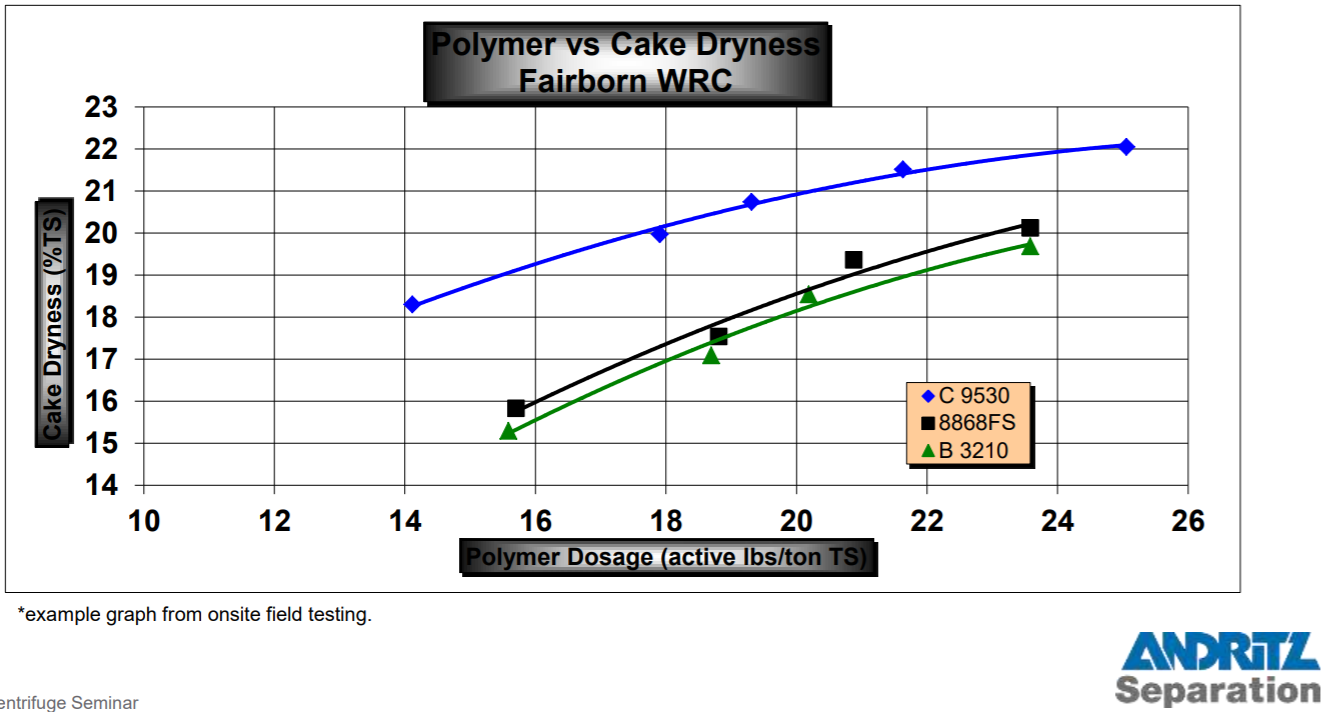

The ANDRITZ separation company tested out three different polymers, and discovered that Polydyne C 9530 produced the best results, as highlighted in the blue graph.
Furthermore, the highest cake dryness was produced with this polymer, at a dryness of 22%, which will meet our goal of 20 to 30 percent. This dryness was acheieved with the addition of 25 active pounds per ton of total solids. This graph also shows us that additional polymer dosing increases cake dryness, but these positive results taper off at a certain dosage. This research can help us determine the amount of polymer that should be added to our process.

The below graph, also provided by research produced by the ANDRITZ company, shows the effects of throughput on solids production. In these terms, throughput represents the amount of sludge passing through the centrifuge. As the throughput increases, the differential speed between the bowl and scroll must be increased to maintain the solids capture rate. This reduction in sludge retention time causes the cake dryness to
decrease as seen in the below graph. Therefore, we can deduce that, though centrifuges can pass 200 gallons per minute, this may not be a flow rate which can help meet our cake dryness goal. As presented below, the percent total solids decreased drmatically between 85 and 115 GPM, and continued to taper downwards. At throughputs between 50 and 85 GPM, therre was not a very noticeable difference in effectiveness of dewatering. 

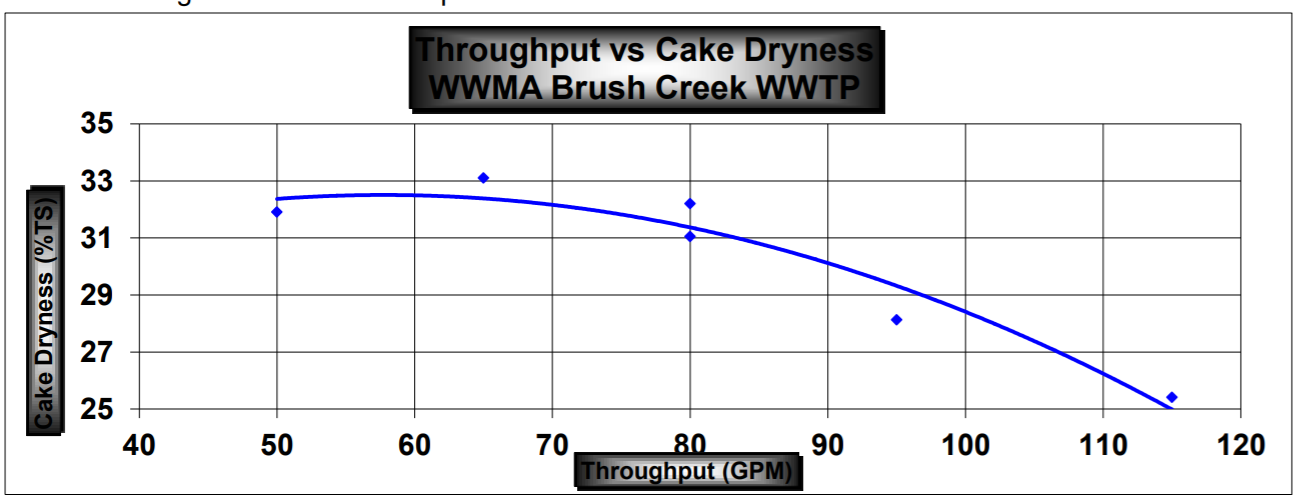

# Vendors and contact information file

See this [tab delimited spreadsheet](https://raw.githubusercontent.com/monroews/4590FSP/master/vendors.txt).

Add rows to the vendor spreadsheet as you find them. The sheet can easily be edited in Excel. Just make sure to save it as a tab delimited sheet. Push your changes to github so the entire class has access to the document.



In [0]:
vendors = pd.read_csv('https://raw.githubusercontent.com/monroews/4590FSP/master/vendors.txt',sep='\t')
vendors.head()

,item description,vendor,contact first name,contact last name,vendor website,product info,date of contact,who made the contact,notes
0,plate settlers,MRI,still,pending,http://www.meurerresearch.com/,http://www.meurerresearch.com/literaturemedia/...,4/16/2020,Ian Cullings,NaN
1,sludge removal system,MRI,still,pending,http://www.meurerresearch.com/,http://www.meurerresearch.com/products/hoseles...,4/16/2020,Ian Cullings,NaN
2,plate settlers,Monore Environmental,still,pending,https://www.monroeenvironmental.com/,https://www.monroeenvironmental.com/water-and-...,4/16/2020,Ian Cullings,NaN
3,sludge removal system,Monore Environmental,still,pending,https://www.monroeenvironmental.com/,http://www.monroeenvironmental.com/water-and-w...,4/16/2020,Ian Cullings,NaN
4,plate settler with hopper,Parkson,still,pending,https://www.parkson.com/,https://www.parkson.com/products/lamella-ecoflow,4/16/2020,Ian Cullings,Includes sloped sludge hopper in design


# Conversation with EMA Resources, Inc

EMA travels to water treatment plants with their personal belt presses, which they connect to the plant's gravity settler through a pipe. The plant can choose to mechanically thicken their sludge before EMA arrives, but EMA does not recommend that the percent solids of the sludge exceed 6%, as this can lead to blockages in the pipe. EMA's belt presses are able to dewater 200 gpm of sludge at a cost of 6-8 cents per gallon. EMA then transports the dewatered residuals to a disposal site. 

Accoring to EMA's estimates, we can calculate the daily espense of a third party dewatering our reiduals on site by multiplying the cost per gallon by the gallons of resdidual sludge produced per day.
We then calculated how long it will take one belt press to dewater a day's worth of residuals given that a belt press can dewater 200 gallons of sludge per minute.

In [0]:
cost_per_gallon=0.07*u.dollar/u.gallon
cost_per_day=cost_per_gallon*wet_sludge_volume
print('The daily cost to dewater residuals is',cost_per_day.to(u.dollar/u.day))
belt_press_capacity=200*u.gallon/u.minute
dewatering_time=(wet_sludge_volume/belt_press_capacity).to(u.minute/u.day)
print('If one belt press is utilized, it will take', dewatering_time,'to dewater a days worth of residuals')

The daily cost to dewater residuals is 2659 dollar / day
If one belt press is utilized, it will take 189.9 minute / day to dewater a days worth of residuals


# California Waste Discharge Requirements


"Section 13260(a) of the California Water Code requires that any person discharging waste or proposing to discharge waste within any region, other than to a community sewer system, that could affect the quality of the waters of the State, must file a report of waste discharge. All waste discharge requirements issued by the Regional Water Board include self-monitoring programs requiring the waste discharger to collect pertinent water quality data and to submit it to the Regional Water Board for evaluation of compliance with waste discharge requirements.



The treatment of drinking water results in liquid and solid wastes that contain concentrated contaminants such as arsenic. The Faimont Water Treatment Plant must dispose of their residuals in a way that complies with California law and minimizes environmental impact. Raw water characteristics that may impact the disposal optins of residuals include:


• Excessively high or low pH;


• High total suspended solids (TSS);


• High total dissolved solids (TDS);


• High concentrations of heavy metals, including arsenic, lead, and aluminum;


• High concentrations of competing ions, including fluoride, sodium, sulfate chloride, and other salts concentrations;

• High concentrations of radionuclides and daughter products.


[source](https://www.epa.gov/sites/production/files/2015-09/documents/train6-residuals.pdf)



To dispose of residuals in a solid waste landfill, the residuals must be nonhazardous, otherwise they must be disposed of in a hazardous waste landfill. Liquid residuals cannot be disposed of in a land disposal unit. To discharge resdiuals directly to a body, the residuals must be non-hazardous and meet National Pollutant Discharge Elimination System (NPDES) discharge requirements.


Depending on the concentrations of contanimants in a waste stream, intermediate processing may be neccessary before disposal. Types of **intermediate processing for liquid waste** includes flow equilization (detaining and mixing water system wastes before releasing residuals to a POTW), brine recycling (caution must be exercised, as reused brine streams can possess higher levels of suspended solids and contaminants), pH neutralization for wastes streams with a significantly high or low pH, settling or gravity thickening (removes contaminants from liquid waste stream, resulting in a cleaner liquid waste and a concentrated sludge), evaporation (leaves solids and contaminants behind), and chemical precipitation. Types of **intermediate processing for solid wastes** include mechanical dewatering processes (centrifugal filter presses, vacuumassisted dewatering beds, belt filter presses, plate-and-frame filter presses), filter presses, non-mechanical dewatering processes (lagoons, settling basins, gravity thickening, evaporation ponds, drying beds), and thermal processing (incineration, pyrolysis).


For the most part, the dillution of hazardous waste in not recommended, as any mixture or derivative of a hazardous waste is also characterized as a hazardous waste. 

# Arsenic Standards 

The national TC (toxicity characteristic) for arsenic is 5 mg/L. If the concentration of arsenic in residuals exceeds this value, the waste in considered hazardous and is not acceptable for direct discharge. However, this value can vary region-to-region. The TBLL (technically based local limit) for arsenic is 1 mg/L in San Jose, CA and 2 mg/L in Orange County, CA. 


# Processing of Nonhazardous Residuals


Nonhazardous residuals produced from sorption processes or chemical precipitation may be disposed of in the following ways:

>Recycle backwash water to facility headwokrs, discharge backwash to recieving body or POTW, and dispose of solid wastes in landfill.

Nonhazardous residuals produced from membrane processes may be disposed of in the following ways:

>Solid wastes disposed in landfill, liquid wastes may need pretreatment before discharge into POTW. 



# Health-based acceptable loading limites established under 40 CFR 503:


Pollutant | Ceiling concentration (mg/kg) | Cumulative pollutant loading rate (kg/hectare) | Monthly avg concentration (mg/kg) | Annual Pollutant loading rate (kg/hectare/365 day period)
--- | --- | --- | --- | ---
Arsenic| 75 | 41 | 41 | 2.0 
Cadmium | 85 | 39 | 39 | 1.9 
Copper | 4300 | 1500 | 1500 | 75
Lead | 840 | 300 | 300 | 15
Mercury | 57 | 17 | 17 | 0.85
Molybdenum | 75 | -- | -- | -- 
Nickel | 420 | 420 | 420 | 21
Selenium | 100 | 100 | 100 | 5.0
Zinc | 7500 | 2800 | 2800 | 140



The overall goal of Fairmont's residuals management team is to minimize the amount of hazardous waste generated, as hazardous waste is expensive to dispose of and carries a strict cradle-to-grave liability.

# Shared assumptions

See this [python file, Fairmont.py](https://github.com/monroews/4590FSP/blob/master/Fairmont.py)

Use this file to hold parameters that are in the SOW or elsewhere that
influence the design of the entire plant. This provides an easy mechanism
for all of us to share the same assumptions. Read the SOW to find sections that relate to your part of the design and enter all pertinent variables into [Fairmont.py](https://github.com/monroews/4590FSP/blob/master/Fairmont.py) and then push those changes to github.

# Major Decisions

Write several paragraphs describing the major decisions that you will need to make in order to create a design and outline a strategy for how you will obtain the necessary information to make those decisions.

The major decisions we we need to make in order to create a design and outline a strategy for managing the residuals is to assume plant characteristics, and build off of them to start calculating values neccesary to produce our designs. We used an estimated average flow rate of 320 ft^3/s  for our plant. We also used an influent turbidity value of 14 NTU s a starting point of the plant's inflow water. This would help us determine the sludge characterisitcs we would work with as an effluent in our residuals. The goal trubidity of the plant was set as 3 NTU, and the ferric chloride dose was set at 13.14 mg/l in our calculations. We calculated the average dose of polymer using the yearly amount of 165 tons/year and the average flow rate of the plant. 

To carry out our initial code, we used equations given in the MWH textbook. Using equation 21-12 and 21-13, we were able to find the amount of dry sludge from the coagulant dose in mass/day, from the removal of trubidity in mass/day, and the dry sludge from polymer addition, also in mass/day. These values helped us to determine the total dry sludge amount in mass/day that we can expect when determining our residuals process.

Using the value we found for the weight of total dry solids, and the density of water, we were able to use equation 21-3 and table 21-2 to find the percent solids. Next, we calculated the weight of the volayile solids using values of 2.5 for fixed specific gravity and 1 for specific gravity. We assumed that the volatile solids equalled the dry sludge from the coagulant in our calculations.




# Next Steps and Challenges

Challenges include trying to reduce the volume of residuals within the plant. This should be done by concentrating wastes as much as possible. This leftover water should be recycled back into the front end of the plant. Also, considering what to do with the residuals can be difficult due to limited space availability of dumping in Los Angeles. Another challenge includes finding safe ways to deal with Arsenic in the residuals, since it is a hazardous waste, and presents itself in high concentrations through the plant inflow. The management of liquid waste streams is also going to be challenging, as our team will try to recycle as much water as possible, and the constituents in the return flow are difficult to manage. 

Next Steps include contacting the other teams to decide which treatment trains we should focus on removing residuals from, and researching more on the types of contaminants in typical inflow waters in the area. This could help our team in determining what types of chemicals and processes will be used in getting rid of contaminants, and the amount of residual flows we will need to focus on. 
We also will need to research the regulatory standards out in place for the contaminants we will be working to remove, in order to understand how and where they can be disposed of. 
Another large part of our next steps includes researching methods of equations for mass of wastes, figure out who manufacturers are of units that process the solids, and suggest centrifuges. A reasonable task might be to look at the top options for consolidating solids in addition to centrifuges, see if we agree that using a centrifuge for dewatering is the top choice. We want to identify the "why" of the  technology approach.



# Design

Begin writing the code to start your design. Define flow rates, mass rates, energy requirements, and any readily calculated dimensions, velocities, flows, etc.

In [0]:
print('The average flow to be treated at Fairmont is',fmt.q_ave.to(u.Mgal/u.day),'or')
print('The maximum flow to be treated at Fairmont is',fmt.q_max.to(u.Mgal/u.day))
specific_energy = (fmt.electricity_power/fmt.q_ave).to(u.J/u.L)
temp = 15 * u.degC
specific_potential_energy = (specific_energy / u.gravity / ac.density_water(temp)).to(u.m)
print('The average amount of energy used per liter of water is expected to be',specific_energy,'or',specific_potential_energy,'of potential energy')

The average flow to be treated at Fairmont is 206.8 megagallon / day or
The maximum flow to be treated at Fairmont is 465.3 megagallon / day
The average amount of energy used per liter of water is expected to be 118.1 joule / liter or 12.05 meter of potential energy


In [0]:


yearly_emulsion_polymer=165*u.ton/u.year
avg_dose_emulsion_polymer=(yearly_emulsion_polymer/(fmt.q_ave)).to(u.mg/u.liter)

sludge_estimate=sludge(flow=fmt.q_ave)
dry_sludge=sludge_estimate.dry_sludge(coag_type='Ferric chloride',coag_dose=fmt.Fe_c_ave,influent_turbidity=fmt.turbidity_c_in_ave,goal_turbidity=fmt.turbidity_c_out_design,polymer_dose=fmt.emulsionpolymer_c_ave)
wet_sludge_volume=sludge_estimate.sludge_volume_wet(temperature=15*u.degC)
wet_sludge_mass=sludge_estimate.sludge_mass_wet()

print('We estimate that the dry sludge mass produced will be', dry_sludge.to(u.ton/u.day))
print('We estimate that the wet sludge volume will be', wet_sludge_volume)
print('We estimate that the wet sludge mass will be', wet_sludge_mass.to(u.ton/u.day))




TypeError: ignored

Resources:

https://www.epa.gov/sites/production/files/2015-11/documents/dw-treatment-residuals-mgmt-tech-report-sept-2011.pdf

https://www.epa.gov/sites/production/files/2015-10/documents/method_1684_draft_2001.pdf

http://web.deu.edu.tr/atiksu/ana58/c-7.pdf

https://vtechworks.lib.vt.edu/bitstream/handle/10919/26604/04Chapter3.pdf?sequence=3

#**Questions:**

How do we know what the sludge compostion is?
For physical properties which are we using in the range?

>How do we know how the centrifuge works/ how well it will dewater our sludge?